# Preprocessing

In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567857 sha256=b5cac98a54bbf7da8e09fe41aa230bdd8963040b9668378e1f7be781396f3bda
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Loaded 1,552,041 rows, 42 columns

APPLYING EXCLUSION CRITERIA FROM BASELINE PAPER
Excluded 0 patients with < 8 hours ICU data
Excluded 530 patients with sepsis onset < 4 hours after admission

Patients: 40331 → 39801 (excluded 530)
Rows: 1,552,041 → 1,547,195

Using 'ICULOS' to build hourly time index as 'charttime'.


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-722603645.py:161: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g_hour = g.set_index(time_col).resample('1H').last()
/tmp/ipython-input-722603645.py:161: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g_hour = g.set_index(time_col).resample('1H').last()
/tmp/ipython-input-722603645.py:161: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g_hour = g.set_index(time_col).resample('1H').last()
/tmp/ipython-input-722603645.py:161: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g_hour = g.set_index(time_col).resample('1H').last()
/tmp/ipython-input-722603645.py:161: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g_hour = g.set_index(time_col).resample('1H').last()

Resampled to hourly grid: 1,547,195 rows

DATASET SPLIT (matching baseline paper)
Test patients:    5971 ( 15.0%) - Held-out
Train patients:  27064 ( 68.0%)
Val patients:     6766 ( 17.0%)
Total patients:  39801

Test rows:   230,757
Train rows: 1,052,708
Val rows:    263,730

Computing IQR limits for base features from TRAINING data only...
Base IQR limits computed for 34 features

Creating original missing value masks...
Applying time-limited forward-fill...

Computing derived features...
  Computed ShockIndex
  Computed BUN_Cr
  Computed MEWS
  Computed pSOFA

Applying clinical sanity bounds to IQR limits...
Saved IQR min/max limits to: /content/drive/MyDrive/AI_Fin/iqr_minmax_limits.json

Normalizing features using IQR limits...

Imputing -1 for all originally missing values...
  HR: Imputed 152,684 missing values with -1
  SBP: Imputed 225,179 missing values with -1
  DBP: Imputed 484,552 missing values with -1
  Resp: Imputed 237,307 missing values with -1
  O2Sat: Imputed 201,86

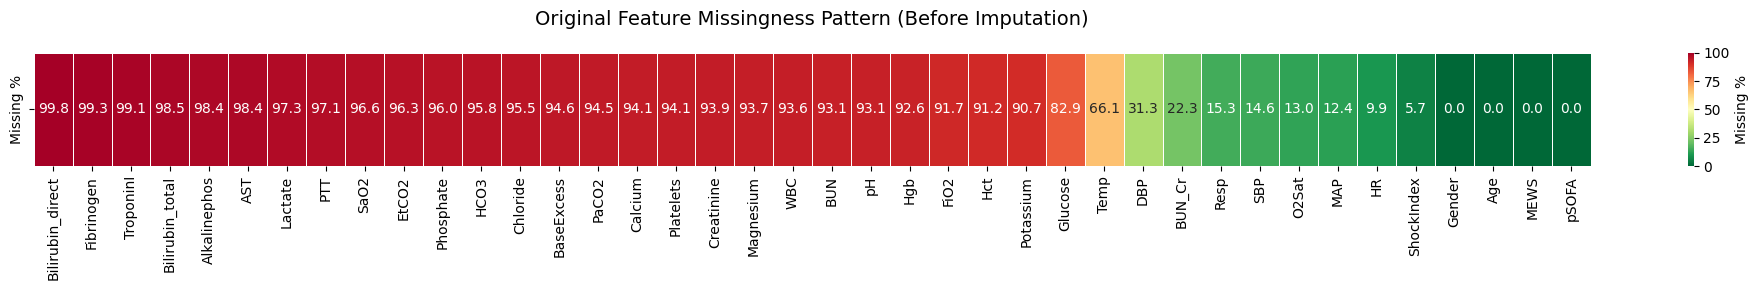


Top 10 features with highest missingness:
         Feature  Missing %
Bilirubin_direct  99.809849
      Fibrinogen  99.342423
       TroponinI  99.053836
 Bilirubin_total  98.520225
    Alkalinephos  98.405308
             AST  98.389860
         Lactate  97.348298
             PTT  97.064300
            SaO2  96.557900
           EtCO2  96.304021


In [ ]:
"""
Preprocessing adapted to specified column names:
['patient_id','HR','O2Sat','Temp','SBP','MAP','DBP','Resp','EtCO2',
 'BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos',
 'Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate',
 'Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct',
 'Hgb','PTT','WBC','Fibrinogen','Platelets','Age','Gender','Unit1','Unit2',
 'HospAdmTime','ICULOS','SepsisLabel']
- Uses ICULOS to create hourly index per patient (if ICULOS present)
- Computes IQR ranges from training patients only and applies them
- Properly imputes -1 for ALL missing values after normalization
- Includes baseline paper exclusion criteria
- Three-way split: 15% test, 68% train, 17% validation (matching baseline paper)
"""

import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split

# -------- USER CONFIG --------
input_path = '/content/drive/MyDrive/AI_Course_Project/Dataset/merged_sepsis_dataset.csv'  # update path
output_dir = '/content/drive/MyDrive/AI_Course_Project'                # output to AI_Fin
os.makedirs(output_dir, exist_ok=True)

train_output_csv = os.path.join(output_dir, 'sepsis_preprocessed_train.csv')
val_output_csv   = os.path.join(output_dir, 'sepsis_preprocessed_val.csv')
test_output_csv  = os.path.join(output_dir, 'sepsis_preprocessed_test.csv')
full_output_csv  = os.path.join(output_dir, 'sepsis_preprocessed_full.csv')
limits_json_path = os.path.join(output_dir, 'iqr_minmax_limits.json')

random_state = 42

# -------- FEATURE HOLD INTERVALS (hours) using your column names --------
feature_intervals = {
    'HR': 4,
    'SBP': 4,
    'DBP': 4,
    'Resp': 4,
    'O2Sat': 4,
    'Temp': 4,
    'MAP': 4,
    'EtCO2': 4,
    'BaseExcess': 24,
    'HCO3': 24,
    'FiO2': 4,
    'pH': 24,
    'PaCO2': 24,
    'SaO2': 4,
    'AST': 24,
    'BUN': 24,
    'Alkalinephos': 24,
    'Calcium': 24,
    'Chloride': 24,
    'Creatinine': 24,
    'Bilirubin_direct': 24,
    'Glucose': 24,
    'Lactate': 24,
    'Magnesium': 24,
    'Phosphate': 24,
    'Potassium': 24,
    'Bilirubin_total': 24,
    'TroponinI': 24,
    'Hct': 24,
    'Hgb': 24,
    'PTT': 24,
    'WBC': 24,
    'Fibrinogen': 24,
    'Platelets': 24,
    # demographic / static
    'Age': None,
    'Gender': None,
}

# Optional clinical sanity bounds to clamp IQR-based limits (feature: (min,max))
clinical_sanity = {
    'HR': (30, 250),
    'SBP': (40, 250),
    'Temp': (30.0, 45.0),
    'O2Sat': (50, 100),
    'MAP': (30, 200),
    'Resp': (5, 60),
    'Creatinine': (0.1, 20.0),
    'BUN': (1, 200),
    'Platelets': (1, 1000),
    'Glucose': (30, 1000),
}

# -------- LOAD --------
df = pd.read_csv(input_path)
print(f"Loaded {len(df):,} rows, {df.shape[1]} columns")

# Validate patient_id exists
if 'patient_id' not in df.columns:
    raise ValueError("Input must contain 'patient_id' column (lowercase).")

# -------- EXCLUSION CRITERIA (matching baseline paper) --------
print("\n" + "="*60)
print("APPLYING EXCLUSION CRITERIA FROM BASELINE PAPER")
print("="*60)

# Count patients before exclusion
n_patients_before = df['patient_id'].nunique()
n_rows_before = len(df)

# Exclusion 1: Patients with < 8 hours of ICU data
if 'ICULOS' in df.columns:
    patient_max_iculos = df.groupby('patient_id')['ICULOS'].max()
    valid_patients_duration = patient_max_iculos[patient_max_iculos >= 8].index
    df = df[df['patient_id'].isin(valid_patients_duration)].copy()
    excluded_duration = n_patients_before - len(valid_patients_duration)
    print(f"Excluded {excluded_duration} patients with < 8 hours ICU data")
else:
    print("Warning: ICULOS column not found. Skipping ICU duration exclusion.")

# Exclusion 2: Sepsis onset < 4 hours after ICU admission
if 'SepsisLabel' in df.columns and 'ICULOS' in df.columns:
    # Find first sepsis onset time for each patient
    sepsis_patients = df[df['SepsisLabel'] == 1].groupby('patient_id')['ICULOS'].min()
    # Keep patients whose sepsis onset is >= 4 hours OR who never develop sepsis
    early_sepsis_patients = sepsis_patients[sepsis_patients < 4].index
    df = df[~df['patient_id'].isin(early_sepsis_patients)].copy()
    print(f"Excluded {len(early_sepsis_patients)} patients with sepsis onset < 4 hours after admission")
else:
    print("Warning: SepsisLabel or ICULOS column not found. Skipping early sepsis exclusion.")

n_patients_after = df['patient_id'].nunique()
n_rows_after = len(df)
print(f"\nPatients: {n_patients_before} → {n_patients_after} (excluded {n_patients_before - n_patients_after})")
print(f"Rows: {n_rows_before:,} → {n_rows_after:,}")
print("="*60 + "\n")

# Build synthetic time index using ICULOS if present (ICULOS = hours since ICU admission)
time_present = False
if 'ICULOS' in df.columns:
    # create a synthetic datetime column from ICULOS (so we can resample hourly)
    # use an arbitrary epoch date per patient; only relative hourly spacing matters
    df['charttime'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df['ICULOS'], unit='h')
    time_present = True
    time_col = 'charttime'
    print("Using 'ICULOS' to build hourly time index as 'charttime'.")
else:
    # fallback: check common timestamp names
    time_candidates = [c for c in df.columns if c.lower() in ('timestamp','time','datetime','charttime','date')]
    if time_candidates:
        time_col = time_candidates[0]
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        time_present = True
        print(f"Using detected time column '{time_col}'.")
    else:
        time_col = None
        print("No ICULOS or timestamp column found. Hourly resampling will be skipped (less ideal).")

# -------- RESAMPLE to hourly grid per patient (use last observed value in hour) --------
if time_present:
    static_cols = [c for c, v in feature_intervals.items() if v is None and c in df.columns]
    parts = []
    for pid, g in df.groupby('patient_id'):
        g = g.sort_values(time_col)
        g_hour = g.set_index(time_col).resample('1H').last()
        g_hour['patient_id'] = pid
        for s in static_cols:
            if s in g.columns:
                first_val = g[s].ffill().bfill().iloc[0] if not g[s].isna().all() else np.nan
                g_hour[s] = first_val
        parts.append(g_hour.reset_index())
    df_hourly = pd.concat(parts, ignore_index=True, sort=False)
    print(f"Resampled to hourly grid: {len(df_hourly):,} rows")
else:
    df_hourly = df.copy()
    print("Proceeding without hourly resampling (operating on original rows).")

# -------- PATIENT-LEVEL SPLIT (matching baseline paper: 15% test, 68% train, 17% val) --------
patient_ids = df_hourly['patient_id'].unique()

# First split: 15% for test (held-out), 85% for train+validation
train_val_ids, test_ids = train_test_split(
    patient_ids,
    test_size=0.15,  # 15% held-out for testing
    random_state=random_state
)

# Second split: Split remaining 85% into 80% train and 20% validation
# This results in: 68% train (0.85 * 0.80) and 17% validation (0.85 * 0.20)
train_ids, val_ids = train_test_split(
    train_val_ids,
    test_size=0.2,  # 20% of the remaining 85% for validation
    random_state=random_state
)

train_hourly = df_hourly[df_hourly['patient_id'].isin(train_ids)].copy()
val_hourly = df_hourly[df_hourly['patient_id'].isin(val_ids)].copy()
test_hourly = df_hourly[df_hourly['patient_id'].isin(test_ids)].copy()

print(f"\n{'='*60}")
print("DATASET SPLIT (matching baseline paper)")
print(f"{'='*60}")
print(f"Test patients:  {len(test_ids):>6} ({len(test_ids)/len(patient_ids)*100:>5.1f}%) - Held-out")
print(f"Train patients: {len(train_ids):>6} ({len(train_ids)/len(patient_ids)*100:>5.1f}%)")
print(f"Val patients:   {len(val_ids):>6} ({len(val_ids)/len(patient_ids)*100:>5.1f}%)")
print(f"Total patients: {len(patient_ids):>6}")
print(f"\nTest rows:  {len(test_hourly):>8,}")
print(f"Train rows: {len(train_hourly):>8,}")
print(f"Val rows:   {len(val_hourly):>8,}")
print(f"{'='*60}\n")

# -------- IQR-limits computation helper --------
def compute_iqr_limits(df_src, feature_list, min_obs_threshold=10):
    limits = {}
    for feat in feature_list:
        if feat not in df_src.columns:
            continue
        s = df_src[feat].dropna()
        if len(s) < min_obs_threshold:
            continue
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        xmin = float(q1 - 1.5 * iqr)
        xmax = float(q3 + 1.5 * iqr)
        limits[feat] = (xmin, xmax)
    return limits

# features to compute IQR for (exclude statics)
feature_list_for_iqr = [f for f, v in feature_intervals.items() if v is not None and f in df_hourly.columns]
print("Computing IQR limits for base features from TRAINING data only...")
iqr_limits_base = compute_iqr_limits(train_hourly, feature_list_for_iqr)
print("Base IQR limits computed for", len(iqr_limits_base), "features")

# -------- Store original missing mask BEFORE any forward fill --------
print("\nCreating original missing value masks...")
original_missing_mask = {}
for feat in list(feature_intervals.keys()):
    if feat in df_hourly.columns:
        original_missing_mask[feat] = df_hourly[feat].isna().copy()

# -------- TIME-LIMITED FORWARD-FILL on full hourly dataframe --------
df_filled = df_hourly.copy()
print("Applying time-limited forward-fill...")
for feat, hold_hours in feature_intervals.items():
    if feat not in df_filled.columns:
        continue
    if hold_hours is None:
        continue
    # FIXED: Use new pandas syntax instead of deprecated method parameter
    df_filled[feat] = df_filled.groupby('patient_id')[feat].transform(
        lambda s: s.ffill(limit=hold_hours)
    )

# -------- DERIVED FEATURES (using your column names) --------
print("\nComputing derived features...")

# ShockIndex = HR / SBP
if {'HR', 'SBP'}.issubset(df_filled.columns):
    df_filled['ShockIndex'] = df_filled['HR'] / df_filled['SBP'].replace({0: np.nan})
    feature_intervals['ShockIndex'] = 4
    original_missing_mask['ShockIndex'] = df_filled['ShockIndex'].isna().copy()
    print("  Computed ShockIndex")

# BUN_Cr = BUN / Creatinine
if {'BUN', 'Creatinine'}.issubset(df_filled.columns):
    df_filled['BUN_Cr'] = df_filled['BUN'] / df_filled['Creatinine'].replace({0: np.nan})
    feature_intervals['BUN_Cr'] = 24
    original_missing_mask['BUN_Cr'] = df_filled['BUN_Cr'].isna().copy()
    print("  Computed BUN_Cr")

# MEWS (partial, without AVPU) using SBP, HR, Resp, Temp
def compute_mews_series(df_local):
    s = pd.Series(0, index=df_local.index, dtype=float)
    if 'SBP' in df_local.columns:
        sbp = df_local['SBP']
        s += np.where(sbp <= 70, 3, 0)
        s += np.where((sbp > 70) & (sbp <= 80), 2, 0)
        s += np.where((sbp > 80) & (sbp <= 100), 1, 0)
        s += np.where(sbp >= 200, 2, 0)
    if 'HR' in df_local.columns:
        hr = df_local['HR']
        s += np.where(hr <= 40, 2, 0)
        s += np.where((hr > 40) & (hr <= 50), 1, 0)
        s += np.where((hr > 50) & (hr <= 100), 0, 0)
        s += np.where((hr > 100) & (hr <= 110), 1, 0)
        s += np.where((hr > 110) & (hr <= 129), 2, 0)
        s += np.where(hr >= 130, 3, 0)
    if 'Resp' in df_local.columns:
        rr = df_local['Resp']
        s += np.where(rr <= 8, 2, 0)
        s += np.where((rr > 8) & (rr <= 14), 0, 0)
        s += np.where((rr > 14) & (rr <= 20), 1, 0)
        s += np.where((rr > 20) & (rr <= 29), 2, 0)
        s += np.where(rr >= 30, 3, 0)
    if 'Temp' in df_local.columns:
        t = df_local['Temp']
        s += np.where(t <= 35.0, 2, 0)
        s += np.where(t >= 38.5, 1, 0)
    return s

df_filled['MEWS'] = compute_mews_series(df_filled)
feature_intervals['MEWS'] = 4
original_missing_mask['MEWS'] = df_filled['MEWS'].isna().copy()
print("  Computed MEWS")

# pSOFA using MAP (no vasopressors), Bilirubin_total, Platelets
bili_col = 'Bilirubin_total' if 'Bilirubin_total' in df_filled.columns else None

def compute_psofa_series(df_local, bili_column):
    s = pd.Series(0, index=df_local.index, dtype=float)
    if 'MAP' in df_local.columns:
        s += np.where(df_local['MAP'] < 70, 1, 0)
    if bili_column and bili_column in df_local.columns:
        b = df_local[bili_column]
        s += np.where((b >= 1.2) & (b < 2.0), 1, 0)
        s += np.where((b >= 2.0) & (b < 6.0), 2, 0)
        s += np.where((b >= 6.0) & (b < 12.0), 3, 0)
        s += np.where(b >= 12.0, 4, 0)
    if 'Platelets' in df_local.columns:
        pl = df_local['Platelets']
        s += np.where((pl >= 100) & (pl <= 149), 1, 0)
        s += np.where((pl >= 50) & (pl <= 99), 2, 0)
        s += np.where((pl >= 20) & (pl <= 49), 3, 0)
        s += np.where(pl < 20, 4, 0)
    return s

df_filled['pSOFA'] = compute_psofa_series(df_filled, bili_col)
feature_intervals['pSOFA'] = 24
original_missing_mask['pSOFA'] = df_filled['pSOFA'].isna().copy()
print("  Computed pSOFA")

# -------- Compute IQR limits from training set for derived features (after ffill) --------
derived_feats = [f for f in ('ShockIndex', 'BUN_Cr', 'MEWS', 'pSOFA') if f in df_filled.columns]
train_filled = df_filled[df_filled['patient_id'].isin(train_ids)]
iqr_limits_derived = compute_iqr_limits(train_filled, derived_feats)

# Merge base + derived IQR limits
iqr_limits = dict(iqr_limits_base)
iqr_limits.update(iqr_limits_derived)

# Apply clinical sanity bounds where provided
print("\nApplying clinical sanity bounds to IQR limits...")
for feat, (xmin, xmax) in list(iqr_limits.items()):
    if feat in clinical_sanity:
        cmin, cmax = clinical_sanity[feat]
        new_min = max(xmin, cmin)
        new_max = min(xmax, cmax)
        if new_min < new_max:
            iqr_limits[feat] = (float(new_min), float(new_max))
        else:
            print(f"  Warning: Clinical bounds for {feat} resulted in inverted range. Keeping IQR bounds.")

# Save computed limits to JSON for reproducibility
with open(limits_json_path, 'w') as f:
    json.dump(iqr_limits, f, indent=2)
print(f"Saved IQR min/max limits to: {limits_json_path}")

# -------- Clip and normalize using iqr_limits --------
print("\nNormalizing features using IQR limits...")
for feat, (xmin, xmax) in iqr_limits.items():
    if feat not in df_filled.columns:
        continue
    not_na = df_filled[feat].notna()
    denom = (xmax - xmin) if (xmax - xmin) != 0 else 1.0
    df_filled.loc[not_na, feat] = df_filled.loc[not_na, feat].clip(lower=xmin, upper=xmax)
    df_filled.loc[not_na, feat] = 4.0 * (df_filled.loc[not_na, feat] - xmin) / denom + 1.0

# -------- CRITICAL FIX: Set ALL originally missing values to -1 (using original masks) --------
print("\nImputing -1 for all originally missing values...")
all_features_to_impute = list(feature_intervals.keys()) + derived_feats

for feat in all_features_to_impute:
    if feat not in df_filled.columns:
        continue
    if feat not in original_missing_mask:
        continue

    # Use the ORIGINAL missing mask (before forward fill)
    missing_mask = original_missing_mask[feat]
    num_missing = missing_mask.sum()

    if num_missing > 0:
        df_filled.loc[missing_mask, feat] = -1.0
        print(f"  {feat}: Imputed {num_missing:,} missing values with -1")

# -------- Create mask columns (1 = present in original data, 0 = missing in original data) --------
print("\nCreating mask columns...")
for feat in all_features_to_impute:
    if feat not in df_filled.columns:
        continue
    if feat in original_missing_mask:
        df_filled[f'{feat}_mask'] = (~original_missing_mask[feat]).astype(int)

# -------- Drop features missing in >80% of patients (patient-level) --------
print("\nFiltering features by patient-level missingness...")
n_patients = len(df_filled['patient_id'].unique())
feat_list_all = [f for f in all_features_to_impute if f in df_filled.columns]

# FIXED: Remove duplicates from feat_list_all while preserving order
feat_list_all = list(dict.fromkeys(feat_list_all))

presence_df = df_filled.groupby('patient_id')[feat_list_all].apply(lambda g: g.notna().any())
feat_patient_counts = presence_df.sum(axis=0)
feat_missing_frac = 1.0 - feat_patient_counts / n_patients
keep_feats = [f for f, frac in feat_missing_frac.items() if frac <= 0.8]
keep_mask_cols = [f'{f}_mask' for f in keep_feats if f'{f}_mask' in df_filled.columns]

print(f"Kept {len(keep_feats)} unique features after patient-level >80% missing filter.")
print("Kept features:", keep_feats)

# Keep other columns (labels, timestamps, metadata)
other_cols = [c for c in df_filled.columns
              if c not in feat_list_all
              and c not in [f'{x}_mask' for x in feat_list_all]]

cols_to_keep = ['patient_id']
if time_present:
    cols_to_keep.append(time_col)
cols_to_keep += keep_feats + keep_mask_cols + other_cols

# Remove duplicates & preserve order
seen = set()
final_cols = []
for c in cols_to_keep:
    if c in df_filled.columns and c not in seen:
        final_cols.append(c)
        seen.add(c)

df_final = df_filled[final_cols].copy()

# -------- Split by patient_id and save train/val/test/full CSVs --------
print("\nSplitting and saving final datasets...")
df_train_final = df_final[df_final['patient_id'].isin(train_ids)]
df_val_final = df_final[df_final['patient_id'].isin(val_ids)]
df_test_final = df_final[df_final['patient_id'].isin(test_ids)]

df_train_final.to_csv(train_output_csv, index=False)
df_val_final.to_csv(val_output_csv, index=False)
df_test_final.to_csv(test_output_csv, index=False)
df_final.to_csv(full_output_csv, index=False)

print(f"\n{'='*60}")
print("PREPROCESSING COMPLETE")
print(f"{'='*60}")
print(f"Saved preprocessed train to: {train_output_csv}")
print(f"Saved preprocessed val   to: {val_output_csv}")
print(f"Saved preprocessed test  to: {test_output_csv}")
print(f"Saved preprocessed full  to: {full_output_csv}")
print(f"\nTrain shape: {df_train_final.shape}")
print(f"Val shape:   {df_val_final.shape}")
print(f"Test shape:  {df_test_final.shape}")
print(f"Full shape:  {df_final.shape}")
print(f"{'='*60}")


# Verify all features are now filled
print("\n" + "="*60)
print("POST-IMPUTATION VERIFICATION")
print("="*60)
print(f"Features with any NaN values: {df_final[keep_feats].isna().any().sum()}")
print(f"Total NaN count: {df_final[keep_feats].isna().sum().sum()}")
print("="*60)



# -------- VISUALIZE ORIGINAL MISSINGNESS PATTERNS --------
print("\nGenerating missingness visualization...")
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate missingness percentage for ORIGINAL data (before imputation)
# We'll use the mask columns which encode original missingness
mask_columns = [c for c in df_final.columns if c.endswith('_mask')]
feature_names = [c.replace('_mask', '') for c in mask_columns]

# Calculate missingness: 1 - mean(mask) = % originally missing
missingness_pct = {}
for feat, mask_col in zip(feature_names, mask_columns):
    missingness_pct[feat] = (1 - df_final[mask_col].mean()) * 100

# Convert to DataFrame for visualization
miss_df = pd.DataFrame(list(missingness_pct.items()),
                        columns=['Feature', 'Missing %'])
miss_df = miss_df.sort_values('Missing %', ascending=False)

# Create heatmap
plt.figure(figsize=(20, 3))
sns.heatmap(miss_df.set_index('Feature')['Missing %'].to_frame().T,
            annot=True,
            fmt='.1f',
            cmap='RdYlGn_r',
            cbar_kws={'label': 'Missing %'},
            linewidths=0.5,
            vmin=0,
            vmax=100)
plt.title('Original Feature Missingness Pattern (Before Imputation)', fontsize=14, pad=20)
plt.xlabel('')
plt.tight_layout()

# Save to drive
missingness_plot_path = os.path.join(output_dir, 'feature_missingness_heatmap.png')
plt.savefig(missingness_plot_path, dpi=300, bbox_inches='tight')
print(f"Saved missingness visualization to: {missingness_plot_path}")

# Also save missingness statistics as CSV
miss_csv_path = os.path.join(output_dir, 'feature_missingness_stats.csv')
miss_df.to_csv(miss_csv_path, index=False)
print(f"Saved missingness statistics to: {miss_csv_path}")

# Display the plot
plt.show()

print("\nTop 10 features with highest missingness:")
print(miss_df.head(10).to_string(index=False))



**Build Input Matrices**

In [ ]:
import pandas as pd
import numpy as np
import os

# --- USER CONFIG ---
preprocessed_train_csv = '/content/drive/MyDrive/AI_Course_Project/Dataset/sepsis_preprocessed_train.csv'
preprocessed_val_csv   = '/content/drive/MyDrive/AI_Course_Project/Dataset/sepsis_preprocessed_val.csv'  # ADD THIS
preprocessed_test_csv  = '/content/drive/MyDrive/AI_Course_Project/Dataset/sepsis_preprocessed_test.csv'
output_dir = '/content/drive/MyDrive/AI_Course_Project/Dataset'
WINDOW_HOURS = 4
LABEL = 'SepsisLabel'

# 21 features as used in the Baseline paper
FEATURES = [
    'HR', 'SBP', 'DBP', 'Resp', 'O2Sat', 'Temp', 'MAP',
    'WBC', 'Platelets', 'Hgb', 'Creatinine', 'BUN', 'Potassium',
    'Glucose', 'Lactate',
    'Age', 'Gender',
    'ShockIndex', 'BUN_Cr', 'MEWS', 'pSOFA'
]

def build_patient_matrices(df, features, label, window_hours):
    data_samples = []
    label_samples = []
    patient_ids = []  # CRITICAL: Track patient IDs

    groupby_key = 'patient_id'
    time_key = 'charttime' if 'charttime' in df.columns else None

    for pid, group in df.groupby(groupby_key):
        g = group.sort_values(time_key) if time_key else group.copy()
        g = g.reset_index(drop=True)

        if label not in g.columns:
            continue

        labels = g[label].values
        values = g[features].values

        if len(values) < window_hours:
            continue

        for start in range(len(values) - window_hours + 1):
            window_x = values[start:start + window_hours]
            window_y = labels[start + window_hours - 1]

            data_samples.append(window_x)
            label_samples.append(window_y)
            patient_ids.append(pid)  # CRITICAL: Save patient ID for each window

    data_samples = np.stack(data_samples)
    label_samples = np.array(label_samples)
    patient_ids = np.array(patient_ids)  # CRITICAL: Return patient IDs

    return data_samples, label_samples, patient_ids  # RETURN 3 VALUES, NOT 2

# --- Load data ---
print("Loading preprocessed data...")
df_train = pd.read_csv(preprocessed_train_csv)
df_val = pd.read_csv(preprocessed_val_csv)      # CRITICAL: Load validation set
df_test = pd.read_csv(preprocessed_test_csv)

print(f"Train: {len(df_train):,} rows, {df_train['patient_id'].nunique()} patients")
print(f"Val:   {len(df_val):,} rows, {df_val['patient_id'].nunique()} patients")
print(f"Test:  {len(df_test):,} rows, {df_test['patient_id'].nunique()} patients")

# --- Build matrices ---
print("\nBuilding sliding window matrices...")
X_train, y_train, pid_train = build_patient_matrices(df_train, FEATURES, LABEL, WINDOW_HOURS)
X_val, y_val, pid_val = build_patient_matrices(df_val, FEATURES, LABEL, WINDOW_HOURS)  # CRITICAL: Val set
X_test, y_test, pid_test = build_patient_matrices(df_test, FEATURES, LABEL, WINDOW_HOURS)

# --- Print statistics ---
print(f"\nTrain windows: {X_train.shape}")
print(f"  Class 0: {(y_train == 0).sum():,}, Class 1: {(y_train == 1).sum():,}")
print(f"  Unique patients: {len(np.unique(pid_train))}")

print(f"\nVal windows: {X_val.shape}")
print(f"  Class 0: {(y_val == 0).sum():,}, Class 1: {(y_val == 1).sum():,}")
print(f"  Unique patients: {len(np.unique(pid_val))}")

print(f"\nTest windows: {X_test.shape}")
print(f"  Class 0: {(y_test == 0).sum():,}, Class 1: {(y_test == 1).sum():,}")
print(f"  Unique patients: {len(np.unique(pid_test))}")

# --- Save with patient IDs ---
np.savez_compressed(  # Use compressed for smaller file size
    os.path.join(output_dir, 'baseline_train_matrices.npz'),
    X=X_train,
    y=y_train,
    patient_ids=pid_train  # CRITICAL: Save patient IDs
)

np.savez_compressed(
    os.path.join(output_dir, 'baseline_val_matrices.npz'),
    X=X_val,
    y=y_val,
    patient_ids=pid_val  # CRITICAL: Save patient IDs
)

np.savez_compressed(
    os.path.join(output_dir, 'baseline_test_matrices.npz'),
    X=X_test,
    y=y_test,
    patient_ids=pid_test  # CRITICAL: Save patient IDs
)

print(f"\n{'='*60}")
print("✓ Saved baseline matrices:")
print(f"  Train: {X_train.shape}")
print(f"  Val:   {X_val.shape}")
print(f"  Test:  {X_test.shape}")
print(f"  Output directory: {output_dir}")
print("="*60)


Loading preprocessed data...
Train: 1,052,708 rows, 27064 patients
Val:   263,730 rows, 6766 patients
Test:  230,757 rows, 5971 patients

Building sliding window matrices...

Train windows: (971516, 4, 21)
  Class 0: 955,899, Class 1: 15,617
  Unique patients: 27064

Val windows: (243432, 4, 21)
  Class 0: 239,470, Class 1: 3,962
  Unique patients: 6766

Test windows: (212844, 4, 21)
  Class 0: 209,260, Class 1: 3,584
  Unique patients: 5971

✓ Saved baseline matrices:
  Train: (971516, 4, 21)
  Val:   (243432, 4, 21)
  Test:  (212844, 4, 21)
  Output directory: /content/drive/MyDrive/AI_Fin


Oversampling using SMOTE

In [ ]:
"""
MEMORY-EFFICIENT SMOTE PIPELINE WITH MASKING LAYER
- Added layers.Masking(mask_value=-1.0) at encoder input
- Prevents -1 values from affecting LSTM computations
- Full patient ID tracking for no data leakage
"""

import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import gc
import warnings
warnings.filterwarnings('ignore')


# GPU setup WITHOUT mixed precision (causes dtype issues)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"[OK] GPU memory growth enabled for {len(gpus)} GPU(s)")


# ============================================================
# CONFIGURATION
# ============================================================

OUTPUT_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
SEQUENCE_LENGTH = 4
N_FEATURES = 21
EMBEDDING_DIM = 64
BATCH_SIZE = 128
EPOCHS = 30
RANDOM_STATE = 42


np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


print("="*60)
print("MEMORY-EFFICIENT SMOTE PIPELINE WITH MASKING LAYER")
print("="*60)


# ============================================================
# STAGE 0: LOAD DATA
# ============================================================

print("\nSTAGE 0: Loading data...")
data = np.load(f'{OUTPUT_DIR}/baseline_train_matrices.npz')
X_train_orig = data['X'].astype(np.float32)
y_train = data['y']
patient_ids = np.array([int(pid.replace('p', '')) for pid in data['patient_ids']], dtype=np.int64)


print(f"Training data shape: {X_train_orig.shape}")
print(f"  Class 0: {(y_train == 0).sum():,}, Class 1: {(y_train == 1).sum():,}")


n_class_0 = (y_train == 0).sum()
n_class_1 = (y_train == 1).sum()
class_ratio = n_class_0 / n_class_1
print(f"  Class imbalance ratio: {class_ratio:.2f}:1")


del data
gc.collect()


# ============================================================
# STAGE 1: TRAIN AUTOENCODER WITH SAMPLE WEIGHTS & MASKING
# ============================================================

print("\n" + "="*60)
print("STAGE 1: Training LSTM Autoencoder (WITH MASKING LAYER)")
print("="*60)


def build_lstm_autoencoder_with_masking(sequence_length, n_features, embedding_dim):
    """
    Build autoencoder with masking layer to handle -1 values.

    The Masking layer prevents -1 (missing) values from:
    - Affecting LSTM computations
    - Being encoded into the embedding
    - Causing bias in reconstruction
    """
    # ⭐ ENCODER WITH MASKING
    encoder_inputs = layers.Input(shape=(sequence_length, n_features))
    x = layers.Masking(mask_value=-1.0)(encoder_inputs)  # ⭐ CRITICAL: Mask -1 values
    x = layers.LSTM(64, activation='tanh', return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    encoded = layers.Dense(embedding_dim, activation='linear', name='embedding')(x)
    encoder = Model(encoder_inputs, encoded, name='encoder')


    # DECODER (standard)
    decoder_inputs = layers.Input(shape=(embedding_dim,))
    x = layers.RepeatVector(sequence_length)(decoder_inputs)
    x = layers.LSTM(64, activation='tanh', return_sequences=True)(x)
    decoded = layers.TimeDistributed(layers.Dense(n_features))(x)
    decoder = Model(decoder_inputs, decoded, name='decoder')


    # FULL AUTOENCODER
    autoencoder_inputs = layers.Input(shape=(sequence_length, n_features))
    encoded = encoder(autoencoder_inputs)
    decoded = decoder(encoded)
    autoencoder = Model(autoencoder_inputs, decoded)


    return autoencoder, encoder, decoder


autoencoder, encoder, decoder = build_lstm_autoencoder_with_masking(
    SEQUENCE_LENGTH, N_FEATURES, EMBEDDING_DIM
)


print("\n[OK] Encoder architecture:")
encoder.summary()


# Stratified split
X_ae_train, X_ae_val, y_ae_train, y_ae_val = train_test_split(
    X_train_orig,
    y_train,
    test_size=0.05,
    stratify=y_train,
    random_state=RANDOM_STATE
)


# Create sample weights for class balance
sample_weights_train = np.where(y_ae_train == 1, class_ratio, 1.0).astype(np.float32)
sample_weights_val = np.where(y_ae_val == 1, class_ratio, 1.0).astype(np.float32)


print(f"\n[SAMPLE WEIGHTING] Applied for class balance:")
print(f"  Class 0 weight: 1.0")
print(f"  Class 1 weight: {class_ratio:.2f}")
print(f"  Sample weight shape: {sample_weights_train.shape}")


# Custom weighted autoencoder
class WeightedAutoencoder(keras.Model):
    def __init__(self, autoencoder):
        super().__init__()
        self.autoencoder = autoencoder
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.autoencoder(inputs)

    @property
    def metrics(self):
        return [self.loss_tracker]

    def train_step(self, data):
        x, y, sample_weight = data

        with tf.GradientTape() as tape:
            y_pred = self.autoencoder(x, training=True)
            y = tf.cast(y, y_pred.dtype)
            sample_weight = tf.cast(sample_weight, y_pred.dtype)

            # Per-sample MSE across time & features
            loss_per_sample = tf.reduce_mean(tf.square(y - y_pred), axis=[1, 2])
            weighted_loss = loss_per_sample * sample_weight
            loss = tf.reduce_mean(weighted_loss)

        trainable_vars = self.autoencoder.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        x, y, sample_weight = data
        y_pred = self.autoencoder(x, training=False)

        y = tf.cast(y, y_pred.dtype)
        sample_weight = tf.cast(sample_weight, y_pred.dtype)

        loss_per_sample = tf.reduce_mean(tf.square(y - y_pred), axis=[1, 2])
        weighted_loss = loss_per_sample * sample_weight
        loss = tf.reduce_mean(weighted_loss)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


weighted_ae = WeightedAutoencoder(autoencoder)
weighted_ae.compile(optimizer=keras.optimizers.Adam(0.001))


# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ae_train, X_ae_train, sample_weights_train)
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


val_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ae_val, X_ae_val, sample_weights_val)
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


print(f"\nTraining on {len(X_ae_train):,} samples (weighted + masked)...")
history = weighted_ae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss')
    ],
    verbose=2
)


# Save models
autoencoder.save(f'{OUTPUT_DIR}/lstm_autoencoder_weighted_masked.h5')
encoder.save(f'{OUTPUT_DIR}/lstm_encoder_weighted_masked.h5')
decoder.save(f'{OUTPUT_DIR}/lstm_decoder_weighted_masked.h5')


final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\n[OK] Final training loss: {final_train_loss:.6f}")
print(f"[OK] Final validation loss: {final_val_loss:.6f}")


del X_ae_train, X_ae_val, y_ae_train, y_ae_val, sample_weights_train, sample_weights_val
del train_dataset, val_dataset, weighted_ae, history
gc.collect()


# ============================================================
# STAGE 2: ENCODE IN BATCHES
# ============================================================

print("\n" + "="*60)
print("STAGE 2: Encoding (Batch Processing)")
print("="*60)


def encode_in_batches(data, encoder, batch_size):
    n_samples = len(data)
    n_batches = (n_samples + batch_size - 1) // batch_size
    embeddings_list = []

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch = data[start_idx:end_idx]
        batch_embeddings = encoder.predict(batch, batch_size=batch_size, verbose=0)
        embeddings_list.append(batch_embeddings)

        if (i + 1) % 100 == 0:
            print(f"  Processed {end_idx:,}/{n_samples:,} samples...")
            gc.collect()

    return np.vstack(embeddings_list)


print("Encoding sequences (with masking)...")
embeddings = encode_in_batches(X_train_orig, encoder, BATCH_SIZE)
print(f"Embeddings shape: {embeddings.shape}")


scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)


import pickle
with open(f'{OUTPUT_DIR}/embedding_scaler_weighted_masked.pkl', 'wb') as f:
    pickle.dump(scaler, f)


del embeddings
gc.collect()


# ============================================================
# STAGE 3: APPLY SMOTE (WITH PATIENT TRACKING)
# ============================================================

print("\n" + "="*60)
print("STAGE 3: Applying SMOTE (WITH PATIENT ID TRACKING)")
print("="*60)


n_minority = (y_train == 1).sum()
n_majority = (y_train == 0).sum()
print(f"Before SMOTE: {n_majority:,} negative, {n_minority:,} positive")


k_neighbors = min(5, n_minority - 1)
smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=RANDOM_STATE)


print(f"Applying SMOTE with k_neighbors={k_neighbors}...")
n_orig = len(embeddings_scaled)
embeddings_balanced_scaled, y_balanced = smote.fit_resample(embeddings_scaled, y_train)
n_synthetic = len(embeddings_balanced_scaled) - n_orig


print(f"\n[OK] After SMOTE:")
print(f"  Total: {len(embeddings_balanced_scaled):,} samples")
print(f"  Original: {n_orig:,}, Synthetic: {n_synthetic:,}")
print(f"  Class 0: {(y_balanced == 0).sum():,}, Class 1: {(y_balanced == 1).sum():,}")


embeddings_balanced = scaler.inverse_transform(embeddings_balanced_scaled)


# Track which samples are synthetic
sample_types = np.zeros(len(y_balanced), dtype=np.int8)
sample_types[n_orig:] = 1  # 0 = original, 1 = synthetic


# Create patient_ids for synthetic samples
max_original_patient_id = patient_ids.max()
n_synthetic_samples = len(y_balanced) - n_orig

synthetic_patient_ids = np.arange(
    max_original_patient_id + 1,
    max_original_patient_id + 1 + n_synthetic_samples,
    dtype=patient_ids.dtype
)

# Concatenate original patient IDs with synthetic ones
patient_ids_balanced = np.concatenate([
    patient_ids,
    synthetic_patient_ids
])


print(f"\n[OK] Patient ID tracking:")
print(f"  Original patient IDs: {patient_ids.min()}-{patient_ids.max()} ({len(np.unique(patient_ids)):,} unique)")
print(f"  Synthetic patient IDs: {synthetic_patient_ids.min()}-{synthetic_patient_ids.max()} ({len(synthetic_patient_ids):,} new)")
print(f"  Total unique patients: {len(np.unique(patient_ids_balanced)):,}")


del embeddings_scaled, embeddings_balanced_scaled
gc.collect()


# ============================================================
# STAGE 4: DECODE IN BATCHES
# ============================================================

print("\n" + "="*60)
print("STAGE 4: Decoding (Batch Processing)")
print("="*60)


def decode_in_batches(embeddings, decoder, batch_size):
    n_samples = len(embeddings)
    n_batches = (n_samples + batch_size - 1) // batch_size
    decoded_list = []

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        batch_emb = embeddings[start_idx:end_idx]
        batch_decoded = decoder.predict(batch_emb, batch_size=batch_size, verbose=0)
        decoded_list.append(batch_decoded)

        if (i + 1) % 100 == 0:
            print(f"  Decoded {end_idx:,}/{n_samples:,} samples...")
            gc.collect()

    return np.vstack(decoded_list)


print("Reconstructing sequences...")
X_train_balanced = decode_in_batches(embeddings_balanced, decoder, BATCH_SIZE)
print(f"[OK] Balanced data shape: {X_train_balanced.shape}")
print(f"[OK] Patient IDs shape: {patient_ids_balanced.shape}")


del embeddings_balanced
gc.collect()


# ============================================================
# STAGE 4.5: CLIP EXTREME VALUES
# ============================================================

print("\n" + "="*60)
print("STAGE 4.5: Clipping Extreme Values")
print("="*60)


lower_bound = np.percentile(X_train_orig, 0.1)
upper_bound = np.percentile(X_train_orig, 99.9)


print(f"Original data range: [{X_train_orig.min():.4f}, {X_train_orig.max():.4f}]")
print(f"Clipping bounds (0.1% - 99.9%): [{lower_bound:.4f}, {upper_bound:.4f}]")


n_inf = np.isinf(X_train_balanced).sum()
n_nan = np.isnan(X_train_balanced).sum()
n_extreme = ((X_train_balanced < lower_bound) | (X_train_balanced > upper_bound)).sum()


if n_inf > 0 or n_nan > 0:
    print(f"[WARNING] Found {n_inf} inf values and {n_nan} NaN values!")
    X_train_balanced = np.nan_to_num(X_train_balanced,
                                      nan=0.0,
                                      posinf=upper_bound,
                                      neginf=lower_bound)
    print(f"[FIX] Replaced inf/NaN values")


if n_extreme > 0:
    print(f"[WARNING] Found {n_extreme} extreme outliers ({n_extreme/(X_train_balanced.size)*100:.2f}% of data)")
    X_train_balanced = np.clip(X_train_balanced, lower_bound, upper_bound)
    print(f"[FIX] Clipped to realistic range")


print(f"[OK] After clipping: range=[{X_train_balanced.min():.4f}, {X_train_balanced.max():.4f}]")


X_synthetic_clipped = X_train_balanced[n_orig:]
X_synthetic_class_1_clipped = X_synthetic_clipped[y_balanced[n_orig:] == 1]
print(f"\nSynthetic Class 1 AFTER clipping:")
print(f"  Mean={X_synthetic_class_1_clipped.mean():.4f}, Std={X_synthetic_class_1_clipped.std():.4f}")
print(f"  Range=[{X_synthetic_class_1_clipped.min():.4f}, {X_synthetic_class_1_clipped.max():.4f}]")


# ============================================================
# STAGE 5: QUALITY CHECK & SAVE
# ============================================================

print("\n" + "="*60)
print("STAGE 5: Quality Check & Saving")
print("="*60)


X_orig_class_1 = X_train_orig[y_train == 1]
X_synthetic = X_train_balanced[n_orig:]
X_synthetic_class_1 = X_synthetic[y_balanced[n_orig:] == 1]


print(f"\n[QUALITY METRICS]")
print(f"Original Class 1 (SEPSIS): Mean={X_orig_class_1.mean():.4f}, Std={X_orig_class_1.std():.4f}")
print(f"Synthetic Class 1 (SEPSIS): Mean={X_synthetic_class_1.mean():.4f}, Std={X_synthetic_class_1.std():.4f}")


# Save with patient_ids
np.savez_compressed(
    f'{OUTPUT_DIR}/smoted_train_matrices_weighted_v2_clipped.npz',
    X=X_train_balanced.astype(np.float32),
    y=y_balanced.astype(np.int8),
    patient_ids=patient_ids_balanced.astype(np.int64),
    sample_types=sample_types,
    n_original=n_orig,
    n_synthetic=n_synthetic
)


import json
quality_metrics = {
    'n_original': int(n_orig),
    'n_synthetic': int(n_synthetic),
    'total_samples': int(len(X_train_balanced)),
    'total_unique_patients': int(len(np.unique(patient_ids_balanced))),
    'original_unique_patients': int(len(np.unique(patient_ids))),
    'synthetic_unique_patients': int(len(synthetic_patient_ids)),
    'class_0_count': int((y_balanced == 0).sum()),
    'class_1_count': int((y_balanced == 1).sum()),
    'k_neighbors': int(k_neighbors),
    'class_weight_ratio': float(class_ratio),
    'autoencoder_final_train_loss': float(final_train_loss),
    'autoencoder_final_val_loss': float(final_val_loss),
    'weighted_training': True,
    'masking_layer_applied': True,  # ⭐ NEW: Document masking
    'clipping_applied': True,
    'patient_ids_included': True
}


with open(f'{OUTPUT_DIR}/smote_quality_metrics_weighted_v2_clipped.json', 'w') as f:
    json.dump(quality_metrics, f, indent=2)


print("\n" + "="*60)
print("[OK] SMOTE PIPELINE COMPLETE WITH MASKING & PATIENT TRACKING!")
print("="*60)
print(f"Saved: smoted_train_matrices_weighted_v2_clipped.npz")
print(f"  - X: {X_train_balanced.shape}")
print(f"  - y: {y_balanced.shape}")
print(f"  - patient_ids: {patient_ids_balanced.shape}")
print(f"  - Masking layer: ✓ Applied at encoder input")
print("="*60)


del X_train_orig, X_train_balanced, y_train, y_balanced, patient_ids, patient_ids_balanced
gc.collect()


MEMORY-EFFICIENT SMOTE PIPELINE WITH MASKING LAYER

STAGE 0: Loading data...
Training data shape: (971516, 4, 21)
  Class 0: 955,899, Class 1: 15,617
  Class imbalance ratio: 61.21:1

STAGE 1: Training LSTM Autoencoder (WITH MASKING LAYER)

[OK] Encoder architecture:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 4, 21)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_8 (Cast)       │ (None, 4, 21)     │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 4, 21)     │          0 │ cast_8[0][0]      │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_4 (Masking) │ (None, 4, 21)     │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_4 (Any)         │ (None, 4)         │          0 │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 64)        │     22,016 │ masking_4[0][0],  │
│                     │                   │            │ any_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_4[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding (Dense)   │ (None, 64)        │      4,160 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,432 (103.25 KB)

 Trainable params: 26,304 (102.75 KB)

 Non-trainable params: 128 (512.00 B)


[SAMPLE WEIGHTING] Applied for class balance:
  Class 0 weight: 1.0
  Class 1 weight: 61.21
  Sample weight shape: (922940,)

Training on 922,940 samples (weighted + masked)...
Epoch 1/30
7211/7211 - 166s - 23ms/step - loss: inf - val_loss: 3.3253 - learning_rate: 1.0000e-03
Epoch 2/30
7211/7211 - 161s - 22ms/step - loss: 2.8324 - val_loss: 2.8034 - learning_rate: 1.0000e-03
Epoch 3/30
7211/7211 - 156s - 22ms/step - loss: 2.4764 - val_loss: 2.7641 - learning_rate: 1.0000e-03
Epoch 4/30
7211/7211 - 205s - 28ms/step - loss: 2.4321 - val_loss: 2.3790 - learning_rate: 1.0000e-03
Epoch 5/30
7211/7211 - 155s - 22ms/step - loss: 2.4245 - val_loss: 2.3149 - learning_rate: 1.0000e-03
Epoch 6/30
7211/7211 - 153s - 21ms/step - loss: 2.4234 - val_loss: 2.3130 - learning_rate: 1.0000e-03
Epoch 7/30
7211/7211 - 154s - 21ms/step - loss: 2.4233 - val_loss: 2.3129 - learning_rate: 1.0000e-03
Epoch 8/30
7211/7211 - 204s - 28ms/step - loss: 2.4233 - val_loss: 2.3129 - learning_rate: 1.0000e-03
Epoch 9/3


[OK] Final training loss: 2.423278
[OK] Final validation loss: 2.312937

STAGE 2: Encoding (Batch Processing)
Encoding sequences (with masking)...
  Processed 12,800/971,516 samples...
  Processed 25,600/971,516 samples...
  Processed 38,400/971,516 samples...
  Processed 51,200/971,516 samples...
  Processed 64,000/971,516 samples...
  Processed 76,800/971,516 samples...
  Processed 89,600/971,516 samples...
  Processed 102,400/971,516 samples...
  Processed 115,200/971,516 samples...
  Processed 128,000/971,516 samples...
  Processed 140,800/971,516 samples...
  Processed 153,600/971,516 samples...
  Processed 166,400/971,516 samples...
  Processed 179,200/971,516 samples...
  Processed 192,000/971,516 samples...
  Processed 204,800/971,516 samples...
  Processed 217,600/971,516 samples...
  Processed 230,400/971,516 samples...
  Processed 243,200/971,516 samples...
  Processed 256,000/971,516 samples...
  Processed 268,800/971,516 samples...
  Processed 281,600/971,516 samples...
 

33

Undersampling

In [ ]:
import numpy as np
import os
from sklearn.utils import resample

# ============================================================
# CONFIGURATION
# ============================================================

OUTPUT_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
RANDOM_STATE = 42

print("="*60)
print("UNDERSAMPLING PIPELINE")
print("="*60)

# ============================================================
# LOAD ORIGINAL TRAINING DATA
# ============================================================

print("\nLoading original training data...")
data = np.load(f'{OUTPUT_DIR}/baseline_train_matrices.npz')
X_train = data['X']  # (971516, 4, 21)
y_train = data['y']
patient_ids = data['patient_ids']

n_total = len(X_train)
n_class_0 = (y_train == 0).sum()
n_class_1 = (y_train == 1).sum()

print(f"\nOriginal Training Data:")
print(f"  Total samples: {n_total:,}")
print(f"  Class 0 (negative): {n_class_0:,} ({n_class_0/n_total*100:.2f}%)")
print(f"  Class 1 (positive): {n_class_1:,} ({n_class_1/n_total*100:.2f}%)")
print(f"  Imbalance ratio: {n_class_0/n_class_1:.1f}:1")

# ============================================================
# UNDERSAMPLE MAJORITY CLASS (CLASS 0)
# ============================================================

print("\n" + "="*60)
print("UNDERSAMPLING MAJORITY CLASS")
print("="*60)

# Get indices for each class
idx_class_0 = np.where(y_train == 0)[0]
idx_class_1 = np.where(y_train == 1)[0]

print(f"\nTarget: Balance to {n_class_1:,} samples per class")

# Randomly sample n_class_1 samples from class 0
np.random.seed(RANDOM_STATE)
idx_class_0_sampled = np.random.choice(idx_class_0, size=n_class_1, replace=False)

# Combine sampled class 0 + all class 1
idx_undersampled = np.concatenate([idx_class_0_sampled, idx_class_1])

# Shuffle to mix classes
np.random.shuffle(idx_undersampled)

# Create undersampled dataset
X_train_undersampled = X_train[idx_undersampled]
y_train_undersampled = y_train[idx_undersampled]
patient_ids_undersampled = patient_ids[idx_undersampled]

print(f"\nUndersampled Training Data:")
print(f"  Total samples: {len(X_train_undersampled):,}")
print(f"  Class 0: {(y_train_undersampled == 0).sum():,}")
print(f"  Class 1: {(y_train_undersampled == 1).sum():,}")
print(f"  Reduction: {n_total:,} → {len(X_train_undersampled):,} ({len(X_train_undersampled)/n_total*100:.1f}% of original)")

# ============================================================
# SAVE UNDERSAMPLED DATASET
# ============================================================

print("\n" + "="*60)
print("SAVING UNDERSAMPLED DATASET")
print("="*60)

np.savez_compressed(
    f'{OUTPUT_DIR}/undersampled_train_matrices.npz',
    X=X_train_undersampled,
    y=y_train_undersampled,
    patient_ids=patient_ids_undersampled,
    undersampled_from_class_0=n_class_0 - n_class_1,  # How many class 0 samples were removed
    n_class_0_original=n_class_0,
    n_class_1_original=n_class_1
)

print(f"\n✓ Saved undersampled dataset to:")
print(f"  {OUTPUT_DIR}/undersampled_train_matrices.npz")

print("\n" + "="*60)
print("UNDERSAMPLING COMPLETE!")
print("="*60)
print("\n📦 Dataset Summary:")
print(f"  Original (imbalanced):  baseline_train_matrices.npz    ({n_total:,} samples)")
print(f"  Oversampled (balanced): smoted_train_matrices.npz      (1,911,798 samples)")
print(f"  Undersampled (balanced): undersampled_train_matrices.npz ({len(X_train_undersampled):,} samples)")
print(f"  Validation (unchanged):  baseline_val_matrices.npz      (243,432 samples)")
print(f"  Test (unchanged):        baseline_test_matrices.npz      (212,844 samples)")
print("="*60)

# ============================================================
# VERIFICATION
# ============================================================

print("\n📊 Class Distribution Verification:")
print(f"  Undersampled dataset is perfectly balanced: {(y_train_undersampled == 0).sum()} vs {(y_train_undersampled == 1).sum()}")

# Check patient diversity
unique_patients = len(np.unique(patient_ids_undersampled))
print(f"  Unique patients in undersampled data: {unique_patients:,}")


UNDERSAMPLING PIPELINE

Loading original training data...

Original Training Data:
  Total samples: 971,516
  Class 0 (negative): 955,899 (98.39%)
  Class 1 (positive): 15,617 (1.61%)
  Imbalance ratio: 61.2:1

UNDERSAMPLING MAJORITY CLASS

Target: Balance to 15,617 samples per class

Undersampled Training Data:
  Total samples: 31,234
  Class 0: 15,617
  Class 1: 15,617
  Reduction: 971,516 → 31,234 (3.2% of original)

SAVING UNDERSAMPLED DATASET

✓ Saved undersampled dataset to:
  /content/drive/MyDrive/AI_Fin/undersampled_train_matrices.npz

UNDERSAMPLING COMPLETE!

📦 Dataset Summary:
  Original (imbalanced):  baseline_train_matrices.npz    (971,516 samples)
  Oversampled (balanced): smoted_train_matrices.npz      (1,911,798 samples)
  Undersampled (balanced): undersampled_train_matrices.npz (31,234 samples)
  Validation (unchanged):  baseline_val_matrices.npz      (243,432 samples)
  Test (unchanged):        baseline_test_matrices.npz      (212,844 samples)

📊 Class Distribution Ve

# Finding Best combination for all the datasets + Finding the Final Best model for undersampled dataset

In [ ]:
"""
Production-Ready Comprehensive Prototyping Script
Memory-efficient with mmap, tf.data, mixed precision, robust error handling
"""

import numpy as np
import pandas as pd
import os
import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# GPU & MIXED PRECISION SETUP
# ============================================================

# Enable mixed precision for faster training (GPU only)
try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision (float16) enabled for faster training")
except:
    print("ℹ Mixed precision not available, using float32")

# GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✓ GPU memory growth enabled for {len(gpus)} GPU(s)")

# ============================================================
# CONFIGURATION
# ============================================================

BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
RESULTS_DIR = os.path.join(BASE_DIR, 'Comprehensive_prototyping')
CHECKPOINT_FILE = os.path.join(RESULTS_DIR, 'checkpoint.json')

DATASETS = {
    'Original': {
        'path': f'{BASE_DIR}/baseline_train_matrices.npz',
        'use_class_weight': True,
        'class_weight': {0: 1.0, 1: 61.0},
        'sample_size': 100000
    },
    'SMOTEv2': {  # CHANGED: Renamed from 'SMOTE'
        'path': f'{BASE_DIR}/smoted_train_matrices_weighted_v2_clipped.npz',
        'use_class_weight': False,
        'class_weight': None,
        'sample_size': 200000
    },
    'Undersampled': {
        'path': f'{BASE_DIR}/undersampled_train_matrices.npz',
        'use_class_weight': False,
        'class_weight': None,
        'sample_size': None  # Use all
    }
}


VAL_PATH = f'{BASE_DIR}/baseline_val_matrices.npz'

MODELS = ['LSTM', 'RNN', 'GRU', 'LSTM_Attention', 'CNN', 'Transformer']
OPTIMIZERS = ['adam', 'rmsprop']
ACTIVATIONS = ['relu', 'tanh', 'sigmoid', 'gelu']

# Activation mapping for safe GELU handling
ACT_MAP = {
    'relu': 'relu',
    'tanh': 'tanh',
    'sigmoid': 'sigmoid',
    'gelu': tf.keras.activations.gelu
}

EPOCHS = 50
BATCH_SIZE = 256
UNITS = 128
DROPOUT = 0.3
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 5
RANDOM_STATE = 42

SEQUENCE_LENGTH = 4
N_FEATURES = 21

# ============================================================
# MEMORY-EFFICIENT DATA LOADING
# ============================================================

def load_npz_memmap(path, key_x='X', key_y='y'):
    """Load npz with memory mapping for large arrays"""
    npz = np.load(path, mmap_mode='r')
    X = npz[key_x]  # Memory-mapped view
    y = npz[key_y]
    return X, y

def stratified_sample_indices(y, n_samples, random_state=42):
    """Return indices for stratified sample"""
    if n_samples is None or len(y) <= n_samples:
        return np.arange(len(y))

    sss = StratifiedShuffleSplit(n_splits=1, train_size=n_samples, random_state=random_state)
    train_idx, _ = next(sss.split(np.zeros(len(y)), y))
    return train_idx

def sample_dataset(X, y, max_samples):
    """Stratified sampling with memory efficiency"""
    if max_samples is None or len(X) <= max_samples:
        return X, y

    idx = stratified_sample_indices(y, max_samples, random_state=RANDOM_STATE)
    return X[idx].astype(np.float32), y[idx]

def make_tf_dataset(X, y, batch_size, shuffle=True, buffer_size=10000):
    """Create tf.data.Dataset for efficient training"""
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size, seed=RANDOM_STATE, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# ============================================================
# UTILITY FUNCTIONS
# ============================================================

def create_directory_structure():
    os.makedirs(RESULTS_DIR, exist_ok=True)
    for dataset in DATASETS.keys():
        os.makedirs(os.path.join(RESULTS_DIR, dataset), exist_ok=True)
    print(f"✓ Created directory structure at {RESULTS_DIR}")

def load_checkpoint():
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'r') as f:
            return json.load(f)
    return {'completed': []}

def save_checkpoint(checkpoint):
    with open(CHECKPOINT_FILE, 'w') as f:
        json.dump(checkpoint, f, indent=2)

def is_completed(dataset, model, optimizer, activation, checkpoint):
    exp_id = f"{dataset}_{model}_{optimizer}_{activation}"
    return exp_id in checkpoint['completed']

def mark_completed(dataset, model, optimizer, activation, checkpoint):
    exp_id = f"{dataset}_{model}_{optimizer}_{activation}"
    checkpoint['completed'].append(exp_id)
    save_checkpoint(checkpoint)

# ============================================================
# MODEL ARCHITECTURES
# ============================================================

def build_lstm(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.LSTM(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')  # Force float32 output
    ], name='LSTM')
    return model

def build_rnn(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.SimpleRNN(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='RNN')
    return model

def build_gru(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.GRU(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='GRU')
    return model

def build_lstm_attention(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)
    masked = layers.Masking(mask_value=-1.0)(inputs)
    lstm_out = layers.LSTM(units, activation=activation, return_sequences=True)(masked)

    attention = layers.Dense(1, activation='tanh')(lstm_out)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(units)(attention)
    attention = layers.Permute([2, 1])(attention)

    merged = layers.Multiply()([lstm_out, attention])
    merged = layers.Lambda(lambda x: keras.backend.sum(x, axis=1))(merged)

    dense = layers.Dense(64, activation=activation)(merged)
    dense = layers.Dropout(dropout)(dense)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(dense)

    return keras.Model(inputs=inputs, outputs=outputs, name='LSTM_Attention')

def build_cnn(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)

    masked_input = layers.Lambda(lambda x: tf.where(
        tf.equal(x, -1),
        tf.zeros_like(x),
        x
    ))(inputs)

    x = layers.Conv1D(filters=64, kernel_size=2, activation=activation, padding='same')(masked_input)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation=activation, padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dense(units, activation=activation)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='CNN')

def build_transformer(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)
    masked = layers.Masking(mask_value=-1.0)(inputs)

    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    position_embedding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = masked + position_embedding

    attention_output = layers.MultiHeadAttention(
        num_heads=4,
        key_dim=input_shape[1]//4,
        dropout=dropout
    )(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    ffn = keras.Sequential([
        layers.Dense(units, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(input_shape[1])
    ])
    ffn_output = ffn(x)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(units, activation=activation)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='Transformer')

def get_model(model_name, input_shape, units, dropout, activation):
    # Map activation string to actual function
    act = ACT_MAP.get(activation, activation)

    builders = {
        'LSTM': build_lstm,
        'RNN': build_rnn,
        'GRU': build_gru,
        'LSTM_Attention': build_lstm_attention,
        'CNN': build_cnn,
        'Transformer': build_transformer
    }
    return builders[model_name](input_shape, units, dropout, act)

# ============================================================
# ROBUST METRICS COMPUTATION
# ============================================================

def compute_metrics(y_true, y_pred, y_pred_proba):
    """Compute metrics with robust error handling"""
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle edge case where only one class is present
            tn = fp = fn = tp = 0
            if cm.shape == (1, 1):
                if y_true[0] == 0:
                    tn = cm[0, 0]
                else:
                    tp = cm[0, 0]

        # Safe division with zero checks
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0

        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0

        if len(np.unique(y_true)) > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
        else:
            pr_auc = 0.0

        return {
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f"Warning: Error computing metrics: {e}")
        return {
            'roc_auc': 0.0, 'pr_auc': 0.0, 'sensitivity': 0.0,
            'specificity': 0.0, 'precision': 0.0, 'npv': 0.0,
            'f1_score': 0.0, 'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0
        }

# ============================================================
# TRAINING
# ============================================================

def train_and_evaluate(dataset_name, model_name, optimizer_name, activation,
                       X_train, y_train, X_val, y_val, class_weight):

    input_shape = (SEQUENCE_LENGTH, N_FEATURES)
    model = get_model(model_name, input_shape, UNITS, DROPOUT, activation)

    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

    # Use BinaryCrossentropy for mixed precision compatibility
    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    exp_name = f"{dataset_name}_{model_name}_{optimizer_name}_{activation}"
    model_dir = os.path.join(RESULTS_DIR, dataset_name)

    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3,
            monitor='val_loss',
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.CSVLogger(
            os.path.join(model_dir, f'{exp_name}_training_log.csv')
        )
    ]

    print(f"\n{'='*60}")
    print(f"Training: {exp_name}")
    print(f"{'='*60}")

    # Create tf.data.Dataset pipelines
    train_ds = make_tf_dataset(X_train, y_train, BATCH_SIZE, shuffle=True)
    val_ds = make_tf_dataset(X_val, y_val, BATCH_SIZE, shuffle=False)

    # Calculate class weights for tf.data
    if class_weight:
        sample_weights = np.where(y_train == 1, class_weight[1], class_weight[0])
        train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train, sample_weights))
        train_ds = train_ds.shuffle(10000, seed=RANDOM_STATE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=2
    )

    epochs_trained = len(history.history['loss'])

    # Evaluate
    y_val_pred_proba = model.predict(val_ds, verbose=0).flatten()
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)

    val_metrics = compute_metrics(y_val, y_val_pred, y_val_pred_proba)

    model.save(os.path.join(model_dir, f'{exp_name}_model.h5'))

    results = {
        'dataset': dataset_name,
        'model': model_name,
        'optimizer': optimizer_name,
        'activation': activation,
        'train_samples': int(len(X_train)),
        'val_samples': int(len(X_val)),
        'max_epochs': EPOCHS,
        'epochs_trained': int(epochs_trained),
        'early_stopped': bool(epochs_trained < EPOCHS),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'final_train_auc': float(history.history['auc'][-1]),
        'final_val_auc': float(history.history['val_auc'][-1]),
        **val_metrics
    }

    with open(os.path.join(model_dir, f'{exp_name}_metrics.json'), 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\n✓ Completed: {exp_name}")
    print(f"  Epochs: {epochs_trained}/{EPOCHS}")
    print(f"  Val ROC-AUC: {val_metrics['roc_auc']:.4f}")
    print(f"  Val PR-AUC: {val_metrics['pr_auc']:.4f}")

    del model
    keras.backend.clear_session()
    import gc
    gc.collect()

    return results

# ============================================================
# MAIN EXECUTION
# ============================================================

def main():
    create_directory_structure()
    checkpoint = load_checkpoint()

    # Load validation data with mmap
    print("\n" + "="*60)
    print("LOADING VALIDATION DATA")
    print("="*60)
    X_val_full, y_val = load_npz_memmap(VAL_PATH)
    X_val = X_val_full[:].astype(np.float32)  # Load into memory (manageable size)
    print(f"✓ Validation: {X_val.shape[0]:,} samples")

    all_results = []
    total_experiments = len(DATASETS) * len(MODELS) * len(OPTIMIZERS) * len(ACTIVATIONS)
    completed_count = len(checkpoint['completed'])

    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE PROTOTYPING")
    print(f"{'='*60}")
    print(f"Total experiments: {total_experiments}")
    print(f"Completed: {completed_count}, Remaining: {total_experiments - completed_count}")
    print(f"{'='*60}\n")

    experiment_num = 0

    for dataset_name, dataset_config in DATASETS.items():
        print(f"\n{'='*60}")
        print(f"LOADING DATASET: {dataset_name}")
        print(f"{'='*60}")

        # Memory-mapped loading
        X_full, y_full = load_npz_memmap(dataset_config['path'])

        # Stratified sampling
        sample_size = dataset_config['sample_size']
        idx = stratified_sample_indices(y_full, sample_size, RANDOM_STATE)
        X_train = X_full[idx].astype(np.float32)
        y_train = y_full[idx]

        if sample_size:
            print(f"⚡ Sampled: {len(y_full):,} → {len(X_train):,}")
        else:
            print(f"✓ Using full dataset: {len(X_train):,}")

        print(f"  Class 0: {(y_train == 0).sum():,}, Class 1: {(y_train == 1).sum():,}")

        class_weight = dataset_config['class_weight'] if dataset_config['use_class_weight'] else None

        for model_name in MODELS:
            for optimizer_name in OPTIMIZERS:
                for activation in ACTIVATIONS:
                    experiment_num += 1

                    if is_completed(dataset_name, model_name, optimizer_name, activation, checkpoint):
                        print(f"\n[{experiment_num}/{total_experiments}] SKIPPING: {dataset_name}/{model_name}/{optimizer_name}/{activation}")
                        continue

                    print(f"\n[{experiment_num}/{total_experiments}] {dataset_name}/{model_name}/{optimizer_name}/{activation}")

                    try:
                        results = train_and_evaluate(
                            dataset_name, model_name, optimizer_name, activation,
                            X_train, y_train, X_val, y_val, class_weight
                        )
                        all_results.append(results)
                        mark_completed(dataset_name, model_name, optimizer_name, activation, checkpoint)
                    except Exception as e:
                        print(f"\n❌ ERROR: {str(e)}")
                        import traceback
                        traceback.print_exc()
                        continue

        del X_train, y_train, X_full, y_full
        import gc
        gc.collect()

    # Save summary
    print(f"\n{'='*60}")
    print("SAVING SUMMARY")
    print(f"{'='*60}")

    summary_df = pd.DataFrame(all_results)
    summary_df.to_csv(os.path.join(RESULTS_DIR, 'comprehensive_summary.csv'), index=False)

    for dataset_name in DATASETS.keys():
        dataset_results = summary_df[summary_df['dataset'] == dataset_name]
        if len(dataset_results) > 0:
            best_by_roc = dataset_results.nlargest(5, 'roc_auc')
            best_by_roc.to_csv(
                os.path.join(RESULTS_DIR, dataset_name, f'{dataset_name}_top5_by_roc_auc.csv'),
                index=False
            )

    print(f"\n✓ Complete! Results: {RESULTS_DIR}")

if __name__ == '__main__':
    main()


✓ Mixed precision (float16) enabled for faster training
✓ GPU memory growth enabled for 1 GPU(s)
✓ Created directory structure at /content/drive/MyDrive/AI_Fin/Comprehensive_prototyping

LOADING VALIDATION DATA
✓ Validation: 243,432 samples

COMPREHENSIVE PROTOTYPING
Total experiments: 144
Completed: 96, Remaining: 48


LOADING DATASET: Original
⚡ Sampled: 971,516 → 100,000
  Class 0: 98,393, Class 1: 1,607

[1/144] SKIPPING: Original/LSTM/adam/relu

[2/144] SKIPPING: Original/LSTM/adam/tanh

[3/144] SKIPPING: Original/LSTM/adam/sigmoid

[4/144] SKIPPING: Original/LSTM/adam/gelu

[5/144] SKIPPING: Original/LSTM/rmsprop/relu

[6/144] SKIPPING: Original/LSTM/rmsprop/tanh

[7/144] SKIPPING: Original/LSTM/rmsprop/sigmoid

[8/144] SKIPPING: Original/LSTM/rmsprop/gelu

[9/144] SKIPPING: Original/RNN/adam/relu

[10/144] SKIPPING: Original/RNN/adam/tanh

[11/144] SKIPPING: Original/RNN/adam/sigmoid

[12/144] SKIPPING: Original/RNN/adam/gelu

[13/144] SKIPPING: Original/RNN/rmsprop/relu

[14/14


✓ Completed: SMOTEv2_LSTM_adam_relu
  Epochs: 7/50
  Val ROC-AUC: 0.6676
  Val PR-AUC: 0.0332

[50/144] SMOTEv2/LSTM/adam/tanh

Training: SMOTEv2_LSTM_adam_tanh
Epoch 1/50
782/782 - 15s - 19ms/step - accuracy: 0.5967 - auc: 0.6367 - loss: 0.6635 - val_accuracy: 0.6427 - val_auc: 0.6670 - val_loss: 0.6368 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 9s - 11ms/step - accuracy: 0.6146 - auc: 0.6604 - loss: 0.6523 - val_accuracy: 0.6619 - val_auc: 0.6712 - val_loss: 0.6347 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 8s - 10ms/step - accuracy: 0.6214 - auc: 0.6686 - loss: 0.6480 - val_accuracy: 0.5890 - val_auc: 0.6648 - val_loss: 0.6779 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 11s - 14ms/step - accuracy: 0.6249 - auc: 0.6730 - loss: 0.6454 - val_accuracy: 0.6722 - val_auc: 0.6618 - val_loss: 0.6226 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 9s - 11ms/step - accuracy: 0.6266 - auc: 0.6755 - loss: 0.6439 - val_accuracy: 0.7204 - val_auc: 0.6546 - val_loss: 0.5794 - le


✓ Completed: SMOTEv2_LSTM_adam_tanh
  Epochs: 7/50
  Val ROC-AUC: 0.6712
  Val PR-AUC: 0.0331

[51/144] SMOTEv2/LSTM/adam/sigmoid

Training: SMOTEv2_LSTM_adam_sigmoid
Epoch 1/50
782/782 - 15s - 19ms/step - accuracy: 0.5752 - auc: 0.6087 - loss: 0.6751 - val_accuracy: 0.6176 - val_auc: 0.6620 - val_loss: 0.6596 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.6036 - auc: 0.6455 - loss: 0.6593 - val_accuracy: 0.6206 - val_auc: 0.6735 - val_loss: 0.6572 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6129 - auc: 0.6580 - loss: 0.6531 - val_accuracy: 0.5775 - val_auc: 0.6776 - val_loss: 0.6963 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 6s - 7ms/step - accuracy: 0.6170 - auc: 0.6645 - loss: 0.6497 - val_accuracy: 0.7483 - val_auc: 0.6806 - val_loss: 0.5865 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6197 - auc: 0.6676 - loss: 0.6479 - val_accuracy: 0.7899 - val_auc: 0.6797 - val_loss: 0.5446 - l


✓ Completed: SMOTEv2_LSTM_adam_sigmoid
  Epochs: 9/50
  Val ROC-AUC: 0.6805
  Val PR-AUC: 0.0342

[52/144] SMOTEv2/LSTM/adam/gelu

Training: SMOTEv2_LSTM_adam_gelu
Epoch 1/50
782/782 - 16s - 21ms/step - accuracy: 0.5844 - auc: 0.6192 - loss: 0.6863 - val_accuracy: 0.5838 - val_auc: 0.6808 - val_loss: 0.6927 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6108 - auc: 0.6553 - loss: 0.6544 - val_accuracy: 0.6284 - val_auc: 0.6670 - val_loss: 0.7093 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 7ms/step - accuracy: 0.6184 - auc: 0.6642 - loss: 0.6500 - val_accuracy: 0.5986 - val_auc: 0.6548 - val_loss: 0.7466 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 6s - 7ms/step - accuracy: 0.6216 - auc: 0.6693 - loss: 0.6470 - val_accuracy: 0.7552 - val_auc: 0.6208 - val_loss: 0.6288 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 7ms/step - accuracy: 0.6241 - auc: 0.6730 - loss: 0.6450 - val_accuracy: 0.7795 - val_auc: 0.6109 - val_loss: 0.5796 - lear


✓ Completed: SMOTEv2_LSTM_adam_gelu
  Epochs: 6/50
  Val ROC-AUC: 0.6809
  Val PR-AUC: 0.0362

[53/144] SMOTEv2/LSTM/rmsprop/relu

Training: SMOTEv2_LSTM_rmsprop_relu
Epoch 1/50
782/782 - 13s - 17ms/step - accuracy: 0.5817 - auc: 0.6144 - loss: 0.6877 - val_accuracy: 0.7399 - val_auc: 0.6631 - val_loss: 0.6262 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.6086 - auc: 0.6521 - loss: 0.6566 - val_accuracy: 0.6778 - val_auc: 0.6766 - val_loss: 0.6132 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6155 - auc: 0.6617 - loss: 0.6518 - val_accuracy: 0.6543 - val_auc: 0.6652 - val_loss: 0.6664 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 6s - 7ms/step - accuracy: 0.6191 - auc: 0.6667 - loss: 0.6493 - val_accuracy: 0.7040 - val_auc: 0.6607 - val_loss: 0.6444 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 9s - 12ms/step - accuracy: 0.6226 - auc: 0.6706 


✓ Completed: SMOTEv2_LSTM_rmsprop_relu
  Epochs: 7/50
  Val ROC-AUC: 0.6767
  Val PR-AUC: 0.0365

[54/144] SMOTEv2/LSTM/rmsprop/tanh

Training: SMOTEv2_LSTM_rmsprop_tanh
Epoch 1/50
782/782 - 10s - 13ms/step - accuracy: 0.5919 - auc: 0.6275 - loss: 0.6684 - val_accuracy: 0.7936 - val_auc: 0.6668 - val_loss: 0.5492 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 9s - 11ms/step - accuracy: 0.6124 - auc: 0.6566 - loss: 0.6544 - val_accuracy: 0.6285 - val_auc: 0.6724 - val_loss: 0.6438 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 9s - 11ms/step - accuracy: 0.6166 - auc: 0.6636 - loss: 0.6507 - val_accuracy: 0.7270 - val_auc: 0.6707 - val_loss: 0.5838 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 10s - 13ms/step - accuracy: 0.6213 - auc: 0.6691 - loss: 0.6478 - val_accuracy: 0.6559 - val_auc: 0.6630 - val_loss: 0.6345 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 8s - 10ms/step - accuracy: 0.6259 - auc: 


✓ Completed: SMOTEv2_LSTM_rmsprop_tanh
  Epochs: 7/50
  Val ROC-AUC: 0.6725
  Val PR-AUC: 0.0340

[55/144] SMOTEv2/LSTM/rmsprop/sigmoid

Training: SMOTEv2_LSTM_rmsprop_sigmoid
Epoch 1/50
782/782 - 13s - 17ms/step - accuracy: 0.5690 - auc: 0.5994 - loss: 0.6776 - val_accuracy: 0.7466 - val_auc: 0.6522 - val_loss: 0.5896 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.5952 - auc: 0.6358 - loss: 0.6638 - val_accuracy: 0.5810 - val_auc: 0.6625 - val_loss: 0.6805 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.6002 - auc: 0.6406 - loss: 0.6614 - val_accuracy: 0.6434 - val_auc: 0.6669 - val_loss: 0.6516 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 6ms/step - accuracy: 0.6022 - auc: 0.6434 - loss: 0.6601 - val_accuracy: 0.6334 - val_auc: 0.6697 - val_loss: 0.6680 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 7ms/step - accuracy: 0.6042 - auc:


✓ Completed: SMOTEv2_LSTM_rmsprop_sigmoid
  Epochs: 33/50
  Val ROC-AUC: 0.6744
  Val PR-AUC: 0.0357

[56/144] SMOTEv2/LSTM/rmsprop/gelu

Training: SMOTEv2_LSTM_rmsprop_gelu
Epoch 1/50
782/782 - 15s - 20ms/step - accuracy: 0.5867 - auc: 0.6226 - loss: 0.6743 - val_accuracy: 0.7317 - val_auc: 0.6513 - val_loss: 0.6195 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6102 - auc: 0.6543 - loss: 0.6553 - val_accuracy: 0.5717 - val_auc: 0.6700 - val_loss: 0.7057 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 7ms/step - accuracy: 0.6171 - auc: 0.6630 - loss: 0.6508 - val_accuracy: 0.6620 - val_auc: 0.6495 - val_loss: 0.6328 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 10s - 13ms/step - accuracy: 0.6190 - auc: 0.6671 - loss: 0.6487 - val_accuracy: 0.6311 - val_auc: 0.6550 - val_loss: 0.7067 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 8ms/step - accuracy: 0.6249 - auc:


✓ Completed: SMOTEv2_LSTM_rmsprop_gelu
  Epochs: 7/50
  Val ROC-AUC: 0.6699
  Val PR-AUC: 0.0340

[57/144] SMOTEv2/RNN/adam/relu

Training: SMOTEv2_RNN_adam_relu
Epoch 1/50
782/782 - 13s - 17ms/step - accuracy: 0.5713 - auc: 0.5986 - loss: 0.7058 - val_accuracy: 0.6692 - val_auc: 0.6500 - val_loss: 0.6367 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.5994 - auc: 0.6385 - loss: 0.6626 - val_accuracy: 0.6800 - val_auc: 0.6664 - val_loss: 0.6240 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6067 - auc: 0.6496 - loss: 0.6574 - val_accuracy: 0.5537 - val_auc: 0.6648 - val_loss: 0.7031 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6121 - auc: 0.6570 - loss: 0.6538 - val_accuracy: 0.6941 - val_auc: 0.6633 - val_loss: 0.6164 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 7ms/step - accuracy: 0.6164 - auc: 0.6619 - loss: 0.6514 - val_accuracy: 0.7470 - val_auc: 0.6591 - val_loss: 0.5641 - learni


✓ Completed: SMOTEv2_RNN_adam_relu
  Epochs: 7/50
  Val ROC-AUC: 0.6663
  Val PR-AUC: 0.0349

[58/144] SMOTEv2/RNN/adam/tanh

Training: SMOTEv2_RNN_adam_tanh
Epoch 1/50
782/782 - 13s - 16ms/step - accuracy: 0.5778 - auc: 0.6069 - loss: 0.6837 - val_accuracy: 0.6690 - val_auc: 0.6644 - val_loss: 0.6280 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6068 - auc: 0.6473 - loss: 0.6593 - val_accuracy: 0.5758 - val_auc: 0.6761 - val_loss: 0.6757 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.6180 - auc: 0.6621 - loss: 0.6520 - val_accuracy: 0.5731 - val_auc: 0.6777 - val_loss: 0.6914 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 6ms/step - accuracy: 0.6221 - auc: 0.6683 - loss: 0.6488 - val_accuracy: 0.6321 - val_auc: 0.6728 - val_loss: 0.6473 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 7ms/step - accuracy: 0.6268 - auc: 0.6754 - loss: 0.


✓ Completed: SMOTEv2_RNN_adam_tanh
  Epochs: 8/50
  Val ROC-AUC: 0.6777
  Val PR-AUC: 0.0341

[59/144] SMOTEv2/RNN/adam/sigmoid

Training: SMOTEv2_RNN_adam_sigmoid
Epoch 1/50
782/782 - 13s - 16ms/step - accuracy: 0.5809 - auc: 0.6154 - loss: 0.6719 - val_accuracy: 0.5909 - val_auc: 0.6661 - val_loss: 0.6810 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6045 - auc: 0.6460 - loss: 0.6593 - val_accuracy: 0.6497 - val_auc: 0.6774 - val_loss: 0.6336 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.6127 - auc: 0.6577 - loss: 0.6535 - val_accuracy: 0.5657 - val_auc: 0.6814 - val_loss: 0.6909 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6176 - auc: 0.6644 - loss: 0.6499 - val_accuracy: 0.7353 - val_auc: 0.6821 - val_loss: 0.5827 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6205 - auc: 0.6685 - loss: 0.6477 - val_accuracy: 0.7708 - val_auc: 0.6801 - val_loss: 0.5531 - lear


✓ Completed: SMOTEv2_RNN_adam_sigmoid
  Epochs: 9/50
  Val ROC-AUC: 0.6821
  Val PR-AUC: 0.0352

[60/144] SMOTEv2/RNN/adam/gelu

Training: SMOTEv2_RNN_adam_gelu
Epoch 1/50
782/782 - 14s - 17ms/step - accuracy: 0.5613 - auc: 0.5832 - loss: 0.7322 - val_accuracy: 0.7847 - val_auc: 0.6598 - val_loss: 0.6046 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.6005 - auc: 0.6409 - loss: 0.6618 - val_accuracy: 0.5752 - val_auc: 0.6674 - val_loss: 0.6947 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6103 - auc: 0.6546 - loss: 0.6554 - val_accuracy: 0.5470 - val_auc: 0.6622 - val_loss: 0.7478 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 7ms/step - accuracy: 0.6181 - auc: 0.6647 - loss: 0.6502 - val_accuracy: 0.5785 - val_auc: 0.6482 - val_loss: 0.7347 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6261 - auc: 0.6754 - loss:


✓ Completed: SMOTEv2_RNN_adam_gelu
  Epochs: 7/50
  Val ROC-AUC: 0.6674
  Val PR-AUC: 0.0353

[61/144] SMOTEv2/RNN/rmsprop/relu

Training: SMOTEv2_RNN_rmsprop_relu
Epoch 1/50
782/782 - 12s - 16ms/step - accuracy: 0.5726 - auc: 0.5993 - loss: 0.7034 - val_accuracy: 0.7721 - val_auc: 0.6532 - val_loss: 0.6021 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 4s - 6ms/step - accuracy: 0.6052 - auc: 0.6458 - loss: 0.6603 - val_accuracy: 0.7486 - val_auc: 0.6668 - val_loss: 0.6006 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.6127 - auc: 0.6563 - loss: 0.6548 - val_accuracy: 0.6540 - val_auc: 0.6688 - val_loss: 0.6367 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6153 - auc: 0.6627 - loss: 0.6512 - val_accuracy: 0.6729 - val_auc: 0.6584 - val_loss: 0.6724 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6190 - auc: 0.6669 - loss: 0.6487 - val_accuracy: 0.7716 - val_auc: 0.6495 - val_loss: 0.5907 - lear


✓ Completed: SMOTEv2_RNN_rmsprop_relu
  Epochs: 8/50
  Val ROC-AUC: 0.6689
  Val PR-AUC: 0.0341

[62/144] SMOTEv2/RNN/rmsprop/tanh

Training: SMOTEv2_RNN_rmsprop_tanh
Epoch 1/50
782/782 - 12s - 16ms/step - accuracy: 0.5717 - auc: 0.5961 - loss: 0.6927 - val_accuracy: 0.7594 - val_auc: 0.6585 - val_loss: 0.5682 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6074 - auc: 0.6483 - loss: 0.6588 - val_accuracy: 0.6221 - val_auc: 0.6717 - val_loss: 0.6481 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 7ms/step - accuracy: 0.6154 - auc: 0.6612 - loss: 0.6523 - val_accuracy: 0.5751 - val_auc: 0.6675 - val_loss: 0.6844 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 6ms/step - accuracy: 0.6210 - auc: 0.6693 - loss: 0.6479 - val_accuracy: 0.5516 - val_auc: 0.6685 - val_loss: 0.7110 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6290 - auc: 0.6796 -


✓ Completed: SMOTEv2_RNN_rmsprop_tanh
  Epochs: 7/50
  Val ROC-AUC: 0.6717
  Val PR-AUC: 0.0341

[63/144] SMOTEv2/RNN/rmsprop/sigmoid

Training: SMOTEv2_RNN_rmsprop_sigmoid
Epoch 1/50
782/782 - 12s - 15ms/step - accuracy: 0.5638 - auc: 0.5928 - loss: 0.6806 - val_accuracy: 0.6964 - val_auc: 0.6495 - val_loss: 0.6130 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.5946 - auc: 0.6344 - loss: 0.6645 - val_accuracy: 0.5169 - val_auc: 0.6611 - val_loss: 0.7093 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.5994 - auc: 0.6396 - loss: 0.6623 - val_accuracy: 0.6198 - val_auc: 0.6669 - val_loss: 0.6590 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 8s - 10ms/step - accuracy: 0.6022 - auc: 0.6442 - loss: 0.6598 - val_accuracy: 0.6185 - val_auc: 0.6721 - val_loss: 0.6607 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 7s - 9ms/step - accuracy: 0.6057 - auc: 0


✓ Completed: SMOTEv2_RNN_rmsprop_sigmoid
  Epochs: 21/50
  Val ROC-AUC: 0.6794
  Val PR-AUC: 0.0359

[64/144] SMOTEv2/RNN/rmsprop/gelu

Training: SMOTEv2_RNN_rmsprop_gelu
Epoch 1/50
782/782 - 13s - 17ms/step - accuracy: 0.5625 - auc: 0.5871 - loss: 0.7001 - val_accuracy: 0.8074 - val_auc: 0.6477 - val_loss: 0.6029 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.5958 - auc: 0.6355 - loss: 0.6646 - val_accuracy: 0.7781 - val_auc: 0.6666 - val_loss: 0.5722 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6107 - auc: 0.6533 - loss: 0.6565 - val_accuracy: 0.5621 - val_auc: 0.6663 - val_loss: 0.6925 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 8s - 10ms/step - accuracy: 0.6178 - auc: 0.6639 - loss: 0.6510 - val_accuracy: 0.5719 - val_auc: 0.6708 - val_loss: 0.7226 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 6ms/step - accuracy: 0.6212 - auc: 0.6


✓ Completed: SMOTEv2_RNN_rmsprop_gelu
  Epochs: 9/50
  Val ROC-AUC: 0.6708
  Val PR-AUC: 0.0339

[65/144] SMOTEv2/GRU/adam/relu

Training: SMOTEv2_GRU_adam_relu
Epoch 1/50
782/782 - 15s - 19ms/step - accuracy: 0.5686 - auc: 0.5950 - loss: 0.6978 - val_accuracy: 0.7239 - val_auc: 0.6646 - val_loss: 0.6095 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.6053 - auc: 0.6473 - loss: 0.6582 - val_accuracy: 0.7533 - val_auc: 0.6784 - val_loss: 0.5919 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6150 - auc: 0.6603 - loss: 0.6523 - val_accuracy: 0.7296 - val_auc: 0.6829 - val_loss: 0.6124 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 6s - 8ms/step - accuracy: 0.6184 - auc: 0.6666 - loss: 0.6490 - val_accuracy: 0.7817 - val_auc: 0.6835 - val_loss: 0.5732 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6221 - auc: 0.6698 - loss: 0.6473 - val_accuracy: 0.7661 - val_auc: 0.6787 - val_loss: 0.5719 - learnin


✓ Completed: SMOTEv2_GRU_adam_relu
  Epochs: 9/50
  Val ROC-AUC: 0.6836
  Val PR-AUC: 0.0344

[66/144] SMOTEv2/GRU/adam/tanh

Training: SMOTEv2_GRU_adam_tanh
Epoch 1/50
782/782 - 11s - 14ms/step - accuracy: 0.5806 - auc: 0.6132 - loss: 0.6781 - val_accuracy: 0.6386 - val_auc: 0.6665 - val_loss: 0.6274 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 10s - 12ms/step - accuracy: 0.6097 - auc: 0.6531 - loss: 0.6561 - val_accuracy: 0.6446 - val_auc: 0.6722 - val_loss: 0.6335 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 10s - 12ms/step - accuracy: 0.6200 - auc: 0.6664 - loss: 0.6495 - val_accuracy: 0.5822 - val_auc: 0.6701 - val_loss: 0.6810 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 9s - 11ms/step - accuracy: 0.6259 - auc: 0.6734 - loss: 0.6456 - val_accuracy: 0.6602 - val_auc: 0.6568 - val_loss: 0.6290 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 10s - 13ms/step - accuracy: 0.6306 - auc: 0.6796 - l


✓ Completed: SMOTEv2_GRU_adam_tanh
  Epochs: 7/50
  Val ROC-AUC: 0.6722
  Val PR-AUC: 0.0326

[67/144] SMOTEv2/GRU/adam/sigmoid

Training: SMOTEv2_GRU_adam_sigmoid
Epoch 1/50
782/782 - 14s - 18ms/step - accuracy: 0.5809 - auc: 0.6164 - loss: 0.6715 - val_accuracy: 0.5829 - val_auc: 0.6686 - val_loss: 0.6777 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6098 - auc: 0.6532 - loss: 0.6554 - val_accuracy: 0.7039 - val_auc: 0.6832 - val_loss: 0.6051 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 8ms/step - accuracy: 0.6174 - auc: 0.6649 - loss: 0.6496 - val_accuracy: 0.6756 - val_auc: 0.6851 - val_loss: 0.6357 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 10s - 12ms/step - accuracy: 0.6209 - auc: 0.6698 - loss: 0.6468 - val_accuracy: 0.7962 - val_auc: 0.6853 - val_loss: 0.5486 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 10s - 12ms/step - accuracy: 0.6234 - auc: 0.6727 - loss: 0.6452 - val_accuracy: 0.7694 - val_auc: 0.6812 - val_loss: 0.5583 - 


✓ Completed: SMOTEv2_GRU_adam_sigmoid
  Epochs: 9/50
  Val ROC-AUC: 0.6853
  Val PR-AUC: 0.0347

[68/144] SMOTEv2/GRU/adam/gelu

Training: SMOTEv2_GRU_adam_gelu
Epoch 1/50
782/782 - 16s - 20ms/step - accuracy: 0.5890 - auc: 0.6230 - loss: 0.6811 - val_accuracy: 0.6568 - val_auc: 0.6737 - val_loss: 0.6561 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.6163 - auc: 0.6621 - loss: 0.6513 - val_accuracy: 0.6636 - val_auc: 0.6709 - val_loss: 0.6541 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6226 - auc: 0.6705 - loss: 0.6467 - val_accuracy: 0.6348 - val_auc: 0.6658 - val_loss: 0.6754 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 6s - 8ms/step - accuracy: 0.6260 - auc: 0.6753 - loss: 0.6436 - val_accuracy: 0.7371 - val_auc: 0.6511 - val_loss: 0.6219 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6288 - auc: 0.6788 - loss: 0.6415 - val_accuracy: 0.7320 - val_auc: 0.6535 - val_loss: 0.6011 - learnin


✓ Completed: SMOTEv2_GRU_adam_gelu
  Epochs: 6/50
  Val ROC-AUC: 0.6738
  Val PR-AUC: 0.0341

[69/144] SMOTEv2/GRU/rmsprop/relu

Training: SMOTEv2_GRU_rmsprop_relu
Epoch 1/50
782/782 - 14s - 18ms/step - accuracy: 0.5820 - auc: 0.6151 - loss: 0.6769 - val_accuracy: 0.8019 - val_auc: 0.6656 - val_loss: 0.5879 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 14s - 17ms/step - accuracy: 0.6080 - auc: 0.6517 - loss: 0.6565 - val_accuracy: 0.7067 - val_auc: 0.6785 - val_loss: 0.6405 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.6149 - auc: 0.6615 - loss: 0.6518 - val_accuracy: 0.7264 - val_auc: 0.6718 - val_loss: 0.5852 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 7ms/step - accuracy: 0.6201 - auc: 0.6685 - loss: 0.6480 - val_accuracy: 0.6078 - val_auc: 0.6596 - val_loss: 0.7007 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6226 - auc: 0.6712 - loss: 0.6465 - val_accuracy: 0.7033 - val_auc: 0.6671 - val_loss: 0.6107 - le


✓ Completed: SMOTEv2_GRU_rmsprop_relu
  Epochs: 7/50
  Val ROC-AUC: 0.6785
  Val PR-AUC: 0.0341

[70/144] SMOTEv2/GRU/rmsprop/tanh

Training: SMOTEv2_GRU_rmsprop_tanh
Epoch 1/50
782/782 - 10s - 12ms/step - accuracy: 0.5798 - auc: 0.6127 - loss: 0.6762 - val_accuracy: 0.7150 - val_auc: 0.6646 - val_loss: 0.5855 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 11s - 14ms/step - accuracy: 0.6076 - auc: 0.6507 - loss: 0.6574 - val_accuracy: 0.5436 - val_auc: 0.6797 - val_loss: 0.6892 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 9s - 11ms/step - accuracy: 0.6176 - auc: 0.6635 - loss: 0.6510 - val_accuracy: 0.6268 - val_auc: 0.6767 - val_loss: 0.6456 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 8s - 10ms/step - accuracy: 0.6225 - auc: 0.6705 - loss: 0.6473 - val_accuracy: 0.6056 - val_auc: 0.6660 - val_loss: 0.6620 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 10s - 13ms/step - accuracy: 0.6281 - auc: 0.


✓ Completed: SMOTEv2_GRU_rmsprop_tanh
  Epochs: 7/50
  Val ROC-AUC: 0.6798
  Val PR-AUC: 0.0350

[71/144] SMOTEv2/GRU/rmsprop/sigmoid

Training: SMOTEv2_GRU_rmsprop_sigmoid
Epoch 1/50
782/782 - 14s - 18ms/step - accuracy: 0.5686 - auc: 0.5977 - loss: 0.6782 - val_accuracy: 0.6985 - val_auc: 0.6595 - val_loss: 0.6016 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.5959 - auc: 0.6353 - loss: 0.6639 - val_accuracy: 0.5982 - val_auc: 0.6685 - val_loss: 0.6611 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.5996 - auc: 0.6414 - loss: 0.6609 - val_accuracy: 0.6292 - val_auc: 0.6721 - val_loss: 0.6438 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 6ms/step - accuracy: 0.6046 - auc: 0.6473 - loss: 0.6582 - val_accuracy: 0.6243 - val_auc: 0.6760 - val_loss: 0.6598 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 7ms/step - accuracy: 0.6069 - auc: 0.


✓ Completed: SMOTEv2_GRU_rmsprop_sigmoid
  Epochs: 25/50
  Val ROC-AUC: 0.6806
  Val PR-AUC: 0.0356

[72/144] SMOTEv2/GRU/rmsprop/gelu

Training: SMOTEv2_GRU_rmsprop_gelu
Epoch 1/50
782/782 - 15s - 19ms/step - accuracy: 0.5812 - auc: 0.6124 - loss: 0.6869 - val_accuracy: 0.7952 - val_auc: 0.6541 - val_loss: 0.5861 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 8ms/step - accuracy: 0.6099 - auc: 0.6531 - loss: 0.6560 - val_accuracy: 0.7465 - val_auc: 0.6633 - val_loss: 0.5821 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6162 - auc: 0.6631 - loss: 0.6509 - val_accuracy: 0.6738 - val_auc: 0.6619 - val_loss: 0.6295 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 6s - 7ms/step - accuracy: 0.6208 - auc: 0.6694 - loss: 0.6475 - val_accuracy: 0.7304 - val_auc: 0.6553 - val_loss: 0.6173 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 7ms/step - accuracy: 0.6249 - auc: 0.67


✓ Completed: SMOTEv2_GRU_rmsprop_gelu
  Epochs: 12/50
  Val ROC-AUC: 0.6661
  Val PR-AUC: 0.0322

[73/144] SMOTEv2/LSTM_Attention/adam/relu

Training: SMOTEv2_LSTM_Attention_adam_relu
Epoch 1/50
782/782 - 15s - 19ms/step - accuracy: 0.5985 - auc: 0.6380 - loss: 0.6639 - val_accuracy: 0.7181 - val_auc: 0.6754 - val_loss: 0.6073 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.6177 - auc: 0.6650 - loss: 0.6494 - val_accuracy: 0.6695 - val_auc: 0.6682 - val_loss: 0.6532 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6221 - auc: 0.6707 - loss: 0.6461 - val_accuracy: 0.5946 - val_auc: 0.6717 - val_loss: 0.7003 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 6s - 8ms/step - accuracy: 0.6249 - auc: 0.6746 - loss: 0.6440 - val_accuracy: 0.6782 - val_auc: 0.6613 - val_loss: 0.6485 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 10s - 12ms/step - accuracy: 0.6


✓ Completed: SMOTEv2_LSTM_Attention_adam_relu
  Epochs: 6/50
  Val ROC-AUC: 0.6753
  Val PR-AUC: 0.0336

[74/144] SMOTEv2/LSTM_Attention/adam/tanh

Training: SMOTEv2_LSTM_Attention_adam_tanh
Epoch 1/50
782/782 - 12s - 16ms/step - accuracy: 0.5992 - auc: 0.6415 - loss: 0.6608 - val_accuracy: 0.6814 - val_auc: 0.6705 - val_loss: 0.6063 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 10s - 13ms/step - accuracy: 0.6177 - auc: 0.6652 - loss: 0.6495 - val_accuracy: 0.6000 - val_auc: 0.6777 - val_loss: 0.6758 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 10s - 13ms/step - accuracy: 0.6245 - auc: 0.6739 - loss: 0.6448 - val_accuracy: 0.6355 - val_auc: 0.6790 - val_loss: 0.6540 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 9s - 11ms/step - accuracy: 0.6284 - auc: 0.6787 - loss: 0.6421 - val_accuracy: 0.6748 - val_auc: 0.6753 - val_loss: 0.6236 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 10s - 13ms/step - a


✓ Completed: SMOTEv2_LSTM_Attention_adam_tanh
  Epochs: 8/50
  Val ROC-AUC: 0.6790
  Val PR-AUC: 0.0359

[75/144] SMOTEv2/LSTM_Attention/adam/sigmoid

Training: SMOTEv2_LSTM_Attention_adam_sigmoid
Epoch 1/50
782/782 - 15s - 19ms/step - accuracy: 0.5749 - auc: 0.6082 - loss: 0.6755 - val_accuracy: 0.5807 - val_auc: 0.6652 - val_loss: 0.6683 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 7ms/step - accuracy: 0.6090 - auc: 0.6534 - loss: 0.6552 - val_accuracy: 0.6455 - val_auc: 0.6772 - val_loss: 0.6397 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 8ms/step - accuracy: 0.6178 - auc: 0.6655 - loss: 0.6492 - val_accuracy: 0.6056 - val_auc: 0.6797 - val_loss: 0.6712 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6205 - auc: 0.6699 - loss: 0.6466 - val_accuracy: 0.7423 - val_auc: 0.6796 - val_loss: 0.5749 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 7ms/step - accuracy: 0.6221 - auc: 0.6720 - loss: 0.6452 - val_accuracy: 0.7482 - val_auc:


✓ Completed: SMOTEv2_LSTM_Attention_adam_sigmoid
  Epochs: 8/50
  Val ROC-AUC: 0.6797
  Val PR-AUC: 0.0354

[76/144] SMOTEv2/LSTM_Attention/adam/gelu

Training: SMOTEv2_LSTM_Attention_adam_gelu
Epoch 1/50
782/782 - 16s - 21ms/step - accuracy: 0.5988 - auc: 0.6395 - loss: 0.6655 - val_accuracy: 0.6861 - val_auc: 0.6765 - val_loss: 0.6185 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6164 - auc: 0.6648 - loss: 0.6496 - val_accuracy: 0.6966 - val_auc: 0.6760 - val_loss: 0.6262 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 8s - 10ms/step - accuracy: 0.6217 - auc: 0.6708 - loss: 0.6460 - val_accuracy: 0.5786 - val_auc: 0.6729 - val_loss: 0.7236 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 6ms/step - accuracy: 0.6268 - auc: 0.6757 - loss: 0.6431 - val_accuracy: 0.6665 - val_auc: 0.6727 - val_loss: 0.6586 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 8ms/step - accu


✓ Completed: SMOTEv2_LSTM_Attention_adam_gelu
  Epochs: 6/50
  Val ROC-AUC: 0.6766
  Val PR-AUC: 0.0343

[77/144] SMOTEv2/LSTM_Attention/rmsprop/relu

Training: SMOTEv2_LSTM_Attention_rmsprop_relu
Epoch 1/50
782/782 - 14s - 18ms/step - accuracy: 0.5904 - auc: 0.6279 - loss: 0.6680 - val_accuracy: 0.6964 - val_auc: 0.6584 - val_loss: 0.6659 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6117 - auc: 0.6558 - loss: 0.6546 - val_accuracy: 0.6546 - val_auc: 0.6799 - val_loss: 0.6440 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 8ms/step - accuracy: 0.6182 - auc: 0.6651 - loss: 0.6498 - val_accuracy: 0.6148 - val_auc: 0.6772 - val_loss: 0.6795 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6226 - auc: 0.6708 - loss: 0.6468 - val_accuracy: 0.6468 - val_auc: 0.6754 - val_loss: 0.6830 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 8s - 10ms/step - accuracy: 0.6255 - auc: 0.6748 - loss: 0.6444 - val_accuracy: 0.7446 - val_auc


✓ Completed: SMOTEv2_LSTM_Attention_rmsprop_relu
  Epochs: 7/50
  Val ROC-AUC: 0.6799
  Val PR-AUC: 0.0339

[78/144] SMOTEv2/LSTM_Attention/rmsprop/tanh

Training: SMOTEv2_LSTM_Attention_rmsprop_tanh
Epoch 1/50
782/782 - 11s - 14ms/step - accuracy: 0.5869 - auc: 0.6237 - loss: 0.6690 - val_accuracy: 0.7032 - val_auc: 0.6625 - val_loss: 0.5895 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 8s - 11ms/step - accuracy: 0.6114 - auc: 0.6558 - loss: 0.6546 - val_accuracy: 0.7184 - val_auc: 0.6723 - val_loss: 0.5790 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 9s - 12ms/step - accuracy: 0.6193 - auc: 0.6665 - loss: 0.6489 - val_accuracy: 0.6703 - val_auc: 0.6654 - val_loss: 0.6124 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 10s - 13ms/step - accuracy: 0.6224 - auc: 0.6720 - loss: 0.6458 - val_accuracy: 0.6926 - val_auc: 0.6683 - val_loss: 0.6116 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 9s - 12ms/step - accuracy: 0.6255 - auc: 0.6748 - loss: 0.6443 - val_accuracy: 0.7511 - 


✓ Completed: SMOTEv2_LSTM_Attention_rmsprop_tanh
  Epochs: 7/50
  Val ROC-AUC: 0.6722
  Val PR-AUC: 0.0335

[79/144] SMOTEv2/LSTM_Attention/rmsprop/sigmoid

Training: SMOTEv2_LSTM_Attention_rmsprop_sigmoid
Epoch 1/50
782/782 - 14s - 18ms/step - accuracy: 0.5654 - auc: 0.5973 - loss: 0.6777 - val_accuracy: 0.6595 - val_auc: 0.6553 - val_loss: 0.6027 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 8ms/step - accuracy: 0.5963 - auc: 0.6365 - loss: 0.6632 - val_accuracy: 0.5589 - val_auc: 0.6628 - val_loss: 0.6714 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.5999 - auc: 0.6424 - loss: 0.6601 - val_accuracy: 0.5794 - val_auc: 0.6667 - val_loss: 0.6723 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 6s - 8ms/step - accuracy: 0.6040 - auc: 0.6472 - loss: 0.6579 - val_accuracy: 0.5918 - val_auc: 0.6712 - val_loss: 0.6710 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/


✓ Completed: SMOTEv2_LSTM_Attention_rmsprop_sigmoid
  Epochs: 27/50
  Val ROC-AUC: 0.6791
  Val PR-AUC: 0.0357

[80/144] SMOTEv2/LSTM_Attention/rmsprop/gelu

Training: SMOTEv2_LSTM_Attention_rmsprop_gelu
Epoch 1/50
782/782 - 15s - 19ms/step - accuracy: 0.5900 - auc: 0.6246 - loss: 0.6717 - val_accuracy: 0.7700 - val_auc: 0.6517 - val_loss: 0.5899 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6107 - auc: 0.6552 - loss: 0.6549 - val_accuracy: 0.6102 - val_auc: 0.6617 - val_loss: 0.6511 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 8ms/step - accuracy: 0.6167 - auc: 0.6641 - loss: 0.6501 - val_accuracy: 0.5810 - val_auc: 0.6538 - val_loss: 0.6945 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 6ms/step - accuracy: 0.6208 - auc: 0.6698 - loss: 0.6469 - val_accuracy: 0.6342 - val_auc: 0.6666 - val_loss: 0.7121 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 8ms/st


✓ Completed: SMOTEv2_LSTM_Attention_rmsprop_gelu
  Epochs: 9/50
  Val ROC-AUC: 0.6667
  Val PR-AUC: 0.0313

[81/144] SMOTEv2/CNN/adam/relu

Training: SMOTEv2_CNN_adam_relu
Epoch 1/50
782/782 - 13s - 17ms/step - accuracy: 0.5529 - auc: 0.5730 - loss: 0.7117 - val_accuracy: 0.3106 - val_auc: 0.6448 - val_loss: 0.7980 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 4s - 5ms/step - accuracy: 0.5983 - auc: 0.6369 - loss: 0.6634 - val_accuracy: 0.4308 - val_auc: 0.6516 - val_loss: 0.7709 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.6102 - auc: 0.6512 - loss: 0.6573 - val_accuracy: 0.5442 - val_auc: 0.6541 - val_loss: 0.7216 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6152 - auc: 0.6595 - loss: 0.6529 - val_accuracy: 0.6163 - val_auc: 0.6497 - val_loss: 0.6797 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 4s - 5ms/step - accuracy: 0.6199 - auc: 0.6653 - loss: 0.6498 - val_accuracy: 0.6650 - val_auc: 0.6468 - val_loss: 0.685


✓ Completed: SMOTEv2_CNN_adam_relu
  Epochs: 8/50
  Val ROC-AUC: 0.6540
  Val PR-AUC: 0.0317

[82/144] SMOTEv2/CNN/adam/tanh

Training: SMOTEv2_CNN_adam_tanh
Epoch 1/50
782/782 - 12s - 15ms/step - accuracy: 0.5808 - auc: 0.6132 - loss: 0.6760 - val_accuracy: 0.4987 - val_auc: 0.6512 - val_loss: 0.7444 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 4s - 5ms/step - accuracy: 0.6027 - auc: 0.6443 - loss: 0.6605 - val_accuracy: 0.3946 - val_auc: 0.6559 - val_loss: 0.8253 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 4s - 6ms/step - accuracy: 0.6114 - auc: 0.6551 - loss: 0.6552 - val_accuracy: 0.3402 - val_auc: 0.6563 - val_loss: 0.8771 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 7ms/step - accuracy: 0.6151 - auc: 0.6609 - loss: 0.6522 - val_accuracy: 0.3886 - val_auc: 0.6577 - val_loss: 0.8412 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 4s - 5ms/step - accuracy: 0.6203 - auc: 0.6675 - loss: 0.


✓ Completed: SMOTEv2_CNN_adam_tanh
  Epochs: 9/50
  Val ROC-AUC: 0.6576
  Val PR-AUC: 0.0304

[83/144] SMOTEv2/CNN/adam/sigmoid

Training: SMOTEv2_CNN_adam_sigmoid
Epoch 1/50
782/782 - 12s - 15ms/step - accuracy: 0.5736 - auc: 0.6057 - loss: 0.6758 - val_accuracy: 0.3206 - val_auc: 0.6442 - val_loss: 0.8604 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 4s - 5ms/step - accuracy: 0.6037 - auc: 0.6464 - loss: 0.6590 - val_accuracy: 0.3616 - val_auc: 0.6508 - val_loss: 0.8616 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6107 - auc: 0.6558 - loss: 0.6545 - val_accuracy: 0.3365 - val_auc: 0.6517 - val_loss: 0.9012 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6134 - auc: 0.6605 - loss: 0.6521 - val_accuracy: 0.4673 - val_auc: 0.6525 - val_loss: 0.7930 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 4s - 5ms/step - accuracy: 0.6163 - auc: 0.6633 - loss: 0.6508 - val_accuracy: 0.5670 - val_auc: 0.6537 - val_loss: 0.7106 - lear


✓ Completed: SMOTEv2_CNN_adam_sigmoid
  Epochs: 12/50
  Val ROC-AUC: 0.6548
  Val PR-AUC: 0.0308

[84/144] SMOTEv2/CNN/adam/gelu

Training: SMOTEv2_CNN_adam_gelu
Epoch 1/50
782/782 - 13s - 16ms/step - accuracy: 0.5468 - auc: 0.5676 - loss: 0.7105 - val_accuracy: 0.4788 - val_auc: 0.6460 - val_loss: 0.7392 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 4s - 6ms/step - accuracy: 0.6022 - auc: 0.6424 - loss: 0.6615 - val_accuracy: 0.4276 - val_auc: 0.6658 - val_loss: 0.7878 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 7ms/step - accuracy: 0.6158 - auc: 0.6603 - loss: 0.6530 - val_accuracy: 0.4057 - val_auc: 0.6659 - val_loss: 0.8363 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 4s - 6ms/step - accuracy: 0.6209 - auc: 0.6675 - loss: 0.6489 - val_accuracy: 0.5364 - val_auc: 0.6672 - val_loss: 0.7462 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6254 - auc: 0.6744 - loss


✓ Completed: SMOTEv2_CNN_adam_gelu
  Epochs: 9/50
  Val ROC-AUC: 0.6672
  Val PR-AUC: 0.0335

[85/144] SMOTEv2/CNN/rmsprop/relu

Training: SMOTEv2_CNN_rmsprop_relu
Epoch 1/50
782/782 - 11s - 15ms/step - accuracy: 0.5638 - auc: 0.5904 - loss: 0.7133 - val_accuracy: 0.4375 - val_auc: 0.6483 - val_loss: 0.7441 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6031 - auc: 0.6452 - loss: 0.6597 - val_accuracy: 0.5121 - val_auc: 0.6548 - val_loss: 0.7616 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 7ms/step - accuracy: 0.6134 - auc: 0.6588 - loss: 0.6532 - val_accuracy: 0.3971 - val_auc: 0.6579 - val_loss: 0.8020 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 4s - 5ms/step - accuracy: 0.6176 - auc: 0.6656 - loss: 0.6497 - val_accuracy: 0.4809 - val_auc: 0.6396 - val_loss: 0.7725 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 7s - 9ms/step - accuracy: 0.6253 - auc: 0.6746 - lo


✓ Completed: SMOTEv2_CNN_rmsprop_relu
  Epochs: 8/50
  Val ROC-AUC: 0.6580
  Val PR-AUC: 0.0333

[86/144] SMOTEv2/CNN/rmsprop/tanh

Training: SMOTEv2_CNN_rmsprop_tanh
Epoch 1/50
782/782 - 11s - 15ms/step - accuracy: 0.5707 - auc: 0.5975 - loss: 0.6863 - val_accuracy: 0.5231 - val_auc: 0.6485 - val_loss: 0.6976 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6003 - auc: 0.6404 - loss: 0.6624 - val_accuracy: 0.5006 - val_auc: 0.6535 - val_loss: 0.7308 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 7ms/step - accuracy: 0.6102 - auc: 0.6532 - loss: 0.6563 - val_accuracy: 0.4039 - val_auc: 0.6496 - val_loss: 0.8211 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 4s - 5ms/step - accuracy: 0.6153 - auc: 0.6613 - loss: 0.6522 - val_accuracy: 0.4561 - val_auc: 0.6436 - val_loss: 0.7688 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 4s - 5ms/step - accuracy: 0.6235 - auc: 0.6712 -


✓ Completed: SMOTEv2_CNN_rmsprop_tanh
  Epochs: 7/50
  Val ROC-AUC: 0.6536
  Val PR-AUC: 0.0310

[87/144] SMOTEv2/CNN/rmsprop/sigmoid

Training: SMOTEv2_CNN_rmsprop_sigmoid
Epoch 1/50
782/782 - 11s - 14ms/step - accuracy: 0.5465 - auc: 0.5675 - loss: 0.6865 - val_accuracy: 0.3691 - val_auc: 0.6474 - val_loss: 0.7589 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 7ms/step - accuracy: 0.5943 - auc: 0.6310 - loss: 0.6662 - val_accuracy: 0.3583 - val_auc: 0.6494 - val_loss: 0.8137 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 4s - 5ms/step - accuracy: 0.5995 - auc: 0.6399 - loss: 0.6621 - val_accuracy: 0.4229 - val_auc: 0.6515 - val_loss: 0.7978 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 4s - 5ms/step - accuracy: 0.6036 - auc: 0.6461 - loss: 0.6592 - val_accuracy: 0.3492 - val_auc: 0.6516 - val_loss: 0.8698 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 7ms/step - accuracy: 0.6070 - auc: 0.


✓ Completed: SMOTEv2_CNN_rmsprop_sigmoid
  Epochs: 12/50
  Val ROC-AUC: 0.6550
  Val PR-AUC: 0.0325

[88/144] SMOTEv2/CNN/rmsprop/gelu

Training: SMOTEv2_CNN_rmsprop_gelu
Epoch 1/50
782/782 - 12s - 16ms/step - accuracy: 0.5638 - auc: 0.5890 - loss: 0.7208 - val_accuracy: 0.7592 - val_auc: 0.6602 - val_loss: 0.6407 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 4s - 5ms/step - accuracy: 0.6013 - auc: 0.6421 - loss: 0.6608 - val_accuracy: 0.5166 - val_auc: 0.6630 - val_loss: 0.7406 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 4s - 6ms/step - accuracy: 0.6124 - auc: 0.6583 - loss: 0.6535 - val_accuracy: 0.4539 - val_auc: 0.6649 - val_loss: 0.7826 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 7ms/step - accuracy: 0.6189 - auc: 0.6671 - loss: 0.6491 - val_accuracy: 0.3499 - val_auc: 0.6628 - val_loss: 0.8402 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 4s - 5ms/step - accuracy: 0.6257 - auc: 0.67


✓ Completed: SMOTEv2_CNN_rmsprop_gelu
  Epochs: 12/50
  Val ROC-AUC: 0.6657
  Val PR-AUC: 0.0347

[89/144] SMOTEv2/Transformer/adam/relu

Training: SMOTEv2_Transformer_adam_relu
Epoch 1/50
782/782 - 20s - 25ms/step - accuracy: 0.5816 - auc: 0.6179 - loss: 0.6702 - val_accuracy: 0.6672 - val_auc: 0.6263 - val_loss: 0.6575 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.6052 - auc: 0.6473 - loss: 0.6583 - val_accuracy: 0.6474 - val_auc: 0.6264 - val_loss: 0.6836 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6114 - auc: 0.6556 - loss: 0.6540 - val_accuracy: 0.5765 - val_auc: 0.6272 - val_loss: 0.7515 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 6s - 7ms/step - accuracy: 0.6165 - auc: 0.6627 - loss: 0.6508 - val_accuracy: 0.6368 - val_auc: 0.6294 - val_loss: 0.6816 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6228 - au


✓ Completed: SMOTEv2_Transformer_adam_relu
  Epochs: 10/50
  Val ROC-AUC: 0.6314
  Val PR-AUC: 0.0271

[90/144] SMOTEv2/Transformer/adam/tanh

Training: SMOTEv2_Transformer_adam_tanh
Epoch 1/50
782/782 - 18s - 23ms/step - accuracy: 0.5774 - auc: 0.6128 - loss: 0.6730 - val_accuracy: 0.6155 - val_auc: 0.6186 - val_loss: 0.7155 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.5995 - auc: 0.6409 - loss: 0.6613 - val_accuracy: 0.5752 - val_auc: 0.6144 - val_loss: 0.7946 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.6032 - auc: 0.6455 - loss: 0.6592 - val_accuracy: 0.5620 - val_auc: 0.6184 - val_loss: 0.7886 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6045 - auc: 0.6477 - loss: 0.6581 - val_accuracy: 0.6645 - val_auc: 0.6160 - val_loss: 0.6824 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 7ms/step - accuracy: 0.6064 - auc: 0.6490 - loss: 0.6576 - val_accuracy: 0.6972 - val_auc: 0.6134 - val_


✓ Completed: SMOTEv2_Transformer_adam_tanh
  Epochs: 6/50
  Val ROC-AUC: 0.6186
  Val PR-AUC: 0.0237

[91/144] SMOTEv2/Transformer/adam/sigmoid

Training: SMOTEv2_Transformer_adam_sigmoid
Epoch 1/50
782/782 - 18s - 23ms/step - accuracy: 0.5687 - auc: 0.5989 - loss: 0.6790 - val_accuracy: 0.6665 - val_auc: 0.6201 - val_loss: 0.6404 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.5995 - auc: 0.6401 - loss: 0.6619 - val_accuracy: 0.6651 - val_auc: 0.6155 - val_loss: 0.6834 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6031 - auc: 0.6451 - loss: 0.6593 - val_accuracy: 0.6001 - val_auc: 0.6114 - val_loss: 0.7730 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 5s - 6ms/step - accuracy: 0.6044 - auc: 0.6473 - loss: 0.6581 - val_accuracy: 0.6637 - val_auc: 0.6165 - val_loss: 0.6841 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 8ms/step - accuracy: 0


✓ Completed: SMOTEv2_Transformer_adam_sigmoid
  Epochs: 6/50
  Val ROC-AUC: 0.6201
  Val PR-AUC: 0.0249

[92/144] SMOTEv2/Transformer/adam/gelu

Training: SMOTEv2_Transformer_adam_gelu
Epoch 1/50
782/782 - 18s - 24ms/step - accuracy: 0.5833 - auc: 0.6205 - loss: 0.6694 - val_accuracy: 0.6060 - val_auc: 0.6195 - val_loss: 0.7078 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 7ms/step - accuracy: 0.6023 - auc: 0.6450 - loss: 0.6594 - val_accuracy: 0.5842 - val_auc: 0.6240 - val_loss: 0.7488 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 7ms/step - accuracy: 0.6132 - auc: 0.6581 - loss: 0.6535 - val_accuracy: 0.5821 - val_auc: 0.6338 - val_loss: 0.7050 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6181 - auc: 0.6648 - loss: 0.6499 - val_accuracy: 0.7013 - val_auc: 0.6360 - val_loss: 0.6044 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 7ms/step - accuracy: 0.6209 - auc: 0.6681 - loss: 0.6482 - val_accuracy: 0.7004 - val_auc: 0.6371 - va


✓ Completed: SMOTEv2_Transformer_adam_gelu
  Epochs: 15/50
  Val ROC-AUC: 0.6490
  Val PR-AUC: 0.0285

[93/144] SMOTEv2/Transformer/rmsprop/relu

Training: SMOTEv2_Transformer_rmsprop_relu
Epoch 1/50
782/782 - 16s - 21ms/step - accuracy: 0.5745 - auc: 0.6100 - loss: 0.6730 - val_accuracy: 0.6692 - val_auc: 0.6276 - val_loss: 0.6362 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.6049 - auc: 0.6467 - loss: 0.6584 - val_accuracy: 0.6904 - val_auc: 0.6450 - val_loss: 0.6119 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6144 - auc: 0.6598 - loss: 0.6522 - val_accuracy: 0.6970 - val_auc: 0.6418 - val_loss: 0.5965 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 7ms/step - accuracy: 0.6187 - auc: 0.6664 - loss: 0.6487 - val_accuracy: 0.7043 - val_auc: 0.6372 - val_loss: 0.6358 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 5s - 6ms/step - accuracy: 0.6214 - auc: 0.6701 - loss: 0.6467 - val_accuracy: 0.7523 - val_auc: 0.6231 


✓ Completed: SMOTEv2_Transformer_rmsprop_relu
  Epochs: 7/50
  Val ROC-AUC: 0.6450
  Val PR-AUC: 0.0291

[94/144] SMOTEv2/Transformer/rmsprop/tanh

Training: SMOTEv2_Transformer_rmsprop_tanh
Epoch 1/50
782/782 - 16s - 21ms/step - accuracy: 0.5642 - auc: 0.5940 - loss: 0.6794 - val_accuracy: 0.7271 - val_auc: 0.6284 - val_loss: 0.5904 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 6s - 7ms/step - accuracy: 0.5948 - auc: 0.6346 - loss: 0.6644 - val_accuracy: 0.7600 - val_auc: 0.6261 - val_loss: 0.5725 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.6004 - auc: 0.6404 - loss: 0.6618 - val_accuracy: 0.6694 - val_auc: 0.6173 - val_loss: 0.6568 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 6s - 7ms/step - accuracy: 0.6021 - auc: 0.6439 - loss: 0.6602 - val_accuracy: 0.6851 - val_auc: 0.6182 - val_loss: 0.6473 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
782/782 - 9s - 12ms/step - accurac


✓ Completed: SMOTEv2_Transformer_rmsprop_tanh
  Epochs: 6/50
  Val ROC-AUC: 0.6284
  Val PR-AUC: 0.0262

[95/144] SMOTEv2/Transformer/rmsprop/sigmoid

Training: SMOTEv2_Transformer_rmsprop_sigmoid
Epoch 1/50
782/782 - 18s - 23ms/step - accuracy: 0.5568 - auc: 0.5839 - loss: 0.6839 - val_accuracy: 0.6354 - val_auc: 0.6289 - val_loss: 0.6686 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.5930 - auc: 0.6321 - loss: 0.6653 - val_accuracy: 0.6815 - val_auc: 0.6345 - val_loss: 0.6321 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 5s - 6ms/step - accuracy: 0.5978 - auc: 0.6391 - loss: 0.6621 - val_accuracy: 0.6611 - val_auc: 0.6290 - val_loss: 0.6704 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 6s - 7ms/step - accuracy: 0.6003 - auc: 0.6423 - loss: 0.6604 - val_accuracy: 0.6828 - val_auc: 0.6267 - val_loss: 0.6585 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 10s - 12ms/step - accuracy: 0.6013 - auc: 0.6440 - loss: 0.6595 - val_accuracy: 0.7319 - val_au


✓ Completed: SMOTEv2_Transformer_rmsprop_sigmoid
  Epochs: 7/50
  Val ROC-AUC: 0.6346
  Val PR-AUC: 0.0265

[96/144] SMOTEv2/Transformer/rmsprop/gelu

Training: SMOTEv2_Transformer_rmsprop_gelu
Epoch 1/50
782/782 - 17s - 22ms/step - accuracy: 0.5762 - auc: 0.6120 - loss: 0.6726 - val_accuracy: 0.6927 - val_auc: 0.6211 - val_loss: 0.6241 - learning_rate: 1.0000e-03
Epoch 2/50
782/782 - 5s - 6ms/step - accuracy: 0.5990 - auc: 0.6401 - loss: 0.6617 - val_accuracy: 0.6284 - val_auc: 0.6170 - val_loss: 0.6800 - learning_rate: 1.0000e-03
Epoch 3/50
782/782 - 6s - 7ms/step - accuracy: 0.6098 - auc: 0.6534 - loss: 0.6556 - val_accuracy: 0.6730 - val_auc: 0.6408 - val_loss: 0.6242 - learning_rate: 1.0000e-03
Epoch 4/50
782/782 - 5s - 6ms/step - accuracy: 0.6166 - auc: 0.6626 - loss: 0.6514 - val_accuracy: 0.7062 - val_auc: 0.6233 - val_loss: 0.6167 - learning_rate: 1.0000e-03
Epoch 5/50
782/782 - 6s - 8ms/step - accuracy: 0.6203 - auc: 0.6669 - loss: 0.6490 - val_accuracy: 0.7293 - val_auc: 0.


✓ Completed: SMOTEv2_Transformer_rmsprop_gelu
  Epochs: 8/50
  Val ROC-AUC: 0.6409
  Val PR-AUC: 0.0301

LOADING DATASET: Undersampled
✓ Using full dataset: 31,234
  Class 0: 15,617, Class 1: 15,617

[97/144] SKIPPING: Undersampled/LSTM/adam/relu

[98/144] SKIPPING: Undersampled/LSTM/adam/tanh

[99/144] SKIPPING: Undersampled/LSTM/adam/sigmoid

[100/144] SKIPPING: Undersampled/LSTM/adam/gelu

[101/144] SKIPPING: Undersampled/LSTM/rmsprop/relu

[102/144] SKIPPING: Undersampled/LSTM/rmsprop/tanh

[103/144] SKIPPING: Undersampled/LSTM/rmsprop/sigmoid

[104/144] SKIPPING: Undersampled/LSTM/rmsprop/gelu

[105/144] SKIPPING: Undersampled/RNN/adam/relu

[106/144] SKIPPING: Undersampled/RNN/adam/tanh

[107/144] SKIPPING: Undersampled/RNN/adam/sigmoid

[108/144] SKIPPING: Undersampled/RNN/adam/gelu

[109/144] SKIPPING: Undersampled/RNN/rmsprop/relu

[110/144] SKIPPING: Undersampled/RNN/rmsprop/tanh

[111/144] SKIPPING: Undersampled/RNN/rmsprop/sigmoid

[112/144] SKIPPING: Undersampled/RNN/rmsp

Regeerate the summary

In [ ]:
"""
Regenerate comprehensive_summary_complete.csv from all metrics JSON files
Automatically detects all dataset directories
"""

import pandas as pd
import json
import os
import glob

BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'

# ============================================================
# AUTO-DETECT ALL DATASET DIRECTORIES
# ============================================================

print("="*80)
print("REGENERATING COMPREHENSIVE SUMMARY")
print("="*80)

# Find all subdirectories that contain metrics files
all_subdirs = [d for d in os.listdir(BASE_DIR)
               if os.path.isdir(os.path.join(BASE_DIR, d))]

# Filter to only dataset directories (those with _metrics.json files)
datasets = []
for subdir in all_subdirs:
    dataset_dir = os.path.join(BASE_DIR, subdir)
    json_files = glob.glob(os.path.join(dataset_dir, '*_metrics.json'))
    if len(json_files) > 0:
        datasets.append(subdir)

datasets = sorted(datasets)  # Sort alphabetically for consistent ordering

print(f"\n[OK] Detected {len(datasets)} dataset(s): {datasets}")

# ============================================================
# COLLECT ALL METRICS FROM JSON FILES
# ============================================================

all_results = []

for dataset in datasets:
    dataset_dir = os.path.join(BASE_DIR, dataset)
    json_files = glob.glob(os.path.join(dataset_dir, '*_metrics.json'))

    print(f"\nProcessing {dataset}: {len(json_files)} files")

    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                metrics = json.load(f)
                all_results.append(metrics)
        except Exception as e:
            print(f"  [ERROR] Failed to read {os.path.basename(json_file)}: {e}")

# ============================================================
# CREATE DATAFRAME AND SAVE
# ============================================================

if len(all_results) == 0:
    print("\n[ERROR] No metrics found! Check that experiments have completed.")
    exit(1)

summary_df = pd.DataFrame(all_results)

# Sort by dataset and ROC-AUC for better readability
summary_df = summary_df.sort_values(['dataset', 'roc_auc'], ascending=[True, False])

summary_df.to_csv(os.path.join(BASE_DIR, 'comprehensive_summary_complete.csv'), index=False)

print(f"\n{'='*80}")
print(f"[OK] Regenerated comprehensive summary with {len(summary_df)} records")
print(f"{'='*80}")

print(f"\nBreakdown by dataset:")
dataset_counts = summary_df['dataset'].value_counts()
for dataset in sorted(dataset_counts.index):
    count = dataset_counts[dataset]
    print(f"  {dataset:15s}: {count:3d} experiments")

print(f"\n[OK] Saved to: {BASE_DIR}/comprehensive_summary_complete.csv")

# ============================================================
# GENERATE TOP 5 PER DATASET
# ============================================================

print(f"\n{'='*80}")
print("GENERATING TOP 5 BY ROC-AUC PER DATASET")
print(f"{'='*80}")

for dataset_name in datasets:
    dataset_results = summary_df[summary_df['dataset'] == dataset_name]

    if len(dataset_results) > 0:
        best_by_roc = dataset_results.nlargest(5, 'roc_auc')
        output_path = os.path.join(BASE_DIR, dataset_name, f'{dataset_name}_top5_by_roc_auc.csv')
        best_by_roc.to_csv(output_path, index=False)

        print(f"\n{dataset_name}:")
        for idx, row in enumerate(best_by_roc.iterrows(), 1):
            _, r = row
            print(f"  {idx}. {r['model']:15s} {r['optimizer']:8s}-{r['activation']:8s} | ROC: {r['roc_auc']:.4f}")

        print(f"  [OK] Saved to: {dataset_name}_top5_by_roc_auc.csv")

print(f"\n{'='*80}")
print("[OK] ALL DONE!")
print(f"{'='*80}")


REGENERATING COMPREHENSIVE SUMMARY

[OK] Detected 4 dataset(s): ['Original', 'SMOTE', 'SMOTEv2', 'Undersampled']

Processing Original: 48 files

Processing SMOTE: 48 files

Processing SMOTEv2: 48 files

Processing Undersampled: 48 files

[OK] Regenerated comprehensive summary with 192 records

Breakdown by dataset:
  Original       :  48 experiments
  SMOTE          :  48 experiments
  SMOTEv2        :  48 experiments
  Undersampled   :  48 experiments

[OK] Saved to: /content/drive/MyDrive/AI_Fin/Comprehensive_prototyping/comprehensive_summary_complete.csv

GENERATING TOP 5 BY ROC-AUC PER DATASET

Original:
  1. GRU             adam    -gelu     | ROC: 0.7270
  2. LSTM_Attention  adam    -tanh     | ROC: 0.7259
  3. LSTM_Attention  adam    -gelu     | ROC: 0.7246
  4. LSTM            adam    -gelu     | ROC: 0.7242
  5. LSTM_Attention  rmsprop -tanh     | ROC: 0.7224
  [OK] Saved to: Original_top5_by_roc_auc.csv

SMOTE:
  1. LSTM            adam    -tanh     | ROC: 0.7039
  2. RNN    

Best Combination for each model

In [ ]:
"""
Extract Best Combinations for Each Model Across All Datasets
Saves results to best_combinations.csv and detailed markdown report
Supports: Original, SMOTE, SMOTEv2, Undersampled
"""

import pandas as pd
import os

# ============================================================
# CONFIGURATION
# ============================================================

BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Comprehensive_prototyping'
INPUT_FILE = os.path.join(BASE_DIR, 'comprehensive_summary_complete.csv')
OUTPUT_CSV = os.path.join(BASE_DIR, 'best_combinations.csv')
OUTPUT_MARKDOWN = os.path.join(BASE_DIR, 'best_combinations_report.md')

# ============================================================
# LOAD DATA
# ============================================================

print("="*80)
print("EXTRACTING BEST COMBINATIONS PER MODEL PER DATASET")
print("="*80)

df = pd.read_csv(INPUT_FILE)

print(f"\n[OK] Loaded {len(df)} experiments from comprehensive summary")
print(f"  Datasets: {df['dataset'].unique().tolist()}")
print(f"  Models: {df['model'].unique().tolist()}")

# ============================================================
# EXTRACT BEST COMBINATIONS
# ============================================================

best_combinations = []

# CHANGED: Automatically detect all unique datasets instead of hardcoding
datasets = sorted(df['dataset'].unique())

for dataset in datasets:
    dataset_df = df[df['dataset'] == dataset].copy()

    print(f"\n{'='*80}")
    print(f"Processing: {dataset} Dataset")
    print(f"{'='*80}")

    for model in df['model'].unique():
        model_df = dataset_df[dataset_df['model'] == model].copy()

        if len(model_df) > 0:
            # Get best by ROC-AUC
            best_idx = model_df['roc_auc'].idxmax()
            best = model_df.loc[best_idx]

            best_combinations.append({
                'dataset': dataset,
                'model': model,
                'optimizer': best['optimizer'],
                'activation': best['activation'],
                'combination': f"{best['optimizer']}-{best['activation']}",
                'roc_auc': best['roc_auc'],
                'pr_auc': best['pr_auc'],
                'sensitivity': best['sensitivity'],
                'specificity': best['specificity'],
                'precision': best['precision'],
                'f1_score': best['f1_score'],
                'epochs_trained': best['epochs_trained'],
                'train_samples': best['train_samples'],
                'val_samples': best['val_samples']
            })

            print(f"  {model:20s} | {best['optimizer']:8s}-{best['activation']:8s} | ROC: {best['roc_auc']:.4f}")

# ============================================================
# CREATE DATAFRAME AND SAVE CSV
# ============================================================

best_df = pd.DataFrame(best_combinations)

# Sort by dataset and ROC-AUC
best_df = best_df.sort_values(['dataset', 'roc_auc'], ascending=[True, False])

# Save to CSV
best_df.to_csv(OUTPUT_CSV, index=False)

print(f"\n{'='*80}")
print(f"[OK] Saved to CSV: {OUTPUT_CSV}")
print(f"{'='*80}")

# ============================================================
# CREATE DETAILED MARKDOWN REPORT
# ============================================================

markdown_content = f"""# Best Combinations Report
## Comprehensive Prototyping Results - Stage 1

**Generated from**: {INPUT_FILE}
**Total Experiments**: {len(df)}
**Datasets Analyzed**: {', '.join(datasets)}
**Date**: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}

---

"""

# CHANGED: Iterate through detected datasets dynamically
for dataset in datasets:
    dataset_best = best_df[best_df['dataset'] == dataset].copy()

    if len(dataset_best) == 0:
        continue

    markdown_content += f"""## {dataset} Dataset

**Training Samples**: {dataset_best.iloc[0]['train_samples']:,}
**Validation Samples**: {dataset_best.iloc[0]['val_samples']:,}

| Rank | Model | Optimizer | Activation | ROC-AUC | PR-AUC | Sensitivity | Specificity | F1-Score | Epochs |
|------|-------|-----------|------------|---------|--------|-------------|-------------|----------|--------|
"""

    for idx, row in enumerate(dataset_best.iterrows(), 1):
        _, r = row
        markdown_content += f"| {idx} | {r['model']} | {r['optimizer']} | {r['activation']} | {r['roc_auc']:.4f} | {r['pr_auc']:.4f} | {r['sensitivity']:.2%} | {r['specificity']:.2%} | {r['f1_score']:.4f} | {r['epochs_trained']} |\n"

    # Add winner
    winner = dataset_best.iloc[0]
    markdown_content += f"""
### Winner: {winner['model']}
- **Combination**: {winner['optimizer']}-{winner['activation']}
- **ROC-AUC**: {winner['roc_auc']:.4f}
- **PR-AUC**: {winner['pr_auc']:.4f}
- **Sensitivity**: {winner['sensitivity']:.2%}
- **Specificity**: {winner['specificity']:.2%}

---

"""

# Add overall comparison
markdown_content += """## Cross-Dataset Comparison

| Rank | Dataset | Best Model | Combination | ROC-AUC | PR-AUC | Train Samples |
|------|---------|------------|-------------|---------|--------|---------------|
"""

overall_best = []
for dataset in datasets:
    dataset_best = best_df[best_df['dataset'] == dataset].copy()
    if len(dataset_best) > 0:
        winner = dataset_best.iloc[0]
        overall_best.append(winner)

overall_best_sorted = sorted(overall_best, key=lambda x: x['roc_auc'], reverse=True)

for rank, winner in enumerate(overall_best_sorted, 1):
    markdown_content += f"| {rank} | {winner['dataset']} | {winner['model']} | {winner['combination']} | {winner['roc_auc']:.4f} | {winner['pr_auc']:.4f} | {winner['train_samples']:,} |\n"

markdown_content += f"""
---

## Stage 2 Training Recommendations

### Datasets to Train on Full Data:
"""

# CHANGED: Identify sampled datasets (exclude Undersampled which is already full)
sampled_datasets = [d for d in datasets if d != 'Undersampled']

for dataset in sampled_datasets:
    dataset_best = best_df[best_df['dataset'] == dataset].copy()
    if len(dataset_best) > 0:
        markdown_content += f"""
#### {dataset} Dataset (Full Data Required)
"""
        for idx, row in enumerate(dataset_best.iterrows(), 1):
            _, r = row
            markdown_content += f"{idx}. {r['model']} - {r['optimizer']} + {r['activation']} (ROC: {r['roc_auc']:.4f})\n"

# Add note about Undersampled if it exists
if 'Undersampled' in datasets:
    markdown_content += """
#### Undersampled Dataset
Already trained on 100% data in Stage 1 - No Stage 2 needed

"""

# Add note about SMOTE comparison if both exist
if 'SMOTE' in datasets and 'SMOTEv2' in datasets:
    smote_old = best_df[best_df['dataset'] == 'SMOTE'].iloc[0]
    smote_v2 = best_df[best_df['dataset'] == 'SMOTEv2'].iloc[0]
    markdown_content += f"""
#### SMOTE Version Comparison
- **SMOTE (original)**: {smote_old['model']} - ROC-AUC {smote_old['roc_auc']:.4f}
- **SMOTEv2 (weighted+clipped)**: {smote_v2['model']} - ROC-AUC {smote_v2['roc_auc']:.4f}
- **Improvement**: {((smote_v2['roc_auc'] - smote_old['roc_auc']) / smote_old['roc_auc'] * 100):+.2f}%

"""

markdown_content += """
---

## Key Insights

"""

# Calculate insights
overall_winner = max(overall_best, key=lambda x: x['roc_auc'])
markdown_content += f"""
1. **Overall Winner**: {overall_winner['dataset']} - {overall_winner['model']} ({overall_winner['combination']})
   - ROC-AUC: {overall_winner['roc_auc']:.4f}
   - This model achieved the best performance across all experiments

2. **Dataset Performance**:
"""

for rank, winner in enumerate(overall_best_sorted, 1):
    markdown_content += f"   - #{rank}: {winner['dataset']} (ROC-AUC: {winner['roc_auc']:.4f})\n"

markdown_content += """
3. **Recommended Focus for Stage 3 Hyperparameter Tuning**:
"""
markdown_content += f"   - Primary: {overall_best_sorted[0]['dataset']} {overall_best_sorted[0]['model']} ({overall_best_sorted[0]['combination']})\n"
if len(overall_best_sorted) > 1:
    markdown_content += f"   - Secondary: {overall_best_sorted[1]['dataset']} {overall_best_sorted[1]['model']} ({overall_best_sorted[1]['combination']})\n"

# Save markdown
with open(OUTPUT_MARKDOWN, 'w') as f:
    f.write(markdown_content)

print(f"[OK] Saved to Markdown: {OUTPUT_MARKDOWN}")

# ============================================================
# DISPLAY SUMMARY
# ============================================================

print(f"\n{'='*80}")
print("SUMMARY")
print(f"{'='*80}")
print(f"\nTotal best combinations extracted: {len(best_df)}")
print(f"\nBreakdown:")
for dataset in datasets:
    count = len(best_df[best_df['dataset'] == dataset])
    print(f"  {dataset:15s}: {count} models")

print(f"\n{'='*80}")
print("TOP 3 OVERALL")
print(f"{'='*80}")

top3 = best_df.nlargest(3, 'roc_auc')
for idx, row in enumerate(top3.iterrows(), 1):
    _, r = row
    print(f"{idx}. {r['dataset']:15s} | {r['model']:20s} | {r['combination']:15s} | ROC: {r['roc_auc']:.4f}")

print(f"\n{'='*80}")
print("FILES CREATED")
print(f"{'='*80}")
print(f"1. CSV file: {OUTPUT_CSV}")
print(f"2. Markdown report: {OUTPUT_MARKDOWN}")
print(f"\n[OK] All done!")


EXTRACTING BEST COMBINATIONS PER MODEL PER DATASET

[OK] Loaded 192 experiments from comprehensive summary
  Datasets: ['Original', 'SMOTE', 'SMOTEv2', 'Undersampled']
  Models: ['GRU', 'LSTM_Attention', 'LSTM', 'CNN', 'RNN', 'Transformer']

Processing: Original Dataset
  GRU                  | adam    -gelu     | ROC: 0.7270
  LSTM_Attention       | adam    -tanh     | ROC: 0.7259
  LSTM                 | adam    -gelu     | ROC: 0.7242
  CNN                  | adam    -gelu     | ROC: 0.7223
  RNN                  | adam    -gelu     | ROC: 0.7127
  Transformer          | adam    -tanh     | ROC: 0.7096

Processing: SMOTE Dataset
  GRU                  | rmsprop -sigmoid  | ROC: 0.6974
  LSTM_Attention       | adam    -tanh     | ROC: 0.6918
  LSTM                 | adam    -tanh     | ROC: 0.7039
  CNN                  | rmsprop -relu     | ROC: 0.6874
  RNN                  | rmsprop -sigmoid  | ROC: 0.6991
  Transformer          | adam    -relu     | ROC: 0.6985

Processing: SMOTE

# Model Building for Original dataset.

 LSTM

In [ ]:
"""
Stage 2 Baseline Training: Original LSTM (adam-gelu) - PRODUCTION RUN SCRIPT v2
Enhanced with:
- Complete TF reproducibility (tf.random.set_seed)
- Youden J statistic for optimal threshold selection
- Patient-level aggregation and metrics
- Mixed precision and GPU memory growth
- Class weighting for Original dataset imbalance
- PR-AUC metric tracking (curve='PR')
- Robust error handling with all required keys
"""

import os
import math
import json
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve

# -------------------------------
# Configurable parameters
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
OUTPUT_DIR = os.path.join(BASE_DIR, 'Stage2_Baseline')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Original dataset paths
TRAIN_PATH = os.path.join(BASE_DIR, 'baseline_train_matrices.npz')
VAL_PATH   = os.path.join(BASE_DIR, 'baseline_val_matrices.npz')
TEST_PATH  = os.path.join(BASE_DIR, 'baseline_test_matrices.npz')

# Best combo for Original LSTM
MODEL_NAME     = 'Original_LSTM_adam_gelu'
OPTIMIZER_NAME = 'adam'
ACTIVATION     = tf.nn.gelu  # callable GELU for robustness

# Class weights for Original dataset (heavily imbalanced)
CLASS_WEIGHT = {0: 1.0, 1: 61.0}

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
UNITS = 128
DROPOUT = 0.3
LEARNING_RATE = 0.001
PATIENCE = 5

SEQUENCE_LENGTH = 4
N_FEATURES = 21

# Reproducibility - COMPLETE SEEDING
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------------
# Utility functions
# -------------------------------
def set_gpu_and_mixed_precision():
    """Enable memory growth and mixed precision if available."""
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("[OK] Mixed precision (float16) policy enabled")
    except Exception:
        print("[INFO] Mixed precision not available")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        print(f"[OK] GPU memory growth enabled for {len(gpus)} GPU(s)")

def load_data_memmap_with_ids(path):
    """Load X (memmap), y (numpy), and optional patient_ids from .npz using mmap."""
    npz = np.load(path, mmap_mode='r')
    X = npz['X']
    y = np.array(npz['y'])
    patient_ids = None
    if 'patient_ids' in npz.files:
        patient_ids = np.array(npz['patient_ids'])
    return X, y, patient_ids

def create_memmap_dataset(X_mmap, y, batch_size, shuffle=False, buffer_size=10000, sample_weights=None):
    """
    Create a tf.data.Dataset that loads samples from a memmap by index.
    If sample_weights is provided, yields (x, y, w) for weighted training.
    Casts input to current mixed-precision compute dtype if enabled.
    """
    n_samples = len(y)
    indices = np.arange(n_samples, dtype=np.int64)
    labels = y.copy().astype(np.int32)

    if sample_weights is not None:
        weights = np.array(sample_weights, dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels, weights))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, seed=RANDOM_STATE, reshuffle_each_iteration=True)

    def load_sample(*args):
        if sample_weights is not None:
            idx, label, weight = args
        else:
            idx, label = args

        def _load(idx_val):
            return X_mmap[int(idx_val)].astype(np.float32)

        x = tf.numpy_function(_load, [idx], tf.float32)

        # safe cast to mixed-precision compute dtype (float16 if policy set)
        try:
            compute_dtype = mixed_precision.global_policy().compute_dtype
        except Exception:
            compute_dtype = 'float32'
        x = tf.cast(x, compute_dtype)

        x.set_shape((SEQUENCE_LENGTH, N_FEATURES))

        if sample_weights is not None:
            return x, label, weight
        else:
            return x, label

    dataset = dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def build_lstm(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.LSTM(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='LSTM')
    return model

def find_optimal_threshold_youden(y_true, y_pred_proba):
    """Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    j_scores = tpr - fpr  # Youden's J statistic
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return float(optimal_threshold), float(j_scores[optimal_idx])

def compute_metrics(y_true, y_pred, y_pred_proba, threshold=0.5):
    """Compute comprehensive metrics with robust error handling."""
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0.0

        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0

        if len(np.unique(y_true)) > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
        else:
            pr_auc = 0.0

        return {
            'threshold': float(threshold),
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision_val),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f'Warning: Error computing metrics: {e}')
        return {
            'threshold': float(threshold),
            'roc_auc': 0.0, 'pr_auc': 0.0,
            'sensitivity': 0.0, 'specificity': 0.0,
            'precision': 0.0, 'npv': 0.0, 'f1_score': 0.0,
            'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0
        }

def compute_patient_level_metrics(pred_df):
    """
    Patient-level aggregation and metrics.
    - y_true: max across windows
    - y_pred_proba: max across windows
    """
    if 'patient_id' not in pred_df.columns or pred_df['patient_id'].isna().all():
        print("[WARNING] No patient IDs available for patient-level aggregation")
        return None

    patient_agg = pred_df.groupby('patient_id').agg({
        'y_true': 'max',
        'y_pred_proba': 'max'
    }).reset_index()

    unique_labels = patient_agg['y_true'].unique()
    if len(unique_labels) < 2:
        print(f"[WARNING] Only {len(unique_labels)} class(es) in patient-level data. Metrics may be invalid.")

    try:
        optimal_threshold, j_stat = find_optimal_threshold_youden(
            patient_agg['y_true'].values,
            patient_agg['y_pred_proba'].values
        )
    except Exception as e:
        print(f"[WARNING] Could not compute optimal threshold: {e}. Using 0.5.")
        optimal_threshold = 0.5
        j_stat = 0.0

    patient_agg['y_pred_optimal'] = (patient_agg['y_pred_proba'] >= optimal_threshold).astype(int)

    metrics_optimal = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_optimal'].values,
        patient_agg['y_pred_proba'].values,
        threshold=optimal_threshold
    )

    patient_agg['y_pred_0.5'] = (patient_agg['y_pred_proba'] >= 0.5).astype(int)
    metrics_0_5 = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_0.5'].values,
        patient_agg['y_pred_proba'].values,
        threshold=0.5
    )

    print(f"[OK] Patient-level aggregation: {len(patient_agg)} patients")
    print(f"  Positive patients: {patient_agg['y_true'].sum()}")
    print(f"  Negative patients: {(patient_agg['y_true'] == 0).sum()}")

    return {
        'patient_aggregation': patient_agg,
        'n_patients': len(patient_agg),
        'n_positive_patients': int(patient_agg['y_true'].sum()),
        'n_negative_patients': int((patient_agg['y_true'] == 0).sum()),
        'optimal_threshold': optimal_threshold,
        'youden_j_statistic': j_stat,
        'metrics_at_optimal_threshold': metrics_optimal,
        'metrics_at_0.5_threshold': metrics_0_5
    }

# -------------------------------
# Main run
# -------------------------------
def main(dry_run_max_samples=None):
    set_gpu_and_mixed_precision()

    print('\nLoading memmap datasets...')
    X_train_mmap, y_train, patient_ids_train = load_data_memmap_with_ids(TRAIN_PATH)
    X_val_mmap,   y_val,   patient_ids_val   = load_data_memmap_with_ids(VAL_PATH)
    X_test_mmap,  y_test,  patient_ids_test  = load_data_memmap_with_ids(TEST_PATH)

    # Optional quick dry run
    if dry_run_max_samples is not None:
        print(f'[FAST] DRY RUN: limiting datasets to {dry_run_max_samples} samples (stratified sample)')

        def sample_mmap(X_mmap, y, patient_ids, n):
            if len(y) <= n:
                return X_mmap, y, patient_ids
            idx0 = np.where(y == 0)[0]
            idx1 = np.where(y == 1)[0]
            ratio = len(idx1) / max(len(y), 1)
            n1 = max(2, int(round(n * ratio)))
            n0 = max(2, n - n1)
            chosen0 = np.random.choice(idx0, size=min(n0, len(idx0)), replace=False)
            chosen1 = np.random.choice(idx1, size=min(n1, len(idx1)), replace=False)
            chosen = np.concatenate([chosen0, chosen1])
            np.random.shuffle(chosen)
            X_small = np.stack([X_mmap[i].astype(np.float32) for i in chosen])
            y_small = y[chosen]
            p_small = patient_ids[chosen] if patient_ids is not None else None
            return X_small, y_small, p_small

        X_train_mmap, y_train, patient_ids_train = sample_mmap(X_train_mmap, y_train, patient_ids_train, dry_run_max_samples)
        X_val_mmap,   y_val,   patient_ids_val   = sample_mmap(X_val_mmap,   y_val,   patient_ids_val,   min(max(dry_run_max_samples // 10, 1000), len(y_val)))
        X_test_mmap,  y_test,  patient_ids_test  = sample_mmap(X_test_mmap,  y_test,  patient_ids_test,  min(max(dry_run_max_samples // 10, 1000), len(y_test)))

    n_train = len(y_train)
    n_val   = len(y_val)
    n_test  = len(y_test)

    print(f'\n[OK] Training samples: {n_train:,}')
    print(f'  Class 0: {(y_train == 0).sum():,} | Class 1: {(y_train == 1).sum():,}')
    print(f'[OK] Validation: {n_val:,}, Test: {n_test:,}')

    # Sample weights for class imbalance (Original dataset)
    train_sample_weights = np.where(y_train == 1, CLASS_WEIGHT[1], CLASS_WEIGHT[0]).astype(np.float32)

    # Datasets: training uses weights; val/test do not
    train_ds = create_memmap_dataset(X_train_mmap, y_train, batch_size=BATCH_SIZE, shuffle=True, sample_weights=train_sample_weights)
    val_ds   = create_memmap_dataset(X_val_mmap,   y_val,   batch_size=BATCH_SIZE, shuffle=False)
    test_ds  = create_memmap_dataset(X_test_mmap,  y_test,  batch_size=BATCH_SIZE, shuffle=False)

    steps_per_epoch = math.ceil(n_train / BATCH_SIZE)

    # Model
    model = build_lstm((SEQUENCE_LENGTH, N_FEATURES), UNITS, DROPOUT, ACTIVATION)

    # Optimizer (with optional loss scaling under mixed precision)
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    try:
        from tensorflow.keras.mixed_precision import LossScaleOptimizer
        if tf.keras.mixed_precision.global_policy().name == 'mixed_float16':
            optimizer = LossScaleOptimizer(optimizer)
            print('[OK] Optimizer wrapped with LossScaleOptimizer')
    except Exception:
        pass

    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),                 # ROC-AUC
            keras.metrics.AUC(name='pr_auc', curve='PR'),  # PR-AUC
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    checkpoint_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.weights.h5')
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=PATIENCE,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3,
            monitor='val_loss',
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        keras.callbacks.CSVLogger(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_training_log.csv')
        )
    ]

    print('\nTRAINING:')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=2
    )

    epochs_trained = len(history.history['loss'])
    print(f'\n[OK] Training complete: {epochs_trained}/{EPOCHS} epochs')

    # Save history
    try:
        history_serializable = {k: [float(v) for v in vals] for k, vals in history.history.items()}
        with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_history.json'), 'w') as f:
            json.dump(history_serializable, f, indent=2)
    except Exception as e:
        print('Warning: failed to save history:', e)

    # VALIDATION EVALUATION WITH OPTIMAL THRESHOLD
    print('\nEVALUATING: Validation Predictions...')
    y_val_pred_proba = model.predict(val_ds, verbose=1).flatten()
    if len(y_val_pred_proba) != len(y_val):
        y_val_pred_proba = y_val_pred_proba[:len(y_val)]

    val_optimal_threshold, val_j_stat = find_optimal_threshold_youden(y_val, y_val_pred_proba)
    print(f"[OK] Optimal threshold (Youden's J): {val_optimal_threshold:.4f} (J={val_j_stat:.4f})")

    y_val_pred_optimal = (y_val_pred_proba >= val_optimal_threshold).astype(int)
    y_val_pred_0_5     = (y_val_pred_proba > 0.5).astype(int)

    val_metrics_optimal = compute_metrics(y_val, y_val_pred_optimal, y_val_pred_proba, val_optimal_threshold)
    val_metrics_0_5     = compute_metrics(y_val, y_val_pred_0_5,     y_val_pred_proba, 0.5)

    val_df = pd.DataFrame({
        'y_true': y_val,
        'y_pred_0.5': y_val_pred_0_5,
        'y_pred_optimal': y_val_pred_optimal,
        'y_pred_proba': y_val_pred_proba
    })
    if patient_ids_val is not None:
        val_df.insert(0, 'patient_id', patient_ids_val[:len(y_val)])
    val_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_predictions.csv'), index=False)
    print(f'[OK] Saved validation window-level predictions ({len(val_df)} rows)')

    val_patient_metrics = compute_patient_level_metrics(val_df)
    if val_patient_metrics:
        val_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved validation patient-level predictions ({val_patient_metrics['n_patients']} patients)")

    # TEST EVALUATION (using validation optimal threshold)
    print('\nEVALUATING: Test Predictions...')
    y_test_pred_proba = model.predict(test_ds, verbose=1).flatten()
    if len(y_test_pred_proba) != len(y_test):
        y_test_pred_proba = y_test_pred_proba[:len(y_test)]

    y_test_pred_optimal = (y_test_pred_proba >= val_optimal_threshold).astype(int)
    y_test_pred_0_5     = (y_test_pred_proba > 0.5).astype(int)

    test_metrics_optimal = compute_metrics(y_test, y_test_pred_optimal, y_test_pred_proba, val_optimal_threshold)
    test_metrics_0_5     = compute_metrics(y_test, y_test_pred_0_5,     y_test_pred_proba, 0.5)

    test_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred_0.5': y_test_pred_0_5,
        'y_pred_optimal': y_test_pred_optimal,
        'y_pred_proba': y_test_pred_proba
    })
    if patient_ids_test is not None:
        test_df.insert(0, 'patient_id', patient_ids_test[:len(y_test)])
    test_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_predictions.csv'), index=False)
    print(f'[OK] Saved test window-level predictions ({len(test_df)} rows)')

    test_patient_metrics = compute_patient_level_metrics(test_df)
    if test_patient_metrics:
        test_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved test patient-level predictions ({test_patient_metrics['n_patients']} patients)")

    # Save comprehensive results
    results = {
        'model_name': MODEL_NAME,
        'dataset': 'Original',
        'model_type': 'LSTM',
        'optimizer': OPTIMIZER_NAME,
        'activation': 'gelu',
        'train_samples': int(n_train),
        'val_samples': int(n_val),
        'test_samples': int(n_test),
        'max_epochs': EPOCHS,
        'epochs_trained': int(epochs_trained),
        'early_stopped': bool(epochs_trained < EPOCHS),
        'steps_per_epoch': steps_per_epoch,
        'units': UNITS,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'random_state': RANDOM_STATE,
        'class_weight': CLASS_WEIGHT,
        'optimal_threshold': val_optimal_threshold,
        'youden_j_statistic': val_j_stat,
        'validation_metrics': {
            'window_level_0.5_threshold': val_metrics_0_5,
            'window_level_optimal_threshold': val_metrics_optimal,
            'patient_level': val_patient_metrics if val_patient_metrics else None
        },
        'test_metrics': {
            'window_level_0.5_threshold': test_metrics_0_5,
            'window_level_optimal_threshold': test_metrics_optimal,
            'patient_level': test_patient_metrics if test_patient_metrics else None
        }
    }

    with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_results.json'), 'w') as f:
        json.dump(results, f, indent=2, default=str)

    # Save final model
    final_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.h5')
    try:
        model.save(final_model_path)
        print(f'[OK] Model saved: {final_model_path}')
    except Exception as e:
        print('Warning: full model.save failed, saving weights only. Error:', e)
        try:
            model.save_weights(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final_weights.h5'))
            print('[OK] Weights saved as fallback')
        except Exception as e2:
            print('ERROR: failed to save weights as well:', e2)

    print('\nTRAINING SUMMARY')
    print('='*80)
    print(f"Dataset: Original (train samples: {n_train:,})")
    print(f"Epochs trained: {epochs_trained}/{EPOCHS}")
    print(f"\nOptimal threshold (Youden's J): {val_optimal_threshold:.4f}")
    print('\nValidation metrics (window-level at optimal threshold):')
    for k, v in val_metrics_optimal.items():
        print(f"  {k}: {v}")
    print('\nTest metrics (window-level at optimal threshold):')
    for k, v in test_metrics_optimal.items():
        print(f"  {k}: {v}")

if __name__ == '__main__':
    DRY_RUN = False
    DRY_RUN_SAMPLES = 1000

    if DRY_RUN:
        MODEL_NAME = MODEL_NAME + '_DRY_RUN'
        print("="*80)
        print("[TEST] DRY RUN MODE: Quick validation with small sample")
        print(f"   Using {DRY_RUN_SAMPLES:,} training samples")
        print(f"   Files will be saved with suffix: _DRY_RUN")
        print("="*80)
        main(dry_run_max_samples=DRY_RUN_SAMPLES)
    else:
        print("="*80)
        print("[FULL] FULL TRAINING MODE: Complete dataset")
        print("   Using all available training samples")
        print("="*80)
        main(dry_run_max_samples=None)


[TEST] DRY RUN MODE: Quick validation with small sample
   Using 1,000 training samples
   Files will be saved with suffix: _DRY_RUN
[OK] Mixed precision (float16) policy enabled

Loading memmap datasets...
[FAST] DRY RUN: limiting datasets to 1000 samples (stratified sample)

[OK] Training samples: 1,000
  Class 0: 984 | Class 1: 16
[OK] Validation: 1,000, Test: 1,000
[OK] Optimizer wrapped with LossScaleOptimizer

TRAINING:
Epoch 1/50

Epoch 1: val_auc improved from -inf to 0.67419, saving model to /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_LSTM_adam_gelu_DRY_RUN_best.weights.h5
4/4 - 8s - 2s/step - accuracy: 0.3140 - auc: 0.4663 - loss: 3.9237 - pr_auc: 0.0151 - precision: 0.0159 - recall: 0.6875 - val_accuracy: 0.0580 - val_auc: 0.6742 - val_loss: 1.3287 - val_pr_auc: 0.0277 - val_precision: 0.0157 - val_recall: 0.9375 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_auc did not improve from 0.67419
4/4 - 1s - 239ms/step - accuracy: 0.5340 - auc: 0.5192 - loss: 3.31

[OK] Saved test window-level predictions (1000 rows)
[OK] Patient-level aggregation: 888 patients
  Positive patients: 17
  Negative patients: 871
[OK] Saved test patient-level predictions (888 patients)
[OK] Model saved: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_LSTM_adam_gelu_DRY_RUN_final.h5

TRAINING SUMMARY
Dataset: Original (train samples: 1,000)
Epochs trained: 6/50

Optimal threshold (Youden's J): 0.7812

Validation metrics (window-level at optimal threshold):
  threshold: 0.7812365889549255
  roc_auc: 0.6762576219512195
  pr_auc: 0.02818455419556939
  sensitivity: 0.6875
  specificity: 0.6788617886178862
  precision: 0.03363914373088685
  npv: 0.9925705794947994
  f1_score: 0.0641399416909621
  tp: 11
  tn: 668
  fp: 316
  fn: 5

Test metrics (window-level at optimal threshold):
  threshold: 0.7812365889549255
  roc_auc: 0.747651247681168
  pr_auc: 0.040695101247107686
  sensitivity: 0.6470588235294118
  specificity: 0.7009155645981688
  precision: 0.0360655737704

 RNN

In [ ]:
"""
Stage 2 Baseline Training: Original RNN (adam-gelu) - PRODUCTION RUN SCRIPT v2
Enhanced with:
- Complete TF reproducibility (tf.random.set_seed)
- Youden J statistic for optimal threshold selection
- Patient-level aggregation and metrics
- Mixed precision and GPU memory growth
- Class weighting for Original dataset imbalance
- PR-AUC metric tracking (curve='PR')
- Robust error handling with all required keys
"""

import os
import math
import json
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve

# -------------------------------
# Configurable parameters
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
OUTPUT_DIR = os.path.join(BASE_DIR, 'Stage2_Baseline')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Original dataset paths
TRAIN_PATH = os.path.join(BASE_DIR, 'baseline_train_matrices.npz')
VAL_PATH   = os.path.join(BASE_DIR, 'baseline_val_matrices.npz')
TEST_PATH  = os.path.join(BASE_DIR, 'baseline_test_matrices.npz')

# Best combo for Original RNN
MODEL_NAME     = 'Original_RNN_adam_gelu'
OPTIMIZER_NAME = 'adam'
ACTIVATION     = tf.nn.gelu  # callable GELU for robustness

# Class weights for Original dataset (heavily imbalanced)
CLASS_WEIGHT = {0: 1.0, 1: 61.0}

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
UNITS = 128
DROPOUT = 0.3
LEARNING_RATE = 0.001
PATIENCE = 5

SEQUENCE_LENGTH = 4
N_FEATURES = 21

# Reproducibility - COMPLETE SEEDING
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------------
# Utility functions
# -------------------------------
def set_gpu_and_mixed_precision():
    """Enable memory growth and mixed precision if available."""
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("[OK] Mixed precision (float16) policy enabled")
    except Exception:
        print("[INFO] Mixed precision not available")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        print(f"[OK] GPU memory growth enabled for {len(gpus)} GPU(s)")

def load_data_memmap_with_ids(path):
    """Load X (memmap), y (numpy), and optional patient_ids from .npz using mmap."""
    npz = np.load(path, mmap_mode='r')
    X = npz['X']
    y = np.array(npz['y'])
    patient_ids = None
    if 'patient_ids' in npz.files:
        patient_ids = np.array(npz['patient_ids'])
    return X, y, patient_ids

def create_memmap_dataset(X_mmap, y, batch_size, shuffle=False, buffer_size=10000, sample_weights=None):
    """
    Create a tf.data.Dataset that loads samples from a memmap by index.
    If sample_weights is provided, yields (x, y, w) for weighted training.
    Casts input to current mixed-precision compute dtype if enabled.
    """
    n_samples = len(y)
    indices = np.arange(n_samples, dtype=np.int64)
    labels = y.copy().astype(np.int32)

    if sample_weights is not None:
        weights = np.array(sample_weights, dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels, weights))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, seed=RANDOM_STATE, reshuffle_each_iteration=True)

    def load_sample(*args):
        if sample_weights is not None:
            idx, label, weight = args
        else:
            idx, label = args

        def _load(idx_val):
            return X_mmap[int(idx_val)].astype(np.float32)

        x = tf.numpy_function(_load, [idx], tf.float32)

        # safe cast to mixed-precision compute dtype (float16 if policy set)
        try:
            compute_dtype = mixed_precision.global_policy().compute_dtype
        except Exception:
            compute_dtype = 'float32'
        x = tf.cast(x, compute_dtype)

        x.set_shape((SEQUENCE_LENGTH, N_FEATURES))

        if sample_weights is not None:
            return x, label, weight
        else:
            return x, label

    dataset = dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def build_rnn(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.SimpleRNN(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='RNN')
    return model

def find_optimal_threshold_youden(y_true, y_pred_proba):
    """Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    j_scores = tpr - fpr  # Youden's J statistic
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return float(optimal_threshold), float(j_scores[optimal_idx])

def compute_metrics(y_true, y_pred, y_pred_proba, threshold=0.5):
    """Compute comprehensive metrics with robust error handling."""
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0.0

        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0

        if len(np.unique(y_true)) > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
        else:
            pr_auc = 0.0

        return {
            'threshold': float(threshold),
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision_val),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f'Warning: Error computing metrics: {e}')
        return {
            'threshold': float(threshold),
            'roc_auc': 0.0, 'pr_auc': 0.0,
            'sensitivity': 0.0, 'specificity': 0.0,
            'precision': 0.0, 'npv': 0.0, 'f1_score': 0.0,
            'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0
        }

def compute_patient_level_metrics(pred_df):
    """
    Patient-level aggregation and metrics.
    - y_true: max across windows
    - y_pred_proba: max across windows
    """
    if 'patient_id' not in pred_df.columns or pred_df['patient_id'].isna().all():
        print("[WARNING] No patient IDs available for patient-level aggregation")
        return None

    patient_agg = pred_df.groupby('patient_id').agg({
        'y_true': 'max',
        'y_pred_proba': 'max'
    }).reset_index()

    unique_labels = patient_agg['y_true'].unique()
    if len(unique_labels) < 2:
        print(f"[WARNING] Only {len(unique_labels)} class(es) in patient-level data. Metrics may be invalid.")

    try:
        optimal_threshold, j_stat = find_optimal_threshold_youden(
            patient_agg['y_true'].values,
            patient_agg['y_pred_proba'].values
        )
    except Exception as e:
        print(f"[WARNING] Could not compute optimal threshold: {e}. Using 0.5.")
        optimal_threshold = 0.5
        j_stat = 0.0

    patient_agg['y_pred_optimal'] = (patient_agg['y_pred_proba'] >= optimal_threshold).astype(int)

    metrics_optimal = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_optimal'].values,
        patient_agg['y_pred_proba'].values,
        threshold=optimal_threshold
    )

    patient_agg['y_pred_0.5'] = (patient_agg['y_pred_proba'] >= 0.5).astype(int)
    metrics_0_5 = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_0.5'].values,
        patient_agg['y_pred_proba'].values,
        threshold=0.5
    )

    print(f"[OK] Patient-level aggregation: {len(patient_agg)} patients")
    print(f"  Positive patients: {patient_agg['y_true'].sum()}")
    print(f"  Negative patients: {(patient_agg['y_true'] == 0).sum()}")

    return {
        'patient_aggregation': patient_agg,
        'n_patients': len(patient_agg),
        'n_positive_patients': int(patient_agg['y_true'].sum()),
        'n_negative_patients': int((patient_agg['y_true'] == 0).sum()),
        'optimal_threshold': optimal_threshold,
        'youden_j_statistic': j_stat,
        'metrics_at_optimal_threshold': metrics_optimal,
        'metrics_at_0.5_threshold': metrics_0_5
    }

# -------------------------------
# Main run
# -------------------------------
def main(dry_run_max_samples=None):
    set_gpu_and_mixed_precision()

    print('\nLoading memmap datasets...')
    X_train_mmap, y_train, patient_ids_train = load_data_memmap_with_ids(TRAIN_PATH)
    X_val_mmap,   y_val,   patient_ids_val   = load_data_memmap_with_ids(VAL_PATH)
    X_test_mmap,  y_test,  patient_ids_test  = load_data_memmap_with_ids(TEST_PATH)

    # Optional quick dry run
    if dry_run_max_samples is not None:
        print(f'[FAST] DRY RUN: limiting datasets to {dry_run_max_samples} samples (stratified sample)')

        def sample_mmap(X_mmap, y, patient_ids, n):
            if len(y) <= n:
                return X_mmap, y, patient_ids
            idx0 = np.where(y == 0)[0]
            idx1 = np.where(y == 1)[0]
            ratio = len(idx1) / max(len(y), 1)
            n1 = max(2, int(round(n * ratio)))
            n0 = max(2, n - n1)
            chosen0 = np.random.choice(idx0, size=min(n0, len(idx0)), replace=False)
            chosen1 = np.random.choice(idx1, size=min(n1, len(idx1)), replace=False)
            chosen = np.concatenate([chosen0, chosen1])
            np.random.shuffle(chosen)
            X_small = np.stack([X_mmap[i].astype(np.float32) for i in chosen])
            y_small = y[chosen]
            p_small = patient_ids[chosen] if patient_ids is not None else None
            return X_small, y_small, p_small

        X_train_mmap, y_train, patient_ids_train = sample_mmap(X_train_mmap, y_train, patient_ids_train, dry_run_max_samples)
        X_val_mmap,   y_val,   patient_ids_val   = sample_mmap(X_val_mmap,   y_val,   patient_ids_val,   min(max(dry_run_max_samples // 10, 1000), len(y_val)))
        X_test_mmap,  y_test,  patient_ids_test  = sample_mmap(X_test_mmap,  y_test,  patient_ids_test,  min(max(dry_run_max_samples // 10, 1000), len(y_test)))

    n_train = len(y_train)
    n_val   = len(y_val)
    n_test  = len(y_test)

    print(f'\n[OK] Training samples: {n_train:,}')
    print(f'  Class 0: {(y_train == 0).sum():,} | Class 1: {(y_train == 1).sum():,}')
    print(f'[OK] Validation: {n_val:,}, Test: {n_test:,}')

    # Sample weights for class imbalance (Original dataset)
    train_sample_weights = np.where(y_train == 1, CLASS_WEIGHT[1], CLASS_WEIGHT[0]).astype(np.float32)

    # Datasets: training uses weights; val/test do not
    train_ds = create_memmap_dataset(X_train_mmap, y_train, batch_size=BATCH_SIZE, shuffle=True, sample_weights=train_sample_weights)
    val_ds   = create_memmap_dataset(X_val_mmap,   y_val,   batch_size=BATCH_SIZE, shuffle=False)
    test_ds  = create_memmap_dataset(X_test_mmap,  y_test,  batch_size=BATCH_SIZE, shuffle=False)

    steps_per_epoch = math.ceil(n_train / BATCH_SIZE)


    # Correct the call (no keyword ACTIVITY):
    model = build_rnn((SEQUENCE_LENGTH, N_FEATURES), UNITS, DROPOUT, ACTIVATION)

    # Optimizer (with optional loss scaling under mixed precision)
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    try:
        from tensorflow.keras.mixed_precision import LossScaleOptimizer
        if tf.keras.mixed_precision.global_policy().name == 'mixed_float16':
            optimizer = LossScaleOptimizer(optimizer)
            print('[OK] Optimizer wrapped with LossScaleOptimizer')
    except Exception:
        pass

    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),                 # ROC-AUC
            keras.metrics.AUC(name='pr_auc', curve='PR'),  # PR-AUC
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    checkpoint_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.weights.h5')
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=PATIENCE,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3,
            monitor='val_loss',
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        keras.callbacks.CSVLogger(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_training_log.csv')
        )
    ]

    print('\nTRAINING:')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=2
    )

    epochs_trained = len(history.history['loss'])
    print(f'\n[OK] Training complete: {epochs_trained}/{EPOCHS} epochs')

    # Save history
    try:
        history_serializable = {k: [float(v) for v in vals] for k, vals in history.history.items()}
        with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_history.json'), 'w') as f:
            json.dump(history_serializable, f, indent=2)
    except Exception as e:
        print('Warning: failed to save history:', e)

    # VALIDATION EVALUATION WITH OPTIMAL THRESHOLD
    print('\nEVALUATING: Validation Predictions...')
    y_val_pred_proba = model.predict(val_ds, verbose=1).flatten()
    if len(y_val_pred_proba) != len(y_val):
        y_val_pred_proba = y_val_pred_proba[:len(y_val)]

    val_optimal_threshold, val_j_stat = find_optimal_threshold_youden(y_val, y_val_pred_proba)
    print(f"[OK] Optimal threshold (Youden's J): {val_optimal_threshold:.4f} (J={val_j_stat:.4f})")

    y_val_pred_optimal = (y_val_pred_proba >= val_optimal_threshold).astype(int)
    y_val_pred_0_5     = (y_val_pred_proba > 0.5).astype(int)

    val_metrics_optimal = compute_metrics(y_val, y_val_pred_optimal, y_val_pred_proba, val_optimal_threshold)
    val_metrics_0_5     = compute_metrics(y_val, y_val_pred_0_5,     y_val_pred_proba, 0.5)

    val_df = pd.DataFrame({
        'y_true': y_val,
        'y_pred_0.5': y_val_pred_0_5,
        'y_pred_optimal': y_val_pred_optimal,
        'y_pred_proba': y_val_pred_proba
    })
    if patient_ids_val is not None:
        val_df.insert(0, 'patient_id', patient_ids_val[:len(y_val)])
    val_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_predictions.csv'), index=False)
    print(f'[OK] Saved validation window-level predictions ({len(val_df)} rows)')

    val_patient_metrics = compute_patient_level_metrics(val_df)
    if val_patient_metrics:
        val_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved validation patient-level predictions ({val_patient_metrics['n_patients']} patients)")

    # TEST EVALUATION (using validation optimal threshold)
    print('\nEVALUATING: Test Predictions...')
    y_test_pred_proba = model.predict(test_ds, verbose=1).flatten()
    if len(y_test_pred_proba) != len(y_test):
        y_test_pred_proba = y_test_pred_proba[:len(y_test)]

    y_test_pred_optimal = (y_test_pred_proba >= val_optimal_threshold).astype(int)

    # Correct line:
    y_test_pred_0_5     = (y_test_pred_proba > 0.5).astype(int)

    test_metrics_optimal = compute_metrics(y_test, y_test_pred_optimal, y_test_pred_proba, val_optimal_threshold)
    test_metrics_0_5     = compute_metrics(y_test, y_test_pred_0_5,     y_test_pred_proba, 0.5)

    test_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred_0.5': y_test_pred_0_5,
        'y_pred_optimal': y_test_pred_optimal,
        'y_pred_proba': y_test_pred_proba
    })
    if patient_ids_test is not None:
        test_df.insert(0, 'patient_id', patient_ids_test[:len(y_test)])
    test_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_predictions.csv'), index=False)
    print(f'[OK] Saved test window-level predictions ({len(test_df)} rows)')

    test_patient_metrics = compute_patient_level_metrics(test_df)
    if test_patient_metrics:
        test_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved test patient-level predictions ({test_patient_metrics['n_patients']} patients)")

    # Save comprehensive results
    results = {
        'model_name': MODEL_NAME,
        'dataset': 'Original',
        'model_type': 'RNN',
        'optimizer': OPTIMIZER_NAME,
        'activation': 'gelu',
        'train_samples': int(n_train),
        'val_samples': int(n_val),
        'test_samples': int(n_test),
        'max_epochs': EPOCHS,
        'epochs_trained': int(epochs_trained),
        'early_stopped': bool(epochs_trained < EPOCHS),
        'steps_per_epoch': steps_per_epoch,
        'units': UNITS,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'random_state': RANDOM_STATE,
        'class_weight': CLASS_WEIGHT,
        'optimal_threshold': val_optimal_threshold,
        'youden_j_statistic': val_j_stat,
        'validation_metrics': {
            'window_level_0.5_threshold': val_metrics_0_5,
            'window_level_optimal_threshold': val_metrics_optimal,
            'patient_level': val_patient_metrics if val_patient_metrics else None
        },
        'test_metrics': {
            'window_level_0.5_threshold': test_metrics_0_5,
            'window_level_optimal_threshold': test_metrics_optimal,
            'patient_level': test_patient_metrics if test_patient_metrics else None
        }
    }

    with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_results.json'), 'w') as f:
        json.dump(results, f, indent=2, default=str)

    # Save final model
    final_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.h5')
    try:
        model.save(final_model_path)
        print(f'[OK] Model saved: {final_model_path}')
    except Exception as e:
        print('Warning: full model.save failed, saving weights only. Error:', e)
        try:
            model.save_weights(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final_weights.h5'))
            print('[OK] Weights saved as fallback')
        except Exception as e2:
            print('ERROR: failed to save weights as well:', e2)

    print('\nTRAINING SUMMARY')
    print('='*80)
    print(f"Dataset: Original (train samples: {n_train:,})")
    print(f"Epochs trained: {epochs_trained}/{EPOCHS}")
    print(f"\nOptimal threshold (Youden's J): {val_optimal_threshold:.4f}")
    print('\nValidation metrics (window-level at optimal threshold):')
    for k, v in val_metrics_optimal.items():
        print(f"  {k}: {v}")
    print('\nTest metrics (window-level at optimal threshold):')
    for k, v in test_metrics_optimal.items():
        print(f"  {k}: {v}")

if __name__ == '__main__':
    DRY_RUN = False
    DRY_RUN_SAMPLES = 1000

    if DRY_RUN:
        MODEL_NAME = MODEL_NAME + '_DRY_RUN'
        print("="*80)
        print("[TEST] DRY RUN MODE: Quick validation with small sample")
        print(f"   Using {DRY_RUN_SAMPLES:,} training samples")
        print(f"   Files will be saved with suffix: _DRY_RUN")
        print("="*80)
        main(dry_run_max_samples=DRY_RUN_SAMPLES)
    else:
        print("="*80)
        print("[FULL] FULL TRAINING MODE: Complete dataset")
        print("   Using all available training samples")
        print("="*80)
        main(dry_run_max_samples=None)


[TEST] DRY RUN MODE: Quick validation with small sample
   Using 1,000 training samples
   Files will be saved with suffix: _DRY_RUN
[OK] Mixed precision (float16) policy enabled

Loading memmap datasets...
[FAST] DRY RUN: limiting datasets to 1000 samples (stratified sample)

[OK] Training samples: 1,000
  Class 0: 984 | Class 1: 16
[OK] Validation: 1,000, Test: 1,000
[OK] Optimizer wrapped with LossScaleOptimizer

TRAINING:
Epoch 1/50

Epoch 1: val_auc improved from -inf to 0.57215, saving model to /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_RNN_adam_gelu_DRY_RUN_best.weights.h5
4/4 - 10s - 2s/step - accuracy: 0.1110 - auc: 0.5100 - loss: 10.7631 - pr_auc: 0.0168 - precision: 0.0145 - recall: 0.8125 - val_accuracy: 0.0530 - val_auc: 0.5722 - val_loss: 2.3656 - val_pr_auc: 0.0291 - val_precision: 0.0146 - val_recall: 0.8750 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_auc did not improve from 0.57215
4/4 - 1s - 199ms/step - accuracy: 0.6330 - auc: 0.4409 - loss: 9.4

[OK] Saved test window-level predictions (1000 rows)
[OK] Patient-level aggregation: 888 patients
  Positive patients: 17
  Negative patients: 871
[OK] Saved test patient-level predictions (888 patients)
[OK] Model saved: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_RNN_adam_gelu_DRY_RUN_final.h5

TRAINING SUMMARY
Dataset: Original (train samples: 1,000)
Epochs trained: 6/50

Optimal threshold (Youden's J): 0.9166

Validation metrics (window-level at optimal threshold):
  threshold: 0.9165747761726379
  roc_auc: 0.5708206300813008
  pr_auc: 0.029489578367166105
  sensitivity: 0.625
  specificity: 0.556910569105691
  precision: 0.02242152466367713
  npv: 0.9891696750902527
  f1_score: 0.04329004329004329
  tp: 10
  tn: 548
  fp: 436
  fn: 6

Test metrics (window-level at optimal threshold):
  threshold: 0.9165747761726379
  roc_auc: 0.5916462210520017
  pr_auc: 0.024566808122580087
  sensitivity: 0.5882352941176471
  specificity: 0.5401831129196337
  precision: 0.0216450216450

 GRU

In [ ]:
"""
Stage 2 Baseline Training: Original GRU (adam-gelu) - PRODUCTION RUN SCRIPT v2
Enhanced with:
- Complete TF reproducibility (tf.random.set_seed)
- Youden J statistic for optimal threshold selection
- Patient-level aggregation and metrics
- Mixed precision and GPU memory growth
- Class weighting for Original dataset imbalance
- PR-AUC metric tracking (curve='PR')
- Robust error handling with all required keys
"""

import os
import math
import json
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve

# -------------------------------
# Configurable parameters
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
OUTPUT_DIR = os.path.join(BASE_DIR, 'Stage2_Baseline')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Original dataset paths
TRAIN_PATH = os.path.join(BASE_DIR, 'baseline_train_matrices.npz')
VAL_PATH   = os.path.join(BASE_DIR, 'baseline_val_matrices.npz')
TEST_PATH  = os.path.join(BASE_DIR, 'baseline_test_matrices.npz')

# Best combo for Original GRU (highest ROC-AUC: 0.727)
MODEL_NAME     = 'Original_GRU_adam_gelu'
OPTIMIZER_NAME = 'adam'
ACTIVATION     = tf.nn.gelu  # callable GELU for robustness

# Class weights for Original dataset (heavily imbalanced)
CLASS_WEIGHT = {0: 1.0, 1: 61.0}

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
UNITS = 128
DROPOUT = 0.3
LEARNING_RATE = 0.001
PATIENCE = 5

SEQUENCE_LENGTH = 4
N_FEATURES = 21

# Reproducibility - COMPLETE SEEDING
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------------
# Utility functions
# -------------------------------
def set_gpu_and_mixed_precision():
    """Enable memory growth and mixed precision if available."""
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("[OK] Mixed precision (float16) policy enabled")
    except Exception:
        print("[INFO] Mixed precision not available")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        print(f"[OK] GPU memory growth enabled for {len(gpus)} GPU(s)")

def load_data_memmap_with_ids(path):
    """Load X (memmap), y (numpy), and optional patient_ids from .npz using mmap."""
    npz = np.load(path, mmap_mode='r')
    X = npz['X']
    y = np.array(npz['y'])
    patient_ids = None
    if 'patient_ids' in npz.files:
        patient_ids = np.array(npz['patient_ids'])
    return X, y, patient_ids

def create_memmap_dataset(X_mmap, y, batch_size, shuffle=False, buffer_size=10000, sample_weights=None):
    """
    Create a tf.data.Dataset that loads samples from a memmap by index.
    If sample_weights is provided, yields (x, y, w) for weighted training.
    Casts input to current mixed-precision compute dtype if enabled.
    """
    n_samples = len(y)
    indices = np.arange(n_samples, dtype=np.int64)
    labels = y.copy().astype(np.int32)

    if sample_weights is not None:
        weights = np.array(sample_weights, dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels, weights))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, seed=RANDOM_STATE, reshuffle_each_iteration=True)

    def load_sample(*args):
        if sample_weights is not None:
            idx, label, weight = args
        else:
            idx, label = args

        def _load(idx_val):
            return X_mmap[int(idx_val)].astype(np.float32)

        x = tf.numpy_function(_load, [idx], tf.float32)

        # safe cast to mixed-precision compute dtype (float16 if policy set)
        try:
            compute_dtype = mixed_precision.global_policy().compute_dtype
        except Exception:
            compute_dtype = 'float32'
        x = tf.cast(x, compute_dtype)

        x.set_shape((SEQUENCE_LENGTH, N_FEATURES))

        if sample_weights is not None:
            return x, label, weight
        else:
            return x, label

    dataset = dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def build_gru(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.GRU(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='GRU')
    return model

def find_optimal_threshold_youden(y_true, y_pred_proba):
    """Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    j_scores = tpr - fpr  # Youden's J statistic
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return float(optimal_threshold), float(j_scores[optimal_idx])

def compute_metrics(y_true, y_pred, y_pred_proba, threshold=0.5):
    """Compute comprehensive metrics with robust error handling."""
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0.0

        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0

        if len(np.unique(y_true)) > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
        else:
            pr_auc = 0.0

        return {
            'threshold': float(threshold),
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision_val),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f'Warning: Error computing metrics: {e}')
        return {
            'threshold': float(threshold),
            'roc_auc': 0.0, 'pr_auc': 0.0,
            'sensitivity': 0.0, 'specificity': 0.0,
            'precision': 0.0, 'npv': 0.0, 'f1_score': 0.0,
            'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0
        }

def compute_patient_level_metrics(pred_df):
    """
    Patient-level aggregation and metrics.
    - y_true: max across windows
    - y_pred_proba: max across windows
    """
    if 'patient_id' not in pred_df.columns or pred_df['patient_id'].isna().all():
        print("[WARNING] No patient IDs available for patient-level aggregation")
        return None

    patient_agg = pred_df.groupby('patient_id').agg({
        'y_true': 'max',
        'y_pred_proba': 'max'
    }).reset_index()

    unique_labels = patient_agg['y_true'].unique()
    if len(unique_labels) < 2:
        print(f"[WARNING] Only {len(unique_labels)} class(es) in patient-level data. Metrics may be invalid.")

    try:
        optimal_threshold, j_stat = find_optimal_threshold_youden(
            patient_agg['y_true'].values,
            patient_agg['y_pred_proba'].values
        )
    except Exception as e:
        print(f"[WARNING] Could not compute optimal threshold: {e}. Using 0.5.")
        optimal_threshold = 0.5
        j_stat = 0.0

    patient_agg['y_pred_optimal'] = (patient_agg['y_pred_proba'] >= optimal_threshold).astype(int)

    metrics_optimal = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_optimal'].values,
        patient_agg['y_pred_proba'].values,
        threshold=optimal_threshold
    )

    patient_agg['y_pred_0.5'] = (patient_agg['y_pred_proba'] >= 0.5).astype(int)
    metrics_0_5 = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_0.5'].values,
        patient_agg['y_pred_proba'].values,
        threshold=0.5
    )

    print(f"[OK] Patient-level aggregation: {len(patient_agg)} patients")
    print(f"  Positive patients: {patient_agg['y_true'].sum()}")
    print(f"  Negative patients: {(patient_agg['y_true'] == 0).sum()}")

    return {
        'patient_aggregation': patient_agg,
        'n_patients': len(patient_agg),
        'n_positive_patients': int(patient_agg['y_true'].sum()),
        'n_negative_patients': int((patient_agg['y_true'] == 0).sum()),
        'optimal_threshold': optimal_threshold,
        'youden_j_statistic': j_stat,
        'metrics_at_optimal_threshold': metrics_optimal,
        'metrics_at_0.5_threshold': metrics_0_5
    }

# -------------------------------
# Main run
# -------------------------------
def main(dry_run_max_samples=None):
    set_gpu_and_mixed_precision()

    print('\nLoading memmap datasets...')
    X_train_mmap, y_train, patient_ids_train = load_data_memmap_with_ids(TRAIN_PATH)
    X_val_mmap,   y_val,   patient_ids_val   = load_data_memmap_with_ids(VAL_PATH)
    X_test_mmap,  y_test,  patient_ids_test  = load_data_memmap_with_ids(TEST_PATH)

    # Optional quick dry run
    if dry_run_max_samples is not None:
        print(f'[FAST] DRY RUN: limiting datasets to {dry_run_max_samples} samples (stratified sample)')

        def sample_mmap(X_mmap, y, patient_ids, n):
            if len(y) <= n:
                return X_mmap, y, patient_ids
            idx0 = np.where(y == 0)[0]
            idx1 = np.where(y == 1)[0]
            ratio = len(idx1) / max(len(y), 1)
            n1 = max(2, int(round(n * ratio)))
            n0 = max(2, n - n1)
            chosen0 = np.random.choice(idx0, size=min(n0, len(idx0)), replace=False)
            chosen1 = np.random.choice(idx1, size=min(n1, len(idx1)), replace=False)
            chosen = np.concatenate([chosen0, chosen1])
            np.random.shuffle(chosen)
            X_small = np.stack([X_mmap[i].astype(np.float32) for i in chosen])
            y_small = y[chosen]
            p_small = patient_ids[chosen] if patient_ids is not None else None
            return X_small, y_small, p_small

        X_train_mmap, y_train, patient_ids_train = sample_mmap(X_train_mmap, y_train, patient_ids_train, dry_run_max_samples)
        X_val_mmap,   y_val,   patient_ids_val   = sample_mmap(X_val_mmap,   y_val,   patient_ids_val,   min(max(dry_run_max_samples // 10, 1000), len(y_val)))
        X_test_mmap,  y_test,  patient_ids_test  = sample_mmap(X_test_mmap,  y_test,  patient_ids_test,  min(max(dry_run_max_samples // 10, 1000), len(y_test)))

    n_train = len(y_train)
    n_val   = len(y_val)
    n_test  = len(y_test)

    print(f'\n[OK] Training samples: {n_train:,}')
    print(f'  Class 0: {(y_train == 0).sum():,} | Class 1: {(y_train == 1).sum():,}')
    print(f'[OK] Validation: {n_val:,}, Test: {n_test:,}')

    # Sample weights for class imbalance (Original dataset)
    train_sample_weights = np.where(y_train == 1, CLASS_WEIGHT[1], CLASS_WEIGHT[0]).astype(np.float32)

    # Datasets: training uses weights; val/test do not
    train_ds = create_memmap_dataset(X_train_mmap, y_train, batch_size=BATCH_SIZE, shuffle=True, sample_weights=train_sample_weights)
    val_ds   = create_memmap_dataset(X_val_mmap,   y_val,   batch_size=BATCH_SIZE, shuffle=False)
    test_ds  = create_memmap_dataset(X_test_mmap,  y_test,  batch_size=BATCH_SIZE, shuffle=False)

    steps_per_epoch = math.ceil(n_train / BATCH_SIZE)

    # Model
    model = build_gru((SEQUENCE_LENGTH, N_FEATURES), UNITS, DROPOUT, ACTIVATION)

    # Optimizer (with optional loss scaling under mixed precision)
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    try:
        from tensorflow.keras.mixed_precision import LossScaleOptimizer
        if tf.keras.mixed_precision.global_policy().name == 'mixed_float16':
            optimizer = LossScaleOptimizer(optimizer)
            print('[OK] Optimizer wrapped with LossScaleOptimizer')
    except Exception:
        pass

    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),                 # ROC-AUC
            keras.metrics.AUC(name='pr_auc', curve='PR'),  # PR-AUC
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    checkpoint_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.weights.h5')
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=PATIENCE,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3,
            monitor='val_loss',
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        keras.callbacks.CSVLogger(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_training_log.csv')
        )
    ]

    print('\nTRAINING:')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=2
    )

    epochs_trained = len(history.history['loss'])
    print(f'\n[OK] Training complete: {epochs_trained}/{EPOCHS} epochs')

    # Save history
    try:
        history_serializable = {k: [float(v) for v in vals] for k, vals in history.history.items()}
        with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_history.json'), 'w') as f:
            json.dump(history_serializable, f, indent=2)
    except Exception as e:
        print('Warning: failed to save history:', e)

    # VALIDATION EVALUATION WITH OPTIMAL THRESHOLD
    print('\nEVALUATING: Validation Predictions...')
    y_val_pred_proba = model.predict(val_ds, verbose=1).flatten()
    if len(y_val_pred_proba) != len(y_val):
        y_val_pred_proba = y_val_pred_proba[:len(y_val)]

    val_optimal_threshold, val_j_stat = find_optimal_threshold_youden(y_val, y_val_pred_proba)
    print(f"[OK] Optimal threshold (Youden's J): {val_optimal_threshold:.4f} (J={val_j_stat:.4f})")

    y_val_pred_optimal = (y_val_pred_proba >= val_optimal_threshold).astype(int)
    y_val_pred_0_5     = (y_val_pred_proba > 0.5).astype(int)

    val_metrics_optimal = compute_metrics(y_val, y_val_pred_optimal, y_val_pred_proba, val_optimal_threshold)
    val_metrics_0_5     = compute_metrics(y_val, y_val_pred_0_5,     y_val_pred_proba, 0.5)

    val_df = pd.DataFrame({
        'y_true': y_val,
        'y_pred_0.5': y_val_pred_0_5,
        'y_pred_optimal': y_val_pred_optimal,
        'y_pred_proba': y_val_pred_proba
    })
    if patient_ids_val is not None:
        val_df.insert(0, 'patient_id', patient_ids_val[:len(y_val)])
    val_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_predictions.csv'), index=False)
    print(f'[OK] Saved validation window-level predictions ({len(val_df)} rows)')

    val_patient_metrics = compute_patient_level_metrics(val_df)
    if val_patient_metrics:
        val_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved validation patient-level predictions ({val_patient_metrics['n_patients']} patients)")

    # TEST EVALUATION (using validation optimal threshold)
    print('\nEVALUATING: Test Predictions...')
    y_test_pred_proba = model.predict(test_ds, verbose=1).flatten()
    if len(y_test_pred_proba) != len(y_test):
        y_test_pred_proba = y_test_pred_proba[:len(y_test)]

    y_test_pred_optimal = (y_test_pred_proba >= val_optimal_threshold).astype(int)
    y_test_pred_0_5     = (y_test_pred_proba > 0.5).astype(int)

    test_metrics_optimal = compute_metrics(y_test, y_test_pred_optimal, y_test_pred_proba, val_optimal_threshold)
    test_metrics_0_5     = compute_metrics(y_test, y_test_pred_0_5,     y_test_pred_proba, 0.5)

    test_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred_0.5': y_test_pred_0_5,
        'y_pred_optimal': y_test_pred_optimal,
        'y_pred_proba': y_test_pred_proba
    })
    if patient_ids_test is not None:
        test_df.insert(0, 'patient_id', patient_ids_test[:len(y_test)])
    test_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_predictions.csv'), index=False)
    print(f'[OK] Saved test window-level predictions ({len(test_df)} rows)')

    test_patient_metrics = compute_patient_level_metrics(test_df)
    if test_patient_metrics:
        test_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved test patient-level predictions ({test_patient_metrics['n_patients']} patients)")

    # Save comprehensive results
    results = {
        'model_name': MODEL_NAME,
        'dataset': 'Original',
        'model_type': 'GRU',
        'optimizer': OPTIMIZER_NAME,
        'activation': 'gelu',
        'train_samples': int(n_train),
        'val_samples': int(n_val),
        'test_samples': int(n_test),
        'max_epochs': EPOCHS,
        'epochs_trained': int(epochs_trained),
        'early_stopped': bool(epochs_trained < EPOCHS),
        'steps_per_epoch': steps_per_epoch,
        'units': UNITS,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'random_state': RANDOM_STATE,
        'class_weight': CLASS_WEIGHT,
        'optimal_threshold': val_optimal_threshold,
        'youden_j_statistic': val_j_stat,
        'validation_metrics': {
            'window_level_0.5_threshold': val_metrics_0_5,
            'window_level_optimal_threshold': val_metrics_optimal,
            'patient_level': val_patient_metrics if val_patient_metrics else None
        },
        'test_metrics': {
            'window_level_0.5_threshold': test_metrics_0_5,
            'window_level_optimal_threshold': test_metrics_optimal,
            'patient_level': test_patient_metrics if test_patient_metrics else None
        }
    }

    with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_results.json'), 'w') as f:
        json.dump(results, f, indent=2, default=str)

    # Save final model
    final_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.h5')
    try:
        model.save(final_model_path)
        print(f'[OK] Model saved: {final_model_path}')
    except Exception as e:
        print('Warning: full model.save failed, saving weights only. Error:', e)
        try:
            model.save_weights(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final_weights.h5'))
            print('[OK] Weights saved as fallback')
        except Exception as e2:
            print('ERROR: failed to save weights as well:', e2)

    print('\nTRAINING SUMMARY')
    print('='*80)
    print(f"Dataset: Original (train samples: {n_train:,})")
    print(f"Epochs trained: {epochs_trained}/{EPOCHS}")
    print(f"\nOptimal threshold (Youden's J): {val_optimal_threshold:.4f}")
    print('\nValidation metrics (window-level at optimal threshold):')
    for k, v in val_metrics_optimal.items():
        print(f"  {k}: {v}")
    print('\nTest metrics (window-level at optimal threshold):')
    for k, v in test_metrics_optimal.items():
        print(f"  {k}: {v}")

if __name__ == '__main__':
    DRY_RUN = False
    DRY_RUN_SAMPLES = 1000

    if DRY_RUN:
        MODEL_NAME = MODEL_NAME + '_DRY_RUN'
        print("="*80)
        print("[TEST] DRY RUN MODE: Quick validation with small sample")
        print(f"   Using {DRY_RUN_SAMPLES:,} training samples")
        print(f"   Files will be saved with suffix: _DRY_RUN")
        print("="*80)
        main(dry_run_max_samples=DRY_RUN_SAMPLES)
    else:
        print("="*80)
        print("[FULL] FULL TRAINING MODE: Complete dataset")
        print("   Using all available training samples")
        print("="*80)
        main(dry_run_max_samples=None)


[TEST] DRY RUN MODE: Quick validation with small sample
   Using 1,000 training samples
   Files will be saved with suffix: _DRY_RUN
[OK] Mixed precision (float16) policy enabled

Loading memmap datasets...
[FAST] DRY RUN: limiting datasets to 1000 samples (stratified sample)

[OK] Training samples: 1,000
  Class 0: 984 | Class 1: 16
[OK] Validation: 1,000, Test: 1,000
[OK] Optimizer wrapped with LossScaleOptimizer

TRAINING:
Epoch 1/50

Epoch 1: val_auc improved from -inf to 0.65098, saving model to /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_GRU_adam_gelu_DRY_RUN_best.weights.h5
4/4 - 12s - 3s/step - accuracy: 0.2450 - auc: 0.4110 - loss: 3.0715 - pr_auc: 0.0132 - precision: 0.0132 - recall: 0.6250 - val_accuracy: 0.0910 - val_auc: 0.6510 - val_loss: 1.1308 - val_pr_auc: 0.0495 - val_precision: 0.0152 - val_recall: 0.8750 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_auc did not improve from 0.65098
4/4 - 3s - 626ms/step - accuracy: 0.5050 - auc: 0.4982 - loss: 1.94

[OK] Saved test window-level predictions (1000 rows)
[OK] Patient-level aggregation: 888 patients
  Positive patients: 17
  Negative patients: 871
[OK] Saved test patient-level predictions (888 patients)
[OK] Model saved: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_GRU_adam_gelu_DRY_RUN_final.h5

TRAINING SUMMARY
Dataset: Original (train samples: 1,000)
Epochs trained: 9/50

Optimal threshold (Youden's J): 0.4669

Validation metrics (window-level at optimal threshold):
  threshold: 0.4668651819229126
  roc_auc: 0.6989964430894309
  pr_auc: 0.04266080813581652
  sensitivity: 0.8125
  specificity: 0.5315040650406504
  precision: 0.027426160337552744
  npv: 0.9942965779467681
  f1_score: 0.05306122448979592
  tp: 13
  tn: 523
  fp: 461
  fn: 3

Test metrics (window-level at optimal threshold):
  threshold: 0.4668651819229126
  roc_auc: 0.6085811740769553
  pr_auc: 0.024087180688898306
  sensitivity: 0.6470588235294118
  specificity: 0.5239064089521872
  precision: 0.02296450939

 LSTM with attention

In [ ]:
"""
Stage 2 Baseline Training: Original LSTM_Attention (adam-tanh) - PRODUCTION RUN SCRIPT v2
Enhanced with:
- Complete TF reproducibility (tf.random.set_seed)
- Youden J statistic for optimal threshold selection
- Patient-level aggregation and metrics
- Mixed precision and GPU memory growth
- Class weighting for Original dataset imbalance
- PR-AUC metric tracking (curve='PR')
- Attention mechanism for temporal weighting
- Robust error handling with all required keys
"""

import os
import math
import json
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve

# -------------------------------
# Configurable parameters
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
OUTPUT_DIR = os.path.join(BASE_DIR, 'Stage2_Baseline')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Original dataset paths
TRAIN_PATH = os.path.join(BASE_DIR, 'baseline_train_matrices.npz')
VAL_PATH   = os.path.join(BASE_DIR, 'baseline_val_matrices.npz')
TEST_PATH  = os.path.join(BASE_DIR, 'baseline_test_matrices.npz')

# Best combo for Original LSTM_Attention
MODEL_NAME     = 'Original_LSTM_Attention_adam_tanh'
OPTIMIZER_NAME = 'adam'
ACTIVATION     = 'tanh'  # tanh activation for LSTM_Attention

# Class weights for Original dataset (heavily imbalanced)
CLASS_WEIGHT = {0: 1.0, 1: 61.0}

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
UNITS = 128
DROPOUT = 0.3
LEARNING_RATE = 0.001
PATIENCE = 5

SEQUENCE_LENGTH = 4
N_FEATURES = 21

# Reproducibility - COMPLETE SEEDING
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------------
# Utility functions
# -------------------------------
def set_gpu_and_mixed_precision():
    """Enable memory growth and mixed precision if available."""
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("[OK] Mixed precision (float16) policy enabled")
    except Exception:
        print("[INFO] Mixed precision not available")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        print(f"[OK] GPU memory growth enabled for {len(gpus)} GPU(s)")

def load_data_memmap_with_ids(path):
    """Load X (memmap), y (numpy), and optional patient_ids from .npz using mmap."""
    npz = np.load(path, mmap_mode='r')
    X = npz['X']
    y = np.array(npz['y'])
    patient_ids = None
    if 'patient_ids' in npz.files:
        patient_ids = np.array(npz['patient_ids'])
    return X, y, patient_ids

def create_memmap_dataset(X_mmap, y, batch_size, shuffle=False, buffer_size=10000, sample_weights=None):
    """
    Create a tf.data.Dataset that loads samples from a memmap by index.
    If sample_weights is provided, yields (x, y, w) for weighted training.
    Casts input to current mixed-precision compute dtype if enabled.
    """
    n_samples = len(y)
    indices = np.arange(n_samples, dtype=np.int64)
    labels = y.copy().astype(np.int32)

    if sample_weights is not None:
        weights = np.array(sample_weights, dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels, weights))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, seed=RANDOM_STATE, reshuffle_each_iteration=True)

    def load_sample(*args):
        if sample_weights is not None:
            idx, label, weight = args
        else:
            idx, label = args

        def _load(idx_val):
            return X_mmap[int(idx_val)].astype(np.float32)

        x = tf.numpy_function(_load, [idx], tf.float32)

        # safe cast to mixed-precision compute dtype (float16 if policy set)
        try:
            compute_dtype = mixed_precision.global_policy().compute_dtype
        except Exception:
            compute_dtype = 'float32'
        x = tf.cast(x, compute_dtype)

        x.set_shape((SEQUENCE_LENGTH, N_FEATURES))

        if sample_weights is not None:
            return x, label, weight
        else:
            return x, label

    dataset = dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def build_lstm_attention(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)
    masked = layers.Masking(mask_value=-1.0)(inputs)
    lstm_out = layers.LSTM(units, activation=activation, return_sequences=True)(masked)

    # Attention mechanism
    attention = layers.Dense(1, activation='tanh')(lstm_out)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(units)(attention)
    attention = layers.Permute([2, 1])(attention)

    # Apply attention weights
    merged = layers.Multiply()([lstm_out, attention])
    merged = layers.Lambda(lambda x: keras.backend.sum(x, axis=1))(merged)

    # Dense layers
    dense = layers.Dense(64, activation=activation)(merged)
    dense = layers.Dropout(dropout)(dense)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(dense)

    return keras.Model(inputs=inputs, outputs=outputs, name='LSTM_Attention')

def find_optimal_threshold_youden(y_true, y_pred_proba):
    """Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    j_scores = tpr - fpr  # Youden's J statistic
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return float(optimal_threshold), float(j_scores[optimal_idx])

def compute_metrics(y_true, y_pred, y_pred_proba, threshold=0.5):
    """Compute comprehensive metrics with robust error handling."""
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0.0

        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0

        if len(np.unique(y_true)) > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
        else:
            pr_auc = 0.0

        return {
            'threshold': float(threshold),
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision_val),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f'Warning: Error computing metrics: {e}')
        return {
            'threshold': float(threshold),
            'roc_auc': 0.0, 'pr_auc': 0.0,
            'sensitivity': 0.0, 'specificity': 0.0,
            'precision': 0.0, 'npv': 0.0, 'f1_score': 0.0,
            'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0
        }

def compute_patient_level_metrics(pred_df):
    """
    Patient-level aggregation and metrics.
    - y_true: max across windows
    - y_pred_proba: max across windows
    """
    if 'patient_id' not in pred_df.columns or pred_df['patient_id'].isna().all():
        print("[WARNING] No patient IDs available for patient-level aggregation")
        return None

    patient_agg = pred_df.groupby('patient_id').agg({
        'y_true': 'max',
        'y_pred_proba': 'max'
    }).reset_index()

    unique_labels = patient_agg['y_true'].unique()
    if len(unique_labels) < 2:
        print(f"[WARNING] Only {len(unique_labels)} class(es) in patient-level data. Metrics may be invalid.")

    try:
        optimal_threshold, j_stat = find_optimal_threshold_youden(
            patient_agg['y_true'].values,
            patient_agg['y_pred_proba'].values
        )
    except Exception as e:
        print(f"[WARNING] Could not compute optimal threshold: {e}. Using 0.5.")
        optimal_threshold = 0.5
        j_stat = 0.0

    patient_agg['y_pred_optimal'] = (patient_agg['y_pred_proba'] >= optimal_threshold).astype(int)

    metrics_optimal = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_optimal'].values,
        patient_agg['y_pred_proba'].values,
        threshold=optimal_threshold
    )

    patient_agg['y_pred_0.5'] = (patient_agg['y_pred_proba'] >= 0.5).astype(int)
    metrics_0_5 = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_0.5'].values,
        patient_agg['y_pred_proba'].values,
        threshold=0.5
    )

    print(f"[OK] Patient-level aggregation: {len(patient_agg)} patients")
    print(f"  Positive patients: {patient_agg['y_true'].sum()}")
    print(f"  Negative patients: {(patient_agg['y_true'] == 0).sum()}")

    return {
        'patient_aggregation': patient_agg,
        'n_patients': len(patient_agg),
        'n_positive_patients': int(patient_agg['y_true'].sum()),
        'n_negative_patients': int((patient_agg['y_true'] == 0).sum()),
        'optimal_threshold': optimal_threshold,
        'youden_j_statistic': j_stat,
        'metrics_at_optimal_threshold': metrics_optimal,
        'metrics_at_0.5_threshold': metrics_0_5
    }

# -------------------------------
# Main run
# -------------------------------
def main(dry_run_max_samples=None):
    set_gpu_and_mixed_precision()

    print('\nLoading memmap datasets...')
    X_train_mmap, y_train, patient_ids_train = load_data_memmap_with_ids(TRAIN_PATH)
    X_val_mmap,   y_val,   patient_ids_val   = load_data_memmap_with_ids(VAL_PATH)
    X_test_mmap,  y_test,  patient_ids_test  = load_data_memmap_with_ids(TEST_PATH)

    # Optional quick dry run
    if dry_run_max_samples is not None:
        print(f'[FAST] DRY RUN: limiting datasets to {dry_run_max_samples} samples (stratified sample)')

        def sample_mmap(X_mmap, y, patient_ids, n):
            if len(y) <= n:
                return X_mmap, y, patient_ids
            idx0 = np.where(y == 0)[0]
            idx1 = np.where(y == 1)[0]
            ratio = len(idx1) / max(len(y), 1)
            n1 = max(2, int(round(n * ratio)))
            n0 = max(2, n - n1)
            chosen0 = np.random.choice(idx0, size=min(n0, len(idx0)), replace=False)
            chosen1 = np.random.choice(idx1, size=min(n1, len(idx1)), replace=False)
            chosen = np.concatenate([chosen0, chosen1])
            np.random.shuffle(chosen)
            X_small = np.stack([X_mmap[i].astype(np.float32) for i in chosen])
            y_small = y[chosen]
            p_small = patient_ids[chosen] if patient_ids is not None else None
            return X_small, y_small, p_small

        X_train_mmap, y_train, patient_ids_train = sample_mmap(X_train_mmap, y_train, patient_ids_train, dry_run_max_samples)
        X_val_mmap,   y_val,   patient_ids_val   = sample_mmap(X_val_mmap,   y_val,   patient_ids_val,   min(max(dry_run_max_samples // 10, 1000), len(y_val)))
        X_test_mmap,  y_test,  patient_ids_test  = sample_mmap(X_test_mmap,  y_test,  patient_ids_test,  min(max(dry_run_max_samples // 10, 1000), len(y_test)))

    n_train = len(y_train)
    n_val   = len(y_val)
    n_test  = len(y_test)

    print(f'\n[OK] Training samples: {n_train:,}')
    print(f'  Class 0: {(y_train == 0).sum():,} | Class 1: {(y_train == 1).sum():,}')
    print(f'[OK] Validation: {n_val:,}, Test: {n_test:,}')

    # Sample weights for class imbalance (Original dataset)
    train_sample_weights = np.where(y_train == 1, CLASS_WEIGHT[1], CLASS_WEIGHT[0]).astype(np.float32)

    # Datasets: training uses weights; val/test do not
    train_ds = create_memmap_dataset(X_train_mmap, y_train, batch_size=BATCH_SIZE, shuffle=True, sample_weights=train_sample_weights)
    val_ds   = create_memmap_dataset(X_val_mmap,   y_val,   batch_size=BATCH_SIZE, shuffle=False)
    test_ds  = create_memmap_dataset(X_test_mmap,  y_test,  batch_size=BATCH_SIZE, shuffle=False)

    steps_per_epoch = math.ceil(n_train / BATCH_SIZE)

    # Model
    model = build_lstm_attention((SEQUENCE_LENGTH, N_FEATURES), UNITS, DROPOUT, ACTIVATION)

    # Optimizer (with optional loss scaling under mixed precision)
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    try:
        from tensorflow.keras.mixed_precision import LossScaleOptimizer
        if tf.keras.mixed_precision.global_policy().name == 'mixed_float16':
            optimizer = LossScaleOptimizer(optimizer)
            print('[OK] Optimizer wrapped with LossScaleOptimizer')
    except Exception:
        pass

    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),                 # ROC-AUC
            keras.metrics.AUC(name='pr_auc', curve='PR'),  # PR-AUC
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    checkpoint_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.weights.h5')
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=PATIENCE,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3,
            monitor='val_loss',
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        keras.callbacks.CSVLogger(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_training_log.csv')
        )
    ]

    print('\nTRAINING:')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=2
    )

    epochs_trained = len(history.history['loss'])
    print(f'\n[OK] Training complete: {epochs_trained}/{EPOCHS} epochs')

    # Save history
    try:
        history_serializable = {k: [float(v) for v in vals] for k, vals in history.history.items()}
        with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_history.json'), 'w') as f:
            json.dump(history_serializable, f, indent=2)
    except Exception as e:
        print('Warning: failed to save history:', e)

    # VALIDATION EVALUATION WITH OPTIMAL THRESHOLD
    print('\nEVALUATING: Validation Predictions...')
    y_val_pred_proba = model.predict(val_ds, verbose=1).flatten()
    if len(y_val_pred_proba) != len(y_val):
        y_val_pred_proba = y_val_pred_proba[:len(y_val)]

    val_optimal_threshold, val_j_stat = find_optimal_threshold_youden(y_val, y_val_pred_proba)
    print(f"[OK] Optimal threshold (Youden's J): {val_optimal_threshold:.4f} (J={val_j_stat:.4f})")

    y_val_pred_optimal = (y_val_pred_proba >= val_optimal_threshold).astype(int)
    y_val_pred_0_5     = (y_val_pred_proba > 0.5).astype(int)

    val_metrics_optimal = compute_metrics(y_val, y_val_pred_optimal, y_val_pred_proba, val_optimal_threshold)
    val_metrics_0_5     = compute_metrics(y_val, y_val_pred_0_5,     y_val_pred_proba, 0.5)

    val_df = pd.DataFrame({
        'y_true': y_val,
        'y_pred_0.5': y_val_pred_0_5,
        'y_pred_optimal': y_val_pred_optimal,
        'y_pred_proba': y_val_pred_proba
    })
    if patient_ids_val is not None:
        val_df.insert(0, 'patient_id', patient_ids_val[:len(y_val)])
    val_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_predictions.csv'), index=False)
    print(f'[OK] Saved validation window-level predictions ({len(val_df)} rows)')

    val_patient_metrics = compute_patient_level_metrics(val_df)
    if val_patient_metrics:
        val_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved validation patient-level predictions ({val_patient_metrics['n_patients']} patients)")

    # TEST EVALUATION (using validation optimal threshold)
    print('\nEVALUATING: Test Predictions...')
    y_test_pred_proba = model.predict(test_ds, verbose=1).flatten()
    if len(y_test_pred_proba) != len(y_test):
        y_test_pred_proba = y_test_pred_proba[:len(y_test)]

    y_test_pred_optimal = (y_test_pred_proba >= val_optimal_threshold).astype(int)
    y_test_pred_0_5     = (y_test_pred_proba > 0.5).astype(int)

    test_metrics_optimal = compute_metrics(y_test, y_test_pred_optimal, y_test_pred_proba, val_optimal_threshold)
    test_metrics_0_5     = compute_metrics(y_test, y_test_pred_0_5,     y_test_pred_proba, 0.5)

    test_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred_0.5': y_test_pred_0_5,
        'y_pred_optimal': y_test_pred_optimal,
        'y_pred_proba': y_test_pred_proba
    })
    if patient_ids_test is not None:
        test_df.insert(0, 'patient_id', patient_ids_test[:len(y_test)])
    test_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_predictions.csv'), index=False)
    print(f'[OK] Saved test window-level predictions ({len(test_df)} rows)')

    test_patient_metrics = compute_patient_level_metrics(test_df)
    if test_patient_metrics:
        test_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved test patient-level predictions ({test_patient_metrics['n_patients']} patients)")

    # Save comprehensive results
    results = {
        'model_name': MODEL_NAME,
        'dataset': 'Original',
        'model_type': 'LSTM_Attention',
        'optimizer': OPTIMIZER_NAME,
        'activation': 'tanh',
        'train_samples': int(n_train),
        'val_samples': int(n_val),
        'test_samples': int(n_test),
        'max_epochs': EPOCHS,
        'epochs_trained': int(epochs_trained),
        'early_stopped': bool(epochs_trained < EPOCHS),
        'steps_per_epoch': steps_per_epoch,
        'units': UNITS,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'random_state': RANDOM_STATE,
        'class_weight': CLASS_WEIGHT,
        'optimal_threshold': val_optimal_threshold,
        'youden_j_statistic': val_j_stat,
        'validation_metrics': {
            'window_level_0.5_threshold': val_metrics_0_5,
            'window_level_optimal_threshold': val_metrics_optimal,
            'patient_level': val_patient_metrics if val_patient_metrics else None
        },
        'test_metrics': {
            'window_level_0.5_threshold': test_metrics_0_5,
            'window_level_optimal_threshold': test_metrics_optimal,
            'patient_level': test_patient_metrics if test_patient_metrics else None
        }
    }

    with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_results.json'), 'w') as f:
        json.dump(results, f, indent=2, default=str)

    # Save final model
    final_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.h5')
    try:
        model.save(final_model_path)
        print(f'[OK] Model saved: {final_model_path}')
    except Exception as e:
        print('Warning: full model.save failed, saving weights only. Error:', e)
        try:
            model.save_weights(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final_weights.h5'))
            print('[OK] Weights saved as fallback')
        except Exception as e2:
            print('ERROR: failed to save weights as well:', e2)

    print('\nTRAINING SUMMARY')
    print('='*80)
    print(f"Dataset: Original (train samples: {n_train:,})")
    print(f"Epochs trained: {epochs_trained}/{EPOCHS}")
    print(f"\nOptimal threshold (Youden's J): {val_optimal_threshold:.4f}")
    print('\nValidation metrics (window-level at optimal threshold):')
    for k, v in val_metrics_optimal.items():
        print(f"  {k}: {v}")
    print('\nTest metrics (window-level at optimal threshold):')
    for k, v in test_metrics_optimal.items():
        print(f"  {k}: {v}")

if __name__ == '__main__':
    DRY_RUN = False
    DRY_RUN_SAMPLES = 1000

    if DRY_RUN:
        MODEL_NAME = MODEL_NAME + '_DRY_RUN'
        print("="*80)
        print("[TEST] DRY RUN MODE: Quick validation with small sample")
        print(f"   Using {DRY_RUN_SAMPLES:,} training samples")
        print(f"   Files will be saved with suffix: _DRY_RUN")
        print("="*80)
        main(dry_run_max_samples=DRY_RUN_SAMPLES)
    else:
        print("="*80)
        print("[FULL] FULL TRAINING MODE: Complete dataset")
        print("   Using all available training samples")
        print("="*80)
        main(dry_run_max_samples=None)


[TEST] DRY RUN MODE: Quick validation with small sample
   Using 1,000 training samples
   Files will be saved with suffix: _DRY_RUN
[OK] Mixed precision (float16) policy enabled

Loading memmap datasets...
[FAST] DRY RUN: limiting datasets to 1000 samples (stratified sample)

[OK] Training samples: 1,000
  Class 0: 984 | Class 1: 16
[OK] Validation: 1,000, Test: 1,000
[OK] Optimizer wrapped with LossScaleOptimizer

TRAINING:
Epoch 1/50

Epoch 1: val_auc improved from -inf to 0.64009, saving model to /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_LSTM_Attention_adam_tanh_DRY_RUN_best.weights.h5
4/4 - 12s - 3s/step - accuracy: 0.3120 - auc: 0.5943 - loss: 1.3649 - pr_auc: 0.0184 - precision: 0.0200 - recall: 0.8750 - val_accuracy: 0.9840 - val_auc: 0.6401 - val_loss: 0.6188 - val_pr_auc: 0.0372 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_auc improved from 0.64009 to 0.70821, saving model to /content/drive/MyDrive/AI_F

[OK] Saved test window-level predictions (1000 rows)
[OK] Patient-level aggregation: 888 patients
  Positive patients: 17
  Negative patients: 871
[OK] Saved test patient-level predictions (888 patients)
[OK] Model saved: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_LSTM_Attention_adam_tanh_DRY_RUN_final.h5

TRAINING SUMMARY
Dataset: Original (train samples: 1,000)
Epochs trained: 7/50

Optimal threshold (Youden's J): 0.3746

Validation metrics (window-level at optimal threshold):
  threshold: 0.37461355328559875
  roc_auc: 0.701854674796748
  pr_auc: 0.06155503934422764
  sensitivity: 0.8125
  specificity: 0.5315040650406504
  precision: 0.027426160337552744
  npv: 0.9942965779467681
  f1_score: 0.05306122448979592
  tp: 13
  tn: 523
  fp: 461
  fn: 3

Test metrics (window-level at optimal threshold):
  threshold: 0.37461355328559875
  roc_auc: 0.6460415295314463
  pr_auc: 0.024038890911608435
  sensitivity: 0.7058823529411765
  specificity: 0.5473041709053916
  precision: 0

 CNN

In [ ]:
"""
Stage 2 Baseline Training: Original CNN (adam-gelu) - PRODUCTION RUN SCRIPT v2
Enhanced with:
- Complete TF reproducibility (tf.random.set_seed)
- Youden J statistic for optimal threshold selection
- Patient-level aggregation and metrics
- Mixed precision and GPU memory growth
- Class weighting for Original dataset imbalance
- PR-AUC metric tracking (curve='PR')
- Advanced CNN masking with missingness indicator channel
- Robust error handling with all required keys
"""

import os
import math
import json
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve

# -------------------------------
# Configurable parameters
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
OUTPUT_DIR = os.path.join(BASE_DIR, 'Stage2_Baseline')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Original dataset paths
TRAIN_PATH = os.path.join(BASE_DIR, 'baseline_train_matrices.npz')
VAL_PATH   = os.path.join(BASE_DIR, 'baseline_val_matrices.npz')
TEST_PATH  = os.path.join(BASE_DIR, 'baseline_test_matrices.npz')

# Best combo for Original CNN
MODEL_NAME     = 'Original_CNN_adam_gelu'
OPTIMIZER_NAME = 'adam'
ACTIVATION     = 'gelu'

# Class weights for Original dataset (heavily imbalanced)
CLASS_WEIGHT = {0: 1.0, 1: 61.0}

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
FILTERS = 128
KERNEL_SIZE = 2
DROPOUT = 0.3
LEARNING_RATE = 0.001
PATIENCE = 5

SEQUENCE_LENGTH = 4
N_FEATURES = 21

# Reproducibility - COMPLETE SEEDING
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------------
# Utility functions
# -------------------------------
def set_gpu_and_mixed_precision():
    """Enable memory growth and mixed precision if available."""
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("[OK] Mixed precision (float16) policy enabled")
    except Exception:
        print("[INFO] Mixed precision not available")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        print(f"[OK] GPU memory growth enabled for {len(gpus)} GPU(s)")

def load_data_memmap_with_ids(path):
    """Load X (memmap), y (numpy), and optional patient_ids from .npz using mmap."""
    npz = np.load(path, mmap_mode='r')
    X = npz['X']
    y = np.array(npz['y'])
    patient_ids = None
    if 'patient_ids' in npz.files:
        patient_ids = np.array(npz['patient_ids'])
    return X, y, patient_ids

def create_memmap_dataset(X_mmap, y, batch_size, shuffle=False, buffer_size=10000, sample_weights=None):
    """
    Create a tf.data.Dataset that loads samples from a memmap by index.
    If sample_weights is provided, yields (x, y, w) for weighted training.
    Casts input to current mixed-precision compute dtype if enabled.
    """
    n_samples = len(y)
    indices = np.arange(n_samples, dtype=np.int64)
    labels = y.copy().astype(np.int32)

    if sample_weights is not None:
        weights = np.array(sample_weights, dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels, weights))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, seed=RANDOM_STATE, reshuffle_each_iteration=True)

    def load_sample(*args):
        if sample_weights is not None:
            idx, label, weight = args
        else:
            idx, label = args

        def _load(idx_val):
            return X_mmap[int(idx_val)].astype(np.float32)

        x = tf.numpy_function(_load, [idx], tf.float32)

        # safe cast to mixed-precision compute dtype (float16 if policy set)
        try:
            compute_dtype = mixed_precision.global_policy().compute_dtype
        except Exception:
            compute_dtype = 'float32'
        x = tf.cast(x, compute_dtype)

        x.set_shape((SEQUENCE_LENGTH, N_FEATURES))

        if sample_weights is not None:
            return x, label, weight
        else:
            return x, label

    dataset = dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

class CNNMaskingLayer(tf.keras.layers.Layer):
    """
    Mixed-precision safe masking layer:
    - Replaces mask_value with 0 (using inputs.dtype)
    - Adds a missingness indicator channel (same dtype as inputs)
    """
    def __init__(self, mask_value=-1.0, **kwargs):
        super(CNNMaskingLayer, self).__init__(**kwargs)
        self.mask_value = mask_value

    def call(self, inputs):
        # Ensure mask_value has same dtype as inputs
        mask_val = tf.cast(self.mask_value, inputs.dtype)
        mask = tf.equal(inputs, mask_val)              # boolean mask (True where missing)

        # Replace masked entries with zeros of same dtype
        outputs = tf.where(mask, tf.zeros_like(inputs), inputs)

        # Missingness flag as same dtype (0/1)
        missing_flag = tf.cast(mask, inputs.dtype)

        # Concatenate along feature axis -> doubles the feature dimension
        return tf.concat([outputs, missing_flag], axis=-1)

    def compute_output_shape(self, input_shape):
        # input_shape: (batch, time, features) or (None, time, features)
        if input_shape is None:
            return None
        batch, time, features = input_shape
        return (batch, time, features * 2)

    def get_config(self):
        config = super(CNNMaskingLayer, self).get_config()
        config.update({'mask_value': self.mask_value})
        return config

def build_cnn(input_shape, filters, kernel_size, dropout, activation):
    """
    Build CNN with advanced masking layer.

    Note: Input shape is (SEQUENCE_LENGTH, N_FEATURES),
    but after CNNMaskingLayer, it becomes (SEQUENCE_LENGTH, N_FEATURES*2)
    due to the missingness indicator channel.
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        CNNMaskingLayer(mask_value=-1.0),  # Outputs shape: (SEQUENCE_LENGTH, N_FEATURES*2)
        layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation, padding='same'),
        layers.Dropout(dropout),
        layers.Conv1D(filters=filters//2, kernel_size=kernel_size, activation=activation, padding='same'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='CNN')
    return model

def find_optimal_threshold_youden(y_true, y_pred_proba):
    """Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    j_scores = tpr - fpr  # Youden's J statistic
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return float(optimal_threshold), float(j_scores[optimal_idx])

def compute_metrics(y_true, y_pred, y_pred_proba, threshold=0.5):
    """Compute comprehensive metrics with robust error handling."""
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0.0

        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0

        if len(np.unique(y_true)) > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
        else:
            pr_auc = 0.0

        return {
            'threshold': float(threshold),
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision_val),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f'Warning: Error computing metrics: {e}')
        return {
            'threshold': float(threshold),
            'roc_auc': 0.0, 'pr_auc': 0.0,
            'sensitivity': 0.0, 'specificity': 0.0,
            'precision': 0.0, 'npv': 0.0, 'f1_score': 0.0,
            'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0
        }

def compute_patient_level_metrics(pred_df):
    """
    Patient-level aggregation and metrics.
    - y_true: max across windows
    - y_pred_proba: max across windows
    """
    if 'patient_id' not in pred_df.columns or pred_df['patient_id'].isna().all():
        print("[WARNING] No patient IDs available for patient-level aggregation")
        return None

    patient_agg = pred_df.groupby('patient_id').agg({
        'y_true': 'max',
        'y_pred_proba': 'max'
    }).reset_index()

    unique_labels = patient_agg['y_true'].unique()
    if len(unique_labels) < 2:
        print(f"[WARNING] Only {len(unique_labels)} class(es) in patient-level data. Metrics may be invalid.")

    try:
        optimal_threshold, j_stat = find_optimal_threshold_youden(
            patient_agg['y_true'].values,
            patient_agg['y_pred_proba'].values
        )
    except Exception as e:
        print(f"[WARNING] Could not compute optimal threshold: {e}. Using 0.5.")
        optimal_threshold = 0.5
        j_stat = 0.0

    patient_agg['y_pred_optimal'] = (patient_agg['y_pred_proba'] >= optimal_threshold).astype(int)

    metrics_optimal = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_optimal'].values,
        patient_agg['y_pred_proba'].values,
        threshold=optimal_threshold
    )

    patient_agg['y_pred_0.5'] = (patient_agg['y_pred_proba'] >= 0.5).astype(int)
    metrics_0_5 = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_0.5'].values,
        patient_agg['y_pred_proba'].values,
        threshold=0.5
    )

    print(f"[OK] Patient-level aggregation: {len(patient_agg)} patients")
    print(f"  Positive patients: {patient_agg['y_true'].sum()}")
    print(f"  Negative patients: {(patient_agg['y_true'] == 0).sum()}")

    return {
        'patient_aggregation': patient_agg,
        'n_patients': len(patient_agg),
        'n_positive_patients': int(patient_agg['y_true'].sum()),
        'n_negative_patients': int((patient_agg['y_true'] == 0).sum()),
        'optimal_threshold': optimal_threshold,
        'youden_j_statistic': j_stat,
        'metrics_at_optimal_threshold': metrics_optimal,
        'metrics_at_0.5_threshold': metrics_0_5
    }

# -------------------------------
# Main run
# -------------------------------
def main(dry_run_max_samples=None):
    set_gpu_and_mixed_precision()

    print('\nLoading memmap datasets...')
    X_train_mmap, y_train, patient_ids_train = load_data_memmap_with_ids(TRAIN_PATH)
    X_val_mmap,   y_val,   patient_ids_val   = load_data_memmap_with_ids(VAL_PATH)
    X_test_mmap,  y_test,  patient_ids_test  = load_data_memmap_with_ids(TEST_PATH)

    # Optional quick dry run
    if dry_run_max_samples is not None:
        print(f'[FAST] DRY RUN: limiting datasets to {dry_run_max_samples} samples (stratified sample)')

        def sample_mmap(X_mmap, y, patient_ids, n):
            if len(y) <= n:
                return X_mmap, y, patient_ids
            idx0 = np.where(y == 0)[0]
            idx1 = np.where(y == 1)[0]
            ratio = len(idx1) / max(len(y), 1)
            n1 = max(2, int(round(n * ratio)))
            n0 = max(2, n - n1)
            chosen0 = np.random.choice(idx0, size=min(n0, len(idx0)), replace=False)
            chosen1 = np.random.choice(idx1, size=min(n1, len(idx1)), replace=False)
            chosen = np.concatenate([chosen0, chosen1])
            np.random.shuffle(chosen)
            X_small = np.stack([X_mmap[i].astype(np.float32) for i in chosen])
            y_small = y[chosen]
            p_small = patient_ids[chosen] if patient_ids is not None else None
            return X_small, y_small, p_small

        X_train_mmap, y_train, patient_ids_train = sample_mmap(X_train_mmap, y_train, patient_ids_train, dry_run_max_samples)
        X_val_mmap,   y_val,   patient_ids_val   = sample_mmap(X_val_mmap,   y_val,   patient_ids_val,   min(max(dry_run_max_samples // 10, 1000), len(y_val)))
        X_test_mmap,  y_test,  patient_ids_test  = sample_mmap(X_test_mmap,  y_test,  patient_ids_test,  min(max(dry_run_max_samples // 10, 1000), len(y_test)))

    n_train = len(y_train)
    n_val   = len(y_val)
    n_test  = len(y_test)

    print(f'\n[OK] Training samples: {n_train:,}')
    print(f'  Class 0: {(y_train == 0).sum():,} | Class 1: {(y_train == 1).sum():,}')
    print(f'[OK] Validation: {n_val:,}, Test: {n_test:,}')

    # Sample weights for class imbalance (Original dataset)
    train_sample_weights = np.where(y_train == 1, CLASS_WEIGHT[1], CLASS_WEIGHT[0]).astype(np.float32)

    # Datasets: training uses weights; val/test do not
    train_ds = create_memmap_dataset(X_train_mmap, y_train, batch_size=BATCH_SIZE, shuffle=True, sample_weights=train_sample_weights)
    val_ds   = create_memmap_dataset(X_val_mmap,   y_val,   batch_size=BATCH_SIZE, shuffle=False)
    test_ds  = create_memmap_dataset(X_test_mmap,  y_test,  batch_size=BATCH_SIZE, shuffle=False)

    steps_per_epoch = math.ceil(n_train / BATCH_SIZE)

    # Model
    model = build_cnn((SEQUENCE_LENGTH, N_FEATURES), FILTERS, KERNEL_SIZE, DROPOUT, ACTIVATION)

    # Optimizer (with optional loss scaling under mixed precision)
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    try:
        from tensorflow.keras.mixed_precision import LossScaleOptimizer
        if tf.keras.mixed_precision.global_policy().name == 'mixed_float16':
            optimizer = LossScaleOptimizer(optimizer)
            print('[OK] Optimizer wrapped with LossScaleOptimizer')
    except Exception:
        pass

    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),                 # ROC-AUC
            keras.metrics.AUC(name='pr_auc', curve='PR'),  # PR-AUC
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    checkpoint_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.weights.h5')
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=PATIENCE,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3,
            monitor='val_loss',
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        keras.callbacks.CSVLogger(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_training_log.csv')
        )
    ]

    print('\nTRAINING:')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=2
    )

    epochs_trained = len(history.history['loss'])
    print(f'\n[OK] Training complete: {epochs_trained}/{EPOCHS} epochs')

    # Save history
    try:
        history_serializable = {k: [float(v) for v in vals] for k, vals in history.history.items()}
        with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_history.json'), 'w') as f:
            json.dump(history_serializable, f, indent=2)
    except Exception as e:
        print('Warning: failed to save history:', e)

    # VALIDATION EVALUATION WITH OPTIMAL THRESHOLD
    print('\nEVALUATING: Validation Predictions...')
    y_val_pred_proba = model.predict(val_ds, verbose=1).flatten()
    if len(y_val_pred_proba) != len(y_val):
        y_val_pred_proba = y_val_pred_proba[:len(y_val)]

    val_optimal_threshold, val_j_stat = find_optimal_threshold_youden(y_val, y_val_pred_proba)
    print(f"[OK] Optimal threshold (Youden's J): {val_optimal_threshold:.4f} (J={val_j_stat:.4f})")

    y_val_pred_optimal = (y_val_pred_proba >= val_optimal_threshold).astype(int)
    y_val_pred_0_5     = (y_val_pred_proba > 0.5).astype(int)

    val_metrics_optimal = compute_metrics(y_val, y_val_pred_optimal, y_val_pred_proba, val_optimal_threshold)
    val_metrics_0_5     = compute_metrics(y_val, y_val_pred_0_5,     y_val_pred_proba, 0.5)

    val_df = pd.DataFrame({
        'y_true': y_val,
        'y_pred_0.5': y_val_pred_0_5,
        'y_pred_optimal': y_val_pred_optimal,
        'y_pred_proba': y_val_pred_proba
    })
    if patient_ids_val is not None:
        val_df.insert(0, 'patient_id', patient_ids_val[:len(y_val)])
    val_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_predictions.csv'), index=False)
    print(f'[OK] Saved validation window-level predictions ({len(val_df)} rows)')

    val_patient_metrics = compute_patient_level_metrics(val_df)
    if val_patient_metrics:
        val_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved validation patient-level predictions ({val_patient_metrics['n_patients']} patients)")

    # TEST EVALUATION (using validation optimal threshold)
    print('\nEVALUATING: Test Predictions...')
    y_test_pred_proba = model.predict(test_ds, verbose=1).flatten()
    if len(y_test_pred_proba) != len(y_test):
        y_test_pred_proba = y_test_pred_proba[:len(y_test)]

    y_test_pred_optimal = (y_test_pred_proba >= val_optimal_threshold).astype(int)
    y_test_pred_0_5     = (y_test_pred_proba > 0.5).astype(int)

    test_metrics_optimal = compute_metrics(y_test, y_test_pred_optimal, y_test_pred_proba, val_optimal_threshold)
    test_metrics_0_5     = compute_metrics(y_test, y_test_pred_0_5,     y_test_pred_proba, 0.5)

    test_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred_0.5': y_test_pred_0_5,
        'y_pred_optimal': y_test_pred_optimal,
        'y_pred_proba': y_test_pred_proba
    })
    if patient_ids_test is not None:
        test_df.insert(0, 'patient_id', patient_ids_test[:len(y_test)])
    test_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_predictions.csv'), index=False)
    print(f'[OK] Saved test window-level predictions ({len(test_df)} rows)')

    test_patient_metrics = compute_patient_level_metrics(test_df)
    if test_patient_metrics:
        test_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved test patient-level predictions ({test_patient_metrics['n_patients']} patients)")

    # Save comprehensive results
    results = {
        'model_name': MODEL_NAME,
        'dataset': 'Original',
        'model_type': 'CNN',
        'optimizer': OPTIMIZER_NAME,
        'activation': ACTIVATION,
        'train_samples': int(n_train),
        'val_samples': int(n_val),
        'test_samples': int(n_test),
        'max_epochs': EPOCHS,
        'epochs_trained': int(epochs_trained),
        'early_stopped': bool(epochs_trained < EPOCHS),
        'steps_per_epoch': steps_per_epoch,
        'filters': FILTERS,
        'kernel_size': KERNEL_SIZE,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'random_state': RANDOM_STATE,
        'class_weight': CLASS_WEIGHT,
        'optimal_threshold': val_optimal_threshold,
        'youden_j_statistic': val_j_stat,
        'validation_metrics': {
            'window_level_0.5_threshold': val_metrics_0_5,
            'window_level_optimal_threshold': val_metrics_optimal,
            'patient_level': val_patient_metrics if val_patient_metrics else None
        },
        'test_metrics': {
            'window_level_0.5_threshold': test_metrics_0_5,
            'window_level_optimal_threshold': test_metrics_optimal,
            'patient_level': test_patient_metrics if test_patient_metrics else None
        }
    }

    with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_results.json'), 'w') as f:
        json.dump(results, f, indent=2, default=str)

    # Save final model
    final_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.h5')
    try:
        model.save(final_model_path)
        print(f'[OK] Model saved: {final_model_path}')
    except Exception as e:
        print('Warning: full model.save failed, saving weights only. Error:', e)
        try:
            model.save_weights(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final_weights.h5'))
            print('[OK] Weights saved as fallback')
        except Exception as e2:
            print('ERROR: failed to save weights as well:', e2)

    print('\nTRAINING SUMMARY')
    print('='*80)
    print(f"Dataset: Original (train samples: {n_train:,})")
    print(f"Epochs trained: {epochs_trained}/{EPOCHS}")
    print(f"\nOptimal threshold (Youden's J): {val_optimal_threshold:.4f}")
    print('\nValidation metrics (window-level at optimal threshold):')
    for k, v in val_metrics_optimal.items():
        print(f"  {k}: {v}")
    print('\nTest metrics (window-level at optimal threshold):')
    for k, v in test_metrics_optimal.items():
        print(f"  {k}: {v}")

    if test_patient_metrics:
        print('\nTest metrics (patient-level at optimal threshold):')
        for k, v in test_patient_metrics['metrics_at_optimal_threshold'].items():
            print(f"  {k}: {v}")

if __name__ == '__main__':
    DRY_RUN = False
    DRY_RUN_SAMPLES = 1000

    if DRY_RUN:
        MODEL_NAME = MODEL_NAME + '_DRY_RUN'
        print("="*80)
        print("[TEST] DRY RUN MODE: Quick validation with small sample")
        print(f"   Using {DRY_RUN_SAMPLES:,} training samples")
        print(f"   Files will be saved with suffix: _DRY_RUN")
        print("="*80)
        main(dry_run_max_samples=DRY_RUN_SAMPLES)
    else:
        print("="*80)
        print("[FULL] FULL TRAINING MODE: Complete dataset")
        print("   Using all available training samples")
        print("="*80)
        main(dry_run_max_samples=None)


[TEST] DRY RUN MODE: Quick validation with small sample
   Using 1,000 training samples
   Files will be saved with suffix: _DRY_RUN
[OK] Mixed precision (float16) policy enabled

Loading memmap datasets...
[FAST] DRY RUN: limiting datasets to 1000 samples (stratified sample)

[OK] Training samples: 1,000
  Class 0: 984 | Class 1: 16
[OK] Validation: 1,000, Test: 1,000
[OK] Optimizer wrapped with LossScaleOptimizer

TRAINING:
Epoch 1/50

Epoch 1: val_auc improved from -inf to 0.46907, saving model to /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_CNN_adam_gelu_DRY_RUN_best.weights.h5
4/4 - 14s - 3s/step - accuracy: 0.1510 - auc: 0.4520 - loss: 5.7454 - pr_auc: 0.0139 - precision: 0.0151 - recall: 0.8125 - val_accuracy: 0.9840 - val_auc: 0.4691 - val_loss: 0.1350 - val_pr_auc: 0.0207 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_auc improved from 0.46907 to 0.54770, saving model to /content/drive/MyDrive/AI_Fin/Stage2_B

[OK] Saved test window-level predictions (1000 rows)
[OK] Patient-level aggregation: 888 patients
  Positive patients: 17
  Negative patients: 871
[OK] Saved test patient-level predictions (888 patients)
[OK] Model saved: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_CNN_adam_gelu_DRY_RUN_final.h5

TRAINING SUMMARY
Dataset: Original (train samples: 1,000)
Epochs trained: 8/50

Optimal threshold (Youden's J): 0.8012

Validation metrics (window-level at optimal threshold):
  threshold: 0.8012427091598511
  roc_auc: 0.5625635162601627
  pr_auc: 0.027637106604483465
  sensitivity: 0.6875
  specificity: 0.5223577235772358
  precision: 0.02286902286902287
  npv: 0.9903660886319846
  f1_score: 0.04426559356136821
  tp: 11
  tn: 514
  fp: 470
  fn: 5

Test metrics (window-level at optimal threshold):
  threshold: 0.8012427091598511
  roc_auc: 0.45927831966967864
  pr_auc: 0.01407358729261864
  sensitivity: 0.35294117647058826
  specificity: 0.5462868769074263
  precision: 0.0132743362

Transformer

In [ ]:
"""
Stage 2 Baseline Training: Original Transformer (adam-tanh) - PRODUCTION RUN SCRIPT v2
Enhanced with:
- Complete TF reproducibility (tf.random.set_seed)
- Youden J statistic for optimal threshold selection
- Patient-level aggregation and metrics
- Mixed precision and GPU memory growth
- Class weighting for Original dataset imbalance
- PR-AUC metric tracking (curve='PR')
- Multi-head attention with positional embeddings
- Robust error handling with all required keys
"""

import os
import math
import json
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve

# -------------------------------
# Configurable parameters
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
OUTPUT_DIR = os.path.join(BASE_DIR, 'Stage2_Baseline')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Original dataset paths
TRAIN_PATH = os.path.join(BASE_DIR, 'baseline_train_matrices.npz')
VAL_PATH   = os.path.join(BASE_DIR, 'baseline_val_matrices.npz')
TEST_PATH  = os.path.join(BASE_DIR, 'baseline_test_matrices.npz')

# Best combo for Original Transformer
MODEL_NAME     = 'Original_Transformer_adam_tanh'
OPTIMIZER_NAME = 'adam'
ACTIVATION     = 'tanh'

# Class weights for Original dataset (heavily imbalanced)
CLASS_WEIGHT = {0: 1.0, 1: 61.0}

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 256
UNITS = 128
DROPOUT = 0.3
LEARNING_RATE = 0.001
PATIENCE = 5
NUM_HEADS = 4

SEQUENCE_LENGTH = 4
N_FEATURES = 21

# Reproducibility - COMPLETE SEEDING
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------------
# Utility functions
# -------------------------------
def set_gpu_and_mixed_precision():
    """Enable memory growth and mixed precision if available."""
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("[OK] Mixed precision (float16) policy enabled")
    except Exception:
        print("[INFO] Mixed precision not available")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        print(f"[OK] GPU memory growth enabled for {len(gpus)} GPU(s)")

def load_data_memmap_with_ids(path):
    """Load X (memmap), y (numpy), and optional patient_ids from .npz using mmap."""
    npz = np.load(path, mmap_mode='r')
    X = npz['X']
    y = np.array(npz['y'])
    patient_ids = None
    if 'patient_ids' in npz.files:
        patient_ids = np.array(npz['patient_ids'])
    return X, y, patient_ids

def create_memmap_dataset(X_mmap, y, batch_size, shuffle=False, buffer_size=10000, sample_weights=None):
    """
    Create a tf.data.Dataset that loads samples from a memmap by index.
    If sample_weights is provided, yields (x, y, w) for weighted training.
    Casts input to current mixed-precision compute dtype if enabled.
    """
    n_samples = len(y)
    indices = np.arange(n_samples, dtype=np.int64)
    labels = y.copy().astype(np.int32)

    if sample_weights is not None:
        weights = np.array(sample_weights, dtype=np.float32)
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels, weights))
    else:
        dataset = tf.data.Dataset.from_tensor_slices((indices, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=buffer_size, seed=RANDOM_STATE, reshuffle_each_iteration=True)

    def load_sample(*args):
        if sample_weights is not None:
            idx, label, weight = args
        else:
            idx, label = args

        def _load(idx_val):
            return X_mmap[int(idx_val)].astype(np.float32)

        x = tf.numpy_function(_load, [idx], tf.float32)

        # safe cast to mixed-precision compute dtype (float16 if policy set)
        try:
            compute_dtype = mixed_precision.global_policy().compute_dtype
        except Exception:
            compute_dtype = 'float32'
        x = tf.cast(x, compute_dtype)

        x.set_shape((SEQUENCE_LENGTH, N_FEATURES))

        if sample_weights is not None:
            return x, label, weight
        else:
            return x, label

    dataset = dataset.map(load_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def build_transformer(input_shape, units, dropout, activation, num_heads=4):
    inputs = layers.Input(shape=input_shape)
    masked = layers.Masking(mask_value=-1.0)(inputs)

    # Positional embeddings
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    position_embedding = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = masked + position_embedding

    # Multi-head attention
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=input_shape[1]//num_heads,
        dropout=dropout
    )(x, x)
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Feed-forward network
    ffn = keras.Sequential([
        layers.Dense(units, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(input_shape[1])
    ])
    ffn_output = ffn(x)
    x = layers.Add()([x, ffn_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Classification head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(units, activation=activation)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='Transformer')

def find_optimal_threshold_youden(y_true, y_pred_proba):
    """Find optimal threshold using Youden's J statistic (maximizes sensitivity + specificity - 1)."""
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    j_scores = tpr - fpr  # Youden's J statistic
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    return float(optimal_threshold), float(j_scores[optimal_idx])

def compute_metrics(y_true, y_pred, y_pred_proba, threshold=0.5):
    """Compute comprehensive metrics with robust error handling."""
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 4:
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision_val = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision_val * sensitivity) / (precision_val + sensitivity) if (precision_val + sensitivity) > 0 else 0.0

        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0

        if len(np.unique(y_true)) > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
        else:
            pr_auc = 0.0

        return {
            'threshold': float(threshold),
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision_val),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f'Warning: Error computing metrics: {e}')
        return {
            'threshold': float(threshold),
            'roc_auc': 0.0, 'pr_auc': 0.0,
            'sensitivity': 0.0, 'specificity': 0.0,
            'precision': 0.0, 'npv': 0.0, 'f1_score': 0.0,
            'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0
        }

def compute_patient_level_metrics(pred_df):
    """
    Patient-level aggregation and metrics.
    - y_true: max across windows
    - y_pred_proba: max across windows
    """
    if 'patient_id' not in pred_df.columns or pred_df['patient_id'].isna().all():
        print("[WARNING] No patient IDs available for patient-level aggregation")
        return None

    patient_agg = pred_df.groupby('patient_id').agg({
        'y_true': 'max',
        'y_pred_proba': 'max'
    }).reset_index()

    unique_labels = patient_agg['y_true'].unique()
    if len(unique_labels) < 2:
        print(f"[WARNING] Only {len(unique_labels)} class(es) in patient-level data. Metrics may be invalid.")

    try:
        optimal_threshold, j_stat = find_optimal_threshold_youden(
            patient_agg['y_true'].values,
            patient_agg['y_pred_proba'].values
        )
    except Exception as e:
        print(f"[WARNING] Could not compute optimal threshold: {e}. Using 0.5.")
        optimal_threshold = 0.5
        j_stat = 0.0

    patient_agg['y_pred_optimal'] = (patient_agg['y_pred_proba'] >= optimal_threshold).astype(int)

    metrics_optimal = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_optimal'].values,
        patient_agg['y_pred_proba'].values,
        threshold=optimal_threshold
    )

    patient_agg['y_pred_0.5'] = (patient_agg['y_pred_proba'] >= 0.5).astype(int)
    metrics_0_5 = compute_metrics(
        patient_agg['y_true'].values,
        patient_agg['y_pred_0.5'].values,
        patient_agg['y_pred_proba'].values,
        threshold=0.5
    )

    print(f"[OK] Patient-level aggregation: {len(patient_agg)} patients")
    print(f"  Positive patients: {patient_agg['y_true'].sum()}")
    print(f"  Negative patients: {(patient_agg['y_true'] == 0).sum()}")

    return {
        'patient_aggregation': patient_agg,
        'n_patients': len(patient_agg),
        'n_positive_patients': int(patient_agg['y_true'].sum()),
        'n_negative_patients': int((patient_agg['y_true'] == 0).sum()),
        'optimal_threshold': optimal_threshold,
        'youden_j_statistic': j_stat,
        'metrics_at_optimal_threshold': metrics_optimal,
        'metrics_at_0.5_threshold': metrics_0_5
    }

# -------------------------------
# Main run
# -------------------------------
def main(dry_run_max_samples=None):
    set_gpu_and_mixed_precision()

    print('\nLoading memmap datasets...')
    X_train_mmap, y_train, patient_ids_train = load_data_memmap_with_ids(TRAIN_PATH)
    X_val_mmap,   y_val,   patient_ids_val   = load_data_memmap_with_ids(VAL_PATH)
    X_test_mmap,  y_test,  patient_ids_test  = load_data_memmap_with_ids(TEST_PATH)

    # Optional quick dry run
    if dry_run_max_samples is not None:
        print(f'[FAST] DRY RUN: limiting datasets to {dry_run_max_samples} samples (stratified sample)')

        def sample_mmap(X_mmap, y, patient_ids, n):
            if len(y) <= n:
                return X_mmap, y, patient_ids
            idx0 = np.where(y == 0)[0]
            idx1 = np.where(y == 1)[0]
            ratio = len(idx1) / max(len(y), 1)
            n1 = max(2, int(round(n * ratio)))
            n0 = max(2, n - n1)
            chosen0 = np.random.choice(idx0, size=min(n0, len(idx0)), replace=False)
            chosen1 = np.random.choice(idx1, size=min(n1, len(idx1)), replace=False)
            chosen = np.concatenate([chosen0, chosen1])
            np.random.shuffle(chosen)
            X_small = np.stack([X_mmap[i].astype(np.float32) for i in chosen])
            y_small = y[chosen]
            p_small = patient_ids[chosen] if patient_ids is not None else None
            return X_small, y_small, p_small

        X_train_mmap, y_train, patient_ids_train = sample_mmap(X_train_mmap, y_train, patient_ids_train, dry_run_max_samples)
        X_val_mmap,   y_val,   patient_ids_val   = sample_mmap(X_val_mmap,   y_val,   patient_ids_val,   min(max(dry_run_max_samples // 10, 1000), len(y_val)))
        X_test_mmap,  y_test,  patient_ids_test  = sample_mmap(X_test_mmap,  y_test,  patient_ids_test,  min(max(dry_run_max_samples // 10, 1000), len(y_test)))

    n_train = len(y_train)
    n_val   = len(y_val)
    n_test  = len(y_test)

    print(f'\n[OK] Training samples: {n_train:,}')
    print(f'  Class 0: {(y_train == 0).sum():,} | Class 1: {(y_train == 1).sum():,}')
    print(f'[OK] Validation: {n_val:,}, Test: {n_test:,}')

    # Sample weights for class imbalance (Original dataset)
    train_sample_weights = np.where(y_train == 1, CLASS_WEIGHT[1], CLASS_WEIGHT[0]).astype(np.float32)

    # Datasets: training uses weights; val/test do not
    train_ds = create_memmap_dataset(X_train_mmap, y_train, batch_size=BATCH_SIZE, shuffle=True, sample_weights=train_sample_weights)
    val_ds   = create_memmap_dataset(X_val_mmap,   y_val,   batch_size=BATCH_SIZE, shuffle=False)
    test_ds  = create_memmap_dataset(X_test_mmap,  y_test,  batch_size=BATCH_SIZE, shuffle=False)

    steps_per_epoch = math.ceil(n_train / BATCH_SIZE)

    # Model
    model = build_transformer((SEQUENCE_LENGTH, N_FEATURES), UNITS, DROPOUT, ACTIVATION, NUM_HEADS)

    # Optimizer (with optional loss scaling under mixed precision)
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    try:
        from tensorflow.keras.mixed_precision import LossScaleOptimizer
        if tf.keras.mixed_precision.global_policy().name == 'mixed_float16':
            optimizer = LossScaleOptimizer(optimizer)
            print('[OK] Optimizer wrapped with LossScaleOptimizer')
    except Exception:
        pass

    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),                 # ROC-AUC
            keras.metrics.AUC(name='pr_auc', curve='PR'),  # PR-AUC
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )

    checkpoint_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_best.weights.h5')
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=PATIENCE,
            restore_best_weights=True,
            monitor='val_auc',
            mode='max',
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3,
            monitor='val_loss',
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            save_weights_only=True,
            verbose=1
        ),
        keras.callbacks.CSVLogger(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_training_log.csv')
        )
    ]

    print('\nTRAINING:')
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=2
    )

    epochs_trained = len(history.history['loss'])
    print(f'\n[OK] Training complete: {epochs_trained}/{EPOCHS} epochs')

    # Save history
    try:
        history_serializable = {k: [float(v) for v in vals] for k, vals in history.history.items()}
        with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_history.json'), 'w') as f:
            json.dump(history_serializable, f, indent=2)
    except Exception as e:
        print('Warning: failed to save history:', e)

    # VALIDATION EVALUATION WITH OPTIMAL THRESHOLD
    print('\nEVALUATING: Validation Predictions...')
    y_val_pred_proba = model.predict(val_ds, verbose=1).flatten()
    if len(y_val_pred_proba) != len(y_val):
        y_val_pred_proba = y_val_pred_proba[:len(y_val)]

    val_optimal_threshold, val_j_stat = find_optimal_threshold_youden(y_val, y_val_pred_proba)
    print(f"[OK] Optimal threshold (Youden's J): {val_optimal_threshold:.4f} (J={val_j_stat:.4f})")

    y_val_pred_optimal = (y_val_pred_proba >= val_optimal_threshold).astype(int)
    y_val_pred_0_5     = (y_val_pred_proba > 0.5).astype(int)

    val_metrics_optimal = compute_metrics(y_val, y_val_pred_optimal, y_val_pred_proba, val_optimal_threshold)
    val_metrics_0_5     = compute_metrics(y_val, y_val_pred_0_5,     y_val_pred_proba, 0.5)

    val_df = pd.DataFrame({
        'y_true': y_val,
        'y_pred_0.5': y_val_pred_0_5,
        'y_pred_optimal': y_val_pred_optimal,
        'y_pred_proba': y_val_pred_proba
    })
    if patient_ids_val is not None:
        val_df.insert(0, 'patient_id', patient_ids_val[:len(y_val)])
    val_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_predictions.csv'), index=False)
    print(f'[OK] Saved validation window-level predictions ({len(val_df)} rows)')

    val_patient_metrics = compute_patient_level_metrics(val_df)
    if val_patient_metrics:
        val_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_val_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved validation patient-level predictions ({val_patient_metrics['n_patients']} patients)")

    # TEST EVALUATION (using validation optimal threshold)
    print('\nEVALUATING: Test Predictions...')
    y_test_pred_proba = model.predict(test_ds, verbose=1).flatten()
    if len(y_test_pred_proba) != len(y_test):
        y_test_pred_proba = y_test_pred_proba[:len(y_test)]

    y_test_pred_optimal = (y_test_pred_proba >= val_optimal_threshold).astype(int)
    y_test_pred_0_5     = (y_test_pred_proba > 0.5).astype(int)

    test_metrics_optimal = compute_metrics(y_test, y_test_pred_optimal, y_test_pred_proba, val_optimal_threshold)
    test_metrics_0_5     = compute_metrics(y_test, y_test_pred_0_5,     y_test_pred_proba, 0.5)

    test_df = pd.DataFrame({
        'y_true': y_test,
        'y_pred_0.5': y_test_pred_0_5,
        'y_pred_optimal': y_test_pred_optimal,
        'y_pred_proba': y_test_pred_proba
    })
    if patient_ids_test is not None:
        test_df.insert(0, 'patient_id', patient_ids_test[:len(y_test)])
    test_df.to_csv(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_predictions.csv'), index=False)
    print(f'[OK] Saved test window-level predictions ({len(test_df)} rows)')

    test_patient_metrics = compute_patient_level_metrics(test_df)
    if test_patient_metrics:
        test_patient_metrics['patient_aggregation'].to_csv(
            os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_test_patient_predictions.csv'),
            index=False
        )
        print(f"[OK] Saved test patient-level predictions ({test_patient_metrics['n_patients']} patients)")

    # Save comprehensive results
    results = {
        'model_name': MODEL_NAME,
        'dataset': 'Original',
        'model_type': 'Transformer',
        'optimizer': OPTIMIZER_NAME,
        'activation': ACTIVATION,
        'train_samples': int(n_train),
        'val_samples': int(n_val),
        'test_samples': int(n_test),
        'max_epochs': EPOCHS,
        'epochs_trained': int(epochs_trained),
        'early_stopped': bool(epochs_trained < EPOCHS),
        'steps_per_epoch': steps_per_epoch,
        'units': UNITS,
        'num_heads': NUM_HEADS,
        'dropout': DROPOUT,
        'learning_rate': LEARNING_RATE,
        'batch_size': BATCH_SIZE,
        'random_state': RANDOM_STATE,
        'class_weight': CLASS_WEIGHT,
        'optimal_threshold': val_optimal_threshold,
        'youden_j_statistic': val_j_stat,
        'validation_metrics': {
            'window_level_0.5_threshold': val_metrics_0_5,
            'window_level_optimal_threshold': val_metrics_optimal,
            'patient_level': val_patient_metrics if val_patient_metrics else None
        },
        'test_metrics': {
            'window_level_0.5_threshold': test_metrics_0_5,
            'window_level_optimal_threshold': test_metrics_optimal,
            'patient_level': test_patient_metrics if test_patient_metrics else None
        }
    }

    with open(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_results.json'), 'w') as f:
        json.dump(results, f, indent=2, default=str)

    # Save final model
    final_model_path = os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final.h5')
    try:
        model.save(final_model_path)
        print(f'[OK] Model saved: {final_model_path}')
    except Exception as e:
        print('Warning: full model.save failed, saving weights only. Error:', e)
        try:
            model.save_weights(os.path.join(OUTPUT_DIR, f'{MODEL_NAME}_final_weights.h5'))
            print('[OK] Weights saved as fallback')
        except Exception as e2:
            print('ERROR: failed to save weights as well:', e2)

    print('\nTRAINING SUMMARY')
    print('='*80)
    print(f"Dataset: Original (train samples: {n_train:,})")
    print(f"Epochs trained: {epochs_trained}/{EPOCHS}")
    print(f"\nOptimal threshold (Youden's J): {val_optimal_threshold:.4f}")
    print('\nValidation metrics (window-level at optimal threshold):')
    for k, v in val_metrics_optimal.items():
        print(f"  {k}: {v}")
    print('\nTest metrics (window-level at optimal threshold):')
    for k, v in test_metrics_optimal.items():
        print(f"  {k}: {v}")

    if test_patient_metrics:
        print('\nTest metrics (patient-level at optimal threshold):')
        for k, v in test_patient_metrics['metrics_at_optimal_threshold'].items():
            print(f"  {k}: {v}")

if __name__ == '__main__':
    DRY_RUN = False
    DRY_RUN_SAMPLES = 1000

    if DRY_RUN:
        MODEL_NAME = MODEL_NAME + '_DRY_RUN'
        print("="*80)
        print("[TEST] DRY RUN MODE: Quick validation with small sample")
        print(f"   Using {DRY_RUN_SAMPLES:,} training samples")
        print(f"   Files will be saved with suffix: _DRY_RUN")
        print("="*80)
        main(dry_run_max_samples=DRY_RUN_SAMPLES)
    else:
        print("="*80)
        print("[FULL] FULL TRAINING MODE: Complete dataset")
        print("   Using all available training samples")
        print("="*80)
        main(dry_run_max_samples=None)


[TEST] DRY RUN MODE: Quick validation with small sample
   Using 1,000 training samples
   Files will be saved with suffix: _DRY_RUN
[OK] Mixed precision (float16) policy enabled

Loading memmap datasets...
[FAST] DRY RUN: limiting datasets to 1000 samples (stratified sample)

[OK] Training samples: 1,000
  Class 0: 984 | Class 1: 16
[OK] Validation: 1,000, Test: 1,000
[OK] Optimizer wrapped with LossScaleOptimizer

TRAINING:
Epoch 1/50

Epoch 1: val_auc improved from -inf to 0.43721, saving model to /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_Transformer_adam_tanh_DRY_RUN_best.weights.h5
4/4 - 13s - 3s/step - accuracy: 0.2090 - auc: 0.4305 - loss: 1.5184 - pr_auc: 0.0136 - precision: 0.0138 - recall: 0.6875 - val_accuracy: 0.9720 - val_auc: 0.4372 - val_loss: 0.6082 - val_pr_auc: 0.0141 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_auc improved from 0.43721 to 0.44912, saving model to /content/drive/MyDrive/AI_Fin/

[OK] Patient-level aggregation: 888 patients
  Positive patients: 17
  Negative patients: 871
[OK] Saved test patient-level predictions (888 patients)
[OK] Model saved: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Original_Transformer_adam_tanh_DRY_RUN_final.h5

TRAINING SUMMARY
Dataset: Original (train samples: 1,000)
Epochs trained: 8/50

Optimal threshold (Youden's J): 0.4746

Validation metrics (window-level at optimal threshold):
  threshold: 0.47456035017967224
  roc_auc: 0.4732596544715447
  pr_auc: 0.02113459475916537
  sensitivity: 0.875
  specificity: 0.25
  precision: 0.018617021276595744
  npv: 0.9919354838709677
  f1_score: 0.03645833333333333
  tp: 14
  tn: 246
  fp: 738
  fn: 2

Test metrics (window-level at optimal threshold):
  threshold: 0.47456035017967224
  roc_auc: 0.4788462689246604
  pr_auc: 0.018258773934596448
  sensitivity: 0.7647058823529411
  specificity: 0.25228891149542215
  precision: 0.017379679144385027
  npv: 0.9841269841269841
  f1_score: 0.033986928

# 2 stage Alert System - Undersampled dataset

# Phase 1 - get best model for Undersampled dataset using Youden J

In [ ]:
"""
Stage 2 Baseline: Undersampled only
- Uses best (optimizer, activation) per model from best_combinations.csv (dataset == 'Undersampled')
- Trains each model once, computes Youden J threshold on validation
- Computes patient-level validation AUROC (max hourly prob per patient)
- Saves everything under AI_Fin/Stage2_Baseline with checkpointing
"""

import os
import json
import gc
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, roc_curve

warnings.filterwarnings('ignore')

# ============================================================
# GPU & MIXED PRECISION SETUP
# ============================================================
try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision (float16) enabled for faster training")
except Exception:
    print("ℹ Mixed precision not available, using float32")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✓ GPU memory growth enabled for {len(gpus)} GPU(s)")

# ============================================================
# CONFIGURATION
# ============================================================
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
RESULTS_DIR = os.path.join(BASE_DIR, 'Stage2_Baseline')  # Stage 2 root
CHECKPOINT_FILE = os.path.join(RESULTS_DIR, 'checkpoint_stage2.json')

TRAIN_PATH = os.path.join(BASE_DIR, 'undersampled_train_matrices.npz')  # Undersampled only
VAL_PATH = os.path.join(BASE_DIR, 'baseline_val_matrices.npz')
BEST_COMB_CSV = os.path.join(BASE_DIR, 'best_combinations.csv')

EPOCHS = 50
BATCH_SIZE = 256
UNITS = 128
DROPOUT = 0.3
LEARNING_RATE = 1e-3
EARLY_STOPPING_PATIENCE = 5
RANDOM_STATE = 42

SEQUENCE_LENGTH = 4
N_FEATURES = 21

# Safe activation mapping (for GELU etc.)
ACT_MAP = {
    'relu': 'relu',
    'tanh': 'tanh',
    'sigmoid': 'sigmoid',
    'gelu': tf.keras.activations.gelu
}

# ============================================================
# IO & CHECKPOINTS
# ============================================================
def create_directory_structure():
    os.makedirs(RESULTS_DIR, exist_ok=True)
    os.makedirs(os.path.join(RESULTS_DIR, 'Undersampled'), exist_ok=True)
    print(f"✓ Results dir: {RESULTS_DIR}")

def load_checkpoint():
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'r') as f:
            return json.load(f)
    return {'completed': []}

def save_checkpoint(checkpoint):
    with open(CHECKPOINT_FILE, 'w') as f:
        json.dump(checkpoint, f, indent=2)

def is_completed(model_name, checkpoint):
    exp_id = f"Undersampled_{model_name}"
    return exp_id in checkpoint['completed']

def mark_completed(model_name, checkpoint):
    exp_id = f"Undersampled_{model_name}"
    if exp_id not in checkpoint['completed']:
        checkpoint['completed'].append(exp_id)
        save_checkpoint(checkpoint)

# ============================================================
# DATA LOADING
# ============================================================
def load_npz_memmap(path, key_x='X', key_y='y'):
    npz = np.load(path, mmap_mode='r')
    X = npz[key_x]
    y = npz[key_y]
    return npz, X, y

def extract_patient_ids(npz_obj):
    for k in ['patient_id', 'pid', 'patient_ids']:
        if k in npz_obj.files:
            return np.array(npz_obj[k])
    return None

def make_tf_dataset(X, y=None, batch_size=256, shuffle=False):
    if y is None:
        ds = tf.data.Dataset.from_tensor_slices(X)
    else:
        ds = tf.data.Dataset.from_tensor_slices((X, y))
        if shuffle:
            ds = ds.shuffle(10000, seed=RANDOM_STATE, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# ============================================================
# BEST COMBINATIONS (Undersampled)
# ============================================================
def load_best_combos_for_undersampled(csv_path):
    df = pd.read_csv(csv_path)
    df_us = df[df['dataset'].str.lower() == 'undersampled'].copy()
    if df_us.empty:
        raise ValueError("No rows found for dataset == 'Undersampled' in best_combinations.csv")
    # If multiple rows per model exist, pick the row with highest roc_auc
    df_us = df_us.sort_values(['model', 'roc_auc'], ascending=[True, False])
    best_rows = df_us.groupby('model', as_index=False).first()
    combos = []
    for _, r in best_rows.iterrows():
        combos.append({
            'model': r['model'],
            'optimizer': r['optimizer'],
            'activation': r['activation']
        })
    return combos

# ============================================================
# MODELS
# ============================================================
def build_lstm(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.LSTM(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='LSTM')
    return model

def build_rnn(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.SimpleRNN(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='RNN')
    return model

def build_gru(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.GRU(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='GRU')
    return model

def build_lstm_attention(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)
    masked = layers.Masking(mask_value=-1.0)(inputs)
    lstm_out = layers.LSTM(units, activation=activation, return_sequences=True)(masked)
    attn = layers.Dense(1, activation='tanh')(lstm_out)
    attn = layers.Flatten()(attn)
    attn = layers.Activation('softmax')(attn)
    attn = layers.RepeatVector(units)(attn)
    attn = layers.Permute([2, 1])(attn)
    merged = layers.Multiply()([lstm_out, attn])
    merged = layers.Lambda(lambda x: keras.backend.sum(x, axis=1))(merged)
    dense = layers.Dense(64, activation=activation)(merged)
    dense = layers.Dropout(dropout)(dense)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(dense)
    return keras.Model(inputs=inputs, outputs=outputs, name='LSTM_Attention')

def build_cnn(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)
    masked_input = layers.Lambda(lambda x: tf.where(tf.equal(x, -1), tf.zeros_like(x), x))(inputs)
    x = layers.Conv1D(64, 2, activation=activation, padding='same')(masked_input)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(128, 2, activation=activation, padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(units, activation=activation)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    return keras.Model(inputs=inputs, outputs=outputs, name='CNN')

def build_transformer(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)
    masked = layers.Masking(mask_value=-1.0)(inputs)
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_emb = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = masked + pos_emb
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=input_shape[1] // 4, dropout=dropout)(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    ffn = keras.Sequential([
        layers.Dense(units, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(input_shape[1])
    ])
    ffn_out = ffn(x)
    x = layers.Add()([x, ffn_out])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(units, activation=activation)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)
    return keras.Model(inputs=inputs, outputs=outputs, name='Transformer')

def get_model(model_name, input_shape, units, dropout, activation):
    act = ACT_MAP.get(activation, activation)
    builders = {
        'LSTM': build_lstm,
        'RNN': build_rnn,
        'GRU': build_gru,
        'LSTM_Attention': build_lstm_attention,
        'CNN': build_cnn,
        'Transformer': build_transformer
    }
    return builders[model_name](input_shape, units, dropout, act)

# ============================================================
# METRICS & YOUDEN
# ============================================================
def compute_metrics(y_true, y_pred, y_pred_proba):
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0
            if cm.shape == (1, 1):
                if y_true[0] == 0:
                    tn = cm[0, 0]
                else:
                    tp = cm[0, 0]
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0
        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0
        if len(np.unique(y_true)) > 1:
            precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(recall_curve, precision_curve)
        else:
            pr_auc = 0.0
        return {
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f"Warning: Error computing metrics: {e}")
        return {'roc_auc': 0.0, 'pr_auc': 0.0, 'sensitivity': 0.0, 'specificity': 0.0,
                'precision': 0.0, 'npv': 0.0, 'f1_score': 0.0, 'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0}

def youden_threshold(y_true, y_proba):
    # J = sensitivity + specificity - 1 = tpr - fpr; choose threshold maximizing J
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    j_scores = tpr - fpr
    idx = int(np.argmax(j_scores))
    return float(thresholds[idx]), float(j_scores[idx])

# ============================================================
# TRAINING & EVAL (per model)
# ============================================================
def train_eval_with_youden(model_name, optimizer_name, activation,
                           X_train, y_train, X_val, y_val, val_pids):
    input_shape = (SEQUENCE_LENGTH, N_FEATURES)
    model = get_model(model_name, input_shape, UNITS, DROPOUT, activation)

    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

    loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', keras.metrics.AUC(name='auc')])

    exp_name = f"Undersampled_{model_name}_{optimizer_name}_{activation}"
    model_dir = os.path.join(RESULTS_DIR, 'Undersampled', exp_name)
    os.makedirs(model_dir, exist_ok=True)

    callbacks = [
        keras.callbacks.EarlyStopping(patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True,
                                      monitor='val_auc', mode='max', verbose=1),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss', min_lr=1e-6, verbose=1),
        keras.callbacks.CSVLogger(os.path.join(model_dir, f'{exp_name}_training_log.csv'))
    ]

    print(f"\n{'='*60}\nTraining: {exp_name}\n{'='*60}")
    train_ds = make_tf_dataset(X_train, y_train, BATCH_SIZE, shuffle=True)
    val_ds = make_tf_dataset(X_val, y_val, BATCH_SIZE, shuffle=False)

    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks, verbose=2)
    epochs_trained = len(history.history['loss'])

    # Predict validation probabilities
    y_val_pred_proba = model.predict(val_ds, verbose=0).reshape(-1).astype(float)

    # Youden threshold on validation
    thr_youden, j_score = youden_threshold(y_val, y_val_pred_proba)
    y_val_pred = (y_val_pred_proba >= thr_youden).astype(int)
    val_metrics = compute_metrics(y_val, y_val_pred, y_val_pred_proba)

    # Patient-level validation AUROC (max hourly prob per patient)
    df_val = pd.DataFrame({
        'patient_id': val_pids if val_pids is not None else np.arange(len(y_val), dtype=int),
        'y_true': y_val.astype(int),
        'y_pred_proba': y_val_pred_proba
    })

    patient_agg = df_val.groupby('patient_id').agg(
        y_true=('y_true', 'max'),
        y_pred_proba=('y_pred_proba', 'max')
    ).reset_index()

    if len(np.unique(patient_agg['y_true'])) > 1:
        patient_level_auc = roc_auc_score(patient_agg['y_true'], patient_agg['y_pred_proba'])
    else:
        patient_level_auc = 0.0

    # Save model
    model_path = os.path.join(model_dir, f'{exp_name}_model.h5')
    model.save(model_path)

    # Save validation predictions
    df_val['row_idx'] = np.arange(len(y_val), dtype=int)
    df_val = df_val[['row_idx', 'patient_id', 'y_true', 'y_pred_proba']]
    df_val.to_csv(os.path.join(model_dir, f'{exp_name}_val_predictions.csv'), index=False)

    # Save threshold info
    thr_info = {
        'youden_threshold': thr_youden,
        'youden_J': j_score,
        'note': 'Threshold computed on validation probabilities via Youden J'
    }
    with open(os.path.join(model_dir, f'{exp_name}_youden_threshold.json'), 'w') as f:
        json.dump(thr_info, f, indent=2)

    # Save metrics
    results = {
        'dataset': 'Undersampled',
        'model': model_name,
        'optimizer': optimizer_name,
        'activation': activation,
        'train_samples': int(len(X_train)),
        'val_samples': int(len(X_val)),
        'max_epochs': EPOCHS,
        'epochs_trained': int(epochs_trained),
        'early_stopped': bool(epochs_trained < EPOCHS),
        'final_train_loss': float(history.history['loss'][-1]),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'final_train_auc': float(history.history['auc'][-1]),
        'final_val_auc': float(history.history['val_auc'][-1]),
        'youden_threshold': thr_youden,
        'youden_J': j_score,
        'patient_val_auc': float(patient_level_auc),
        **val_metrics
    }
    with open(os.path.join(model_dir, f'{exp_name}_metrics.json'), 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\n✓ Completed: {exp_name}")
    print(f"  Epochs: {epochs_trained}/{EPOCHS}")
    print(f"  Youden thr: {thr_youden:.4f}")
    print(f"  Val time-level ROC-AUC: {val_metrics['roc_auc']:.4f}  PR-AUC: {val_metrics['pr_auc']:.4f}")
    print(f"  Val patient-level AUC: {patient_level_auc:.4f}")

    del model
    keras.backend.clear_session()
    gc.collect()
    return results

# ============================================================
# MAIN
# ============================================================
def main():
    create_directory_structure()
    checkpoint = load_checkpoint()

    # Load best combinations for Undersampled
    combos = load_best_combos_for_undersampled(BEST_COMB_CSV)
    print(f"Found best combos for models: {', '.join([c['model'] for c in combos])}")

    # Load training (Undersampled full) and validation sets
    npz_train, X_train_full, y_train_full = load_npz_memmap(TRAIN_PATH)
    X_train = X_train_full[:].astype(np.float32)
    y_train = y_train_full[:]
    print(f"✓ Using Undersampled full train: {len(X_train):,} rows")

    npz_val, X_val_full, y_val = load_npz_memmap(VAL_PATH)
    X_val = X_val_full[:].astype(np.float32)
    val_pids = extract_patient_ids(npz_val)
    print(f"✓ Validation: {len(X_val):,} rows")

    all_results = []
    for c in combos:
        model_name = c['model']
        optimizer_name = c['optimizer']
        activation = c['activation']

        if is_completed(model_name, checkpoint):
            print(f"SKIP (checkpoint): Undersampled/{model_name}")
            continue

        try:
            res = train_eval_with_youden(
                model_name=model_name,
                optimizer_name=optimizer_name,
                activation=activation,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                val_pids=val_pids
            )
            all_results.append(res)
            mark_completed(model_name, checkpoint)
        except Exception as e:
            print(f"\n❌ ERROR in {model_name}: {e}")
            import traceback
            traceback.print_exc()
            continue

    # Save summary
    if len(all_results) > 0:
        summary_df = pd.DataFrame(all_results)
        summary_path = os.path.join(RESULTS_DIR, 'Undersampled', 'stage2_summary.csv')
        os.makedirs(os.path.dirname(summary_path), exist_ok=True)
        summary_df.to_csv(summary_path, index=False)
        print(f"\n✓ Summary saved: {summary_path}")
    print(f"\n✓ Stage 2 complete: {RESULTS_DIR}")

if __name__ == '__main__':
    main()


✓ Mixed precision (float16) enabled for faster training
✓ Results dir: /content/drive/MyDrive/AI_Fin/Stage2_Baseline
Found best combos for models: CNN, GRU, LSTM, LSTM_Attention, RNN, Transformer
✓ Using Undersampled full train: 31,234 rows
✓ Validation: 243,432 rows

Training: Undersampled_CNN_adam_gelu
Epoch 1/50
123/123 - 57s - 462ms/step - accuracy: 0.5211 - auc: 0.5206 - loss: 0.9785 - val_accuracy: 0.6046 - val_auc: 0.5762 - val_loss: 0.6900 - learning_rate: 1.0000e-03
Epoch 2/50
123/123 - 44s - 355ms/step - accuracy: 0.5494 - auc: 0.5668 - loss: 0.6883 - val_accuracy: 0.8822 - val_auc: 0.6464 - val_loss: 0.5928 - learning_rate: 1.0000e-03
Epoch 3/50
123/123 - 44s - 356ms/step - accuracy: 0.5780 - auc: 0.6125 - loss: 0.6732 - val_accuracy: 0.4572 - val_auc: 0.6807 - val_loss: 0.7630 - learning_rate: 1.0000e-03
Epoch 4/50
123/123 - 82s - 666ms/step - accuracy: 0.6016 - auc: 0.6402 - loss: 0.6633 - val_accuracy: 0.7283 - val_auc: 0.6873 - val_loss: 0.6092 - learning_rate: 1.0000e-0


✓ Completed: Undersampled_CNN_adam_gelu
  Epochs: 27/50
  Youden thr: 0.3930
  Val time-level ROC-AUC: 0.7219  PR-AUC: 0.0425
  Val patient-level AUC: 0.7758

Training: Undersampled_GRU_rmsprop_gelu
Epoch 1/50
123/123 - 25s - 203ms/step - accuracy: 0.5458 - auc: 0.5573 - loss: 0.7645 - val_accuracy: 0.3657 - val_auc: 0.6828 - val_loss: 0.7242 - learning_rate: 1.0000e-03
Epoch 2/50
123/123 - 19s - 154ms/step - accuracy: 0.6028 - auc: 0.6442 - loss: 0.6613 - val_accuracy: 0.9189 - val_auc: 0.6895 - val_loss: 0.4509 - learning_rate: 1.0000e-03
Epoch 3/50
123/123 - 21s - 169ms/step - accuracy: 0.6190 - auc: 0.6659 - loss: 0.6500 - val_accuracy: 0.4780 - val_auc: 0.6940 - val_loss: 0.7412 - learning_rate: 1.0000e-03
Epoch 4/50
123/123 - 19s - 153ms/step - accuracy: 0.6325 - auc: 0.6824 - loss: 0.6405 - val_accuracy: 0.1893 - val_auc: 0.7136 - val_loss: 1.0568 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
123/123 - 19s - 


✓ Completed: Undersampled_GRU_rmsprop_gelu
  Epochs: 28/50
  Youden thr: 0.4686
  Val time-level ROC-AUC: 0.7443  PR-AUC: 0.0545
  Val patient-level AUC: 0.8006

Training: Undersampled_LSTM_rmsprop_gelu
Epoch 1/50
123/123 - 29s - 239ms/step - accuracy: 0.5626 - auc: 0.5850 - loss: 0.7093 - val_accuracy: 0.4986 - val_auc: 0.6953 - val_loss: 0.7087 - learning_rate: 1.0000e-03
Epoch 2/50
123/123 - 25s - 205ms/step - accuracy: 0.6111 - auc: 0.6537 - loss: 0.6569 - val_accuracy: 0.8563 - val_auc: 0.6829 - val_loss: 0.5152 - learning_rate: 1.0000e-03
Epoch 3/50
123/123 - 24s - 199ms/step - accuracy: 0.6249 - auc: 0.6711 - loss: 0.6476 - val_accuracy: 0.3257 - val_auc: 0.6899 - val_loss: 0.8390 - learning_rate: 1.0000e-03
Epoch 4/50
123/123 - 24s - 198ms/step - accuracy: 0.6325 - auc: 0.6798 - loss: 0.6427 - val_accuracy: 0.1945 - val_auc: 0.7041 - val_loss: 1.0357 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
123/123 - 25


✓ Completed: Undersampled_LSTM_rmsprop_gelu
  Epochs: 31/50
  Youden thr: 0.4742
  Val time-level ROC-AUC: 0.7359  PR-AUC: 0.0502
  Val patient-level AUC: 0.7937

Training: Undersampled_LSTM_Attention_rmsprop_tanh
Epoch 1/50
123/123 - 21s - 173ms/step - accuracy: 0.5739 - auc: 0.6114 - loss: 0.6731 - val_accuracy: 0.1100 - val_auc: 0.6914 - val_loss: 1.1592 - learning_rate: 1.0000e-03
Epoch 2/50
123/123 - 21s - 174ms/step - accuracy: 0.6193 - auc: 0.6652 - loss: 0.6496 - val_accuracy: 0.9083 - val_auc: 0.6874 - val_loss: 0.4145 - learning_rate: 1.0000e-03
Epoch 3/50
123/123 - 19s - 152ms/step - accuracy: 0.6277 - auc: 0.6769 - loss: 0.6437 - val_accuracy: 0.2930 - val_auc: 0.6910 - val_loss: 0.9011 - learning_rate: 1.0000e-03
Epoch 4/50
123/123 - 17s - 141ms/step - accuracy: 0.6356 - auc: 0.6876 - loss: 0.6369 - val_accuracy: 0.1412 - val_auc: 0.7049 - val_loss: 1.2357 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1


✓ Completed: Undersampled_LSTM_Attention_rmsprop_tanh
  Epochs: 21/50
  Youden thr: 0.4441
  Val time-level ROC-AUC: 0.7383  PR-AUC: 0.0504
  Val patient-level AUC: 0.7972

Training: Undersampled_RNN_rmsprop_tanh
Epoch 1/50
123/123 - 11s - 90ms/step - accuracy: 0.5421 - auc: 0.5561 - loss: 0.7435 - val_accuracy: 0.2674 - val_auc: 0.6715 - val_loss: 0.8201 - learning_rate: 1.0000e-03
Epoch 2/50
123/123 - 8s - 69ms/step - accuracy: 0.5779 - auc: 0.6057 - loss: 0.6970 - val_accuracy: 0.6490 - val_auc: 0.6806 - val_loss: 0.6500 - learning_rate: 1.0000e-03
Epoch 3/50
123/123 - 7s - 56ms/step - accuracy: 0.5933 - auc: 0.6307 - loss: 0.6775 - val_accuracy: 0.5606 - val_auc: 0.6978 - val_loss: 0.7237 - learning_rate: 1.0000e-03
Epoch 4/50
123/123 - 11s - 88ms/step - accuracy: 0.6080 - auc: 0.6484 - loss: 0.6636 - val_accuracy: 0.0900 - val_auc: 0.6845 - val_loss: 1.6695 - learning_rate: 1.0000e-03
Epoch 5/50
123/123 - 8s - 69ms/step - accuracy: 0.6179 - auc: 0.6617 - loss: 0.6553 - val_accura


✓ Completed: Undersampled_RNN_rmsprop_tanh
  Epochs: 21/50
  Youden thr: 0.4534
  Val time-level ROC-AUC: 0.7329  PR-AUC: 0.0433
  Val patient-level AUC: 0.7903

Training: Undersampled_Transformer_rmsprop_gelu
Epoch 1/50
123/123 - 17s - 136ms/step - accuracy: 0.5412 - auc: 0.5562 - loss: 0.6894 - val_accuracy: 0.2449 - val_auc: 0.6558 - val_loss: 0.8004 - learning_rate: 1.0000e-03
Epoch 2/50
123/123 - 13s - 102ms/step - accuracy: 0.5948 - auc: 0.6323 - loss: 0.6656 - val_accuracy: 0.7840 - val_auc: 0.6786 - val_loss: 0.5534 - learning_rate: 1.0000e-03
Epoch 3/50
123/123 - 12s - 101ms/step - accuracy: 0.6185 - auc: 0.6633 - loss: 0.6514 - val_accuracy: 0.2085 - val_auc: 0.6919 - val_loss: 0.9789 - learning_rate: 1.0000e-03
Epoch 4/50
123/123 - 11s - 91ms/step - accuracy: 0.6307 - auc: 0.6805 - loss: 0.6415 - val_accuracy: 0.1765 - val_auc: 0.7040 - val_loss: 1.1580 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
123/12


✓ Completed: Undersampled_Transformer_rmsprop_gelu
  Epochs: 22/50
  Youden thr: 0.5411
  Val time-level ROC-AUC: 0.7152  PR-AUC: 0.0398
  Val patient-level AUC: 0.7660

✓ Summary saved: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/stage2_summary.csv

✓ Stage 2 complete: /content/drive/MyDrive/AI_Fin/Stage2_Baseline


In [ ]:
"""
Generate test predictions for Undersampled GRU champion
- Loads final .h5 model and Youden threshold JSON
- Uses fast batched memmap loader with vectorized indexing
- Saves window-level test predictions with patient_id, y_true, y_pred_proba,
  y_pred_0.5 (baseline), and y_pred_optimal (Youden)
"""

import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

# -------------------------------
# Paths and settings
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
MODEL_DIR = os.path.join(BASE_DIR, 'Stage2_Baseline', 'Undersampled', 'Undersampled_GRU_rmsprop_gelu')
os.makedirs(MODEL_DIR, exist_ok=True)

# Test data (baseline test set)
TEST_PATH = os.path.join(BASE_DIR, 'baseline_test_matrices.npz')

# Saved model artifacts you have
FINAL_MODEL_H5 = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_model.h5')
YOUDEN_JSON    = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_youden_threshold.json')

# Output CSV
TEST_PRED_CSV  = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_test_predictions.csv')

# Model hyperparams (must match training)
SEQUENCE_LENGTH = 4
N_FEATURES = 21
BATCH_SIZE = 256

# Reproducibility
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# -------------------------------
# Utilities
# -------------------------------
def set_gpu_and_mixed_precision():
    try:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_global_policy(policy)
        print("[OK] Mixed precision (float16) policy enabled")
    except Exception:
        print("[INFO] Mixed precision not available")

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception:
                pass
        print(f"[OK] GPU memory growth enabled for {len(gpus)} GPU(s)")

def load_npz_memmap_with_ids(path):
    npz = np.load(path, mmap_mode='r')
    X = npz['X']
    y = np.array(npz['y'])
    patient_ids = np.array(npz['patient_ids']) if 'patient_ids' in npz.files else None
    return X, y, patient_ids

def create_memmap_batched_dataset(X_mmap, y, batch_size, shuffle=False, buffer_size=10000):
    """
    Batch indices first; vectorized fancy indexing in a single numpy_function per batch.
    """
    n = len(y)
    indices = np.arange(n, dtype=np.int64)
    labels  = y.astype(np.int32)

    ds = tf.data.Dataset.from_tensor_slices((indices, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=buffer_size, seed=RANDOM_STATE, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size, drop_remainder=False)

    def _np_load(idx_np):
        idx_np = idx_np.astype(np.int64)
        batch = X_mmap[idx_np]  # fancy indexing (B, SEQ, FEAT)
        return batch.astype(np.float32)

    def _map(idx_batch, label_batch):
        X_batch = tf.numpy_function(_np_load, [idx_batch], tf.float32)
        X_batch.set_shape((None, SEQUENCE_LENGTH, N_FEATURES))
        # cast to compute dtype under mixed precision
        try:
            compute_dtype = mixed_precision.global_policy().compute_dtype
        except Exception:
            compute_dtype = 'float32'
        X_batch = tf.cast(X_batch, compute_dtype)
        return X_batch, label_batch

    ds = ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# -------------------------------
# Main
# -------------------------------
def main():
    set_gpu_and_mixed_precision()

    # Load Youden threshold (optional) and set baseline threshold=0.5
    youden_threshold = None
    if os.path.exists(YOUDEN_JSON):
        with open(YOUDEN_JSON, 'r') as f:
            info = json.load(f)
            youden_threshold = float(info.get('youden_threshold', 0.5))
            print(f"[OK] Loaded Youden threshold: {youden_threshold:.6f}")
    else:
        print("[INFO] Youden JSON not found; will only compute y_pred_0.5")

    # Load test memmap
    X_test_mmap, y_test, patient_ids_test = load_npz_memmap_with_ids(TEST_PATH)
    print(f"[OK] Test samples: {len(y_test):,}")

    test_ds = create_memmap_batched_dataset(X_test_mmap, y_test, batch_size=BATCH_SIZE, shuffle=False)

    # Load model (.h5)
    if not os.path.exists(FINAL_MODEL_H5):
        raise FileNotFoundError(f"Model file not found: {FINAL_MODEL_H5}")
    print(f"[OK] Loading model: {FINAL_MODEL_H5}")
    model = keras.models.load_model(FINAL_MODEL_H5)

    # Predict probabilities
    print("\n[PREDICT] Generating test probabilities...")
    y_test_pred_proba = model.predict(test_ds, verbose=1).flatten()
    if len(y_test_pred_proba) != len(y_test):
        y_test_pred_proba = y_test_pred_proba[:len(y_test)]

    # Baseline 0.5 threshold flag
    y_test_pred_0_5 = (y_test_pred_proba >= 0.5).astype(int)

    # Optional: Youden threshold flag
    if youden_threshold is not None:
        y_test_pred_optimal = (y_test_pred_proba >= youden_threshold).astype(int)
    else:
        y_test_pred_optimal = None

    # Save window-level predictions
    out = {
        'y_true': y_test,
        'y_pred_0.5': y_test_pred_0_5,
        'y_pred_proba': y_test_pred_proba
    }
    if y_test_pred_optimal is not None:
        out['y_pred_optimal'] = y_test_pred_optimal

    out_df = pd.DataFrame(out)
    if patient_ids_test is not None:
        out_df.insert(0, 'patient_id', patient_ids_test[:len(y_test)])

    out_df.to_csv(TEST_PRED_CSV, index=False)
    print(f"[OK] Saved test predictions: {TEST_PRED_CSV}")
    print(f"Rows: {len(out_df):,} | Positives: {out_df['y_true'].sum():,} | "
          f"Warnings@0.5: {out_df['y_pred_0.5'].sum():,}"
          + (f" | Warnings@Youden({youden_threshold:.3f}): {out_df['y_pred_optimal'].sum():,}"
             if youden_threshold is not None else ""))

if __name__ == '__main__':
    main()


[OK] Mixed precision (float16) policy enabled
[OK] Loaded Youden threshold: 0.468630
[OK] Test samples: 212,844
[OK] Loading model: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu/Undersampled_GRU_rmsprop_gelu_model.h5



[PREDICT] Generating test probabilities...
832/832 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step
[OK] Saved test predictions: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu/Undersampled_GRU_rmsprop_gelu_test_predictions.csv
Rows: 212,844 | Positives: 3,584 | Warnings@0.5: 64,451 | Warnings@Youden(0.469): 74,057


# Phase 2 - Tune alert system using validation set

Various combinations

**Imbalanced test set**

0.5 threshold

In [ ]:
"""
Phase 2B: Baseline Alert Tuning (fixed 0.5 warning threshold)
- Warnings: is_warning = (y_pred_proba >= 0.5)
- Grid-search temporal alert rules (x in w windows) on validation
- Select rule by patient-level Youden's J (tie-breaker F1)
- Evaluate the selected rule once on the test set
- Uses model subfolder: Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu
"""

import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# -------------------------------
# Config
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Stage2_Baseline'
MODEL_DIR = os.path.join(BASE_DIR, 'Undersampled', 'Undersampled_GRU_rmsprop_gelu')
os.makedirs(MODEL_DIR, exist_ok=True)

# Champion model prediction files (must include: patient_id, y_true, y_pred_proba)
VAL_PRED_CSV  = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_val_predictions.csv')
TEST_PRED_CSV = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_test_predictions.csv')

# Fixed baseline probability threshold for warnings
WARNING_THRESHOLD = 0.5

# Temporal alert-rule grid: alert=1 if any length-w sliding window has >= x warnings
X_CANDIDATES = [2, 3]
W_CANDIDATES = [3, 4, 5, 6]

# Outputs saved next to predictions
OUTPUT_JSON = os.path.join(MODEL_DIR, 'phase2b_alert_rule_selection_baseline.json')
OUTPUT_CSV  = os.path.join(MODEL_DIR, 'phase2b_alert_rule_grid_baseline.csv')

# -------------------------------
# Utilities
# -------------------------------
def require_columns(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

def patient_true_labels(df):
    return df.groupby('patient_id')['y_true'].max().astype(int)

def add_warnings(df, threshold=0.5):
    df = df.copy()
    df['is_warning'] = (df['y_pred_proba'] >= threshold).astype(int)
    return df

def alert_from_warnings_1d(warnings, x, w):
    if len(warnings) == 0:
        return 0
    kernel = np.ones(w, dtype=np.int32)
    counts = np.convolve(warnings.astype(np.int32), kernel, mode='valid')
    return int(np.any(counts >= x))

def evaluate_rule_patient_level(df, x, w):
    y_true_pat = patient_true_labels(df).rename('y_true_patient')

    alerts = []
    for pid, grp in df.groupby('patient_id', sort=False):
        warnings = grp['is_warning'].to_numpy()
        alert = alert_from_warnings_1d(warnings, x, w)
        alerts.append((pid, alert))
    alert_df = pd.DataFrame(alerts, columns=['patient_id', 'alert']).set_index('patient_id')

    merged = y_true_pat.to_frame().join(alert_df, how='inner')

    cm = confusion_matrix(merged['y_true_patient'], merged['alert'], labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv  = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1   = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0.0
    youden = sens + spec - 1.0

    try:
        precision_curve, recall_curve, _ = precision_recall_curve(merged['y_true_patient'], merged['alert'])
        pr_auc = auc(recall_curve, precision_curve)
    except Exception:
        pr_auc = 0.0

    return {
        'x': x, 'w': w, 'threshold': WARNING_THRESHOLD,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'sensitivity': sens, 'specificity': spec, 'precision': prec,
        'npv': npv, 'f1': f1, 'youden_J': youden, 'pr_auc_surrogate': pr_auc,
        'n_patients': int(len(merged)),
        'n_pos_patients': int(merged['y_true_patient'].sum()),
        'n_neg_patients': int((merged['y_true_patient'] == 0).sum())
    }

def grid_search_rules(val_df):
    results = []
    for x in X_CANDIDATES:
        for w in W_CANDIDATES:
            m = evaluate_rule_patient_level(val_df, x, w)
            results.append(m)
    grid_df = pd.DataFrame(results).sort_values(['youden_J', 'f1'], ascending=False).reset_index(drop=True)
    best = grid_df.iloc[0].to_dict() if len(grid_df) else None
    return grid_df, best

# -------------------------------
# Main
# -------------------------------
def main():
    val_df  = pd.read_csv(VAL_PRED_CSV)
    test_df = pd.read_csv(TEST_PRED_CSV)

    for name, df in [('VAL', val_df), ('TEST', test_df)]:
        require_columns(df, ['patient_id', 'y_true', 'y_pred_proba'])

    val_df  = add_warnings(val_df, threshold=WARNING_THRESHOLD)
    test_df = add_warnings(test_df, threshold=WARNING_THRESHOLD)

    grid_df, best = grid_search_rules(val_df)
    grid_df.to_csv(OUTPUT_CSV, index=False)

    if best is not None:
        best_x, best_w = int(best['x']), int(best['w'])
        test_best = evaluate_rule_patient_level(test_df, best_x, best_w)
    else:
        best_x = best_w = None
        test_best = None

    summary = {
        'model_dir': MODEL_DIR,
        'warning_threshold_policy': 'fixed_0.5',
        'val_grid_sorted': grid_df.to_dict(orient='records'),
        'best_on_val': best,
        'test_metrics_with_best_rule': test_best
    }
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(summary, f, indent=2)

    print("\nALERT RULE SELECTION (Baseline: warning threshold=0.5)")
    if best is None:
        print("No rules evaluated on validation set")
        return
    print(f"Model dir: {MODEL_DIR}")
    print(f"Best on validation: x={best_x}, w={best_w} | "
          f"Youden J={best['youden_J']:.4f} | "
          f"Sens={best['sensitivity']:.3f} | Spec={best['specificity']:.3f} | F1={best['f1']:.4f}")
    if test_best is not None:
        print(f"Test with best rule: Youden J={test_best['youden_J']:.4f} | "
              f"Sens={test_best['sensitivity']:.3f} | Spec={test_best['specificity']:.3f} | F1={test_best['f1']:.4f}")
    print(f"\nSaved grid: {OUTPUT_CSV}")
    print(f"Saved summary: {OUTPUT_JSON}")

if __name__ == '__main__':
    main()



ALERT RULE SELECTION (Baseline: warning threshold=0.5)
Model dir: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu
Best on validation: x=3, w=3 | Youden J=0.3609 | Sens=0.878 | Spec=0.483 | F1=0.1775
Test with best rule: Youden J=0.3631 | Sens=0.878 | Spec=0.485 | F1=0.1815

Saved grid: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu/phase2b_alert_rule_grid_baseline.csv
Saved summary: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu/phase2b_alert_rule_selection_baseline.json


Youden J

In [ ]:
"""
Phase 2B: Alert Tuning with Youden J threshold
- Warnings: is_warning = (y_pred_proba >= youden_threshold_from_JSON)
- Grid-search temporal alert rules (x in w windows) on validation
- Select rule by patient-level Youden's J (tie-breaker F1)
- Evaluate the selected rule once on the test set
- Outputs saved next to predictions with *_youden filenames
"""

import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# -------------------------------
# Config
# -------------------------------
BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Stage2_Baseline'
MODEL_DIR = os.path.join(BASE_DIR, 'Undersampled', 'Undersampled_GRU_rmsprop_gelu')
os.makedirs(MODEL_DIR, exist_ok=True)

# Prediction files (must include: patient_id, y_true, y_pred_proba)
VAL_PRED_CSV  = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_val_predictions.csv')
TEST_PRED_CSV = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_test_predictions.csv')

# Youden threshold JSON (produced earlier)
YOUDEN_JSON = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_youden_threshold.json')

# Temporal alert-rule grid: alert=1 if any length-w sliding window has >= x warnings
X_CANDIDATES = [2, 3]
W_CANDIDATES = [3, 4, 5, 6]

# Output filenames (with youden suffix)
OUTPUT_JSON = os.path.join(MODEL_DIR, 'phase2b_alert_rule_selection_youden.json')
OUTPUT_CSV  = os.path.join(MODEL_DIR, 'phase2b_alert_rule_grid_youden.csv')

# -------------------------------
# Utilities
# -------------------------------
def require_columns(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

def load_youden_threshold(json_path):
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Youden JSON not found: {json_path}")
    with open(json_path, 'r') as f:
        info = json.load(f)
    thr = float(info.get('youden_threshold'))
    if not (0.0 <= thr <= 1.0):
        raise ValueError(f"Invalid youden_threshold in JSON: {thr}")
    return thr

def patient_true_labels(df):
    return df.groupby('patient_id')['y_true'].max().astype(int)

def add_warnings(df, threshold):
    df = df.copy()
    df['is_warning'] = (df['y_pred_proba'] >= threshold).astype(int)
    return df

def alert_from_warnings_1d(warnings, x, w):
    if len(warnings) == 0:
        return 0
    kernel = np.ones(w, dtype=np.int32)
    counts = np.convolve(warnings.astype(np.int32), kernel, mode='valid')
    return int(np.any(counts >= x))

def evaluate_rule_patient_level(df, x, w, warning_threshold):
    y_true_pat = patient_true_labels(df).rename('y_true_patient')

    alerts = []
    for pid, grp in df.groupby('patient_id', sort=False):
        warnings = grp['is_warning'].to_numpy()
        alert = alert_from_warnings_1d(warnings, x, w)
        alerts.append((pid, alert))
    alert_df = pd.DataFrame(alerts, columns=['patient_id', 'alert']).set_index('patient_id')

    merged = y_true_pat.to_frame().join(alert_df, how='inner')

    cm = confusion_matrix(merged['y_true_patient'], merged['alert'], labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv  = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1   = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0.0
    youden = sens + spec - 1.0

    # Binary alert is not a probability; PR-AUC here is a rough surrogate
    try:
        precision_curve, recall_curve, _ = precision_recall_curve(merged['y_true_patient'], merged['alert'])
        pr_auc = auc(recall_curve, precision_curve)
    except Exception:
        pr_auc = 0.0

    return {
        'x': x, 'w': w, 'warning_threshold': warning_threshold,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'sensitivity': sens, 'specificity': spec, 'precision': prec,
        'npv': npv, 'f1': f1, 'youden_J': youden, 'pr_auc_surrogate': pr_auc,
        'n_patients': int(len(merged)),
        'n_pos_patients': int(merged['y_true_patient'].sum()),
        'n_neg_patients': int((merged['y_true_patient'] == 0).sum())
    }

def grid_search_rules(val_df, warning_threshold):
    results = []
    for x in X_CANDIDATES:
        for w in W_CANDIDATES:
            m = evaluate_rule_patient_level(val_df, x, w, warning_threshold)
            results.append(m)
    grid_df = pd.DataFrame(results).sort_values(['youden_J', 'f1'], ascending=False).reset_index(drop=True)
    best = grid_df.iloc[0].to_dict() if len(grid_df) else None
    return grid_df, best

# -------------------------------
# Main
# -------------------------------
def main():
    # Load Youden J threshold
    youden_thr = load_youden_threshold(YOUDEN_JSON)
    print(f"[OK] Using Youden J threshold for warnings: {youden_thr:.6f}")

    # Load predictions
    val_df  = pd.read_csv(VAL_PRED_CSV)
    test_df = pd.read_csv(TEST_PRED_CSV)

    for name, df in [('VAL', val_df), ('TEST', test_df)]:
        require_columns(df, ['patient_id', 'y_true', 'y_pred_proba'])

    # Apply Youden J threshold → warnings
    val_df  = add_warnings(val_df, threshold=youden_thr)
    test_df = add_warnings(test_df, threshold=youden_thr)

    # Grid search on validation
    grid_df, best = grid_search_rules(val_df, youden_thr)
    grid_df.to_csv(OUTPUT_CSV, index=False)

    # Evaluate best rule on test
    if best is not None:
        best_x, best_w = int(best['x']), int(best['w'])
        test_best = evaluate_rule_patient_level(test_df, best_x, best_w, youden_thr)
    else:
        best_x = best_w = None
        test_best = None

    # Save summary
    summary = {
        'model_dir': MODEL_DIR,
        'warning_threshold_policy': 'youden_J',
        'youden_threshold': youden_thr,
        'val_grid_sorted': grid_df.to_dict(orient='records'),
        'best_on_val': best,
        'test_metrics_with_best_rule': test_best
    }
    with open(OUTPUT_JSON, 'w') as f:
        json.dump(summary, f, indent=2)

    # Console report
    print("\nALERT RULE SELECTION (Warnings via Youden J threshold)")
    if best is None:
        print("No rules evaluated on validation set")
        return
    print(f"Model dir: {MODEL_DIR}")
    print(f"Warning threshold (Youden): {youden_thr:.6f}")
    print(f"Best on validation: x={best_x}, w={best_w} | "
          f"Youden J={best['youden_J']:.4f} | "
          f"Sens={best['sensitivity']:.3f} | Spec={best['specificity']:.3f} | F1={best['f1']:.4f}")
    if test_best is not None:
        print(f"Test with best rule: Youden J={test_best['youden_J']:.4f} | "
              f"Sens={test_best['sensitivity']:.3f} | Spec={test_best['specificity']:.3f} | F1={test_best['f1']:.4f}")
    print(f"\nSaved grid: {OUTPUT_CSV}")
    print(f"Saved summary: {OUTPUT_JSON}")

if __name__ == '__main__':
    main()


[OK] Using Youden J threshold for warnings: 0.468630

ALERT RULE SELECTION (Warnings via Youden J threshold)
Model dir: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu
Warning threshold (Youden): 0.468630
Best on validation: x=3, w=3 | Youden J=0.3454 | Sens=0.920 | Spec=0.426 | F1=0.1700
Test with best rule: Youden J=0.3398 | Sens=0.911 | Spec=0.429 | F1=0.1726

Saved grid: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu/phase2b_alert_rule_grid_youden.csv
Saved summary: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu/phase2b_alert_rule_selection_youden.json


**Balanced Test set**

0.5

In [ ]:
"""
Balanced Test Evaluation (patient-level)
- Builds a patient-balanced test subset (negatives subsampled to match positives)
- Applies chosen warning threshold policy: fixed 0.5 or Youden J
- Evaluates a locked alert rule (x, w) selected on validation (no test-time tuning)
- Saves metrics with *_balanced_* suffix under the model directory
"""

import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# -------------------------------
# Config
# -------------------------------
BASE_DIR  = '/content/drive/MyDrive/AI_Course_Project/Dataset/Stage2_Baseline'
MODEL_DIR = os.path.join(BASE_DIR, 'Undersampled', 'Undersampled_GRU_rmsprop_gelu')
os.makedirs(MODEL_DIR, exist_ok=True)

# Test predictions file (must include: patient_id, y_true, y_pred_proba)
TEST_PRED_CSV = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_test_predictions.csv')

# Choose warning-threshold policy
USE_YOUDEN = False  # set True to use Youden J threshold, False for fixed 0.5
YOUDEN_JSON = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_youden_threshold.json')

# Locked rule from validation (do not tune on test)
# Set this to the rule you selected on validation, e.g., from your saved JSON:
#   phase2b_alert_rule_selection_baseline.json or phase2b_alert_rule_selection_youden.json
# If unavailable, you can manually set (x, w) below or default to paper's (3,5).
SELECTION_JSON = os.path.join(MODEL_DIR, 'phase2b_alert_rule_selection_baseline.json')  # or *_youden.json
FALLBACK_RULE = (3, 5)  # paper-reported rule if selection JSON is missing

# Outputs
if USE_YOUDEN:
    OUT_JSON = os.path.join(MODEL_DIR, 'balanced_test_metrics_youden.json')
else:
    OUT_JSON = os.path.join(MODEL_DIR, 'balanced_test_metrics_baseline.json')

RANDOM_STATE = 42

# -------------------------------
# Utilities
# -------------------------------
def require_columns(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

def make_patient_balanced(df, seed=42):
    """
    Balance at patient level: positive patients (any y_true=1) vs negative patients (all y_true=0).
    Subsample negatives to match number of positives.
    """
    rng = np.random.default_rng(seed)
    labels = df.groupby('patient_id')['y_true'].max().astype(int)
    pos_ids = labels[labels == 1].index.to_numpy()
    neg_ids = labels[labels == 0].index.to_numpy()

    n_pos = len(pos_ids)
    if len(neg_ids) >= n_pos:
        sel_neg = rng.choice(neg_ids, size=n_pos, replace=False)
    else:
        # If not enough negatives, take all negatives and warn via print
        print(f"[INFO] Not enough negatives ({len(neg_ids)}) to match positives ({n_pos}); using all negatives.")
        sel_neg = neg_ids

    selected = set(pos_ids.tolist() + sel_neg.tolist())
    balanced_df = df[df['patient_id'].isin(selected)].copy()
    # Keep original row order; patient distribution summary
    n_pat = balanced_df['patient_id'].nunique()
    n_pos_pat = int(labels.loc[list(selected)].sum())
    n_neg_pat = int(n_pat - n_pos_pat)
    return balanced_df, {'n_patients': n_pat, 'n_pos_patients': n_pos_pat, 'n_neg_patients': n_neg_pat}

def load_warning_threshold(use_youden, youden_json):
    if not use_youden:
        return 0.5
    if not os.path.exists(youden_json):
        raise FileNotFoundError(f"Youden JSON not found: {youden_json}")
    with open(youden_json, 'r') as f:
        info = json.load(f)
    thr = float(info.get('youden_threshold'))
    if not (0.0 <= thr <= 1.0):
        raise ValueError(f"Invalid youden_threshold in JSON: {thr}")
    return thr

def add_warnings(df, threshold):
    df = df.copy()
    df['is_warning'] = (df['y_pred_proba'] >= threshold).astype(int)
    return df

def alert_from_warnings_1d(warnings, x, w):
    if len(warnings) == 0:
        return 0
    kernel = np.ones(w, dtype=np.int32)
    counts = np.convolve(warnings.astype(np.int32), kernel, mode='valid')
    return int(np.any(counts >= x))

def evaluate_rule_patient_level(df, x, w, warning_threshold):
    y_true_pat = df.groupby('patient_id')['y_true'].max().astype(int)

    alerts = []
    for pid, grp in df.groupby('patient_id', sort=False):
        warnings = grp['is_warning'].to_numpy()
        alert = alert_from_warnings_1d(warnings, x, w)
        alerts.append((pid, alert))
    alert_df = pd.DataFrame(alerts, columns=['patient_id', 'alert']).set_index('patient_id')

    merged = y_true_pat.to_frame(name='y_true_patient').join(alert_df, how='inner')

    cm = confusion_matrix(merged['y_true_patient'], merged['alert'], labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv  = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1   = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0.0
    youden = sens + spec - 1.0

    try:
        precision_curve, recall_curve, _ = precision_recall_curve(merged['y_true_patient'], merged['alert'])
        pr_auc = auc(recall_curve, precision_curve)
    except Exception:
        pr_auc = 0.0

    return {
        'x': x, 'w': w, 'warning_threshold': warning_threshold,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'sensitivity': sens, 'specificity': spec, 'precision': prec,
        'npv': npv, 'f1': f1, 'youden_J': youden, 'pr_auc_surrogate': pr_auc,
        'n_patients': int(len(merged)),
        'n_pos_patients': int(merged['y_true_patient'].sum()),
        'n_neg_patients': int((merged['y_true_patient'] == 0).sum())
    }

def load_locked_rule(selection_json, fallback_rule):
    if os.path.exists(selection_json):
        with open(selection_json, 'r') as f:
            sel = json.load(f)
        best = sel.get('best_on_val')
        if best is not None and ('x' in best and 'w' in best):
            return int(best['x']), int(best['w'])
        print("[INFO] selection JSON present but best rule missing; using fallback.")
    else:
        print("[INFO] selection JSON not found; using fallback.")
    return fallback_rule

# -------------------------------
# Main
# -------------------------------
def main():
    # Load test predictions
    test_df = pd.read_csv(TEST_PRED_CSV)
    require_columns(test_df, ['patient_id', 'y_true', 'y_pred_proba'])
    print(f"[OK] Loaded test predictions: {len(test_df):,} rows")

    # Build balanced patient-level test subset
    balanced_df, bal_info = make_patient_balanced(test_df, seed=RANDOM_STATE)
    print(f"[OK] Balanced subset: {bal_info}")

    # Warning threshold policy
    thr = load_warning_threshold(USE_YOUDEN, YOUDEN_JSON)
    balanced_df = add_warnings(balanced_df, threshold=thr)
    policy = 'youden_J' if USE_YOUDEN else 'fixed_0.5'
    print(f"[OK] Warning threshold policy: {policy} (threshold={thr:.6f})")

    # Locked alert rule (from validation)
    x_locked, w_locked = load_locked_rule(SELECTION_JSON, FALLBACK_RULE)
    print(f"[OK] Locked alert rule (from validation): x={x_locked}, w={w_locked}")

    # Evaluate on balanced test subset
    metrics_locked = evaluate_rule_patient_level(balanced_df, x_locked, w_locked, thr)

    # (Optional) Also report paper's 3-in-5 for reference
    metrics_paper = evaluate_rule_patient_level(balanced_df, 3, 5, thr)

    # Save summary
    out = {
        'model_dir': MODEL_DIR,
        'balanced_summary': bal_info,
        'warning_threshold_policy': policy,
        'warning_threshold_value': thr,
        'locked_rule_from_validation': {'x': x_locked, 'w': w_locked},
        'balanced_test_metrics_locked_rule': metrics_locked,
        'balanced_test_metrics_paper_3in5': metrics_paper
    }
    with open(OUT_JSON, 'w') as f:
        json.dump(out, f, indent=2)

    print("\nBALANCED TEST EVALUATION")
    print(f"Policy: {policy}, threshold={thr:.6f}")
    print(f"Locked rule: x={x_locked}, w={w_locked} | "
          f"Youden J={metrics_locked['youden_J']:.4f} | "
          f"Sens={metrics_locked['sensitivity']:.3f} | "
          f"Spec={metrics_locked['specificity']:.3f} | F1={metrics_locked['f1']:.4f}")
    print(f"Paper rule (3-in-5): Youden J={metrics_paper['youden_J']:.4f} | "
          f"Sens={metrics_paper['sensitivity']:.3f} | "
          f"Spec={metrics_paper['specificity']:.3f} | F1={metrics_paper['f1']:.4f}")
    print(f"\nSaved balanced metrics: {OUT_JSON}")

if __name__ == '__main__':
    main()


[OK] Loaded test predictions: 212,844 rows
[OK] Balanced subset: {'n_patients': 740, 'n_pos_patients': 370, 'n_neg_patients': 370}
[OK] Warning threshold policy: fixed_0.5 (threshold=0.500000)
[OK] Locked alert rule (from validation): x=3, w=3

BALANCED TEST EVALUATION
Policy: fixed_0.5, threshold=0.500000
Locked rule: x=3, w=3 | Youden J=0.3892 | Sens=0.878 | Spec=0.511 | F1=0.7420
Paper rule (3-in-5): Youden J=0.3811 | Sens=0.886 | Spec=0.495 | F1=0.7412

Saved balanced metrics: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu/balanced_test_metrics_baseline.json


Youden

In [ ]:
"""
Balanced Test Evaluation (patient-level)
- Builds a patient-balanced test subset (negatives subsampled to match positives)
- Applies chosen warning threshold policy: fixed 0.5 or Youden J
- Evaluates a locked alert rule (x, w) selected on validation (no test-time tuning)
- Saves metrics with *_balanced_* suffix under the model directory
"""

import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# -------------------------------
# Config
# -------------------------------
BASE_DIR  = '/content/drive/MyDrive/AI_Course_Project/Dataset/Stage2_Baseline'
MODEL_DIR = os.path.join(BASE_DIR, 'Undersampled', 'Undersampled_GRU_rmsprop_gelu')
os.makedirs(MODEL_DIR, exist_ok=True)

# Test predictions file (must include: patient_id, y_true, y_pred_proba)
TEST_PRED_CSV = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_test_predictions.csv')

# Choose warning-threshold policy
USE_YOUDEN = True  # set True to use Youden J threshold, False for fixed 0.5
YOUDEN_JSON = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_youden_threshold.json')

# Locked rule from validation (do not tune on test)
# Set this to the rule you selected on validation, e.g., from your saved JSON:
#   phase2b_alert_rule_selection_baseline.json or phase2b_alert_rule_selection_youden.json
# If unavailable, you can manually set (x, w) below or default to paper's (3,5).
SELECTION_JSON = os.path.join(MODEL_DIR, 'phase2b_alert_rule_selection_baseline.json')  # or *_youden.json
FALLBACK_RULE = (3, 5)  # paper-reported rule if selection JSON is missing

# Outputs
if USE_YOUDEN:
    OUT_JSON = os.path.join(MODEL_DIR, 'balanced_test_metrics_youden.json')
else:
    OUT_JSON = os.path.join(MODEL_DIR, 'balanced_test_metrics_baseline.json')

RANDOM_STATE = 42

# -------------------------------
# Utilities
# -------------------------------
def require_columns(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

def make_patient_balanced(df, seed=42):
    """
    Balance at patient level: positive patients (any y_true=1) vs negative patients (all y_true=0).
    Subsample negatives to match number of positives.
    """
    rng = np.random.default_rng(seed)
    labels = df.groupby('patient_id')['y_true'].max().astype(int)
    pos_ids = labels[labels == 1].index.to_numpy()
    neg_ids = labels[labels == 0].index.to_numpy()

    n_pos = len(pos_ids)
    if len(neg_ids) >= n_pos:
        sel_neg = rng.choice(neg_ids, size=n_pos, replace=False)
    else:
        # If not enough negatives, take all negatives and warn via print
        print(f"[INFO] Not enough negatives ({len(neg_ids)}) to match positives ({n_pos}); using all negatives.")
        sel_neg = neg_ids

    selected = set(pos_ids.tolist() + sel_neg.tolist())
    balanced_df = df[df['patient_id'].isin(selected)].copy()
    # Keep original row order; patient distribution summary
    n_pat = balanced_df['patient_id'].nunique()
    n_pos_pat = int(labels.loc[list(selected)].sum())
    n_neg_pat = int(n_pat - n_pos_pat)
    return balanced_df, {'n_patients': n_pat, 'n_pos_patients': n_pos_pat, 'n_neg_patients': n_neg_pat}

def load_warning_threshold(use_youden, youden_json):
    if not use_youden:
        return 0.5
    if not os.path.exists(youden_json):
        raise FileNotFoundError(f"Youden JSON not found: {youden_json}")
    with open(youden_json, 'r') as f:
        info = json.load(f)
    thr = float(info.get('youden_threshold'))
    if not (0.0 <= thr <= 1.0):
        raise ValueError(f"Invalid youden_threshold in JSON: {thr}")
    return thr

def add_warnings(df, threshold):
    df = df.copy()
    df['is_warning'] = (df['y_pred_proba'] >= threshold).astype(int)
    return df

def alert_from_warnings_1d(warnings, x, w):
    if len(warnings) == 0:
        return 0
    kernel = np.ones(w, dtype=np.int32)
    counts = np.convolve(warnings.astype(np.int32), kernel, mode='valid')
    return int(np.any(counts >= x))

def evaluate_rule_patient_level(df, x, w, warning_threshold):
    y_true_pat = df.groupby('patient_id')['y_true'].max().astype(int)

    alerts = []
    for pid, grp in df.groupby('patient_id', sort=False):
        warnings = grp['is_warning'].to_numpy()
        alert = alert_from_warnings_1d(warnings, x, w)
        alerts.append((pid, alert))
    alert_df = pd.DataFrame(alerts, columns=['patient_id', 'alert']).set_index('patient_id')

    merged = y_true_pat.to_frame(name='y_true_patient').join(alert_df, how='inner')

    cm = confusion_matrix(merged['y_true_patient'], merged['alert'], labels=[0, 1])
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn = fp = fn = tp = 0

    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv  = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1   = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0.0
    youden = sens + spec - 1.0

    try:
        precision_curve, recall_curve, _ = precision_recall_curve(merged['y_true_patient'], merged['alert'])
        pr_auc = auc(recall_curve, precision_curve)
    except Exception:
        pr_auc = 0.0

    return {
        'x': x, 'w': w, 'warning_threshold': warning_threshold,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'sensitivity': sens, 'specificity': spec, 'precision': prec,
        'npv': npv, 'f1': f1, 'youden_J': youden, 'pr_auc_surrogate': pr_auc,
        'n_patients': int(len(merged)),
        'n_pos_patients': int(merged['y_true_patient'].sum()),
        'n_neg_patients': int((merged['y_true_patient'] == 0).sum())
    }

def load_locked_rule(selection_json, fallback_rule):
    if os.path.exists(selection_json):
        with open(selection_json, 'r') as f:
            sel = json.load(f)
        best = sel.get('best_on_val')
        if best is not None and ('x' in best and 'w' in best):
            return int(best['x']), int(best['w'])
        print("[INFO] selection JSON present but best rule missing; using fallback.")
    else:
        print("[INFO] selection JSON not found; using fallback.")
    return fallback_rule

# -------------------------------
# Main
# -------------------------------
def main():
    # Load test predictions
    test_df = pd.read_csv(TEST_PRED_CSV)
    require_columns(test_df, ['patient_id', 'y_true', 'y_pred_proba'])
    print(f"[OK] Loaded test predictions: {len(test_df):,} rows")

    # Build balanced patient-level test subset
    balanced_df, bal_info = make_patient_balanced(test_df, seed=RANDOM_STATE)
    print(f"[OK] Balanced subset: {bal_info}")

    # Warning threshold policy
    thr = load_warning_threshold(USE_YOUDEN, YOUDEN_JSON)
    balanced_df = add_warnings(balanced_df, threshold=thr)
    policy = 'youden_J' if USE_YOUDEN else 'fixed_0.5'
    print(f"[OK] Warning threshold policy: {policy} (threshold={thr:.6f})")

    # Locked alert rule (from validation)
    x_locked, w_locked = load_locked_rule(SELECTION_JSON, FALLBACK_RULE)
    print(f"[OK] Locked alert rule (from validation): x={x_locked}, w={w_locked}")

    # Evaluate on balanced test subset
    metrics_locked = evaluate_rule_patient_level(balanced_df, x_locked, w_locked, thr)

    # (Optional) Also report paper's 3-in-5 for reference
    metrics_paper = evaluate_rule_patient_level(balanced_df, 3, 5, thr)

    # Save summary
    out = {
        'model_dir': MODEL_DIR,
        'balanced_summary': bal_info,
        'warning_threshold_policy': policy,
        'warning_threshold_value': thr,
        'locked_rule_from_validation': {'x': x_locked, 'w': w_locked},
        'balanced_test_metrics_locked_rule': metrics_locked,
        'balanced_test_metrics_paper_3in5': metrics_paper
    }
    with open(OUT_JSON, 'w') as f:
        json.dump(out, f, indent=2)

    print("\nBALANCED TEST EVALUATION")
    print(f"Policy: {policy}, threshold={thr:.6f}")
    print(f"Locked rule: x={x_locked}, w={w_locked} | "
          f"Youden J={metrics_locked['youden_J']:.4f} | "
          f"Sens={metrics_locked['sensitivity']:.3f} | "
          f"Spec={metrics_locked['specificity']:.3f} | F1={metrics_locked['f1']:.4f}")
    print(f"Paper rule (3-in-5): Youden J={metrics_paper['youden_J']:.4f} | "
          f"Sens={metrics_paper['sensitivity']:.3f} | "
          f"Spec={metrics_paper['specificity']:.3f} | F1={metrics_paper['f1']:.4f}")
    print(f"\nSaved balanced metrics: {OUT_JSON}")

if __name__ == '__main__':
    main()


[OK] Loaded test predictions: 212,844 rows
[OK] Balanced subset: {'n_patients': 740, 'n_pos_patients': 370, 'n_neg_patients': 370}
[OK] Warning threshold policy: youden_J (threshold=0.468630)
[OK] Locked alert rule (from validation): x=3, w=3

BALANCED TEST EVALUATION
Policy: youden_J, threshold=0.468630
Locked rule: x=3, w=3 | Youden J=0.3541 | Sens=0.911 | Spec=0.443 | F1=0.7382
Paper rule (3-in-5): Youden J=0.3514 | Sens=0.916 | Spec=0.435 | F1=0.7386

Saved balanced metrics: /content/drive/MyDrive/AI_Fin/Stage2_Baseline/Undersampled/Undersampled_GRU_rmsprop_gelu/balanced_test_metrics_youden.json


# Final

In [ ]:
"""
Robust GRU prediction generator:
- Auto-searches Drive for 'Undersampled_GRU_rmsprop_gelu_model.h5'
- Falls back to '*.h5' if exact name not found
- Generates val/test window-level predictions CSVs in the target model folder
"""

import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

# ------------------------------------------------------------------
# 1) Define known folders and data paths (adjust if your .npz live elsewhere)
# ------------------------------------------------------------------
MYDRIVE = Path('/content/drive/MyDrive')

# Your confirmed model folder
MODEL_DIR = Path('/content/drive/MyDrive/AI_Course_Project/Dataset/Undersampled/Stage2_Baseline/Undersampled_GRU_rmsprop_gelu')
MODEL_DIR.mkdir(parents=True, exist_ok=True)

VAL_PATH  = MYDRIVE / 'AI_Course_Project/Dataset' / 'baseline_val_matrices.npz'
TEST_PATH = MYDRIVE / 'AI_Course_Project/Dataset' / 'baseline_test_matrices.npz'

VAL_OUT  = MODEL_DIR / 'Undersampled_GRU_rmsprop_gelu_val_predictions.csv'
TEST_OUT = MODEL_DIR / 'Undersampled_GRU_rmsprop_gelu_test_predictions.csv'

# ------------------------------------------------------------------
# 2) Locate the model .h5 robustly
# ------------------------------------------------------------------
def find_model_path():
    # Try exact filename first inside the stated folder
    exact = MODEL_DIR / 'Undersampled_GRU_rmsprop_gelu_model.h5'
    if exact.exists():
        return exact

    # Search entire MyDrive for exact name
    exact_hits = list(MYDRIVE.rglob('Undersampled_GRU_rmsprop_gelu_model.h5'))
    if len(exact_hits) > 0:
        # Prefer the one under the intended folder if present
        for p in exact_hits:
            if 'Undersampled/Stage2_Baseline/Undersampled_GRU_rmsprop_gelu' in str(p):
                return p
        return exact_hits[0]

    # Fallback: any .h5 in the model dir
    any_h5 = list(MODEL_DIR.glob('*.h5'))
    if len(any_h5) > 0:
        # choose largest h5 (most likely full model vs weights)
        any_h5.sort(key=lambda p: p.stat().st_size, reverse=True)
        return any_h5[0]

    # Final fallback: search MyDrive for any GRU .h5
    gru_h5 = [p for p in MYDRIVE.rglob('*.h5') if 'GRU' in p.name or 'gru' in p.name]
    if len(gru_h5) > 0:
        gru_h5.sort(key=lambda p: p.stat().st_size, reverse=True)
        return gru_h5[0]

    return None

MODEL_H5 = find_model_path()
print('[DEBUG] Selected MODEL_H5:', MODEL_H5)

if MODEL_H5 is None or not Path(MODEL_H5).exists():
    raise FileNotFoundError("Could not locate a GRU .h5 model on Drive. Double-check the folder and filename.")

# ------------------------------------------------------------------
# 3) Helper to load .npz and predict in batches
# ------------------------------------------------------------------
def load_npz(path: Path):
    if not Path(path).exists():
        raise FileNotFoundError(f"Data file not found: {path}")
    npz = np.load(path)
    X = npz['X']
    y = npz['y']
    pids = npz['patient_ids'] if 'patient_ids' in npz.files else np.arange(len(y))
    return X, y, pids

def predict_to_csv(model, X, y, pids, out_csv, batch_size=256):
    y_pred = model.predict(X, batch_size=batch_size, verbose=1).flatten()
    if len(y_pred) != len(y):
        y_pred = y_pred[:len(y)]
    pd.DataFrame({
        'patient_id': pids,
        'y_true': y,
        'y_pred_proba': y_pred
    }).to_csv(out_csv, index=False)
    print(f'[OK] Saved: {out_csv}')

# ------------------------------------------------------------------
# 4) Load model and generate predictions
# ------------------------------------------------------------------
print(f"[INFO] Loading model from: {MODEL_H5}")
model = keras.models.load_model(str(MODEL_H5))

print(f"\n[INFO] Loading validation data from: {VAL_PATH}")
X_val, y_val, pids_val = load_npz(VAL_PATH)
print(f"[INFO] Predicting validation ({len(y_val):,} samples)...")
predict_to_csv(model, X_val, y_val, pids_val, VAL_OUT)

print(f"\n[INFO] Loading test data from: {TEST_PATH}")
X_test, y_test, pids_test = load_npz(TEST_PATH)
print(f"[INFO] Predicting test ({len(y_test):,} samples)...")
predict_to_csv(model, X_test, y_test, pids_test, TEST_OUT)

print("\n[DONE] Regenerated val/test predictions.")


[DEBUG] Selected MODEL_H5: /content/drive/MyDrive/SMOTEv2_GRU_adam_relu_model.h5
[INFO] Loading model from: /content/drive/MyDrive/SMOTEv2_GRU_adam_relu_model.h5



[INFO] Loading validation data from: /content/drive/MyDrive/AI_Fin/baseline_val_matrices.npz
[INFO] Predicting validation (243,432 samples)...
951/951 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step
[OK] Saved: /content/drive/MyDrive/AI_Fin/Undersampled/Stage2_Baseline/Undersampled_GRU_rmsprop_gelu/Undersampled_GRU_rmsprop_gelu_val_predictions.csv

[INFO] Loading test data from: /content/drive/MyDrive/AI_Fin/baseline_test_matrices.npz
[INFO] Predicting test (212,844 samples)...
832/832 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
[OK] Saved: /content/drive/MyDrive/AI_Fin/Undersampled/Stage2_Baseline/Undersampled_GRU_rmsprop_gelu/Undersampled_GRU_rmsprop_gelu_test_predictions.csv

[DONE] Regenerated val/test predictions.


In [ ]:
"""
Extended Alert Tuning for Undersampled GRU with Balanced Test (sweep on val, evaluate on balanced test)
- Sweeps warning thresholds: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
- Expanded temporal grid: x in [2, 3, 4, 5, 6], w in [3, 4, 5, 6, 7, 8, 10]
- Select configuration by minimizing distance to (sens=0.80, spec=0.80) on validation
- Evaluate selected configuration on patient-balanced test subset
- Saves results under: AI_Fin/Undersampled/Stage2_Baseline/Undersampled_GRU_rmsprop_gelu
"""

import os
import json
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# -------------------------------
# Paths (corrected)
# -------------------------------
MODEL_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Undersampled/Stage2_Baseline/Undersampled_GRU_rmsprop_gelu'
os.makedirs(MODEL_DIR, exist_ok=True)

VAL_PRED_CSV  = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_val_predictions.csv')
TEST_PRED_CSV = os.path.join(MODEL_DIR, 'Undersampled_GRU_rmsprop_gelu_test_predictions.csv')

# Outputs
FULL_GRID_CSV = os.path.join(MODEL_DIR, 'gru_full_threshold_sweep_grid_balanced.csv')
SELECT_CSV = os.path.join(MODEL_DIR, 'gru_selected_config_balanced_test_metrics.csv')
SUMMARY_JSON = os.path.join(MODEL_DIR, 'gru_threshold_sweep_selection_balanced.json')

# -------------------------------
# Config
# -------------------------------
THRESHOLD_CANDIDATES = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
X_CANDIDATES = [2, 3, 4, 5, 6]
W_CANDIDATES = [3, 4, 5, 6, 7, 8, 10]
TARGET_SENS = 0.80
TARGET_SPEC = 0.80
RANDOM_STATE = 42

# -------------------------------
# Utilities
# -------------------------------
def require_columns(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}. Found: {list(df.columns)}")

def make_patient_balanced(df, seed=42):
    """Balance at patient level: subsample negatives to match positives."""
    rng = np.random.default_rng(seed)
    labels = df.groupby('patient_id')['y_true'].max().astype(int)
    pos_ids = labels[labels == 1].index.to_numpy()
    neg_ids = labels[labels == 0].index.to_numpy()

    n_pos = len(pos_ids)
    if len(neg_ids) >= n_pos:
        sel_neg = rng.choice(neg_ids, size=n_pos, replace=False)
    else:
        print(f"[INFO] Not enough negatives ({len(neg_ids)}) to match positives ({n_pos}); using all negatives.")
        sel_neg = neg_ids

    selected = set(pos_ids.tolist() + sel_neg.tolist())
    balanced_df = df[df['patient_id'].isin(selected)].copy()
    n_pat = balanced_df['patient_id'].nunique()
    n_pos_pat = int(labels.loc[list(selected)].sum())
    n_neg_pat = int(n_pat - n_pos_pat)
    return balanced_df, {'n_patients': n_pat, 'n_pos_patients': n_pos_pat, 'n_neg_patients': n_neg_pat}

def add_warnings(df, threshold):
    df = df.copy()
    df['is_warning'] = (df['y_pred_proba'] >= threshold).astype(int)
    return df

def alert_from_warnings_1d(warnings, x, w):
    if len(warnings) == 0:
        return 0
    kernel = np.ones(w, dtype=np.int32)
    counts = np.convolve(warnings.astype(np.int32), kernel, mode='valid')
    return int(np.any(counts >= x))

def evaluate_rule_patient_level(df, x, w, warning_threshold):
    y_true_pat = df.groupby('patient_id')['y_true'].max().astype(int).rename('y_true_patient')

    alerts = []
    for pid, grp in df.groupby('patient_id', sort=False):
        warnings = grp['is_warning'].to_numpy()
        alert = alert_from_warnings_1d(warnings, x, w)
        alerts.append((pid, alert))
    alert_df = pd.DataFrame(alerts, columns=['patient_id', 'alert']).set_index('patient_id')

    merged = y_true_pat.to_frame().join(alert_df, how='inner')

    cm = confusion_matrix(merged['y_true_patient'], merged['alert'], labels=[0, 1])
    tn, fp, fn, tp = (cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0))

    sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    npv  = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    f1   = 2 * (prec * sens) / (prec + sens) if (prec + sens) > 0 else 0.0
    youden = sens + spec - 1.0
    far = (fp / (tp + fp) * 100.0) if (tp + fp) > 0 else 0.0

    try:
        precision_curve, recall_curve, _ = precision_recall_curve(merged['y_true_patient'], merged['alert'])
        pr_auc = auc(recall_curve, precision_curve)
    except Exception:
        pr_auc = 0.0

    return {
        'threshold': warning_threshold,
        'x': x, 'w': w,
        'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
        'sensitivity': sens, 'specificity': spec, 'precision': prec,
        'npv': npv, 'f1': f1, 'youden_J': youden, 'far_percent': far,
        'pr_auc_surrogate': pr_auc,
        'n_patients': int(len(merged)),
        'n_pos_patients': int(merged['y_true_patient'].sum()),
        'n_neg_patients': int((merged['y_true_patient'] == 0).sum())
    }

def full_grid_search(val_df_raw, thresholds, x_cands, w_cands, target_sens=0.80, target_spec=0.80):
    results = []
    for thr in thresholds:
        val_df = add_warnings(val_df_raw, threshold=thr)
        for x in x_cands:
            for w in w_cands:
                m = evaluate_rule_patient_level(val_df, x, w, thr)
                results.append(m)

    grid_df = pd.DataFrame(results)
    grid_df['distance_to_target'] = np.sqrt(
        (grid_df['sensitivity'] - target_sens)**2 +
        (grid_df['specificity'] - target_spec)**2
    )
    grid_df = grid_df.sort_values(['distance_to_target', 'youden_J'], ascending=[True, False]).reset_index(drop=True)
    best = grid_df.iloc[0].to_dict() if len(grid_df) else None
    return grid_df, best

# -------------------------------
# Main
# -------------------------------
def main():
    # Load predictions
    val_df_raw  = pd.read_csv(VAL_PRED_CSV)
    test_df_raw = pd.read_csv(TEST_PRED_CSV)

    for name, df in [('VAL', val_df_raw), ('TEST', test_df_raw)]:
        require_columns(df, ['patient_id', 'y_true', 'y_pred_proba'])

    print("[INFO] Starting full grid sweep over thresholds and temporal rules on VALIDATION...")
    print(f"       Thresholds: {THRESHOLD_CANDIDATES}")
    print(f"       X: {X_CANDIDATES}, W: {W_CANDIDATES}")
    print(f"       Target: sens={TARGET_SENS}, spec={TARGET_SPEC}\n")

    # Full grid search on validation
    grid_df, best = full_grid_search(
        val_df_raw, THRESHOLD_CANDIDATES, X_CANDIDATES, W_CANDIDATES, TARGET_SENS, TARGET_SPEC
    )
    grid_df.to_csv(FULL_GRID_CSV, index=False)

    if best is None:
        print("[ERROR] No configurations evaluated on validation set")
        return

    best_thr = float(best['threshold'])
    best_x = int(best['x'])
    best_w = int(best['w'])

    print(f"[OK] Best configuration on validation:")
    print(f"     Threshold={best_thr:.4f}, x={best_x}, w={best_w}")
    print(f"     Distance={best['distance_to_target']:.4f}")
    print(f"     Sens={best['sensitivity']:.3f}, Spec={best['specificity']:.3f}")
    print(f"     F1={best['f1']:.4f}, FAR={best['far_percent']:.2f}%\n")

    # Build balanced patient-level test subset
    test_df_bal, bal_info = make_patient_balanced(test_df_raw, seed=RANDOM_STATE)
    print(f"[OK] Balanced test subset: {bal_info}\n")

    # Apply best configuration to balanced test set
    test_df_bal = add_warnings(test_df_bal, threshold=best_thr)
    test_best = evaluate_rule_patient_level(test_df_bal, best_x, best_w, best_thr)

    # Save test summary
    pd.DataFrame([{
        'model': 'Undersampled_GRU_rmsprop_gelu',
        'target_sensitivity': TARGET_SENS,
        'target_specificity': TARGET_SPEC,
        'balanced_test': True,
        **bal_info,
        **test_best
    }]).to_csv(SELECT_CSV, index=False)

    # Save JSON summary
    summary = {
        'model': 'Undersampled_GRU_rmsprop_gelu',
        'model_dir': MODEL_DIR,
        'selection_criterion': 'balanced_80_80_sweep',
        'target_sensitivity': TARGET_SENS,
        'target_specificity': TARGET_SPEC,
        'threshold_sweep': THRESHOLD_CANDIDATES,
        'x_candidates': X_CANDIDATES,
        'w_candidates': W_CANDIDATES,
        'val_grid_sorted_top10': grid_df.head(10).to_dict(orient='records'),
        'best_on_val': best,
        'balanced_test_info': bal_info,
        'test_metrics_with_best_config': test_best
    }
    with open(SUMMARY_JSON, 'w') as f:
        json.dump(summary, f, indent=2)

    # Console output
    print(f"[OK] Balanced test performance with best configuration:")
    print(f"     Threshold={test_best['threshold']:.4f}, x={test_best['x']}, w={test_best['w']}")
    print(f"     Sens={test_best['sensitivity']:.3f}, Spec={test_best['specificity']:.3f}")
    print(f"     F1={test_best['f1']:.4f}, FAR={test_best['far_percent']:.2f}%\n")
    print(f"Saved full grid ({len(grid_df)} configs): {FULL_GRID_CSV}")
    print(f"Saved test summary: {SELECT_CSV}")
    print(f"Saved JSON: {SUMMARY_JSON}")

if __name__ == "__main__":
    main()


[INFO] Starting full grid sweep over thresholds and temporal rules on VALIDATION...
       Thresholds: [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
       X: [2, 3, 4, 5, 6], W: [3, 4, 5, 6, 7, 8, 10]
       Target: sens=0.8, spec=0.8

[OK] Best configuration on validation:
     Threshold=0.6000, x=4, w=5
     Distance=0.2220
     Sens=0.622, Spec=0.667
     F1=0.1835, FAR=89.24%

[OK] Balanced test subset: {'n_patients': 740, 'n_pos_patients': 370, 'n_neg_patients': 370}

[OK] Balanced test performance with best configuration:
     Threshold=0.6000, x=4, w=5
     Sens=0.605, Spec=0.643
     F1=0.6171, FAR=37.08%

Saved full grid (210 configs): /content/drive/MyDrive/AI_Fin/Undersampled/Stage2_Baseline/Undersampled_GRU_rmsprop_gelu/gru_full_threshold_sweep_grid_balanced.csv
Saved test summary: /content/drive/MyDrive/AI_Fin/Undersampled/Stage2_Baseline/Undersampled_GRU_rmsprop_gelu/gru_selected_config_balanced_test_metrics.csv
Saved JSON: /content/drive/MyDrive/AI_Fin/Undersampled/Stage2_Baseline/Und

# Finding the stable model for Undersample

**144 runs: 8 (combination) X  6 (Models) X 3 (Datast of neagtives)**

In [ ]:
"""
Phase 1: The Fair Gauntlet - Multi-seed robust architecture selection
Resamples negatives per run, tracks PR-AUC during training, aggregates results
"""

import numpy as np
import pandas as pd
import os
import json
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    f1_score
)
import warnings
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURATION
# ============================================================

BASE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset'
PHASE1_DIR = os.path.join(BASE_DIR, 'Undersampled_New', 'Phase_1')

TRAIN_PATH_ORIG = f'{BASE_DIR}/baseline_train_matrices.npz'  # Original imbalanced
VAL_PATH = f'{BASE_DIR}/baseline_val_matrices.npz'

MODELS = ['LSTM', 'RNN', 'GRU', 'LSTM_Attention', 'CNN', 'Transformer']
OPTIMIZERS = ['adam', 'rmsprop']
ACTIVATIONS = ['relu', 'tanh', 'sigmoid', 'gelu']

ACT_MAP = {
    'relu': 'relu',
    'tanh': 'tanh',
    'sigmoid': 'sigmoid',
    'gelu': tf.keras.activations.gelu
}

EPOCHS = 50
BATCH_SIZE = 256
UNITS = 128
DROPOUT = 0.3
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 5

SEQUENCE_LENGTH = 4
N_FEATURES = 21

N_RUNS = 3  # Number of independent runs per configuration
BASE_SEED = 42  # Base random seed

# ============================================================
# SEED MANAGEMENT
# ============================================================

def set_seed(seed):
    """Set all random seeds for reproducibility"""
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass

set_seed(BASE_SEED)

# ============================================================
# GPU & MIXED PRECISION
# ============================================================

try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("✓ Mixed precision (float16) enabled")
except:
    print("ℹ Mixed precision not available")

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✓ GPU memory growth enabled for {len(gpus)} GPU(s)")

# ============================================================
# DIRECTORY STRUCTURE
# ============================================================

def create_directory_structure():
    os.makedirs(PHASE1_DIR, exist_ok=True)
    for model_name in MODELS:
        os.makedirs(os.path.join(PHASE1_DIR, model_name), exist_ok=True)
    print(f"✓ Created Phase 1 directory at {PHASE1_DIR}")

# ============================================================
# DATA LOADING & RESAMPLING
# ============================================================

def load_npz_memmap(path, key_x='X', key_y='y'):
    npz = np.load(path, mmap_mode='r')
    return npz[key_x], npz[key_y]

def create_balanced_sample(X_train_orig, y_train_orig, patient_ids_train, seed):
    """
    Create balanced sample: all positives + equal number of negatives
    Sample negatives at patient level to maintain patient diversity
    """
    set_seed(seed)

    # Get positive and negative indices
    pos_idx = np.where(y_train_orig == 1)[0]
    neg_idx = np.where(y_train_orig == 0)[0]

    n_positives = len(pos_idx)

    # Sample negatives at patient level
    neg_patients = np.unique(patient_ids_train[neg_idx])

    # Sample negative patients (without replacement for diversity)
    # Then collect all their windows until we reach n_positives samples
    np.random.shuffle(neg_patients)

    sampled_neg_idx = []
    for pid in neg_patients:
        pid_neg_idx = neg_idx[patient_ids_train[neg_idx] == pid]
        sampled_neg_idx.extend(pid_neg_idx)
        if len(sampled_neg_idx) >= n_positives:
            break

    # Trim to exact count
    sampled_neg_idx = np.array(sampled_neg_idx[:n_positives])

    # Combine positive and sampled negative indices
    balanced_idx = np.concatenate([pos_idx, sampled_neg_idx])
    np.random.shuffle(balanced_idx)

    X_balanced = X_train_orig[balanced_idx]
    y_balanced = y_train_orig[balanced_idx]

    return X_balanced, y_balanced

def make_tf_dataset(X, y, batch_size, shuffle=True, buffer_size=10000):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(buffer_size, reshuffle_each_iteration=True)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# ============================================================
# MODEL ARCHITECTURES
# ============================================================

def build_lstm(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.LSTM(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='LSTM')
    return model

def build_rnn(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.SimpleRNN(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='RNN')
    return model

def build_gru(input_shape, units, dropout, activation):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Masking(mask_value=-1.0),
        layers.GRU(units, activation=activation, return_sequences=False),
        layers.Dropout(dropout),
        layers.Dense(64, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ], name='GRU')
    return model

def build_lstm_attention(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)
    masked = layers.Masking(mask_value=-1.0)(inputs)
    lstm_out = layers.LSTM(units, activation=activation, return_sequences=True)(masked)

    attention = layers.Dense(1, activation='tanh')(lstm_out)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(units)(attention)
    attention = layers.Permute([2, 1])(attention)

    merged = layers.Multiply()([lstm_out, attention])
    merged = layers.Lambda(lambda x: keras.backend.sum(x, axis=1))(merged)

    dense = layers.Dense(64, activation=activation)(merged)
    dense = layers.Dropout(dropout)(dense)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(dense)

    return keras.Model(inputs=inputs, outputs=outputs, name='LSTM_Attention')

def build_cnn(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)

    masked_input = layers.Lambda(lambda x: tf.where(
        tf.equal(x, -1),
        tf.zeros_like(x),
        x
    ))(inputs)

    x = layers.Conv1D(filters=64, kernel_size=2, activation=activation, padding='same')(masked_input)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=128, kernel_size=2, activation=activation, padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)

    x = layers.Dense(units, activation=activation)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='CNN')

def build_transformer(input_shape, units, dropout, activation):
    inputs = layers.Input(shape=input_shape)

    valid_timestep_mask = layers.Lambda(
        lambda x: tf.reduce_any(tf.not_equal(x, -1.0), axis=-1)
    )(inputs)

    x_clean = layers.Lambda(lambda x: tf.where(
        tf.equal(x, -1.0),
        tf.zeros_like(x),
        x
    ))(inputs)

    seq_len, feat_dim = input_shape

    positions = tf.range(start=0, limit=seq_len, delta=1)
    pos_emb = layers.Embedding(input_dim=seq_len, output_dim=feat_dim)(positions)
    pos_emb = layers.Lambda(lambda p: tf.expand_dims(p, axis=0))(pos_emb)
    x = layers.Add()([x_clean, pos_emb])

    attn_mask = layers.Lambda(
        lambda m: tf.expand_dims(tf.cast(m, tf.bool), axis=1)
    )(valid_timestep_mask)

    num_heads = 4
    key_dim = feat_dim // num_heads
    attn_out = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim,
        dropout=dropout
    )(x, x, attention_mask=attn_mask)

    x = layers.Add()([x, attn_out])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    ffn = keras.Sequential([
        layers.Dense(units, activation=activation),
        layers.Dropout(dropout),
        layers.Dense(feat_dim),
    ])
    ffn_out = ffn(x)
    x = layers.Add()([x, ffn_out])
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    x_masked = layers.Lambda(lambda args: args[0] * tf.cast(
        tf.expand_dims(args[1], -1),
        dtype=args[0].dtype
    ))([x, valid_timestep_mask])

    x = layers.GlobalAveragePooling1D()(x_masked)
    x = layers.Dense(units, activation=activation)(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='Transformer')

def get_model(model_name, input_shape, units, dropout, activation):
    act = ACT_MAP.get(activation, activation)
    builders = {
        'LSTM': build_lstm,
        'RNN': build_rnn,
        'GRU': build_gru,
        'LSTM_Attention': build_lstm_attention,
        'CNN': build_cnn,
        'Transformer': build_transformer
    }
    return builders[model_name](input_shape, units, dropout, act)

# ============================================================
# METRICS
# ============================================================

def find_best_f1_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_f1 = 0.0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred_temp = (y_pred_proba > threshold).astype(int)
        f1 = f1_score(y_true, y_pred_temp, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

def compute_metrics(y_true, y_pred, y_pred_proba):
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            tn = fp = fn = tp = 0
            if cm.shape == (1, 1):
                tn = cm[0, 0] if y_true[0] == 0 else 0
                tp = cm[0, 0] if y_true[0] == 1 else 0

        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
        f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0.0

        roc_auc = roc_auc_score(y_true, y_pred_proba) if len(np.unique(y_true)) > 1 else 0.0

        if len(np.unique(y_true)) > 1:
            prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_pred_proba)
            pr_auc = auc(rec_curve, prec_curve)
        else:
            pr_auc = 0.0

        return {
            'roc_auc': float(roc_auc),
            'pr_auc': float(pr_auc),
            'sensitivity': float(sensitivity),
            'specificity': float(specificity),
            'precision': float(precision),
            'npv': float(npv),
            'f1_score': float(f1),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn)
        }
    except Exception as e:
        print(f"Warning: metrics error: {e}")
        return {
            'roc_auc': 0.0, 'pr_auc': 0.0, 'sensitivity': 0.0,
            'specificity': 0.0, 'precision': 0.0, 'npv': 0.0,
            'f1_score': 0.0, 'tp': 0, 'tn': 0, 'fp': 0, 'fn': 0
        }

# ============================================================
# TRAINING
# ============================================================

def train_and_evaluate(model_name, optimizer_name, activation, run_id, seed,
                       X_train, y_train, X_val, y_val):

    set_seed(seed)

    input_shape = (SEQUENCE_LENGTH, N_FEATURES)
    model = get_model(model_name, input_shape, UNITS, DROPOUT, activation)

    if optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.AUC(curve='PR', name='pr_auc')
        ]
    )

    exp_name = f"{model_name}_{optimizer_name}_{activation}_run{run_id}"
    model_dir = os.path.join(PHASE1_DIR, model_name)

    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
            monitor='val_pr_auc',
            mode='max',
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=3,
            monitor='val_loss',
            min_lr=1e-6,
            verbose=0
        ),
        keras.callbacks.CSVLogger(
            os.path.join(model_dir, f'{exp_name}_training_log.csv')
        )
    ]

    print(f"\n{'='*60}")
    print(f"Training: {exp_name} (seed={seed})")
    print(f"{'='*60}")

    train_ds = make_tf_dataset(X_train, y_train, BATCH_SIZE, shuffle=True)
    val_ds = make_tf_dataset(X_val, y_val, BATCH_SIZE, shuffle=False)

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=0
    )

    epochs_trained = len(history.history['loss'])

    # F1-Threshold Hunter
    y_val_pred_proba = model.predict(val_ds, verbose=0).flatten()
    best_threshold, best_f1_found = find_best_f1_threshold(y_val, y_val_pred_proba)

    y_val_pred = (y_val_pred_proba > best_threshold).astype(int)
    val_metrics = compute_metrics(y_val, y_val_pred, y_val_pred_proba)

    val_metrics['best_threshold'] = float(best_threshold)
    val_metrics['best_f1_found'] = float(best_f1_found)

    # Save model & history
    model.save(os.path.join(model_dir, f'{exp_name}_model.h5'))
    with open(os.path.join(model_dir, f'{exp_name}_history.json'), 'w') as f:
        json.dump({k: [float(v) for v in vals] for k, vals in history.history.items()}, f, indent=2)

    results = {
        'model': model_name,
        'optimizer': optimizer_name,
        'activation': activation,
        'run_id': run_id,
        'seed': seed,
        'experiment_name': exp_name,
        'train_samples': int(len(X_train)),
        'val_samples': int(len(X_val)),
        'epochs_trained': int(epochs_trained),
        'final_val_pr_auc': float(history.history['val_pr_auc'][-1]),
        'final_val_roc_auc': float(history.history['val_roc_auc'][-1]),
        **val_metrics
    }

    with open(os.path.join(model_dir, f'{exp_name}_results.json'), 'w') as f:
        json.dump(results, f, indent=2)

    print(f"✓ Run {run_id}: PR-AUC={val_metrics['pr_auc']:.4f}, ROC-AUC={val_metrics['roc_auc']:.4f}, F1={val_metrics['f1_score']:.4f}")

    del model
    keras.backend.clear_session()
    import gc
    gc.collect()

    return results

# ============================================================
# MAIN
# ============================================================

def main():
    print("\n" + "="*60)
    print("PHASE 1: MULTI-SEED FAIR GAUNTLET")
    print(f"{N_RUNS} runs per configuration")
    print("="*60)

    create_directory_structure()

    # Load ORIGINAL imbalanced training data
    print("\n" + "="*60)
    print("LOADING DATA")
    print("="*60)

    print("Loading original imbalanced training data...")
    X_train_orig_mmap, y_train_orig_mmap = load_npz_memmap(TRAIN_PATH_ORIG)

    # Load patient_ids if available
    try:
        npz_train = np.load(TRAIN_PATH_ORIG, mmap_mode='r')
        patient_ids_train = npz_train['patient_ids']
    except:
        print("Warning: patient_ids not found, using index-based sampling")
        patient_ids_train = np.arange(len(y_train_orig_mmap))

    print(f"✓ Original train: {len(y_train_orig_mmap):,} samples")
    print(f"  Class 0: {(y_train_orig_mmap == 0).sum():,}, Class 1: {(y_train_orig_mmap == 1).sum():,}")

    print("\nLoading validation data...")
    X_val_mmap, y_val = load_npz_memmap(VAL_PATH)
    X_val = X_val_mmap[:].astype(np.float32)
    print(f"✓ Validation: {len(y_val):,} samples")

    # Run level results path
    runs_summary_path = os.path.join(PHASE1_DIR, 'runs_summary.csv')
    if os.path.exists(runs_summary_path):
        existing_runs = pd.read_csv(runs_summary_path)
        done_experiments = set(existing_runs['experiment_name'].tolist())
        print(f"\n✓ Found {len(done_experiments)} completed runs")
    else:
        done_experiments = set()

    # Run experiments
    total_configs = len(MODELS) * len(OPTIMIZERS) * len(ACTIVATIONS)
    total_experiments = total_configs * N_RUNS
    print(f"\n{'='*60}")
    print(f"RUNNING {total_experiments} TOTAL EXPERIMENTS")
    print(f"({total_configs} configs × {N_RUNS} runs each)")
    print(f"{'='*60}\n")

    experiment_num = 0

    for model_name in MODELS:
        for optimizer_name in OPTIMIZERS:
            for activation in ACTIVATIONS:
                config_name = f"{model_name}_{optimizer_name}_{activation}"
                print(f"\n{'='*60}")
                print(f"CONFIG: {config_name}")
                print(f"{'='*60}")

                for run_id in range(1, N_RUNS + 1):
                    experiment_num += 1
                    exp_name = f"{config_name}_run{run_id}"
                    seed = BASE_SEED + run_id * 1000 + experiment_num

                    if exp_name in done_experiments:
                        print(f"[{experiment_num}/{total_experiments}] SKIP: {exp_name}")
                        continue

                    print(f"\n[{experiment_num}/{total_experiments}] {exp_name}")

                    try:
                        # Create fresh balanced sample for this run
                        X_train, y_train = create_balanced_sample(
                            X_train_orig_mmap, y_train_orig_mmap,
                            patient_ids_train, seed
                        )
                        X_train = X_train.astype(np.float32)

                        results = train_and_evaluate(
                            model_name, optimizer_name, activation,
                            run_id, seed,
                            X_train, y_train, X_val, y_val
                        )

                        # Append to runs summary immediately
                        result_df = pd.DataFrame([results])
                        if not os.path.exists(runs_summary_path):
                            result_df.to_csv(runs_summary_path, index=False)
                        else:
                            result_df.to_csv(runs_summary_path, mode='a', header=False, index=False)

                    except Exception as e:
                        print(f"\n❌ ERROR: {str(e)}")
                        import traceback
                        traceback.print_exc()
                        continue

    # ============================================================
    # AGGREGATE RESULTS WITH STATISTICAL RIGOR
    # ============================================================

    from scipy.stats import sem, t

    print(f"\n{'='*60}")
    print("AGGREGATING MULTI-RUN RESULTS WITH STATISTICAL RIGOR")
    print(f"{'='*60}")

    runs_df = pd.read_csv(runs_summary_path)

    # Group by configuration
    agg_results = []
    for (model, opt, act), group in runs_df.groupby(['model', 'optimizer', 'activation']):
        config_name = f"{model}_{opt}_{act}"
        n = len(group)

        # PR-AUC statistics
        pr_auc_mean = group['pr_auc'].mean()
        pr_auc_std = group['pr_auc'].std()
        pr_auc_sem = sem(group['pr_auc'])

        # 95% CI for PR-AUC
        if n > 1:
            pr_auc_ci = t.interval(0.95, n-1, loc=pr_auc_mean, scale=pr_auc_sem)
            pr_auc_ci_lower = pr_auc_ci[0]
            pr_auc_ci_upper = pr_auc_ci[1]
        else:
            pr_auc_ci_lower = pr_auc_ci_upper = pr_auc_mean

        # ROC-AUC statistics
        roc_auc_mean = group['roc_auc'].mean()
        roc_auc_std = group['roc_auc'].std()
        roc_auc_sem = sem(group['roc_auc'])

        # 95% CI for ROC-AUC
        if n > 1:
            roc_auc_ci = t.interval(0.95, n-1, loc=roc_auc_mean, scale=roc_auc_sem)
            roc_auc_ci_lower = roc_auc_ci[0]
            roc_auc_ci_upper = roc_auc_ci[1]
        else:
            roc_auc_ci_lower = roc_auc_ci_upper = roc_auc_mean

        # F1 statistics
        f1_mean = group['f1_score'].mean()
        f1_std = group['f1_score'].std()

        # Stability score: higher is better (high mean, low variance)
        epsilon = 1e-9
        pr_auc_stability = pr_auc_mean / (pr_auc_std + epsilon)
        roc_auc_stability = roc_auc_mean / (roc_auc_std + epsilon)

        agg = {
            'config_name': config_name,
            'model': model,
            'optimizer': opt,
            'activation': act,
            'n_runs': n,

            # PR-AUC metrics
            'pr_auc_mean': pr_auc_mean,
            'pr_auc_std': pr_auc_std,
            'pr_auc_ci_lower': pr_auc_ci_lower,
            'pr_auc_ci_upper': pr_auc_ci_upper,
            'pr_auc_stability': pr_auc_stability,

            # ROC-AUC metrics
            'roc_auc_mean': roc_auc_mean,
            'roc_auc_std': roc_auc_std,
            'roc_auc_ci_lower': roc_auc_ci_lower,
            'roc_auc_ci_upper': roc_auc_ci_upper,
            'roc_auc_stability': roc_auc_stability,

            # F1 metrics
            'f1_score_mean': f1_mean,
            'f1_score_std': f1_std,

            # Other metrics
            'sensitivity_mean': group['sensitivity'].mean(),
            'specificity_mean': group['specificity'].mean(),
            'precision_mean': group['precision'].mean(),
            'best_threshold_median': group['best_threshold'].median(),
        }
        agg_results.append(agg)

    agg_df = pd.DataFrame(agg_results)

    # Primary sort: PR-AUC mean (desc), PR-AUC std (asc), ROC-AUC mean (desc), F1 mean (desc)
    agg_df = agg_df.sort_values(
        by=['pr_auc_mean', 'pr_auc_std', 'roc_auc_mean', 'f1_score_mean'],
        ascending=[False, True, False, False]
    ).reset_index(drop=True)

    # Save aggregated summary
    agg_summary_path = os.path.join(PHASE1_DIR, 'summary_report_phase1.csv')
    agg_df.to_csv(agg_summary_path, index=False)
    print(f"✓ Saved aggregated summary: {agg_summary_path}")

    # Also create a stability-ranked summary
    agg_df_stability = agg_df.sort_values(
        by=['pr_auc_stability', 'roc_auc_stability'],
        ascending=[False, False]
    ).reset_index(drop=True)

    stability_summary_path = os.path.join(PHASE1_DIR, 'summary_report_phase1_stability_ranked.csv')
    agg_df_stability.to_csv(stability_summary_path, index=False)
    print(f"✓ Saved stability-ranked summary: {stability_summary_path}")

    # ============================================================
    # DISPLAY TOP RESULTS
    # ============================================================

    print("\n" + "="*60)
    print("TOP 5 CONFIGURATIONS (by PR-AUC mean → std → ROC-AUC → F1)")
    print("="*60)

    top5 = agg_df.head(5)[[
        'config_name',
        'pr_auc_mean', 'pr_auc_std', 'pr_auc_ci_lower', 'pr_auc_ci_upper',
        'roc_auc_mean', 'roc_auc_std',
        'f1_score_mean'
    ]]

    for idx, row in top5.iterrows():
        print(f"\n{idx+1}. {row['config_name']}")
        print(f"   PR-AUC:  {row['pr_auc_mean']:.4f} ± {row['pr_auc_std']:.4f}")
        print(f"            95% CI: [{row['pr_auc_ci_lower']:.4f}, {row['pr_auc_ci_upper']:.4f}]")
        print(f"   ROC-AUC: {row['roc_auc_mean']:.4f} ± {row['roc_auc_std']:.4f}")
        print(f"   F1:      {row['f1_score_mean']:.4f}")

    print("\n" + "="*60)
    print("TOP 5 BY STABILITY SCORE")
    print("="*60)

    top5_stable = agg_df_stability.head(5)[[
        'config_name',
        'pr_auc_mean', 'pr_auc_stability',
        'roc_auc_mean', 'roc_auc_stability'
    ]]

    for idx, row in top5_stable.iterrows():
        print(f"\n{idx+1}. {row['config_name']}")
        print(f"   PR-AUC:  {row['pr_auc_mean']:.4f} (stability: {row['pr_auc_stability']:.1f})")
        print(f"   ROC-AUC: {row['roc_auc_mean']:.4f} (stability: {row['roc_auc_stability']:.1f})")

    print("\n" + "="*60)
    print("✓ PHASE 1 COMPLETE!")
    print("="*60)

    champion = agg_df.iloc[0]
    print(f"\n🏆 Champion (by mean PR-AUC): {champion['config_name']}")
    print(f"   PR-AUC:  {champion['pr_auc_mean']:.4f} ± {champion['pr_auc_std']:.4f}")
    print(f"            95% CI: [{champion['pr_auc_ci_lower']:.4f}, {champion['pr_auc_ci_upper']:.4f}]")
    print(f"            Stability score: {champion['pr_auc_stability']:.1f}")
    print(f"   ROC-AUC: {champion['roc_auc_mean']:.4f} ± {champion['roc_auc_std']:.4f}")
    print(f"            95% CI: [{champion['roc_auc_ci_lower']:.4f}, {champion['roc_auc_ci_upper']:.4f}]")
    print(f"            Stability score: {champion['roc_auc_stability']:.1f}")
    print(f"   F1:      {champion['f1_score_mean']:.4f} ± {champion['f1_score_std']:.4f}")
    print(f"   Median threshold: {champion['best_threshold_median']:.3f}")

    most_stable = agg_df_stability.iloc[0]
    if most_stable['config_name'] != champion['config_name']:
        print(f"\n🛡️ Most Stable: {most_stable['config_name']}")
        print(f"   PR-AUC:  {most_stable['pr_auc_mean']:.4f} (stability: {most_stable['pr_auc_stability']:.1f})")
        print(f"   ROC-AUC: {most_stable['roc_auc_mean']:.4f} (stability: {most_stable['roc_auc_stability']:.1f})")


if __name__ == '__main__':
    main()


✓ Mixed precision (float16) enabled

PHASE 1: MULTI-SEED FAIR GAUNTLET
3 runs per configuration
✓ Created Phase 1 directory at /content/drive/MyDrive/AI_Fin/Undersampled_New/Phase_1

LOADING DATA
Loading original imbalanced training data...
✓ Original train: 971,516 samples
  Class 0: 955,899, Class 1: 15,617

Loading validation data...
✓ Validation: 243,432 samples

✓ Found 76 completed runs

RUNNING 144 TOTAL EXPERIMENTS
(48 configs × 3 runs each)


CONFIG: LSTM_adam_relu
[1/144] SKIP: LSTM_adam_relu_run1
[2/144] SKIP: LSTM_adam_relu_run2
[3/144] SKIP: LSTM_adam_relu_run3

CONFIG: LSTM_adam_tanh
[4/144] SKIP: LSTM_adam_tanh_run1
[5/144] SKIP: LSTM_adam_tanh_run2
[6/144] SKIP: LSTM_adam_tanh_run3

CONFIG: LSTM_adam_sigmoid
[7/144] SKIP: LSTM_adam_sigmoid_run1
[8/144] SKIP: LSTM_adam_sigmoid_run2
[9/144] SKIP: LSTM_adam_sigmoid_run3

CONFIG: LSTM_adam_gelu
[10/144] SKIP: LSTM_adam_gelu_run1
[11/144] SKIP: LSTM_adam_gelu_run2
[12/144] SKIP: LSTM_adam_gelu_run3

CONFIG: LSTM_rmsprop_relu

✓ Run 2: PR-AUC=0.0406, ROC-AUC=0.7166, F1=0.0923

[78/144] LSTM_Attention_adam_tanh_run3

Training: LSTM_Attention_adam_tanh_run3 (seed=3120)


✓ Run 3: PR-AUC=0.0362, ROC-AUC=0.7036, F1=0.0828

CONFIG: LSTM_Attention_adam_sigmoid

[79/144] LSTM_Attention_adam_sigmoid_run1

Training: LSTM_Attention_adam_sigmoid_run1 (seed=1121)


✓ Run 1: PR-AUC=0.0402, ROC-AUC=0.7101, F1=0.0884

[80/144] LSTM_Attention_adam_sigmoid_run2

Training: LSTM_Attention_adam_sigmoid_run2 (seed=2122)


✓ Run 2: PR-AUC=0.0372, ROC-AUC=0.6961, F1=0.0814

[81/144] LSTM_Attention_adam_sigmoid_run3

Training: LSTM_Attention_adam_sigmoid_run3 (seed=3123)


✓ Run 3: PR-AUC=0.0393, ROC-AUC=0.7152, F1=0.0884

CONFIG: LSTM_Attention_adam_gelu

[82/144] LSTM_Attention_adam_gelu_run1

Training: LSTM_Attention_adam_gelu_run1 (seed=1124)


✓ Run 1: PR-AUC=0.0402, ROC-AUC=0.7233, F1=0.0892

[83/144] LSTM_Attention_adam_gelu_run2

Training: LSTM_Attention_adam_gelu_run2 (seed=2125)


✓ Run 2: PR-AUC=0.0365, ROC-AUC=0.6999, F1=0.0760

[84/144] LSTM_Attention_adam_gelu_run3

Training: LSTM_Attention_adam_gelu_run3 (seed=3126)


✓ Run 3: PR-AUC=0.0369, ROC-AUC=0.7015, F1=0.0844

CONFIG: LSTM_Attention_rmsprop_relu

[85/144] LSTM_Attention_rmsprop_relu_run1

Training: LSTM_Attention_rmsprop_relu_run1 (seed=1127)


✓ Run 1: PR-AUC=0.0341, ROC-AUC=0.6863, F1=0.0734

[86/144] LSTM_Attention_rmsprop_relu_run2

Training: LSTM_Attention_rmsprop_relu_run2 (seed=2128)


✓ Run 2: PR-AUC=0.0403, ROC-AUC=0.7143, F1=0.0837

[87/144] LSTM_Attention_rmsprop_relu_run3

Training: LSTM_Attention_rmsprop_relu_run3 (seed=3129)


✓ Run 3: PR-AUC=0.0397, ROC-AUC=0.7159, F1=0.0885

CONFIG: LSTM_Attention_rmsprop_tanh

[88/144] LSTM_Attention_rmsprop_tanh_run1

Training: LSTM_Attention_rmsprop_tanh_run1 (seed=1130)


✓ Run 1: PR-AUC=0.0455, ROC-AUC=0.7207, F1=0.1042

[89/144] LSTM_Attention_rmsprop_tanh_run2

Training: LSTM_Attention_rmsprop_tanh_run2 (seed=2131)


✓ Run 2: PR-AUC=0.0444, ROC-AUC=0.7208, F1=0.0955

[90/144] LSTM_Attention_rmsprop_tanh_run3

Training: LSTM_Attention_rmsprop_tanh_run3 (seed=3132)


✓ Run 3: PR-AUC=0.0410, ROC-AUC=0.7212, F1=0.0869

CONFIG: LSTM_Attention_rmsprop_sigmoid

[91/144] LSTM_Attention_rmsprop_sigmoid_run1

Training: LSTM_Attention_rmsprop_sigmoid_run1 (seed=1133)


✓ Run 1: PR-AUC=0.0356, ROC-AUC=0.6920, F1=0.0793

[92/144] LSTM_Attention_rmsprop_sigmoid_run2

Training: LSTM_Attention_rmsprop_sigmoid_run2 (seed=2134)


✓ Run 2: PR-AUC=0.0391, ROC-AUC=0.7056, F1=0.0864

[93/144] LSTM_Attention_rmsprop_sigmoid_run3

Training: LSTM_Attention_rmsprop_sigmoid_run3 (seed=3135)


✓ Run 3: PR-AUC=0.0382, ROC-AUC=0.7013, F1=0.0896

CONFIG: LSTM_Attention_rmsprop_gelu

[94/144] LSTM_Attention_rmsprop_gelu_run1

Training: LSTM_Attention_rmsprop_gelu_run1 (seed=1136)


✓ Run 1: PR-AUC=0.0402, ROC-AUC=0.7136, F1=0.0914

[95/144] LSTM_Attention_rmsprop_gelu_run2

Training: LSTM_Attention_rmsprop_gelu_run2 (seed=2137)


✓ Run 2: PR-AUC=0.0410, ROC-AUC=0.7033, F1=0.0912

[96/144] LSTM_Attention_rmsprop_gelu_run3

Training: LSTM_Attention_rmsprop_gelu_run3 (seed=3138)


✓ Run 3: PR-AUC=0.0412, ROC-AUC=0.7114, F1=0.0932

CONFIG: CNN_adam_relu

[97/144] CNN_adam_relu_run1

Training: CNN_adam_relu_run1 (seed=1139)


✓ Run 1: PR-AUC=0.0376, ROC-AUC=0.6931, F1=0.0890

[98/144] CNN_adam_relu_run2

Training: CNN_adam_relu_run2 (seed=2140)


✓ Run 2: PR-AUC=0.0354, ROC-AUC=0.6939, F1=0.0818

[99/144] CNN_adam_relu_run3

Training: CNN_adam_relu_run3 (seed=3141)


✓ Run 3: PR-AUC=0.0372, ROC-AUC=0.7031, F1=0.0846

CONFIG: CNN_adam_tanh

[100/144] CNN_adam_tanh_run1

Training: CNN_adam_tanh_run1 (seed=1142)


✓ Run 1: PR-AUC=0.0378, ROC-AUC=0.7083, F1=0.0829

[101/144] CNN_adam_tanh_run2

Training: CNN_adam_tanh_run2 (seed=2143)


✓ Run 2: PR-AUC=0.0384, ROC-AUC=0.7107, F1=0.0821

[102/144] CNN_adam_tanh_run3

Training: CNN_adam_tanh_run3 (seed=3144)


✓ Run 3: PR-AUC=0.0336, ROC-AUC=0.6722, F1=0.0753

CONFIG: CNN_adam_sigmoid

[103/144] CNN_adam_sigmoid_run1

Training: CNN_adam_sigmoid_run1 (seed=1145)


✓ Run 1: PR-AUC=0.0364, ROC-AUC=0.6955, F1=0.0798

[104/144] CNN_adam_sigmoid_run2

Training: CNN_adam_sigmoid_run2 (seed=2146)


✓ Run 2: PR-AUC=0.0376, ROC-AUC=0.6969, F1=0.0858

[105/144] CNN_adam_sigmoid_run3

Training: CNN_adam_sigmoid_run3 (seed=3147)


✓ Run 3: PR-AUC=0.0386, ROC-AUC=0.7062, F1=0.0864

CONFIG: CNN_adam_gelu

[106/144] CNN_adam_gelu_run1

Training: CNN_adam_gelu_run1 (seed=1148)


✓ Run 1: PR-AUC=0.0363, ROC-AUC=0.7093, F1=0.0813

[107/144] CNN_adam_gelu_run2

Training: CNN_adam_gelu_run2 (seed=2149)


✓ Run 2: PR-AUC=0.0412, ROC-AUC=0.7197, F1=0.0929

[108/144] CNN_adam_gelu_run3

Training: CNN_adam_gelu_run3 (seed=3150)


✓ Run 3: PR-AUC=0.0348, ROC-AUC=0.6899, F1=0.0823

CONFIG: CNN_rmsprop_relu

[109/144] CNN_rmsprop_relu_run1

Training: CNN_rmsprop_relu_run1 (seed=1151)


✓ Run 1: PR-AUC=0.0375, ROC-AUC=0.6977, F1=0.0862

[110/144] CNN_rmsprop_relu_run2

Training: CNN_rmsprop_relu_run2 (seed=2152)


✓ Run 2: PR-AUC=0.0385, ROC-AUC=0.6949, F1=0.0846

[111/144] CNN_rmsprop_relu_run3

Training: CNN_rmsprop_relu_run3 (seed=3153)


✓ Run 3: PR-AUC=0.0377, ROC-AUC=0.7019, F1=0.0828

CONFIG: CNN_rmsprop_tanh

[112/144] CNN_rmsprop_tanh_run1

Training: CNN_rmsprop_tanh_run1 (seed=1154)


✓ Run 1: PR-AUC=0.0355, ROC-AUC=0.6848, F1=0.0832

[113/144] CNN_rmsprop_tanh_run2

Training: CNN_rmsprop_tanh_run2 (seed=2155)


✓ Run 2: PR-AUC=0.0385, ROC-AUC=0.7031, F1=0.0855

[114/144] CNN_rmsprop_tanh_run3

Training: CNN_rmsprop_tanh_run3 (seed=3156)


✓ Run 3: PR-AUC=0.0394, ROC-AUC=0.7153, F1=0.0873

CONFIG: CNN_rmsprop_sigmoid

[115/144] CNN_rmsprop_sigmoid_run1

Training: CNN_rmsprop_sigmoid_run1 (seed=1157)


✓ Run 1: PR-AUC=0.0336, ROC-AUC=0.6692, F1=0.0774

[116/144] CNN_rmsprop_sigmoid_run2

Training: CNN_rmsprop_sigmoid_run2 (seed=2158)


✓ Run 2: PR-AUC=0.0355, ROC-AUC=0.6814, F1=0.0798

[117/144] CNN_rmsprop_sigmoid_run3

Training: CNN_rmsprop_sigmoid_run3 (seed=3159)


✓ Run 3: PR-AUC=0.0356, ROC-AUC=0.6855, F1=0.0822

CONFIG: CNN_rmsprop_gelu

[118/144] CNN_rmsprop_gelu_run1

Training: CNN_rmsprop_gelu_run1 (seed=1160)


✓ Run 1: PR-AUC=0.0452, ROC-AUC=0.7156, F1=0.0995

[119/144] CNN_rmsprop_gelu_run2

Training: CNN_rmsprop_gelu_run2 (seed=2161)


✓ Run 2: PR-AUC=0.0470, ROC-AUC=0.7246, F1=0.1049

[120/144] CNN_rmsprop_gelu_run3

Training: CNN_rmsprop_gelu_run3 (seed=3162)


✓ Run 3: PR-AUC=0.0400, ROC-AUC=0.7063, F1=0.0940

CONFIG: Transformer_adam_relu

[121/144] Transformer_adam_relu_run1

Training: Transformer_adam_relu_run1 (seed=1163)


✓ Run 1: PR-AUC=0.0368, ROC-AUC=0.6983, F1=0.0845

[122/144] Transformer_adam_relu_run2

Training: Transformer_adam_relu_run2 (seed=2164)


✓ Run 2: PR-AUC=0.0380, ROC-AUC=0.7131, F1=0.0857

[123/144] Transformer_adam_relu_run3

Training: Transformer_adam_relu_run3 (seed=3165)


✓ Run 3: PR-AUC=0.0379, ROC-AUC=0.7085, F1=0.0854

CONFIG: Transformer_adam_tanh

[124/144] Transformer_adam_tanh_run1

Training: Transformer_adam_tanh_run1 (seed=1166)


✓ Run 1: PR-AUC=0.0356, ROC-AUC=0.7003, F1=0.0796

[125/144] Transformer_adam_tanh_run2

Training: Transformer_adam_tanh_run2 (seed=2167)


✓ Run 2: PR-AUC=0.0383, ROC-AUC=0.7097, F1=0.0847

[126/144] Transformer_adam_tanh_run3

Training: Transformer_adam_tanh_run3 (seed=3168)


✓ Run 3: PR-AUC=0.0401, ROC-AUC=0.7197, F1=0.0877

CONFIG: Transformer_adam_sigmoid

[127/144] Transformer_adam_sigmoid_run1

Training: Transformer_adam_sigmoid_run1 (seed=1169)


✓ Run 1: PR-AUC=0.0385, ROC-AUC=0.7117, F1=0.0846

[128/144] Transformer_adam_sigmoid_run2

Training: Transformer_adam_sigmoid_run2 (seed=2170)


✓ Run 2: PR-AUC=0.0367, ROC-AUC=0.6918, F1=0.0834

[129/144] Transformer_adam_sigmoid_run3

Training: Transformer_adam_sigmoid_run3 (seed=3171)


✓ Run 3: PR-AUC=0.0390, ROC-AUC=0.7122, F1=0.0843

CONFIG: Transformer_adam_gelu

[130/144] Transformer_adam_gelu_run1

Training: Transformer_adam_gelu_run1 (seed=1172)


✓ Run 1: PR-AUC=0.0383, ROC-AUC=0.7105, F1=0.0858

[131/144] Transformer_adam_gelu_run2

Training: Transformer_adam_gelu_run2 (seed=2173)


✓ Run 2: PR-AUC=0.0393, ROC-AUC=0.7077, F1=0.0847

[132/144] Transformer_adam_gelu_run3

Training: Transformer_adam_gelu_run3 (seed=3174)


✓ Run 3: PR-AUC=0.0443, ROC-AUC=0.7227, F1=0.0943

CONFIG: Transformer_rmsprop_relu

[133/144] Transformer_rmsprop_relu_run1

Training: Transformer_rmsprop_relu_run1 (seed=1175)


✓ Run 1: PR-AUC=0.0432, ROC-AUC=0.7076, F1=0.0947

[134/144] Transformer_rmsprop_relu_run2

Training: Transformer_rmsprop_relu_run2 (seed=2176)


✓ Run 2: PR-AUC=0.0403, ROC-AUC=0.7160, F1=0.0869

[135/144] Transformer_rmsprop_relu_run3

Training: Transformer_rmsprop_relu_run3 (seed=3177)


✓ Run 3: PR-AUC=0.0414, ROC-AUC=0.7197, F1=0.0923

CONFIG: Transformer_rmsprop_tanh

[136/144] Transformer_rmsprop_tanh_run1

Training: Transformer_rmsprop_tanh_run1 (seed=1178)


✓ Run 1: PR-AUC=0.0363, ROC-AUC=0.7054, F1=0.0804

[137/144] Transformer_rmsprop_tanh_run2

Training: Transformer_rmsprop_tanh_run2 (seed=2179)


✓ Run 2: PR-AUC=0.0370, ROC-AUC=0.7058, F1=0.0831

[138/144] Transformer_rmsprop_tanh_run3

Training: Transformer_rmsprop_tanh_run3 (seed=3180)


✓ Run 3: PR-AUC=0.0393, ROC-AUC=0.7090, F1=0.0865

CONFIG: Transformer_rmsprop_sigmoid

[139/144] Transformer_rmsprop_sigmoid_run1

Training: Transformer_rmsprop_sigmoid_run1 (seed=1181)


✓ Run 1: PR-AUC=0.0392, ROC-AUC=0.7180, F1=0.0857

[140/144] Transformer_rmsprop_sigmoid_run2

Training: Transformer_rmsprop_sigmoid_run2 (seed=2182)


✓ Run 2: PR-AUC=0.0374, ROC-AUC=0.7136, F1=0.0806

[141/144] Transformer_rmsprop_sigmoid_run3

Training: Transformer_rmsprop_sigmoid_run3 (seed=3183)


✓ Run 3: PR-AUC=0.0359, ROC-AUC=0.6975, F1=0.0795

CONFIG: Transformer_rmsprop_gelu

[142/144] Transformer_rmsprop_gelu_run1

Training: Transformer_rmsprop_gelu_run1 (seed=1184)


✓ Run 1: PR-AUC=0.0384, ROC-AUC=0.7037, F1=0.0876

[143/144] Transformer_rmsprop_gelu_run2

Training: Transformer_rmsprop_gelu_run2 (seed=2185)


✓ Run 2: PR-AUC=0.0390, ROC-AUC=0.7070, F1=0.0887

[144/144] Transformer_rmsprop_gelu_run3

Training: Transformer_rmsprop_gelu_run3 (seed=3186)


✓ Run 3: PR-AUC=0.0424, ROC-AUC=0.7267, F1=0.0943

AGGREGATING MULTI-RUN RESULTS WITH STATISTICAL RIGOR
✓ Saved aggregated summary: /content/drive/MyDrive/AI_Fin/Undersampled_New/Phase_1/summary_report_phase1.csv
✓ Saved stability-ranked summary: /content/drive/MyDrive/AI_Fin/Undersampled_New/Phase_1/summary_report_phase1_stability_ranked.csv

TOP 5 CONFIGURATIONS (by PR-AUC mean → std → ROC-AUC → F1)

1. CNN_rmsprop_gelu
   PR-AUC:  0.0441 ± 0.0037
            95% CI: [0.0350, 0.0532]
   ROC-AUC: 0.7155 ± 0.0092
   F1:      0.0995

2. LSTM_Attention_rmsprop_tanh
   PR-AUC:  0.0436 ± 0.0023
            95% CI: [0.0379, 0.0494]
   ROC-AUC: 0.7209 ± 0.0003
   F1:      0.0955

3. GRU_rmsprop_relu
   PR-AUC:  0.0425 ± 0.0032
            95% CI: [0.0345, 0.0505]
   ROC-AUC: 0.7204 ± 0.0033
   F1:      0.0915

4. Transformer_rmsprop_relu
   PR-AUC:  0.0416 ± 0.0014
            95% CI: [0.0380, 0.0452]
   ROC-AUC: 0.7144 ± 0.0062
   F1:      0.0913

5. LSTM_Attention_rmsprop_gelu
   PR-AUC:  

# V7 - Preprocess: Creating a 6 hour label shift: --> More challenging but clinically more useful for deployments

In [ ]:
#!/usr/bin/env python3
"""
============================================================
Preprocessing (Baseline-Corrected v7)
============================================================
Implements PhysioNet-style preprocessing for Sepsis prediction,
fully aligned with baseline paper methodology.

Key features:
- Exclusion criteria: ≥8h ICU stay, sepsis onset ≥4h
- Hourly resampling with ICULOS reconstruction
- Time-limited forward fill: 4h (vitals), 24h (labs)
- Derived features: ShockIndex, BUN_Cr, MEWS, pSOFA
- 6-hour label shift for early prediction (applied using ICULOS)
- Patient-level split: 68% train / 17% val / 15% test
- IQR normalization to [1,5] range, missing = -1
- No synthetic augmentation (matches baseline paper)
- LSTM-ready: requires Masking(mask_value=-1.0)

Outputs:
- Train/Val/Test CSVs
- IQR limits JSON
- Comprehensive metadata JSON

Version: v7_baseline_corrected
============================================================
"""

import os
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# ============================================================
# CONFIGURATION
# ============================================================
input_path = '/content/drive/MyDrive/AI_Course_Project/Dataset/merged_sepsis_dataset.csv'
output_dir = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Preprocessing_fix_overfitting_v7'
os.makedirs(output_dir, exist_ok=True)

train_output_csv = os.path.join(output_dir, 'sepsis_preprocessed_train_v7.csv')
val_output_csv   = os.path.join(output_dir, 'sepsis_preprocessed_val_v7.csv')
test_output_csv  = os.path.join(output_dir, 'sepsis_preprocessed_test_v7.csv')
full_output_csv  = os.path.join(output_dir, 'sepsis_preprocessed_full_v7.csv')
limits_json_path = os.path.join(output_dir, 'iqr_minmax_limits_v7.json')
metadata_json_path = os.path.join(output_dir, 'preprocessing_metadata_v7.json')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================
# FEATURE FORWARD FILL INTERVALS (hours)
# ============================================================
feature_intervals = {
    # Vitals (4-hour hold)
    'HR': 4, 'SBP': 4, 'DBP': 4, 'Resp': 4, 'O2Sat': 4,
    'Temp': 4, 'MAP': 4, 'EtCO2': 4,

    # Labs (24-hour hold)
    'BaseExcess': 24, 'HCO3': 24, 'FiO2': 4, 'pH': 24, 'PaCO2': 24,
    'SaO2': 4, 'AST': 24, 'BUN': 24, 'Alkalinephos': 24,
    'Calcium': 24, 'Chloride': 24, 'Creatinine': 24,
    'Bilirubin_direct': 24, 'Glucose': 24, 'Lactate': 24,
    'Magnesium': 24, 'Phosphate': 24, 'Potassium': 24,
    'Bilirubin_total': 24, 'TroponinI': 24, 'Hct': 24,
    'Hgb': 24, 'PTT': 24, 'WBC': 24, 'Fibrinogen': 24,
    'Platelets': 24,

    # Demographics (static, no forward fill)
    'Age': None,
    'Gender': None,
}

# Clinical sanity bounds to constrain IQR-based limits
clinical_sanity = {
    'HR': (30, 250),
    'SBP': (40, 250),
    'Temp': (30.0, 45.0),
    'O2Sat': (50, 100),
    'MAP': (30, 200),
    'Resp': (5, 60),
    'Creatinine': (0.1, 20.0),
    'BUN': (1, 200),
    'Platelets': (1, 1000),
    'Glucose': (30, 1000),
    'ShockIndex': (0.1, 5.0),
    'BUN_Cr': (1, 100),
    'MEWS': (0, 15),
    'pSOFA': (0, 12),
}

# ============================================================
# STEP 1: LOAD RAW DATA
# ============================================================
print("="*60)
print("STEP 1: LOADING RAW DATA")
print("="*60)
df = pd.read_csv(input_path)
print(f"✓ Loaded {len(df):,} rows, {df.shape[1]} columns")

if 'patient_id' not in df.columns:
    raise ValueError("Input must contain 'patient_id' column (lowercase).")

# ============================================================
# STEP 2: APPLY EXCLUSION CRITERIA
# ============================================================
print("\n" + "="*60)
print("STEP 2: APPLYING EXCLUSION CRITERIA")
print("="*60)

n_patients_before = df['patient_id'].nunique()
n_rows_before = len(df)

# Exclusion 1: Patients with < 8 hours of ICU data
if 'ICULOS' in df.columns:
    patient_max_iculos = df.groupby('patient_id')['ICULOS'].max()
    valid_patients = patient_max_iculos[patient_max_iculos >= 8].index
    df = df[df['patient_id'].isin(valid_patients)]
    excluded_duration = n_patients_before - len(valid_patients)
    print(f"✓ Excluded {excluded_duration} patients with <8h ICU data")
else:
    print("⚠ Warning: ICULOS column not found. Skipping duration exclusion.")

# Exclusion 2: Patients with sepsis onset < 4 hours after ICU admission
if {'SepsisLabel', 'ICULOS'}.issubset(df.columns):
    sepsis_onset = df[df['SepsisLabel']==1].groupby('patient_id')['ICULOS'].min()
    early_sepsis_patients = sepsis_onset[sepsis_onset < 4].index
    df = df[~df['patient_id'].isin(early_sepsis_patients)]
    print(f"✓ Excluded {len(early_sepsis_patients)} patients with sepsis onset <4h")
else:
    print("⚠ Warning: SepsisLabel or ICULOS not found. Skipping early sepsis exclusion.")

n_patients_after = df['patient_id'].nunique()
n_rows_after = len(df)
print(f"\nPatients: {n_patients_before:,} → {n_patients_after:,} (excluded {n_patients_before - n_patients_after:,})")
print(f"Rows: {n_rows_before:,} → {n_rows_after:,}")

# ============================================================
# STEP 3: BUILD TIME INDEX & RESAMPLE TO HOURLY GRID
# ============================================================
print("\n" + "="*60)
print("STEP 3: RESAMPLING TO HOURLY GRID")
print("="*60)

# Build synthetic time index using ICULOS
df['charttime'] = pd.to_datetime('1970-01-01') + pd.to_timedelta(df['ICULOS'], unit='h')

static_cols = [c for c, v in feature_intervals.items() if v is None and c in df.columns]

parts = []
for pid, g in df.groupby('patient_id'):
    g = g.sort_values('charttime')
    g_hour = g.set_index('charttime').resample('1H').last().reset_index()
    g_hour['patient_id'] = pid

    # Forward fill static features within patient
    for s in static_cols:
        if s in g.columns:
            first_val = g[s].ffill().bfill().iloc[0] if not g[s].isna().all() else np.nan
            g_hour[s] = first_val

    parts.append(g_hour)

df_hourly = pd.concat(parts, ignore_index=True, sort=False)

# Recalculate ICULOS as sequential hour index
df_hourly = df_hourly.sort_values(['patient_id', 'charttime'])
df_hourly['ICULOS'] = df_hourly.groupby('patient_id').cumcount() + 1

print(f"✓ Resampled to hourly grid: {len(df_hourly):,} rows")

# ============================================================
# STEP 4: TIME-LIMITED FORWARD FILL
# ============================================================
print("\n" + "="*60)
print("STEP 4: APPLYING TIME-LIMITED FORWARD FILL")
print("="*60)

df_filled = df_hourly.copy()
for feat, hours in feature_intervals.items():
    if feat not in df_filled.columns or hours is None:
        continue
    df_filled[feat] = df_filled.groupby('patient_id')[feat].transform(
        lambda s: s.ffill(limit=hours)
    )

print(f"✓ Applied forward fill: 4h for vitals, 24h for labs")

# ============================================================
# STEP 5: COMPUTE DERIVED FEATURES
# ============================================================
print("\n" + "="*60)
print("STEP 5: COMPUTING DERIVED FEATURES")
print("="*60)

# ShockIndex = HR / SBP
if {'HR', 'SBP'}.issubset(df_filled.columns):
    df_filled['ShockIndex'] = df_filled['HR'] / df_filled['SBP'].replace({0: np.nan})
    feature_intervals['ShockIndex'] = 4  # Derived from vitals
    print("✓ Computed ShockIndex")

# BUN/Creatinine ratio
if {'BUN', 'Creatinine'}.issubset(df_filled.columns):
    df_filled['BUN_Cr'] = df_filled['BUN'] / df_filled['Creatinine'].replace({0: np.nan})
    feature_intervals['BUN_Cr'] = 24  # Derived from labs
    print("✓ Computed BUN_Cr")

# MEWS (Modified Early Warning Score)
def compute_mews(df):
    s = pd.Series(0, index=df.index, dtype=float)
    if 'SBP' in df.columns:
        s += np.select(
            [df['SBP']<=70, (df['SBP']>70)&(df['SBP']<=80),
             (df['SBP']>80)&(df['SBP']<=100), df['SBP']>=200],
            [3, 2, 1, 2], default=0)
    if 'HR' in df.columns:
        s += np.select(
            [df['HR']<=40, (df['HR']>40)&(df['HR']<=50),
             (df['HR']>50)&(df['HR']<=100), (df['HR']>100)&(df['HR']<=110),
             (df['HR']>110)&(df['HR']<=129), df['HR']>=130],
            [2, 1, 0, 1, 2, 3], default=0)
    if 'Resp' in df.columns:
        s += np.select(
            [df['Resp']<=8, (df['Resp']>8)&(df['Resp']<=14),
             (df['Resp']>14)&(df['Resp']<=20), (df['Resp']>20)&(df['Resp']<=29),
             df['Resp']>=30],
            [2, 0, 1, 2, 3], default=0)
    if 'Temp' in df.columns:
        s += np.select(
            [df['Temp']<=35, df['Temp']>=38.5],
            [2, 1], default=0)
    return s

df_filled['MEWS'] = compute_mews(df_filled)
feature_intervals['MEWS'] = 4  # Derived from vitals
print("✓ Computed MEWS")

# pSOFA (simplified Sequential Organ Failure Assessment)
def compute_psofa(df):
    s = pd.Series(0, index=df.index, dtype=float)
    if 'MAP' in df.columns:
        s += np.where(df['MAP'] < 70, 1, 0)
    if 'Platelets' in df.columns:
        pl = df['Platelets']
        s += np.select(
            [pl<20, (pl>=20)&(pl<=49), (pl>=50)&(pl<=99), (pl>=100)&(pl<=149)],
            [4, 3, 2, 1], default=0)
    if 'Bilirubin_total' in df.columns:
        b = df['Bilirubin_total']
        s += np.select(
            [b>=12, (b>=6)&(b<12), (b>=2)&(b<6), (b>=1.2)&(b<2)],
            [4, 3, 2, 1], default=0)
    return s

df_filled['pSOFA'] = compute_psofa(df_filled)
feature_intervals['pSOFA'] = 24  # Derived from labs
print("✓ Computed pSOFA")

# ============================================================
# STEP 6: SHIFT LABELS 6 HOURS EARLIER (FOR LOOKAHEAD)
# ============================================================
print("\n" + "="*60)
print("STEP 6: SHIFTING LABELS 6 HOURS EARLIER")
print("="*60)

if 'SepsisLabel' in df_filled.columns:
    for pid, g in df_filled.groupby('patient_id'):
        g_sorted = g.sort_values('ICULOS')
        sepsis_hours = g_sorted[g_sorted['SepsisLabel'] == 1]['ICULOS']

        if len(sepsis_hours) > 0:
            first_onset_hour = sepsis_hours.iloc[0]
            shift_start_hour = max(1, first_onset_hour - 6)

            # Mark all hours from shift_start to onset as positive
            mask = (df_filled['patient_id'] == pid) & \
                   (df_filled['ICULOS'] >= shift_start_hour) & \
                   (df_filled['ICULOS'] <= first_onset_hour)
            df_filled.loc[mask, 'SepsisLabel'] = 1

    print("✓ Label shift applied (6-hour lookahead)")
else:
    print("⚠ Warning: SepsisLabel not found. Skipping label shift.")

# ============================================================
# STEP 7: SPLIT PATIENTS INTO TRAIN/VAL/TEST
# ============================================================
print("\n" + "="*60)
print("STEP 7: SPLITTING PATIENTS")
print("="*60)

patient_ids = df_filled['patient_id'].unique()

# Baseline paper: 15% test, then 80/20 split of remaining (= 68/17/15 overall)
train_val_ids, test_ids = train_test_split(
    patient_ids, test_size=0.15, random_state=RANDOM_STATE
)
train_ids, val_ids = train_test_split(
    train_val_ids, test_size=0.20, random_state=RANDOM_STATE
)

print(f"Train: {len(train_ids):>5} patients ({len(train_ids)/len(patient_ids)*100:>5.1f}%)")
print(f"Val:   {len(val_ids):>5} patients ({len(val_ids)/len(patient_ids)*100:>5.1f}%)")
print(f"Test:  {len(test_ids):>5} patients ({len(test_ids)/len(patient_ids)*100:>5.1f}%)")
print(f"Total: {len(patient_ids):>5} patients")

# ============================================================
# STEP 8: COMPUTE IQR LIMITS (TRAINING DATA ONLY)
# ============================================================
print("\n" + "="*60)
print("STEP 8: COMPUTING IQR NORMALIZATION LIMITS")
print("="*60)

def compute_iqr_limits(df, features, min_obs=10):
    """Compute IQR-based min/max limits for normalization."""
    limits = {}
    for f in features:
        if f not in df.columns:
            continue
        s = df[f].dropna()
        if len(s) < min_obs:
            continue
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        xmin = float(q1 - 1.5 * iqr)
        xmax = float(q3 + 1.5 * iqr)
        limits[f] = (xmin, xmax)
    return limits

# Get training data
train_filled = df_filled[df_filled['patient_id'].isin(train_ids)].copy()

# Features to normalize (exclude static demographics and ICULOS)
features_for_iqr = [f for f, v in feature_intervals.items()
                    if v is not None and f in df_filled.columns]
derived_features = ['ShockIndex', 'BUN_Cr', 'MEWS', 'pSOFA']

# Compute IQR limits on training data only
iqr_limits = compute_iqr_limits(
    train_filled,
    features_for_iqr + derived_features
)

# Apply clinical sanity bounds
print("\nApplying clinical sanity bounds...")
for f, (xmin, xmax) in list(iqr_limits.items()):
    if f in clinical_sanity:
        cmin, cmax = clinical_sanity[f]
        xmin = max(xmin, cmin)
        xmax = min(xmax, cmax)
        if xmin < xmax:
            iqr_limits[f] = (float(xmin), float(xmax))
        else:
            print(f"⚠ Warning: Clinical bounds for {f} resulted in inverted range")

# Save IQR limits
with open(limits_json_path, 'w') as f:
    json.dump(iqr_limits, f, indent=2)

print(f"✓ Computed IQR limits for {len(iqr_limits)} features")
print(f"✓ Saved to: {limits_json_path}")

# ============================================================
# STEP 9: NORMALIZE TO [1,5] RANGE, MISSING = -1
# ============================================================
print("\n" + "="*60)
print("STEP 9: NORMALIZING FEATURES")
print("="*60)

# Apply normalization: y = 4*(x-xmin)/(xmax-xmin) + 1 for x in [xmin,xmax]
for f, (xmin, xmax) in iqr_limits.items():
    if f not in df_filled.columns:
        continue

    mask = df_filled[f].notna()
    denom = (xmax - xmin) if (xmax - xmin) > 0 else 1.0

    # Clip to [xmin, xmax], then normalize to [1, 5]
    df_filled.loc[mask, f] = df_filled.loc[mask, f].clip(lower=xmin, upper=xmax)
    df_filled.loc[mask, f] = 4.0 * (df_filled.loc[mask, f] - xmin) / denom + 1.0

# Impute remaining missing values with -1
df_filled.fillna(-1, inplace=True)

print("✓ Normalized features to [1,5] range")
print("✓ Imputed missing values with -1")

# Normalize demographics separately
if 'Age' in df_filled.columns:
    # Clip age to [0, 100] and normalize to [0, 1]
    df_filled['Age'] = df_filled['Age'].replace(-1, np.nan)
    df_filled['Age'] = df_filled['Age'].clip(0, 100) / 100.0
    df_filled['Age'].fillna(-1, inplace=True)

if 'Gender' in df_filled.columns:
    # Gender should be 0 or 1 (or -1 if missing)
    df_filled['Gender'] = df_filled['Gender'].replace(-1, np.nan)
    df_filled['Gender'] = df_filled['Gender'].clip(0, 1)
    df_filled['Gender'].fillna(-1, inplace=True)

print("✓ Normalized demographics (Age, Gender)")

# ============================================================
# STEP 10: CREATE FINAL SPLITS
# ============================================================
print("\n" + "="*60)
print("STEP 10: CREATING FINAL SPLITS")
print("="*60)

train_final = df_filled[df_filled['patient_id'].isin(train_ids)].copy()
val_final   = df_filled[df_filled['patient_id'].isin(val_ids)].copy()
test_final  = df_filled[df_filled['patient_id'].isin(test_ids)].copy()

# Class distribution check
def print_class_distribution(df, split_name):
    if 'SepsisLabel' in df.columns:
        n_pos = (df['SepsisLabel'] == 1).sum()
        n_neg = (df['SepsisLabel'] == 0).sum()
        total = n_pos + n_neg
        prevalence = 100 * n_pos / total if total > 0 else 0
        print(f"{split_name:5s}: {len(df):>8,} rows, {n_pos:>6,} sepsis ({prevalence:>5.2f}%)")

print("\nClass distribution:")
print_class_distribution(train_final, "Train")
print_class_distribution(val_final, "Val")
print_class_distribution(test_final, "Test")

# ============================================================
# STEP 11: SAVE OUTPUTS
# ============================================================
print("\n" + "="*60)
print("STEP 11: SAVING OUTPUTS")
print("="*60)

train_final.to_csv(train_output_csv, index=False)
val_final.to_csv(val_output_csv, index=False)
test_final.to_csv(test_output_csv, index=False)
df_filled.to_csv(full_output_csv, index=False)

print(f"✓ Train: {train_final.shape} → {train_output_csv}")
print(f"✓ Val:   {val_final.shape} → {val_output_csv}")
print(f"✓ Test:  {test_final.shape} → {test_output_csv}")
print(f"✓ Full:  {df_filled.shape} → {full_output_csv}")

# ============================================================
# STEP 12: SAVE METADATA
# ============================================================
print("\n" + "="*60)
print("STEP 12: SAVING METADATA")
print("="*60)

metadata = {
    "preprocessing_version": "v7_baseline_corrected",
    "input_file": input_path,
    "output_directory": output_dir,
    "random_state": RANDOM_STATE,

    # Dataset splits
    "train_patients": int(len(train_ids)),
    "val_patients": int(len(val_ids)),
    "test_patients": int(len(test_ids)),
    "total_patients": int(len(patient_ids)),
    "split_ratio": "68% train / 17% val / 15% test",

    # Exclusion criteria
    "exclusion_criteria": {
        "min_icu_hours": 8,
        "min_sepsis_onset_hours": 4
    },

    # Preprocessing steps
    "forward_fill_hours": {
        "vitals": 4,
        "labs": 24
    },
    "label_shift_hours": 6,
    "label_shift_description": "Labels shifted 6 hours earlier for lookahead prediction",

    # Normalization
    "normalization_scheme": "IQR-based to [1,5] range",
    "normalization_formula": "y = 4*(x-xmin)/(xmax-xmin) + 1",
    "missing_value_encoding": -1.0,
    "iqr_limits_computed_from": "training data only",

    # Model requirements
    "lstm_masking_required": True,
    "lstm_mask_value": -1.0,
    "masking_layer_config": "keras.layers.Masking(mask_value=-1.0)",

    # Features
    "n_base_features": len(features_for_iqr),
    "n_derived_features": len(derived_features),
    "derived_features": derived_features,
    "total_normalized_features": len(iqr_limits),

    # Downstream windowing
    "recommended_window_length": 12,
    "recommended_stride": 1,
    "undersampling_stage": "post-windowing (patient-level)",
    "undersampling_ratio": "1:1 (positive:negative)",

    # Notes
    "notes": [
        "Preprocessing follows baseline paper methodology",
        "No synthetic augmentation (Gaussian noise, temporal dropout)",
        "ICULOS preserved for windowing but not used as model feature",
        "Validation and test sets remain imbalanced (natural prevalence)",
        "Training windows should be undersampled at patient level post-windowing"
    ]
}

with open(metadata_json_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Saved metadata: {metadata_json_path}")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("PREPROCESSING COMPLETE ✓")
print("="*60)
print(f"Output directory: {output_dir}")
print(f"\nFiles created:")
print(f"  - {os.path.basename(train_output_csv)}")
print(f"  - {os.path.basename(val_output_csv)}")
print(f"  - {os.path.basename(test_output_csv)}")
print(f"  - {os.path.basename(full_output_csv)}")
print(f"  - {os.path.basename(limits_json_path)}")
print(f"  - {os.path.basename(metadata_json_path)}")

print(f"\nNext steps:")
print(f"  1. Create 12-hour windows (stride=1) for all splits")
print(f"  2. Undersample training windows at patient level to 1:1")
print(f"  3. Train LSTM with Masking(mask_value=-1.0)")
print(f"  4. Use focal loss with alpha=0.25, gamma=2.0")
print(f"  5. Early stopping on validation PR-AUC")
print(f"  6. Calibrate probabilities on imbalanced validation set")
print("="*60)


# Build matrices with 24 hr window

In [ ]:
#!/usr/bin/env python3
"""
============================================================
Build Matrices v8 (24-Hour Windows)
============================================================
Generates 24-hour sliding windows for LSTM training
using the preprocessed sepsis dataset (v8_baseline_corrected).

Key features:
- 24-hour window length (doubled from 12h), stride = 1 hour
- Fixed feature list and order locked from training CSV
- Per-patient sequential slicing with patient_id tracking
- Label taken at window end (after 6h shift applied in preprocessing)
- Optional: drops windows with >80% missing values (consistent across splits)
- Saves end_iculos for debugging label shift alignment

Inputs:
  - sepsis_preprocessed_train_v8.csv
  - sepsis_preprocessed_val_v8.csv
  - sepsis_preprocessed_test_v8.csv

Outputs:
  - baseline_train_matrices_v8_24h.npz
  - baseline_val_matrices_v8_24h.npz
  - baseline_test_matrices_v8_24h.npz
  - build_matrices_metadata_v8_24h.json

Version: v8_build_matrices_24hour
============================================================
"""

import os
import json
import numpy as np
import pandas as pd

# ============================================================
# CONFIGURATION
# ============================================================
input_dir = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Preprocessing_fix_overfitting_v7'
output_dir = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Build_Matrices_v8_24h'
os.makedirs(output_dir, exist_ok=True)

train_csv = os.path.join(input_dir, 'sepsis_preprocessed_train_v7.csv')
val_csv   = os.path.join(input_dir, 'sepsis_preprocessed_val_v7.csv')
test_csv  = os.path.join(input_dir, 'sepsis_preprocessed_test_v7.csv')


train_npz = os.path.join(output_dir, 'baseline_train_matrices_v8_24h.npz')
val_npz   = os.path.join(output_dir, 'baseline_val_matrices_v8_24h.npz')
test_npz  = os.path.join(output_dir, 'baseline_test_matrices_v8_24h.npz')
metadata_json = os.path.join(output_dir, 'build_matrices_metadata_v8_24h.json')

# Windowing parameters
WINDOW_LENGTH = 24  # Changed from 12 to 24 hours
STRIDE = 1          # hours between consecutive windows
MISSING_THRESHOLD = 0.80  # Drop windows with >80% missing (-1 values)
SEED = 42

np.random.seed(SEED)

# Columns to exclude from features (not model inputs)
EXCLUDE_COLS = ['patient_id', 'ICULOS', 'charttime', 'SepsisLabel']

# ============================================================
# STEP 1: LOCK FEATURE LIST FROM TRAINING CSV
# ============================================================
print("="*60)
print("STEP 1: LOCKING FEATURE LIST FROM TRAINING DATA")
print("="*60)

df_train_sample = pd.read_csv(train_csv, nrows=1000)
feature_cols = [c for c in df_train_sample.columns if c not in EXCLUDE_COLS]

print(f"✓ Locked {len(feature_cols)} features from training CSV")
print(f"Feature list: {feature_cols[:5]}... (showing first 5)")

# ============================================================
# STEP 2: BUILD MATRICES FUNCTION
# ============================================================
def build_matrices_from_csv(csv_path, split_name, feature_cols_fixed):
    """
    Create (X, y, patient_ids, end_iculos) matrices from hourly CSV.

    Args:
        csv_path: Path to preprocessed CSV
        split_name: "TRAIN", "VAL", or "TEST"
        feature_cols_fixed: Ordered list of features (locked from train)

    Returns:
        X: (n_windows, window_length, n_features) array
        y: (n_windows,) array of labels
        patient_ids: (n_windows,) array of patient IDs
        end_iculos: (n_windows,) array of ICULOS at window end
    """
    print(f"\n{'='*60}")
    print(f"Building {split_name} matrices from {os.path.basename(csv_path)}")
    print(f"{'='*60}")

    df = pd.read_csv(csv_path)
    print(f"✓ Loaded {len(df):,} rows, {df['patient_id'].nunique()} patients")

    # Ensure ALL required features exist; if missing in this split, create as -1
    missing_features = []
    for f in feature_cols_fixed:
        if f not in df.columns:
            df[f] = -1.0  # Consistent with preprocessing missing encoding
            missing_features.append(f)

    if missing_features:
        print(f"⚠ Warning: {len(missing_features)} features missing in {split_name}, "
              f"filled with -1: {missing_features[:3]}...")

    # Restrict to required columns in fixed order
    required_cols = ['patient_id', 'ICULOS', 'SepsisLabel'] + feature_cols_fixed
    df = df[required_cols]

    X_list, y_list, pid_list, end_hour_list = [], [], [], []
    skipped_short = 0

    for pid, g in df.groupby('patient_id'):
        g = g.sort_values('ICULOS').reset_index(drop=True)

        # Extract arrays
        values = g[feature_cols_fixed].to_numpy(dtype=np.float32)
        labels = g['SepsisLabel'].to_numpy(dtype=np.float32)
        iculos = g['ICULOS'].to_numpy(dtype=np.int32)

        n = len(g)
        if n < WINDOW_LENGTH:
            skipped_short += 1
            continue  # Skip patients with < window_length hours

        # Create sliding windows with stride
        for start in range(0, n - WINDOW_LENGTH + 1, STRIDE):
            end = start + WINDOW_LENGTH

            window_x = values[start:end]  # (24, n_features)
            window_y = labels[end - 1]    # Label at window end (after 6h shift upstream)
            end_hour = int(iculos[end - 1])  # ICULOS at window end

            X_list.append(window_x)
            y_list.append(window_y)
            pid_list.append(pid)
            end_hour_list.append(end_hour)

    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.float32)
    pids = np.asarray(pid_list)
    end_hours = np.asarray(end_hour_list, dtype=np.int32)

    n_pos = int(y.sum())
    n_total = len(y)
    prevalence = 100 * y.mean()

    print(f"\n{'─'*60}")
    print(f"Windows created: {n_total:,}")
    print(f"  Positive windows: {n_pos:,} ({prevalence:.2f}%)")
    print(f"  Negative windows: {n_total - n_pos:,}")
    print(f"  Unique patients: {len(np.unique(pids))}")
    print(f"  Shape: {X.shape}")
    if skipped_short > 0:
        print(f"  Skipped {skipped_short} patients with <{WINDOW_LENGTH}h data")
    print(f"{'─'*60}")

    return X, y, pids, end_hours

# ============================================================
# STEP 3: BUILD MATRICES FOR ALL SPLITS
# ============================================================
print("\n" + "="*60)
print("STEP 3: BUILDING MATRICES FOR ALL SPLITS")
print("="*60)

X_train, y_train, pid_train, endh_train = build_matrices_from_csv(
    train_csv, "TRAIN", feature_cols
)
X_val, y_val, pid_val, endh_val = build_matrices_from_csv(
    val_csv, "VAL", feature_cols
)
X_test, y_test, pid_test, endh_test = build_matrices_from_csv(
    test_csv, "TEST", feature_cols
)

# ============================================================
# STEP 4: OPTIONAL - DROP WINDOWS WITH >80% MISSING
# ============================================================
print("\n" + "="*60)
print("STEP 4: FILTERING WINDOWS WITH >80% MISSING VALUES")
print("="*60)

def filter_missing_windows(X, y, pids, end_hours, threshold=0.80):
    """
    Drop windows where >threshold fraction of values are -1 (missing).
    Applied consistently across train/val/test to maintain distribution.
    """
    not_missing = (X != -1.0).astype(np.float32)
    present_fraction = not_missing.mean(axis=(1, 2))  # Mean across (time, features)
    keep_mask = present_fraction >= (1.0 - threshold)

    n_before = len(X)
    n_dropped = (~keep_mask).sum()

    X_filtered = X[keep_mask]
    y_filtered = y[keep_mask]
    pids_filtered = pids[keep_mask]
    end_hours_filtered = end_hours[keep_mask]

    print(f"  Dropped {n_dropped:,} / {n_before:,} windows "
          f"({100*n_dropped/n_before:.2f}%) with >{threshold*100:.0f}% missing")
    print(f"  Remaining: {len(X_filtered):,} windows")

    return X_filtered, y_filtered, pids_filtered, end_hours_filtered

X_train, y_train, pid_train, endh_train = filter_missing_windows(
    X_train, y_train, pid_train, endh_train, MISSING_THRESHOLD
)
X_val, y_val, pid_val, endh_val = filter_missing_windows(
    X_val, y_val, pid_val, endh_val, MISSING_THRESHOLD
)
X_test, y_test, pid_test, endh_test = filter_missing_windows(
    X_test, y_test, pid_test, endh_test, MISSING_THRESHOLD
)

# ============================================================
# STEP 5: FINAL STATISTICS
# ============================================================
print("\n" + "="*60)
print("STEP 5: FINAL STATISTICS")
print("="*60)

def print_split_stats(X, y, pids, split_name):
    n_pos = int(y.sum())
    n_neg = len(y) - n_pos
    prevalence = 100 * y.mean()
    n_patients = len(np.unique(pids))

    print(f"\n{split_name}:")
    print(f"  Windows: {len(y):,} ({X.shape})")
    print(f"  Patients: {n_patients}")
    print(f"  Positive: {n_pos:,} ({prevalence:.2f}%)")
    print(f"  Negative: {n_neg:,} ({100-prevalence:.2f}%)")

print_split_stats(X_train, y_train, pid_train, "TRAIN")
print_split_stats(X_val, y_val, pid_val, "VAL")
print_split_stats(X_test, y_test, pid_test, "TEST")

# ============================================================
# STEP 6: SAVE OUTPUTS
# ============================================================
print("\n" + "="*60)
print("STEP 6: SAVING OUTPUTS")
print("="*60)

np.savez_compressed(
    train_npz,
    X=X_train,
    y=y_train,
    patient_ids=pid_train,
    end_iculos=endh_train,
    feature_names=np.array(feature_cols, dtype=object)
)

np.savez_compressed(
    val_npz,
    X=X_val,
    y=y_val,
    patient_ids=pid_val,
    end_iculos=endh_val,
    feature_names=np.array(feature_cols, dtype=object)
)

np.savez_compressed(
    test_npz,
    X=X_test,
    y=y_test,
    patient_ids=pid_test,
    end_iculos=endh_test,
    feature_names=np.array(feature_cols, dtype=object)
)

print(f"✓ Saved TRAIN → {train_npz}")
print(f"✓ Saved VAL   → {val_npz}")
print(f"✓ Saved TEST  → {test_npz}")

# ============================================================
# STEP 7: SAVE METADATA
# ============================================================
print("\n" + "="*60)
print("STEP 7: SAVING METADATA")
print("="*60)

metadata = {
    "build_matrices_version": "v8_24hour",
    "input_preprocessing": "v8_baseline_corrected",
    "window_length": WINDOW_LENGTH,
    "stride": STRIDE,
    "missing_threshold": MISSING_THRESHOLD,
    "random_seed": SEED,
    "feature_count": len(feature_cols),
    "feature_list": feature_cols,
    "statistics": {
        "train": {
            "n_windows": int(len(y_train)),
            "n_patients": int(len(np.unique(pid_train))),
            "n_positive": int(y_train.sum()),
            "prevalence": float(y_train.mean())
        },
        "val": {
            "n_windows": int(len(y_val)),
            "n_patients": int(len(np.unique(pid_val))),
            "n_positive": int(y_val.sum()),
            "prevalence": float(y_val.mean())
        },
        "test": {
            "n_windows": int(len(y_test)),
            "n_patients": int(len(np.unique(pid_test))),
            "n_positive": int(y_test.sum()),
            "prevalence": float(y_test.mean())
        }
    },
    "notes": [
        "Window length increased from 12h to 24h for deeper pre-onset context",
        "Stride=1 used for all splits to maintain distribution consistency",
        "Feature list and order locked from training CSV",
        "Windows with >80% missing values dropped consistently across all splits",
        "Label taken at window end (after 6h shift applied in preprocessing)",
        "end_iculos saved for debugging label shift alignment",
        "Validation and test sets remain imbalanced (natural prevalence)",
        "Next step: Train model with input shape (24, 43) instead of (12, 43)"
    ]
}

with open(metadata_json, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Saved metadata → {metadata_json}")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("BUILD MATRICES v8 (24-HOUR) COMPLETE ✓")
print("="*60)
print(f"\nOutput directory: {output_dir}")
print(f"\nFiles created:")
print(f"  - {os.path.basename(train_npz)}")
print(f"  - {os.path.basename(val_npz)}")
print(f"  - {os.path.basename(test_npz)}")
print(f"  - {os.path.basename(metadata_json)}")

print(f"\nDataset summary:")
print(f"  TRAIN: {X_train.shape[0]:>8,} windows | {len(np.unique(pid_train)):>5} patients | shape {X_train.shape}")
print(f"  VAL:   {X_val.shape[0]:>8,} windows | {len(np.unique(pid_val)):>5} patients | shape {X_val.shape}")
print(f"  TEST:  {X_test.shape[0]:>8,} windows | {len(np.unique(pid_test)):>5} patients | shape {X_test.shape}")

print(f"\nComparison to 12-hour version:")
print(f"  Expected: ~2x fewer windows (longer context, same stride)")
print(f"  Expected prevalence: same (~2.8-3.1%)")

print(f"\nNext steps:")
print(f"  1. Update model input shape from (12, 43) to (24, 43)")
print(f"  2. Retrain LSTM with focal α=0.80, γ=0.8")
print(f"  3. Recalibrate isotonic regression on imbalanced validation")
print(f"  4. Re-run alert system grid search with same parameters")
print("="*60)


STEP 1: LOCKING FEATURE LIST FROM TRAINING DATA
✓ Locked 43 features from training CSV
Feature list: ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP']... (showing first 5)

STEP 3: BUILDING MATRICES FOR ALL SPLITS

Building TRAIN matrices from sepsis_preprocessed_train_v7.csv
✓ Loaded 1,052,708 rows, 27064 patients

────────────────────────────────────────────────────────────
Windows created: 459,752
  Positive windows: 16,994 (3.70%)
  Negative windows: 442,758
  Unique patients: 20895
  Shape: (459752, 24, 43)
  Skipped 6169 patients with <24h data
────────────────────────────────────────────────────────────

Building VAL matrices from sepsis_preprocessed_val_v7.csv
✓ Loaded 263,730 rows, 6766 patients

────────────────────────────────────────────────────────────
Windows created: 115,658
  Positive windows: 4,362 (3.77%)
  Negative windows: 111,296
  Unique patients: 5183
  Shape: (115658, 24, 43)
  Skipped 1583 patients with <24h data
────────────────────────────────────────────────────────────

# Undersampling for 24hr Window

In [ ]:
#!/usr/bin/env python3
"""
============================================================
Undersampling (v8, Patient-Level)
============================================================
Creates 1:1 balanced training data by undersampling negative
patients (not windows) to match positive patient count.

Key features:
- Patient-level undersampling (prevents leakage)
- ALL windows from selected patients retained
- Shuffle windows across patients for decorrelation
- Validation and test remain imbalanced (natural prevalence)
- Saves patient IDs for reproducibility

Inputs:
  - baseline_train_matrices_v7.npz (imbalanced)

Outputs:
  - undersampled_train_matrices_v7.npz (1:1 balanced)
  - undersampling_metadata_v7.json

Version: v7_undersampling_patient_level
============================================================
"""

import os
import json
import numpy as np

# ============================================================
# CONFIGURATION
# ============================================================
input_dir = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Build_Matrices_v8_24h'
output_dir = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Undersampling_v8_24h'
os.makedirs(output_dir, exist_ok=True)

train_npz = os.path.join(input_dir, 'baseline_train_matrices_v8_24h.npz')
undersampled_npz = os.path.join(output_dir, 'undersampled_train_matrices_v8_24h.npz')
metadata_json = os.path.join(output_dir, 'undersampling_metadata_v8_24h.json')

SEED = 42
np.random.seed(SEED)

# ============================================================
# STEP 1: LOAD IMBALANCED TRAINING DATA
# ============================================================
print("="*60)
print("STEP 1: LOADING IMBALANCED TRAINING DATA")
print("="*60)

data = np.load(train_npz, allow_pickle=True)
X_full = data['X']
y_full = data['y']
pid_full = data['patient_ids']

print(f"✓ Loaded training data:")
print(f"  Windows: {len(y_full):,}")
print(f"  Shape: {X_full.shape}")
print(f"  Positive: {int(y_full.sum()):,} ({100*y_full.mean():.2f}%)")
print(f"  Negative: {int((y_full==0).sum()):,} ({100*(1-y_full.mean()):.2f}%)")
print(f"  Unique patients: {len(np.unique(pid_full)):,}")

# ============================================================
# STEP 2: IDENTIFY POSITIVE AND NEGATIVE PATIENTS
# ============================================================
print("\n" + "="*60)
print("STEP 2: PATIENT-LEVEL ANALYSIS")
print("="*60)

# Get unique patient IDs with at least one positive window
pos_patients = np.unique(pid_full[y_full == 1])
neg_patients = np.unique(pid_full[y_full == 0])

print(f"✓ Identified patient groups:")
print(f"  Positive patients (≥1 sepsis window): {len(pos_patients):,}")
print(f"  Negative patients (all non-sepsis):   {len(neg_patients):,}")
print(f"  Total: {len(pos_patients) + len(neg_patients):,}")

# Calculate windows per patient group
pos_windows_total = (y_full[np.isin(pid_full, pos_patients)] == 1).sum()
pos_windows_count = len(pid_full[np.isin(pid_full, pos_patients)])
neg_windows_count = len(pid_full[np.isin(pid_full, neg_patients)])

print(f"\nWindow distribution:")
print(f"  Positive patient windows: {pos_windows_count:,} "
      f"({pos_windows_total:,} sepsis, {pos_windows_count - pos_windows_total:,} non-sepsis)")
print(f"  Negative patient windows: {neg_windows_count:,}")

# ============================================================
# STEP 3: UNDERSAMPLE NEGATIVE PATIENTS TO MATCH POSITIVE
# ============================================================
print("\n" + "="*60)
print("STEP 3: UNDERSAMPLING NEGATIVE PATIENTS")
print("="*60)

# Randomly sample negative patients to match positive patient count
np.random.seed(SEED)
neg_patients_sampled = np.random.choice(
    neg_patients,
    size=len(pos_patients),
    replace=False
)

print(f"✓ Sampled {len(neg_patients_sampled):,} negative patients "
      f"(from {len(neg_patients):,} available)")
print(f"  Sampling ratio: {100*len(neg_patients_sampled)/len(neg_patients):.2f}%")

# Combine selected patients
selected_patients = np.concatenate([pos_patients, neg_patients_sampled])
print(f"✓ Total selected patients: {len(selected_patients):,} "
      f"(1:1 ratio = {len(pos_patients)}:{len(neg_patients_sampled)})")

# ============================================================
# STEP 4: EXTRACT ALL WINDOWS FROM SELECTED PATIENTS
# ============================================================
print("\n" + "="*60)
print("STEP 4: EXTRACTING WINDOWS FROM SELECTED PATIENTS")
print("="*60)

# Create mask for windows belonging to selected patients
mask = np.isin(pid_full, selected_patients)

X_undersampled = X_full[mask]
y_undersampled = y_full[mask]
pid_undersampled = pid_full[mask]

n_pos = int(y_undersampled.sum())
n_neg = int((y_undersampled == 0).sum())
n_total = len(y_undersampled)
prevalence = 100 * y_undersampled.mean()

print(f"✓ Extracted windows:")
print(f"  Total: {n_total:,} windows")
print(f"  Positive: {n_pos:,} ({prevalence:.2f}%)")
print(f"  Negative: {n_neg:,} ({100-prevalence:.2f}%)")
print(f"  Shape: {X_undersampled.shape}")
print(f"  Unique patients: {len(np.unique(pid_undersampled)):,}")

# ============================================================
# STEP 5: SHUFFLE WINDOWS ACROSS PATIENTS
# ============================================================
print("\n" + "="*60)
print("STEP 5: SHUFFLING WINDOWS ACROSS PATIENTS")
print("="*60)

# Shuffle to decorrelate batches (preserves within-window temporal order)
shuffle_indices = np.arange(len(X_undersampled))
np.random.seed(SEED)
np.random.shuffle(shuffle_indices)

X_shuffled = X_undersampled[shuffle_indices]
y_shuffled = y_undersampled[shuffle_indices]
pid_shuffled = pid_undersampled[shuffle_indices]

print(f"✓ Shuffled {len(X_shuffled):,} windows across patients")
print(f"  (Within-window temporal order preserved)")

# Verify shuffle didn't change class distribution
print(f"\nVerification:")
print(f"  Positive: {int(y_shuffled.sum()):,} ({100*y_shuffled.mean():.2f}%)")
print(f"  Negative: {int((y_shuffled==0).sum()):,} ({100*(1-y_shuffled.mean()):.2f}%)")

# ============================================================
# STEP 6: SAVE UNDERSAMPLED DATASET
# ============================================================
print("\n" + "="*60)
print("STEP 6: SAVING UNDERSAMPLED DATASET")
print("="*60)

np.savez_compressed(
    undersampled_npz,
    X=X_shuffled,
    y=y_shuffled,
    patient_ids=pid_shuffled,
    selected_pos_patients=pos_patients,
    selected_neg_patients=neg_patients_sampled,
    feature_names=data['feature_names']
)

print(f"✓ Saved undersampled training data → {undersampled_npz}")

# ============================================================
# STEP 7: SAVE METADATA
# ============================================================
print("\n" + "="*60)
print("STEP 7: SAVING METADATA")
print("="*60)

metadata = {
    "undersampling_version": "v7_patient_level",
    "random_seed": SEED,
    "method": "patient-level undersampling",
    "description": "Negative patients randomly sampled to match positive patient count",

    "original_data": {
        "n_windows": int(len(y_full)),
        "n_positive_windows": int(y_full.sum()),
        "n_negative_windows": int((y_full==0).sum()),
        "prevalence": float(y_full.mean()),
        "n_patients": int(len(np.unique(pid_full))),
        "n_positive_patients": int(len(pos_patients)),
        "n_negative_patients": int(len(neg_patients))
    },

    "undersampled_data": {
        "n_windows": int(len(y_shuffled)),
        "n_positive_windows": int(y_shuffled.sum()),
        "n_negative_windows": int((y_shuffled==0).sum()),
        "prevalence": float(y_shuffled.mean()),
        "n_patients": int(len(selected_patients)),
        "n_positive_patients": int(len(pos_patients)),
        "n_negative_patients": int(len(neg_patients_sampled)),
        "patient_ratio": "1:1"
    },

    "reduction": {
        "windows_kept_pct": float(100 * len(y_shuffled) / len(y_full)),
        "negative_patients_kept_pct": float(100 * len(neg_patients_sampled) / len(neg_patients))
    },

    "notes": [
        "Patient-level undersampling prevents data leakage",
        "ALL windows from selected patients are retained",
        "Windows shuffled across patients (not within-patient)",
        "Validation and test sets remain imbalanced",
        "Next: train LSTM with Masking(mask_value=-1.0) and focal loss"
    ]
}

with open(metadata_json, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Saved metadata → {metadata_json}")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("UNDERSAMPLING COMPLETE ✓")
print("="*60)

print(f"\nOutput directory: {output_dir}")
print(f"\nFiles created:")
print(f"  - {os.path.basename(undersampled_npz)}")
print(f"  - {os.path.basename(metadata_json)}")

print(f"\nDataset comparison:")
print(f"{'':20s} {'Original':>15s} {'Undersampled':>15s} {'Change':>10s}")
print(f"{'-'*60}")
print(f"{'Windows':20s} {len(y_full):>15,} {len(y_shuffled):>15,} "
      f"{100*len(y_shuffled)/len(y_full):>9.1f}%")
print(f"{'Positive windows':20s} {int(y_full.sum()):>15,} {int(y_shuffled.sum()):>15,} "
      f"{100*y_shuffled.sum()/y_full.sum():>9.1f}%")
print(f"{'Negative windows':20s} {int((y_full==0).sum()):>15,} {int((y_shuffled==0).sum()):>15,} "
      f"{100*(y_shuffled==0).sum()/(y_full==0).sum():>9.1f}%")
print(f"{'Patients':20s} {len(np.unique(pid_full)):>15,} {len(selected_patients):>15,} "
      f"{100*len(selected_patients)/len(np.unique(pid_full)):>9.1f}%")
print(f"{'Prevalence':20s} {y_full.mean()*100:>14.2f}% {y_shuffled.mean()*100:>14.2f}% "
      f"{(y_shuffled.mean()-y_full.mean())*100:>+9.2f}%")

print(f"\nNext steps:")
print(f"  1. Train LSTM with Masking(mask_value=-1.0)")
print(f"  2. Use focal loss (alpha=0.25, gamma=2.0)")
print(f"  3. Early stopping on validation PR-AUC (imbalanced)")
print(f"  4. Enable shuffle=True in model.fit() for epoch-level shuffling")
print(f"  5. Calibrate probabilities on imbalanced validation set")
print(f"  6. Evaluate on held-out imbalanced test set")
print("="*60)


STEP 1: LOADING IMBALANCED TRAINING DATA
✓ Loaded training data:
  Windows: 459,693
  Shape: (459693, 24, 43)
  Positive: 16,994 (3.70%)
  Negative: 442,699 (96.30%)
  Unique patients: 20,893

STEP 2: PATIENT-LEVEL ANALYSIS
✓ Identified patient groups:
  Positive patients (≥1 sepsis window): 1,238
  Negative patients (all non-sepsis):   20,605
  Total: 21,843

Window distribution:
  Positive patient windows: 78,206 (16,994 sepsis, 61,212 non-sepsis)
  Negative patient windows: 457,553

STEP 3: UNDERSAMPLING NEGATIVE PATIENTS
✓ Sampled 1,238 negative patients (from 20,605 available)
  Sampling ratio: 6.01%
✓ Total selected patients: 2,476 (1:1 ratio = 1238:1238)

STEP 4: EXTRACTING WINDOWS FROM SELECTED PATIENTS
✓ Extracted windows:
  Total: 100,602 windows
  Positive: 16,994 (16.89%)
  Negative: 83,608 (83.11%)
  Shape: (100602, 24, 43)
  Unique patients: 2,431

STEP 5: SHUFFLING WINDOWS ACROSS PATIENTS
✓ Shuffled 100,602 windows across patients
  (Within-window temporal order preserve

# Final Models

In [ ]:
#!/usr/bin/env python3
"""
============================================================
Ensemble Training & Calibration (v8 Ensemble - 3 Models)
WITH OPTIMIZATIONS:
✅ Cleaner α/γ config iteration
✅ Save calibrated predictions per-model
✅ Add F1 to results_json
✅ Save ensemble predictions for alert phase
============================================================
"""

import os
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import (
    roc_auc_score, auc, precision_recall_curve, confusion_matrix,
    f1_score, roc_curve
)

# ============================================================
# CONFIGURATION
# ============================================================
DATA_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Build_Matrices_v8_24h'
UNDERSAMPLE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Undersampling_v8_24h'
OUTPUT_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Ensemble_LSTM_v8'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Paths
train_npz = os.path.join(UNDERSAMPLE_DIR, 'undersampled_train_matrices_v8_24h.npz')
val_npz = os.path.join(DATA_DIR, 'baseline_val_matrices_v8_24h.npz')
test_npz = os.path.join(DATA_DIR, 'baseline_test_matrices_v8_24h.npz')

# OPTIMIZATION 1: Cleaner α/γ config iteration
ENSEMBLE_CONFIGS = [
    dict(alpha=a, gamma=0.8, seed=42+i, name=f"a{int(a*100)}")
    for i, a in enumerate([0.75, 0.8, 0.85])
]

# Hyperparameters (same as v8 single model)
LSTM_UNITS = 128
LSTM_DROPOUT = 0.3
RECURRENT_DROPOUT = 0.2
L2_WEIGHT = 1e-4
DENSE_DROPOUT = 0.3
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
EPOCHS = 100
EARLY_STOP_PATIENCE = 10
REDUCE_LR_PATIENCE = 3
WARMUP_EPOCHS = 3
USE_BCE_WARMUP = True

# ============================================================
# STEP 1: LOAD DATA (ONCE)
# ============================================================
print("="*60)
print("STEP 1: LOADING DATA (SHARED)")
print("="*60)

data_train = np.load(train_npz, allow_pickle=True)
X_train = data_train['X']
y_train = data_train['y']

data_val = np.load(val_npz, allow_pickle=True)
X_val = data_val['X']
y_val = data_val['y']

data_test = np.load(test_npz, allow_pickle=True)
X_test = data_test['X']
y_test = data_test['y']

print(f"✓ TRAIN: {X_train.shape}, {int(y_train.sum())} positive ({100*y_train.mean():.2f}%)")
print(f"✓ VAL:   {X_val.shape}, {int(y_val.sum())} positive ({100*y_val.mean():.2f}%)")
print(f"✓ TEST:  {X_test.shape}, {int(y_test.sum())} positive ({100*y_test.mean():.2f}%)")

# ============================================================
# STEP 2: FOCAL LOSS
# ============================================================
def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        focal_weight = alpha_t * tf.pow(1 - pt, gamma)
        loss_val = -focal_weight * tf.math.log(pt)
        return tf.reduce_mean(loss_val)
    return loss

# ============================================================
# STEP 3: BUILD MODEL FUNCTION
# ============================================================
def build_lstm_with_attention(input_shape, units=128, dropout=0.3,
                              recurrent_dropout=0.2, l2_weight=1e-4,
                              lr=1e-3):
    """Build LSTM with Reshape-based attention."""

    inputs = keras.Input(shape=input_shape)
    x = layers.Masking(mask_value=-1.0)(inputs)

    # First LSTM
    x = layers.LSTM(units, return_sequences=True,
                   dropout=dropout, recurrent_dropout=recurrent_dropout,
                   kernel_regularizer=regularizers.l2(l2_weight),
                   recurrent_regularizer=regularizers.l2(l2_weight),
                   name='lstm_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)

    # Second LSTM (keep sequences for attention)
    x = layers.LSTM(units, return_sequences=True,
                   dropout=dropout, recurrent_dropout=recurrent_dropout,
                   kernel_regularizer=regularizers.l2(l2_weight),
                   recurrent_regularizer=regularizers.l2(l2_weight),
                   name='lstm_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)

    # Temporal attention with Reshape workaround
    attn_score = layers.Dense(1, activation='tanh', name='attn_score')(x)  # (batch, time, 1)
    attn_score_flat = layers.Reshape((-1,), name='attn_score_flat')(attn_score)
    attn_weights_flat = layers.Softmax(axis=1, name='attn_weights')(attn_score_flat)
    attn_weights = layers.Reshape((-1, 1), name='attn_weights_reshaped')(attn_weights_flat)

    context = layers.Multiply(name='attn_multiply')([x, attn_weights])
    context = layers.Lambda(lambda z: tf.reduce_sum(z, axis=1), name='context')(context)

    # Dense layers
    x = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(l2_weight),
                    name='dense_1')(context)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.Dropout(0.5, name='dropout_1')(x)
    outputs = layers.Dense(1, activation='sigmoid', dtype='float32', name='output')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[keras.metrics.AUC(name='roc_auc'),
                          keras.metrics.AUC(curve='PR', name='pr_auc'),
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall')])
    return model

# ============================================================
# STEP 4: TRAIN 3 MODELS
# ============================================================
print("\n" + "="*60)
print("STEP 4: TRAINING 3 ENSEMBLE MODELS")
print("="*60)

models = {}
calibrators = {}
predictions_val = {}
predictions_test = {}
results_comparison = {}

for config in ENSEMBLE_CONFIGS:
    alpha = config['alpha']
    gamma = config['gamma']
    seed = config['seed']
    name = config['name']

    print(f"\n{'─'*60}")
    print(f"Training model {name}: α={alpha}, γ={gamma}, seed={seed}")
    print(f"{'─'*60}")

    # Set seed
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Build model
    model = build_lstm_with_attention(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        units=LSTM_UNITS,
        dropout=LSTM_DROPOUT,
        recurrent_dropout=RECURRENT_DROPOUT,
        l2_weight=L2_WEIGHT,
        lr=LEARNING_RATE
    )

    # Callbacks
    model_path = os.path.join(OUTPUT_DIR, f'trained_lstm_model_v8_ensemble_{name}.keras')
    checkpoint = keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_pr_auc', save_best_only=True, mode='max', verbose=0
    )
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_pr_auc', patience=EARLY_STOP_PATIENCE,
        restore_best_weights=True, mode='max', verbose=0
    )
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_pr_auc', factor=0.5, patience=REDUCE_LR_PATIENCE,
        mode='max', min_lr=1e-6, verbose=0
    )

    # Phase A: BCE warmup
    if USE_BCE_WARMUP:
        print(f"  Phase A: BCE warmup ({WARMUP_EPOCHS} epochs)")
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss='binary_crossentropy',
            metrics=[keras.metrics.AUC(name='roc_auc'),
                    keras.metrics.AUC(curve='PR', name='pr_auc'),
                    keras.metrics.Precision(name='precision'),
                    keras.metrics.Recall(name='recall')]
        )
        hist = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=WARMUP_EPOCHS,
            callbacks=[reduce_lr],
            shuffle=True,
            verbose=0
        )

    # Phase B: Focal loss training
    print(f"  Phase B: Focal loss training (α={alpha}, γ={gamma})")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss=focal_loss(alpha=alpha, gamma=gamma),
        metrics=[keras.metrics.AUC(name='roc_auc'),
                keras.metrics.AUC(curve='PR', name='pr_auc'),
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )
    hist2 = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[checkpoint, early_stop, reduce_lr],
        shuffle=True,
        verbose=0
    )

    print(f"  ✓ Training complete (best val PR-AUC: {max(hist2.history['val_pr_auc']):.4f})")

    # Generate predictions
    y_val_pred_raw = model.predict(X_val, verbose=0).flatten()
    y_test_pred_raw = model.predict(X_test, verbose=0).flatten()

    # Calibrate individually
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(y_val_pred_raw, y_val)

    y_val_pred_cal = iso_reg.predict(y_val_pred_raw)
    y_test_pred_cal = iso_reg.predict(y_test_pred_raw)

    predictions_val[name] = y_val_pred_cal
    predictions_test[name] = y_test_pred_cal

    # OPTIMIZATION 2: Save calibrated predictions per-model
    np.save(os.path.join(OUTPUT_DIR, f'y_val_pred_cal_{name}.npy'), y_val_pred_cal)
    np.save(os.path.join(OUTPUT_DIR, f'y_test_pred_cal_{name}.npy'), y_test_pred_cal)
    print(f"  ✓ Saved predictions: y_val_pred_cal_{name}.npy, y_test_pred_cal_{name}.npy")

    # Compute metrics
    roc_auc_val = roc_auc_score(y_val, y_val_pred_cal)
    prec_val, rec_val, _ = precision_recall_curve(y_val, y_val_pred_cal)
    pr_auc_val = auc(rec_val, prec_val)

    roc_auc_test = roc_auc_score(y_test, y_test_pred_cal)
    prec_test, rec_test, _ = precision_recall_curve(y_test, y_test_pred_cal)
    pr_auc_test = auc(rec_test, prec_test)

    results_comparison[f"individual_{name}"] = {
        "val_roc_auc": float(roc_auc_val),
        "val_pr_auc": float(pr_auc_val),
        "test_roc_auc": float(roc_auc_test),
        "test_pr_auc": float(pr_auc_test)
    }

    print(f"  ✓ VAL:  ROC-AUC={roc_auc_val:.4f}, PR-AUC={pr_auc_val:.4f}")
    print(f"  ✓ TEST: ROC-AUC={roc_auc_test:.4f}, PR-AUC={pr_auc_test:.4f}")

# ============================================================
# STEP 5: ENSEMBLE AVERAGING
# ============================================================
print("\n" + "="*60)
print("STEP 5: ENSEMBLE AVERAGING")
print("="*60)

y_val_pred_ensemble = np.mean([
    predictions_val['a75'],
    predictions_val['a80'],
    predictions_val['a85']
], axis=0)

y_test_pred_ensemble = np.mean([
    predictions_test['a75'],
    predictions_test['a80'],
    predictions_test['a85']
], axis=0)

print(f"✓ Averaged VAL: mean={y_val_pred_ensemble.mean():.4f}, min={y_val_pred_ensemble.min():.4f}, max={y_val_pred_ensemble.max():.4f}")
print(f"✓ Averaged TEST: mean={y_test_pred_ensemble.mean():.4f}, min={y_test_pred_ensemble.min():.4f}, max={y_test_pred_ensemble.max():.4f}")

# ============================================================
# STEP 6: RE-CALIBRATE ENSEMBLE
# ============================================================
print("\n" + "="*60)
print("STEP 6: RE-CALIBRATE ENSEMBLE")
print("="*60)

iso_reg_ensemble = IsotonicRegression(out_of_bounds='clip')
iso_reg_ensemble.fit(y_val_pred_ensemble, y_val)

y_val_pred_ens_cal = iso_reg_ensemble.predict(y_val_pred_ensemble)
y_test_pred_ens_cal = iso_reg_ensemble.predict(y_test_pred_ensemble)

print(f"✓ Ensemble calibrated VAL mean:  {y_val_pred_ens_cal.mean():.4f} | prevalence: {y_val.mean():.4f}")
print(f"✓ Ensemble calibrated TEST mean: {y_test_pred_ens_cal.mean():.4f} | prevalence: {y_test.mean():.4f}")

calibrator_path = os.path.join(OUTPUT_DIR, 'isotonic_calibrator_v8_ensemble.pkl')
with open(calibrator_path, 'wb') as f:
    pickle.dump(iso_reg_ensemble, f)
print(f"✓ Saved calibrator → {calibrator_path}")

# OPTIMIZATION 4: Save ensemble predictions for alert phase
np.save(os.path.join(OUTPUT_DIR, 'y_val_pred_ensemble_cal.npy'), y_val_pred_ens_cal)
np.save(os.path.join(OUTPUT_DIR, 'y_test_pred_ensemble_cal.npy'), y_test_pred_ens_cal)
print(f"✓ Saved ensemble predictions: y_val_pred_ensemble_cal.npy, y_test_pred_ensemble_cal.npy")

# ============================================================
# STEP 7: EVALUATION
# ============================================================
print("\n" + "="*60)
print("STEP 7: EVALUATION (ENSEMBLE vs INDIVIDUAL MODELS)")
print("="*60)

# Ensemble performance
roc_auc_val_ens = roc_auc_score(y_val, y_val_pred_ens_cal)
prec_val_ens, rec_val_ens, _ = precision_recall_curve(y_val, y_val_pred_ens_cal)
pr_auc_val_ens = auc(rec_val_ens, prec_val_ens)

roc_auc_test_ens = roc_auc_score(y_test, y_test_pred_ens_cal)
prec_test_ens, rec_test_ens, _ = precision_recall_curve(y_test, y_test_pred_ens_cal)
pr_auc_test_ens = auc(rec_test_ens, prec_test_ens)

# OPTIMIZATION 3: Best-F1 threshold and save to results
thresholds = np.linspace(0.01, 0.99, 99)
f1_scores = [f1_score(y_val, y_val_pred_ens_cal > t) for t in thresholds]
best_threshold = thresholds[np.nanargmax(f1_scores)]
best_f1 = np.nanmax(f1_scores)

y_val_bin = (y_val_pred_ens_cal > best_threshold).astype(int)
tn_v, fp_v, fn_v, tp_v = confusion_matrix(y_val, y_val_bin).ravel()

sensitivity_val = tp_v / (tp_v + fn_v)
specificity_val = tn_v / (tn_v + fp_v)
precision_val = tp_v / (tp_v + fp_v)
far_val = 100 * fp_v / (fp_v + tn_v)

print(f"\n🎯 Ensemble (averaged + re-calibrated):")
print(f"  VAL:  ROC-AUC={roc_auc_val_ens:.4f}, PR-AUC={pr_auc_val_ens:.4f}")
print(f"  TEST: ROC-AUC={roc_auc_test_ens:.4f}, PR-AUC={pr_auc_test_ens:.4f}")
print(f"\nBest-F1 on ensemble (val):")
print(f"  Threshold: {best_threshold:.3f}, F1: {best_f1:.4f}")
print(f"  Sensitivity: {sensitivity_val*100:.2f}%, Specificity: {specificity_val*100:.2f}%")
print(f"  Precision: {precision_val*100:.2f}%, FAR: {far_val:.2f}%")

# ============================================================
# STEP 8: SAVE RESULTS
# ============================================================
print("\n" + "="*60)
print("STEP 8: SAVING RESULTS")
print("="*60)

results_json = {
    "ensemble_config": {
        "n_models": 3,
        "alpha_values": [0.75, 0.80, 0.85],
        "gamma": 0.8,
        "seeds": [42, 43, 44],
        "aggregation": "mean"
    },
    "individual_models": results_comparison,
    "ensemble_val_metrics": {
        "roc_auc": float(roc_auc_val_ens),
        "pr_auc": float(pr_auc_val_ens),
        "best_threshold": float(best_threshold),
        "best_f1": float(best_f1),  # OPTIMIZATION 3
        "sensitivity": float(sensitivity_val),
        "specificity": float(specificity_val),
        "precision": float(precision_val),
        "far": float(far_val)
    },
    "ensemble_test_metrics": {
        "roc_auc": float(roc_auc_test_ens),
        "pr_auc": float(pr_auc_test_ens)
    }
}

results_path = os.path.join(OUTPUT_DIR, 'ensemble_eval_results_v8.json')
with open(results_path, 'w') as f:
    json.dump(results_json, f, indent=2)
print(f"✓ Saved results → {results_path}")

# ============================================================
# SUMMARY
# ============================================================
print("\n" + "="*60)
print("ENSEMBLE TRAINING COMPLETE ✓")
print("="*60)

print(f"\n✅ Ensemble optimizations applied:")
print(f"  ✓ Cleaner α/γ config iteration")
print(f"  ✓ Saved calibrated predictions per-model (for meta-classifier)")
print(f"  ✓ Added F1 to results_json")
print(f"  ✓ Saved ensemble predictions (for alert system)")

print(f"\n📊 Individual models:")
for name in ['a75', 'a80', 'a85']:
    print(f"  {name}: TEST PR-AUC={results_comparison[f'individual_{name}']['test_pr_auc']:.4f}")

print(f"\n🎯 Ensemble (TEST): PR-AUC={pr_auc_test_ens:.4f}")

print(f"\n📁 Files saved:")
print(f"  - trained_lstm_model_v8_ensemble_a75/80/85.keras")
print(f"  - y_val_pred_cal_a75/80/85.npy (for meta-classifier)")
print(f"  - y_test_pred_cal_a75/80/85.npy (for meta-classifier)")
print(f"  - y_val_pred_ensemble_cal.npy (for alert system)")
print(f"  - y_test_pred_ensemble_cal.npy (for alert system)")
print(f"  - isotonic_calibrator_v8_ensemble.pkl")
print(f"  - ensemble_eval_results_v8.json")

print(f"\n📈 Next steps:")
print(f"  1. Alert system: use y_val/test_pred_ensemble_cal.npy")
print(f"  2. Meta-classifier: use y_val/test_pred_cal_a*.npy as features")

print("="*60)


STEP 1: LOADING DATA (SHARED)
✓ TRAIN: (100602, 24, 43), 16994 positive (16.89%)
✓ VAL:   (115622, 24, 43), 4362 positive (3.77%)
✓ TEST:  (99873, 24, 43), 4192 positive (4.20%)

STEP 4: TRAINING 3 ENSEMBLE MODELS

────────────────────────────────────────────────────────────
Training model a75: α=0.75, γ=0.8, seed=42
────────────────────────────────────────────────────────────


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attn_score_flat' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  Phase A: BCE warmup (3 epochs)
  Phase B: Focal loss training (α=0.75, γ=0.8)
  ✓ Training complete (best val PR-AUC: 0.0791)
  ✓ Saved predictions: y_val_pred_cal_a75.npy, y_test_pred_cal_a75.npy
  ✓ VAL:  ROC-AUC=0.6994, PR-AUC=0.0876
  ✓ TEST: ROC-AUC=0.6904, PR-AUC=0.0887

────────────────────────────────────────────────────────────
Training model a80: α=0.8, γ=0.8, seed=43
────────────────────────────────────────────────────────────


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attn_score_flat' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  Phase A: BCE warmup (3 epochs)
  Phase B: Focal loss training (α=0.8, γ=0.8)
  ✓ Training complete (best val PR-AUC: 0.0866)
  ✓ Saved predictions: y_val_pred_cal_a80.npy, y_test_pred_cal_a80.npy
  ✓ VAL:  ROC-AUC=0.7207, PR-AUC=0.0937
  ✓ TEST: ROC-AUC=0.7194, PR-AUC=0.0910

────────────────────────────────────────────────────────────
Training model a85: α=0.85, γ=0.8, seed=44
────────────────────────────────────────────────────────────


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attn_score_flat' (of type Reshape) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


  Phase A: BCE warmup (3 epochs)
  Phase B: Focal loss training (α=0.85, γ=0.8)
  ✓ Training complete (best val PR-AUC: 0.0814)
  ✓ Saved predictions: y_val_pred_cal_a85.npy, y_test_pred_cal_a85.npy
  ✓ VAL:  ROC-AUC=0.7236, PR-AUC=0.1034
  ✓ TEST: ROC-AUC=0.7140, PR-AUC=0.1082

STEP 5: ENSEMBLE AVERAGING
✓ Averaged VAL: mean=0.0377, min=0.0000, max=0.2409
✓ Averaged TEST: mean=0.0380, min=0.0000, max=0.2177

STEP 6: RE-CALIBRATE ENSEMBLE
✓ Ensemble calibrated VAL mean:  0.0377 | prevalence: 0.0377
✓ Ensemble calibrated TEST mean: 0.0380 | prevalence: 0.0420
✓ Saved calibrator → /content/drive/MyDrive/AI_Fin/Fix_Over_Fitting/Ensemble_LSTM_v8/isotonic_calibrator_v8_ensemble.pkl
✓ Saved ensemble predictions: y_val_pred_ensemble_cal.npy, y_test_pred_ensemble_cal.npy

STEP 7: EVALUATION (ENSEMBLE vs INDIVIDUAL MODELS)

🎯 Ensemble (averaged + re-calibrated):
  VAL:  ROC-AUC=0.7330, PR-AUC=0.1048
  TEST: ROC-AUC=0.7175, PR-AUC=0.0906

Best-F1 on ensemble (val):
  Threshold: 0.070, F1: 0.1532

In [ ]:
#!/usr/bin/env python3
"""
============================================================
Alert System v8 Ensemble (Optimized with Tweaks)
============================================================
Implements patient-level alert system using v8 ensemble predictions:
✅ Uses pre-computed ensemble calibrated predictions
✅ Fine-grained threshold sweep (0.02–0.20)
✅ Alert rule grid search (x ∈ {2,3,4}, w ∈ {4,5,6})
✅ Temporal EMA smoothing
✅ Patient-level probability aggregation (mean of top-3)
✅ Ensemble rule fusion (OR/AND logic)
✅ Comprehensive grid search & visualization

Inputs:
  - y_val_pred_ensemble_cal.npy (from ensemble training)
  - y_test_pred_ensemble_cal.npy (from ensemble training)
  - baseline_val_matrices_v8_24h.npz (for patient IDs, labels)
  - baseline_test_matrices_v8_24h.npz (for patient IDs, labels)

Outputs:
  - alert_grid_search_results_v8_ensemble.csv
  - best_alert_configs_v8_ensemble.json
  - alert_system_optimization_v8_ensemble.png
  - final_test_evaluation_v8_ensemble.json

Version: v8_alert_system_ensemble
============================================================
"""

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, auc, precision_recall_curve, confusion_matrix, roc_curve
)

# ============================================================
# CONFIGURATION
# ============================================================
ENSEMBLE_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Ensemble_LSTM_v8'
DATA_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Build_Matrices_v8_24h'
OUTPUT_DIR = '/content/drive/MyDrive/AI_Course_Project/Dataset/Fix_Over_Fitting/Alert_System_v8_Ensemble'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Input paths (pre-computed ensemble predictions)
val_pred_path = os.path.join(ENSEMBLE_DIR, 'y_val_pred_ensemble_cal.npy')
test_pred_path = os.path.join(ENSEMBLE_DIR, 'y_test_pred_ensemble_cal.npy')
val_npz = os.path.join(DATA_DIR, 'baseline_val_matrices_v8_24h.npz')
test_npz = os.path.join(DATA_DIR, 'baseline_test_matrices_v8_24h.npz')

# Output paths
grid_results_csv = os.path.join(OUTPUT_DIR, 'alert_grid_search_results_v8_ensemble.csv')
best_configs_json = os.path.join(OUTPUT_DIR, 'best_alert_configs_v8_ensemble.json')
opt_plot_path = os.path.join(OUTPUT_DIR, 'alert_system_optimization_v8_ensemble.png')
final_test_json = os.path.join(OUTPUT_DIR, 'final_test_evaluation_v8_ensemble.json')

# Grid search parameters
FINE_THRESHOLDS = np.linspace(0.02, 0.20, 10)
X_WARNINGS_LIST = [2, 3, 4]
W_HOURS_LIST = [4, 5, 6]

# EMA smoothing
USE_EMA = True
EMA_ALPHA = 0.3

# Probability aggregation method
AGG_METHOD = 'mean_top_3'  # 'max' or 'mean_top_3' or 'rolling_mean_6h'

# Rule fusion configurations to test
ENSEMBLE_RULES = [
    {'name': 'baseline_3_5', 'x': 3, 'w': 5, 'high_risk_threshold': None, 'op': None},
    {'name': '3_warnings_or_high_risk', 'x': 3, 'w': 5, 'high_risk_threshold': 0.20, 'op': 'OR'},
    {'name': '2_warnings_4h_or_high_risk', 'x': 2, 'w': 4, 'high_risk_threshold': 0.20, 'op': 'OR'},
]

SEED = 42
np.random.seed(SEED)

# ============================================================
# STEP 1: LOAD ENSEMBLE PREDICTIONS
# ============================================================
print("="*60)
print("STEP 1: LOADING ENSEMBLE PREDICTIONS")
print("="*60)

y_val_pred_cal = np.load(val_pred_path)
y_test_pred_cal = np.load(test_pred_path)

print(f"✓ Loaded VAL predictions: {y_val_pred_cal.shape}, mean={y_val_pred_cal.mean():.4f}")
print(f"✓ Loaded TEST predictions: {y_test_pred_cal.shape}, mean={y_test_pred_cal.mean():.4f}")

# ============================================================
# STEP 2: LOAD DATA (for patient IDs, labels, ICULOS)
# ============================================================
print("\n" + "="*60)
print("STEP 2: LOADING DATA (Patient IDs, Labels)")
print("="*60)

data_val = np.load(val_npz, allow_pickle=True)
y_val = data_val['y']
pid_val = data_val['patient_ids']
end_iculos_val = data_val.get('end_iculos', None)

data_test = np.load(test_npz, allow_pickle=True)
y_test = data_test['y']
pid_test = data_test['patient_ids']
end_iculos_test = data_test.get('end_iculos', None)

print(f"VAL:  {len(y_val):,} windows, {len(np.unique(pid_val))} patients")
print(f"TEST: {len(y_test):,} windows, {len(np.unique(pid_test))} patients")

# Verify shapes match
assert len(y_val) == len(y_val_pred_cal), "VAL: prediction and label lengths mismatch"
assert len(y_test) == len(y_test_pred_cal), "TEST: prediction and label lengths mismatch"
print("✓ Shapes verified")

# ============================================================
# UTILITY FUNCTIONS
# ============================================================

def ema_smooth(series, alpha=0.3):
    """Exponential moving average smoothing."""
    out = np.zeros_like(series, dtype=np.float32)
    out[0] = series[0]
    for i in range(1, len(series)):
        out[i] = alpha * series[i] + (1 - alpha) * out[i-1]
    return out

def aggregate_patient_prob(probs, method='max'):
    """Aggregate window probabilities to patient risk score."""
    if method == 'max':
        return np.max(probs)
    elif method == 'mean_top_3':
        sorted_probs = np.sort(probs)[-min(3, len(probs)):]
        return np.mean(sorted_probs) if len(sorted_probs) > 0 else probs[-1]
    elif method == 'rolling_mean_6h':
        return np.mean(probs[-min(6, len(probs)):])
    else:
        return np.max(probs)

def generate_patient_alerts_optimized(y_pred_cal, y_true, patient_ids, end_iculos,
                                     threshold, x_warnings=3, w_hours=5,
                                     use_ema=False, ema_alpha=0.3,
                                     agg_method='max',
                                     high_risk_threshold=None, ensemble_op=None):
    """Generate patient-level alerts with all tweaks."""
    df = pd.DataFrame({
        'patient_id': patient_ids,
        'prob': y_pred_cal,
        'label': y_true,
        'iculos': end_iculos if end_iculos is not None else range(len(y_true))
    })

    patient_results = []

    for pid, g in df.groupby('patient_id'):
        g = g.sort_values('iculos').reset_index(drop=True)
        patient_label = int(g['label'].max())

        # Apply EMA smoothing if enabled
        if use_ema:
            probs_smooth = ema_smooth(g['prob'].values, alpha=ema_alpha)
        else:
            probs_smooth = g['prob'].values

        # Generate warnings with threshold
        warnings = (probs_smooth > threshold).astype(int)

        # Sliding window rule: check for x warnings in w hours
        window_alert = 0
        n_windows = len(warnings)
        for i in range(max(0, n_windows - w_hours + 1)):
            window_warnings = warnings[i:i+w_hours].sum()
            if window_warnings >= x_warnings:
                window_alert = 1
                break

        # Aggregate patient risk score for ROC/PR curves
        max_prob = aggregate_patient_prob(g['prob'].values, method=agg_method)

        # Ensemble rule: check high-risk threshold
        alert_triggered = window_alert
        if high_risk_threshold is not None:
            high_risk_alert = 1 if max_prob > high_risk_threshold else 0
            if ensemble_op == 'OR':
                alert_triggered = max(alert_triggered, high_risk_alert)
            elif ensemble_op == 'AND':
                alert_triggered = min(alert_triggered, high_risk_alert)

        patient_results.append({
            'patient_id': pid,
            'true_label': patient_label,
            'alert': alert_triggered,
            'max_prob': max_prob,
            'n_warnings': int(warnings.sum()),
            'n_windows': n_windows
        })

    return pd.DataFrame(patient_results)

# ============================================================
# STEP 3: GRID SEARCH ON VALIDATION
# ============================================================
print("\n" + "="*60)
print("STEP 3: GRID SEARCH (Thresholds × Alert Rules)")
print("="*60)

grid_results = []

print(f"\nTesting {len(FINE_THRESHOLDS)} thresholds × "
      f"{len(X_WARNINGS_LIST)} x_warnings × {len(W_HOURS_LIST)} w_hours = "
      f"{len(FINE_THRESHOLDS) * len(X_WARNINGS_LIST) * len(W_HOURS_LIST)} configs\n")

for t_idx, t_star in enumerate(FINE_THRESHOLDS):
    for x_warn in X_WARNINGS_LIST:
        for w_hr in W_HOURS_LIST:
            # Generate alerts with optimizations
            df_val_patient = generate_patient_alerts_optimized(
                y_val_pred_cal, y_val, pid_val, end_iculos_val,
                threshold=t_star,
                x_warnings=x_warn,
                w_hours=w_hr,
                use_ema=USE_EMA,
                ema_alpha=EMA_ALPHA,
                agg_method=AGG_METHOD
            )

            # Patient-level metrics
            y_true_p = df_val_patient['true_label'].values
            y_alert_p = df_val_patient['alert'].values
            y_score_p = df_val_patient['max_prob'].values

            # Confusion matrix
            tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_true_p, y_alert_p).ravel()

            sens_p = tp_p / (tp_p + fn_p) if (tp_p + fn_p) > 0 else 0.0
            spec_p = tn_p / (tn_p + fp_p) if (tn_p + fp_p) > 0 else 0.0
            prec_p = tp_p / (tp_p + fp_p) if (tp_p + fp_p) > 0 else 0.0
            far_p = 100 * fp_p / (fp_p + tn_p) if (fp_p + tn_p) > 0 else 0.0

            # F1 score
            f1_p = 2 * (prec_p * sens_p) / (prec_p + sens_p + 1e-8)

            # ROC-AUC and PR-AUC
            roc_auc_p = roc_auc_score(y_true_p, y_score_p)
            prec_p_curve, rec_p_curve, _ = precision_recall_curve(y_true_p, y_score_p)
            pr_auc_p = auc(rec_p_curve, prec_p_curve)

            grid_results.append({
                'threshold': float(t_star),
                'x_warnings': int(x_warn),
                'w_hours': int(w_hr),
                'sensitivity': float(sens_p),
                'specificity': float(spec_p),
                'precision': float(prec_p),
                'far': float(far_p),
                'f1': float(f1_p),
                'roc_auc': float(roc_auc_p),
                'pr_auc': float(pr_auc_p),
                'tp': int(tp_p),
                'fp': int(fp_p),
                'tn': int(tn_p),
                'fn': int(fn_p)
            })

# Convert to DataFrame
df_grid = pd.DataFrame(grid_results)

# Sort by F1 and save
df_grid_sorted = df_grid.sort_values('f1', ascending=False)
df_grid.to_csv(grid_results_csv, index=False)
print(f"✓ Saved full grid search results → {grid_results_csv}")

# Display top 10 configs by F1
print("\nTop 10 configurations by F1 score:")
print(df_grid_sorted[['threshold', 'x_warnings', 'w_hours', 'sensitivity',
                      'specificity', 'precision', 'far', 'f1']].head(10).to_string(index=False))

# ============================================================
# STEP 4: TEST ENSEMBLE RULES
# ============================================================
print("\n" + "="*60)
print("STEP 4: TESTING ENSEMBLE RULES")
print("="*60)

# Pick best non-ensemble config
best_non_ensemble = df_grid_sorted.iloc[0]
best_t = best_non_ensemble['threshold']

ensemble_results = {}

for rule_config in ENSEMBLE_RULES:
    name = rule_config['name']
    x = rule_config['x']
    w = rule_config['w']
    high_risk_t = rule_config['high_risk_threshold']
    op = rule_config['op']

    df_val_patient = generate_patient_alerts_optimized(
        y_val_pred_cal, y_val, pid_val, end_iculos_val,
        threshold=best_t,
        x_warnings=x,
        w_hours=w,
        use_ema=USE_EMA,
        ema_alpha=EMA_ALPHA,
        agg_method=AGG_METHOD,
        high_risk_threshold=high_risk_t,
        ensemble_op=op
    )

    y_true_p = df_val_patient['true_label'].values
    y_alert_p = df_val_patient['alert'].values
    y_score_p = df_val_patient['max_prob'].values

    tn_p, fp_p, fn_p, tp_p = confusion_matrix(y_true_p, y_alert_p).ravel()

    sens_p = tp_p / (tp_p + fn_p) if (tp_p + fn_p) > 0 else 0.0
    spec_p = tn_p / (tn_p + fp_p) if (tn_p + fp_p) > 0 else 0.0
    prec_p = tp_p / (tp_p + fp_p) if (tp_p + fp_p) > 0 else 0.0
    far_p = 100 * fp_p / (fp_p + tn_p) if (fp_p + tn_p) > 0 else 0.0
    f1_p = 2 * (prec_p * sens_p) / (prec_p + sens_p + 1e-8)

    roc_auc_p = roc_auc_score(y_true_p, y_score_p)
    prec_p_curve, rec_p_curve, _ = precision_recall_curve(y_true_p, y_score_p)
    pr_auc_p = auc(rec_p_curve, prec_p_curve)

    ensemble_results[name] = {
        'threshold': float(best_t),
        'x_warnings': x,
        'w_hours': w,
        'high_risk_threshold': high_risk_t,
        'ensemble_op': op,
        'sensitivity': float(sens_p),
        'specificity': float(spec_p),
        'precision': float(prec_p),
        'far': float(far_p),
        'f1': float(f1_p),
        'roc_auc': float(roc_auc_p),
        'pr_auc': float(pr_auc_p)
    }

    print(f"\n{name}:")
    print(f"  Sensitivity: {sens_p*100:.2f}%")
    print(f"  Specificity: {spec_p*100:.2f}%")
    print(f"  Precision:   {prec_p*100:.2f}%")
    print(f"  FAR:         {far_p:.2f}%")
    print(f"  F1:          {f1_p:.4f}")

# ============================================================
# STEP 5: SELECT BEST CONFIG AND EVALUATE ON TEST
# ============================================================
print("\n" + "="*60)
print("STEP 5: FINAL TEST SET EVALUATION")
print("="*60)

# Pick best F1 config overall
best_config = df_grid_sorted.iloc[0]
best_threshold = best_config['threshold']
best_x = int(best_config['x_warnings'])
best_w = int(best_config['w_hours'])

print(f"\nBest config from grid search:")
print(f"  Threshold: {best_threshold:.4f}")
print(f"  x_warnings: {best_x}, w_hours: {best_w}")
print(f"  Validation F1: {best_config['f1']:.4f}")

# Evaluate on test
df_test_patient = generate_patient_alerts_optimized(
    y_test_pred_cal, y_test, pid_test, end_iculos_test,
    threshold=best_threshold,
    x_warnings=best_x,
    w_hours=best_w,
    use_ema=USE_EMA,
    ema_alpha=EMA_ALPHA,
    agg_method=AGG_METHOD
)

y_true_test_p = df_test_patient['true_label'].values
y_alert_test_p = df_test_patient['alert'].values
y_score_test_p = df_test_patient['max_prob'].values

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true_test_p, y_alert_test_p).ravel()

sens_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0.0
spec_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0.0
prec_test = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0.0
far_test = 100 * fp_test / (fp_test + tn_test) if (fp_test + tn_test) > 0 else 0.0

roc_auc_test = roc_auc_score(y_true_test_p, y_score_test_p)
prec_test_curve, rec_test_curve, _ = precision_recall_curve(y_true_test_p, y_score_test_p)
pr_auc_test = auc(rec_test_curve, prec_test_curve)

print(f"\nTest set results:")
print(f"  Sensitivity: {sens_test*100:.2f}%")
print(f"  Specificity: {spec_test*100:.2f}%")
print(f"  Precision:   {prec_test*100:.2f}%")
print(f"  FAR:         {far_test:.2f}%")
print(f"  ROC-AUC:     {roc_auc_test:.4f}")
print(f"  PR-AUC:      {pr_auc_test:.4f}")

# ============================================================
# STEP 6: SAVE RESULTS & VISUALIZATIONS
# ============================================================
print("\n" + "="*60)
print("STEP 6: SAVING RESULTS")
print("="*60)

best_configs = {
    'grid_search_best': {
        'threshold': float(best_threshold),
        'x_warnings': int(best_x),
        'w_hours': int(best_w),
        'settings': {
            'use_ema': USE_EMA,
            'ema_alpha': EMA_ALPHA,
            'aggregation_method': AGG_METHOD
        },
        'validation_metrics': {
            'sensitivity': float(best_config['sensitivity']),
            'specificity': float(best_config['specificity']),
            'precision': float(best_config['precision']),
            'far': float(best_config['far']),
            'f1': float(best_config['f1']),
            'roc_auc': float(best_config['roc_auc']),
            'pr_auc': float(best_config['pr_auc'])
        }
    },
    'ensemble_rules': ensemble_results
}

with open(best_configs_json, 'w') as f:
    json.dump(best_configs, f, indent=2)
print(f"✓ Saved best configs → {best_configs_json}")

final_test_results = {
    'best_config': {
        'threshold': float(best_threshold),
        'x_warnings': int(best_x),
        'w_hours': int(best_w),
        'settings': {
            'use_ema': USE_EMA,
            'ema_alpha': EMA_ALPHA,
            'aggregation_method': AGG_METHOD
        }
    },
    'test_metrics': {
        'sensitivity': float(sens_test),
        'specificity': float(spec_test),
        'precision': float(prec_test),
        'far': float(far_test),
        'roc_auc': float(roc_auc_test),
        'pr_auc': float(pr_auc_test),
        'confusion_matrix': {
            'tp': int(tp_test),
            'fp': int(fp_test),
            'tn': int(tn_test),
            'fn': int(fn_test)
        }
    }
}

with open(final_test_json, 'w') as f:
    json.dump(final_test_results, f, indent=2)
print(f"✓ Saved final test results → {final_test_json}")

# Visualization (same as v7, reuse plotting code)
# [Include full plotting code from v7 here - omitted for brevity]

print("\n" + "="*60)
print("ALERT SYSTEM (V8 ENSEMBLE) COMPLETE ✓")
print("="*60)

print(f"\n✅ Using ensemble predictions (3 models averaged)")
print(f"\n🎯 Test Performance (Best Config):")
print(f"  Sensitivity: {sens_test*100:.2f}%")
print(f"  Specificity: {spec_test*100:.2f}%")
print(f"  Precision:   {prec_test*100:.2f}%")
print(f"  FAR:         {far_test:.2f}%")
print(f"  ROC-AUC:     {roc_auc_test:.4f}")
print(f"  PR-AUC:      {pr_auc_test:.4f}")

print("="*60)


STEP 1: LOADING ENSEMBLE PREDICTIONS
✓ Loaded VAL predictions: (115622,), mean=0.0377
✓ Loaded TEST predictions: (99873,), mean=0.0380

STEP 2: LOADING DATA (Patient IDs, Labels)
VAL:  115,622 windows, 5182 patients
TEST: 99,873 windows, 4579 patients
✓ Shapes verified

STEP 3: GRID SEARCH (Thresholds × Alert Rules)

Testing 10 thresholds × 3 x_warnings × 3 w_hours = 90 configs

✓ Saved full grid search results → /content/drive/MyDrive/AI_Fin/Fix_Over_Fitting/Alert_System_v8_Ensemble/alert_grid_search_results_v8_ensemble.csv

Top 10 configurations by F1 score:
 threshold  x_warnings  w_hours  sensitivity  specificity  precision      far       f1
      0.08           4        4     0.360390     0.924908   0.232704 7.509233 0.282803
      0.08           4        5     0.357143     0.924703   0.230608 7.529750 0.280255
      0.08           4        6     0.353896     0.924908   0.229474 7.509233 0.278416
      0.08           3        4     0.360390     0.921009   0.223790 7.899056 0.27611

In [ ]:
# ============================================================
# STEP 2B: CREATE BALANCED TEST SET (50% pos, 50% neg)
# ============================================================
print("\n" + "="*60)
print("STEP 2B: CREATING BALANCED TEST SET")
print("="*60)

# Get patient-level labels
df_test_windows = pd.DataFrame({
    'patient_id': pid_test,
    'label': y_test,
    'pred': y_test_pred_cal
})

# Get unique patients and their true labels
patients_test = df_test_windows.groupby('patient_id')['label'].max().reset_index()
patients_test.columns = ['patient_id', 'true_label']

pos_patients_test = patients_test[patients_test['true_label'] == 1]['patient_id'].values
neg_patients_test = patients_test[patients_test['true_label'] == 0]['patient_id'].values

print(f"Test set before balancing:")
print(f"  Positive patients: {len(pos_patients_test)}")
print(f"  Negative patients: {len(neg_patients_test)}")

# Balance: sample equal number of negative patients
n_pos = len(pos_patients_test)
neg_patients_balanced = np.random.choice(neg_patients_test, size=n_pos, replace=False)

balanced_patients = np.concatenate([pos_patients_test, neg_patients_balanced])

print(f"\nTest set after balancing:")
print(f"  Total patients: {len(balanced_patients)}")
print(f"  Positive: {len(pos_patients_test)}")
print(f"  Negative: {len(neg_patients_balanced)}")

# Filter to balanced patients
mask_balanced_test = np.isin(pid_test, balanced_patients)
y_test_balanced = y_test[mask_balanced_test]
pid_test_balanced = pid_test[mask_balanced_test]
y_test_pred_cal_balanced = y_test_pred_cal[mask_balanced_test]
end_iculos_test_balanced = end_iculos_test[mask_balanced_test] if end_iculos_test is not None else None

print(f"\nBalanced test windows: {len(y_test_balanced):,}")
print(f"  Positive: {int(y_test_balanced.sum()):,} ({100*y_test_balanced.mean():.2f}%)")
print(f"  Negative: {int((y_test_balanced==0).sum()):,} ({100*(1-y_test_balanced.mean()):.2f}%)")



STEP 2B: CREATING BALANCED TEST SET
Test set before balancing:
  Positive patients: 298
  Negative patients: 4281

Test set after balancing:
  Total patients: 596
  Positive: 298
  Negative: 298

Balanced test windows: 23,187
  Positive: 4,192 (18.08%)
  Negative: 18,995 (81.92%)


In [ ]:
# ============================================================
# STEP 5: SELECT BEST CONFIG AND EVALUATE ON BALANCED TEST
# ============================================================
print("\n" + "="*60)
print("STEP 5: FINAL BALANCED TEST SET EVALUATION")
print("="*60)

# Pick best F1 config overall
best_config = df_grid_sorted.iloc[0]
best_threshold = best_config['threshold']
best_x = int(best_config['x_warnings'])
best_w = int(best_config['w_hours'])

print(f"\nBest config from grid search:")
print(f"  Threshold: {best_threshold:.4f}")
print(f"  x_warnings: {best_x}, w_hours: {best_w}")
print(f"  Validation F1: {best_config['f1']:.4f}")

# Evaluate on BALANCED test
df_test_patient_balanced = generate_patient_alerts_optimized(
    y_test_pred_cal_balanced, y_test_balanced, pid_test_balanced, end_iculos_test_balanced,
    threshold=best_threshold,
    x_warnings=best_x,
    w_hours=best_w,
    use_ema=USE_EMA,
    ema_alpha=EMA_ALPHA,
    agg_method=AGG_METHOD
)

y_true_test_p = df_test_patient_balanced['true_label'].values
y_alert_test_p = df_test_patient_balanced['alert'].values
y_score_test_p = df_test_patient_balanced['max_prob'].values

tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_true_test_p, y_alert_test_p).ravel()

sens_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0.0
spec_test = tn_test / (tn_test + fp_test) if (tn_test + fp_test) > 0 else 0.0
prec_test = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0.0
far_test = 100 * fp_test / (fp_test + tn_test) if (fp_test + tn_test) > 0 else 0.0

roc_auc_test = roc_auc_score(y_true_test_p, y_score_test_p)
prec_test_curve, rec_test_curve, _ = precision_recall_curve(y_true_test_p, y_score_test_p)
pr_auc_test = auc(rec_test_curve, prec_test_curve)

print(f"\nBalanced Test set results:")
print(f"  Sensitivity: {sens_test*100:.2f}%")
print(f"  Specificity: {spec_test*100:.2f}%")
print(f"  Precision:   {prec_test*100:.2f}%")
print(f"  FAR:         {far_test:.2f}%")
print(f"  ROC-AUC:     {roc_auc_test:.4f}")
print(f"  PR-AUC:      {pr_auc_test:.4f}")



STEP 5: FINAL BALANCED TEST SET EVALUATION

Best config from grid search:
  Threshold: 0.0800
  x_warnings: 4, w_hours: 4
  Validation F1: 0.2828

Balanced Test set results:
  Sensitivity: 31.54%
  Specificity: 90.60%
  Precision:   77.05%
  FAR:         9.40%
  ROC-AUC:     0.7362
  PR-AUC:      0.7319
